# OpFlow codomain 1D GP data experiment

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm, trange
from tqdm.contrib import tenumerate
import torch
import torch.nn as nn 
from math import pi 
import torch.nn.functional as F
from torch.nn.parameter import Parameter

from torch.distributions.multivariate_normal import MultivariateNormal
import math
import timeit

from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor
import statsmodels.api as sm

In [2]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = "4"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.set_num_threads(1)

## dataset parameters and preparation

In [3]:
ntrain = 30000
ndim = 256
batch_size = 512

nchannel = 2

length_scale_x = 0.5
nu_x = 1.5

length_scale_z = 0.2
nu_z = 1.5

In [4]:
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor
import statsmodels.api as sm
def GaussianProcess_1C(ndim, length_scale, nu, n_samples, return_kernel=False, nchannel=1):
    x = np.linspace(0, 1, ndim)
    X = x.reshape(-1, 1)
    kernel = 1.0 * Matern(length_scale=length_scale, length_scale_bounds=(1e-1, 10.0), nu=nu)
    gpr_model = GaussianProcessRegressor(kernel=kernel)
    y_mean, y_std = gpr_model.predict(X, return_std=True)
    #y_samples = gpr_model.sample_y(X, n_samples)
    
    if nchannel == 1:
        y_samples = gpr_model.sample_y(X, n_samples)[:,:,np.newaxis]
    else:
        arr = []
        a = gpr_model.sample_y(X, n_samples*nchannel)[:,:,None]
        for i in range(nchannel):
            arr.append(a[:,n_samples*i:n_samples*(i+1),:])
        y_samples = np.concatenate(arr, axis=-1)
        assert(y_samples.shape == np.zeros([ndim, n_samples, nchannel]).shape)        
    
    if return_kernel:
        return torch.tensor(y_samples), kernel(X)
    else:
        return torch.tensor(y_samples)

Starting up. Generating GRF samples
torch.Size([30000, 256, 2])


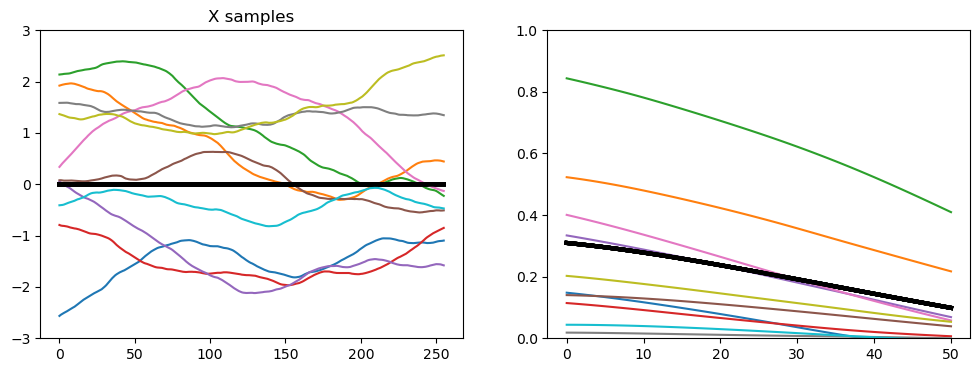

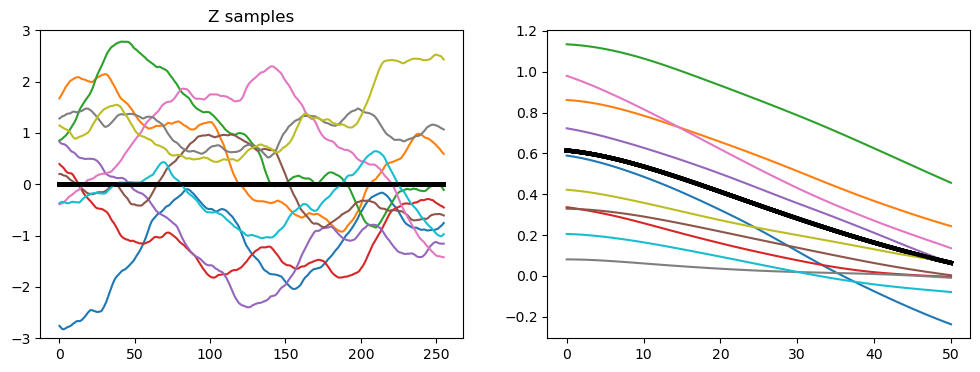

Finished sampling GRFs


In [5]:
print("Starting up. Generating GP samples")

#np.random.seed(22)
# nu = 0.5, the smaller, the less smooth (more rough) the approximated function is
x_train = GaussianProcess_1C(ndim, length_scale_x, nu_x, ntrain, return_kernel=False, nchannel=nchannel)
x_train = x_train.float().permute([1,0, 2])
fig, ax = plt.subplots(1,2, figsize=(12,4))
x_mean_true = x_train.mean(dim=(0,2))
x_hist_true, bin_edges = x_train.histogram(range=[-4,4], density=True)

# calculate the autocovaraince
x_acovf_true = torch.stack([torch.tensor(sm.tsa.acovf(x_train[i,:,0].numpy(), nlag=50)) for i in range(ntrain)]).mean(dim=0)
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train), batch_size=batch_size, shuffle=True)

print(x_train.shape)
for i in range(10):
    x = x_train[i,:,0]
    ax[0].plot(x)
    ax[0].set_ylim([-3, 3])
    ax[0].plot(x_mean_true, c='k', lw=3)
    ax[0].set_title("X samples")
    ax[1].plot(x_acovf_true, c='k', lw=3)
    ax[1].plot(sm.tsa.acovf(x, nlag=50))
    ax[1].set_ylim([0.0, 1.0])
plt.show()

# z smooth, length [smaller] less corrected 
z_train, kernel = GaussianProcess_1C(ndim, length_scale_z, nu_z, ntrain*2, return_kernel=True, nchannel=nchannel)
z_train = z_train.float().permute([1,0, 2])
#z_train = torch.randn(z_train.shape)
fig, ax = plt.subplots(1,2, figsize=(12,4))
z_mean_true = z_train.mean(dim=(0,2))
z_acovf_true = torch.stack([torch.tensor(sm.tsa.acovf(z_train[i,:,0].numpy(), nlag=50)) for i in range(ntrain)]).mean(dim=0)
# rename as z_loader
z_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(z_train), batch_size=batch_size, shuffle=True)

for i in range(10):
    #x = grf.sample(1)[0,:,0]
    z = z_train[i,:,0]
    ax[0].plot(z)
    ax[0].set_ylim([-3, 3])
    ax[0].plot(z_mean_true, c='k', lw=3)
    ax[1].plot(z_acovf_true, c='k', lw=3)
    ax[1].plot(sm.tsa.acovf(z, nlag=50))
    #ax[1].set_ylim([0.0, 1.0])
    ax[0].set_title("Z samples")
plt.show()
print("Finished sampling GRFs")

### OpFlow model setup

In [6]:
def kernel_loc(in_chan=2, up_dim=32):
    """
        Kernel network apply on grid
    """
    layers = nn.Sequential(
                nn.Linear(in_chan, up_dim, bias=True), torch.nn.GELU(),
                nn.Linear(up_dim, up_dim, bias=True), torch.nn.GELU(),
                nn.Linear(up_dim, 1, bias=False)
            )
    return layers


class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        #x = torch.fft.irfft(out_ft, n=x.size(-1))
        x = torch.fft.irfft(out_ft)
        return x

class pointwise_op(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(pointwise_op,self).__init__()
        self.conv = nn.Conv1d(int(in_channel), int(out_channel), 1)

    def forward(self,x):
        
        x_out = self.conv(x)
        #x_out = torch.nn.functional.interpolate(x_out, size = (dim1, dim2),mode = 'bicubic',align_corners=True)
        return x_out

In [7]:
class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes = modes
        self.width = width
        #self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(2, self.width) # input channel is 2: (a(x), x)
        
        self.conv0 = SpectralConv1d(self.width, self.width, self.modes)

        self.conv1 = SpectralConv1d(self.width, self.width, self.modes)
        
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes)

        self.conv3 = SpectralConv1d(self.width, self.width, self.modes)
        
        self.w0 = pointwise_op(self.width, self.width) #
        
        self.w1 = pointwise_op(self.width, self.width) #
        
        self.w2 = pointwise_op(self.width, self.width) #
        
        self.w3 = pointwise_op(self.width, self.width) #
        
        self.fc1 = nn.Linear(self.width, 2*self.width)
        # first three are normalized 3C waveforms, last three are associated PGAs
        self.fc2 = nn.Linear(2*self.width, 2) # s and t


    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=2)
        
        x = self.fc0(x)
        x = F.gelu(x)
               
        x = x.permute(0, 2, 1)

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x = x.permute(0, 2, 1)
        
        x = self.fc1(x)
        x = F.gelu(x)
        
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)

In [8]:
class ActNorm(nn.Module):
    def __init__(self, in_channel, logdet=True):
        super().__init__()
        
        self.loc = nn.Parameter(torch.zeros(1, 1, in_channel))
        self.log_scale = nn.Parameter(torch.zeros(1, 1, in_channel))

        self.register_buffer("initialized", torch.tensor(0, dtype=torch.uint8))
        self.logdet = logdet

    def initialize(self, input):
        with torch.no_grad():
            #flatten = input.permute(1, 0, 2).contiguous().view(input.shape[1], -1)
            mean = input.mean(dim=(0,1)).unsqueeze(0).unsqueeze(1)
            std = input.std(dim=(0,1)).unsqueeze(0).unsqueeze(1)

            self.loc.data.copy_(-mean)
            self.log_scale.data.copy_(torch.log(1 / (std + 1e-6)))

    def forward(self, input):
        batch_size, ndim, _ = input.shape

        if self.initialized.item() == 0:
            self.initialize(input)
            self.initialized.fill_(1)
            
        scale = torch.exp(self.log_scale)
        output = scale * (input + self.loc)        

        logdet = batch_size * ndim * self.log_scale.sum() #pointwise operation
        
        return output, logdet


    def inverse(self, output):
        #_, length, wdith, _ = output.shape
        scale = torch.exp(self.log_scale)
        output = output / scale - self.loc
        #logdet = -1.0 * width * length * self.log_scale.sum()
        
        #return output, logdet
        return output

In [9]:
class AffineCoupling(nn.Module):
    def __init__(self, modes, width):
        super(AffineCoupling, self).__init__()
        """
        A single affine coupling operator block
        This layer splits the input spatially and computes scale and shift functions
        It consists of two FNO networks to compute scale and shift functions
        The scale and shift functions are then used to transform the other
        half of the input function
        """
        self.modes = modes
        self.width = width
        self.coupling = FNO1d(modes=self.modes, width=self.width)
        self.actnorm = ActNorm(2)

    def forward(self, z, flip=False):
        #
        x = z
        x, log_actnorm = self.actnorm(x)
        
        """
        n_rep = x.shape[1] // (2*self.k) + 1
        mask_a = torch.tensor([True, False], device=x.device).repeat_interleave(self.k).repeat(n_rep)
        mask_a = mask_a[:x.shape[1]]
        mask_b = torch.logical_not(mask_a)
        # define the dimension
        x1 = x * mask_a[None,:,None] # x1 has the same shape of z, but for False in mask_a, values are replaced with 0
        x2 = x * mask_b[None,:,None]
        
        if flip:
            x2, x1 = x1, x2
            mask_b, mask_a = mask_a, mask_b
        """
        n_rep = x.shape[-1] // 2
        mask_a = torch.ones(x.shape, device=x.device)
        mask_a[:,:,0:n_rep] = 0

        mask_b = torch.logical_not(mask_a)
        x1 = x[:,:,0:1]
        x2 = x[:,:,1:2]
                        
        if flip:
            x2, x1 = x1, x2
            mask_b, mask_a = mask_a, mask_b
    
        # forward
        #print("x1 shape:{}".format(x1.shape))
        scale_shift = self.coupling(x1)
        #print("scale_shift forward:{}".format(scale_shift.shape))
        log_scale = scale_shift[:,:,0:1]
        assert(scale_shift.shape == torch.zeros([x.shape[0], x.shape[1], 2]).shape)
        
        scale = torch.exp(log_scale)
        shift = scale_shift[:,:,1:2]
        z1 = x1
        z2 = x2 * scale + shift

        if flip:
            z_hat = torch.cat([z2, z1], dim=-1)
        else:
            z_hat = torch.cat([z1, z2], dim=-1)
            

        log_det = log_scale.sum()
        log_det = log_det + log_actnorm

        return z_hat, log_det

    def inverse(self, z, flip=False):
        n_rep = z.shape[-1] // 2
        mask_a = torch.ones(z.shape, device=z.device)
        mask_a[:,:,0:n_rep] = 0
        mask_b = torch.logical_not(mask_a)
        z1 = z[:,:,0:1]
        z2 = z[:,:,1:2]

        if flip:
            z2, z1 = z1, z2
            mask_b, mask_a = mask_a, mask_b
            
        x1 = z1
        
        #print("z1 shape:{}".format(z1.shape))
        scale_shift = self.coupling(z1)
        
        #print("scale shift shape:{}".format(scale_shift.shape))
        # print("scaleshift inv", scale_shift.shape)
        assert(scale_shift.shape == torch.zeros([z.shape[0], z.shape[1], 2]).shape)
        log_scale = scale_shift[:,:,0:1]
        scale = torch.exp(-log_scale)
        shift = scale_shift[:,:,1:2]
        x2 = (z2 - shift) * scale
            
        if flip:
            x_hat = torch.cat([x2, x1], dim=-1)
        else:
            x_hat = torch.cat([x1, x2], dim=-1)  
        x_hat = self.actnorm.inverse(x_hat)

        return x_hat

In [10]:
class OpFlow(nn.Module):
    def __init__(self, modes, width, blocks, base_dist, kernel=None, gp=None):
        super().__init__()
        self.flips = [True if i%2 else False for i in range(blocks)]

        self.bijectors = nn.ModuleList([
            AffineCoupling(modes=modes, width=width) for i in range(blocks)
        ])
        if kernel is not None:
            self.kernel = kernel
        if gp is not None:
            self.gp = gp
        self.base_dist = base_dist
        
    def forward(self, x):
        batch_size = x.shape[0]
        log_dets = []
        
        for bijector, f in zip(self.bijectors, self.flips):
            x, log_det = bijector(x, flip=f)
            log_dets.append(log_det)
        z = x
        log_pz = 0
        for i in range(x.shape[-1]):
            # print(z.squeeze()[:, :, i].shape)
            log_pz += self.base_dist.log_prob(z[:, :, i].reshape(x.shape[0], -1)).sum()
        # print("donew ith forward")
        
        return x, log_pz/batch_size, sum(log_dets)/batch_size
    
    def inverse(self, z):
        for bijector, f in zip(reversed(self.bijectors), reversed(self.flips)):
            z = bijector.inverse(z, flip=f)
        return z

In [11]:
lr = 5*1e-5
epochs = 600
reg_fac = 1

n_train_tot = int(ntrain/batch_size)
modes = ndim // 4
width = 64
#width = 128


blocks = 10
base_mu = torch.zeros(ndim).float()
base_cov = torch.tensor(kernel).float()
base_dist = torch.distributions.MultivariateNormal(base_mu.to(device), scale_tril=torch.linalg.cholesky_ex(base_cov)[0].to(device))

In [12]:
G = OpFlow(modes=modes, width=width, blocks=blocks, base_dist=base_dist).to(device)

#G = DDP(D, device_ids=device_ids, output_device=0)

nn_params = sum(p.numel() for p in G.parameters() if p.requires_grad)
print("Number generator parameters: ", nn_params)

G_optim = torch.optim.Adam(G.parameters(), lr=lr , weight_decay=1e-4)
G.train()

Number generator parameters:  10739900


OpFlow(
  (bijectors): ModuleList(
    (0): AffineCoupling(
      (coupling): FNO1d(
        (fc0): Linear(in_features=2, out_features=64, bias=True)
        (conv0): SpectralConv1d()
        (conv1): SpectralConv1d()
        (conv2): SpectralConv1d()
        (conv3): SpectralConv1d()
        (w0): pointwise_op(
          (conv): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
        )
        (w1): pointwise_op(
          (conv): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
        )
        (w2): pointwise_op(
          (conv): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
        )
        (w3): pointwise_op(
          (conv): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
        )
        (fc1): Linear(in_features=64, out_features=128, bias=True)
        (fc2): Linear(in_features=128, out_features=2, bias=True)
      )
      (actnorm): ActNorm()
    )
    (1): AffineCoupling(
      (coupling): FNO1d(
        (fc0): Linear(in_features=2, out_features=64, bias=True)
        (conv0): 

## Model training

In [13]:
def inject_noise(x, z, factor=0.001):
    # default factor is 0.001
    # usually, use should use small factor of noise
    # get noise from z
    tot = len(z)
    ib = np.random.choice(tot, size=x.shape[0], replace=True)
    x = x + factor * z[ib]
    return x


def get_x_batch(batch_size=batch_size, x_train=x_train):
    tot = len(x_train)
    ib = np.random.choice(tot, size=batch_size, replace=False)
    ib.sort()
    #print(ib)
    x = x_train[ib]
    x_noisy = inject_noise(x, z_train)
    return x_noisy

In [14]:
def is_psd(mat):
    return bool((mat == mat.T).all() and (torch.linalg.eigvals(mat).real>=0).all())


def matrix_sqrt(matrix):
    """Compute the square root of a positive definite matrix."""
    _, s, v = matrix.svd()
    good = s > s.max(-1, True).values * s.size(-1) * torch.finfo(s.dtype).eps
    components = good.sum(-1)
    common = components.max()
    unbalanced = common != components.min()
    if common < s.size(-1):
        s = s[..., :common]
        v = v[..., :common]
        if unbalanced:
            good = good[..., :common]
    if unbalanced:
        s = s.where(good, torch.zeros((), device=s.device, dtype=s.dtype))
    return (v * s.sqrt().unsqueeze(-2)) @ v.transpose(-2, -1)


def cal_F2ID(z_all, base_mu, base_cov):
    """
    z : [n, ndim, 2*ndim, 1]
    base_mu : [2*ndim*ndim]
    base_cov : [2*ndim*ndim, 2*ndim*ndim]
    """
    F2ID_all = 0
    for i in range(2):
        z = z_all[:,:,i]
        ndim = z.shape[1]
        syn_mu = z.mean(dim=0).reshape(ndim)
        syn_cov = torch.cov(z.reshape(-1, ndim).permute(1,0))

        """
        #print("syn_mu shape: {}, syn_cov shape : {}".format(syn_mu.shape, syn_cov.shape))

        if base_cov_sqrt is None:
            base_cov_sqrt = matrix_sqrt(base_cov).detach()

        #print("device of syn_cov :{}, base_cov:{}, syn_cov :{}, base_cov_sqrt:{}".format(syn_cov.device, base_cov.device, syn_cov.device, base_cov_sqrt.device))
        #L = syn_cov + base_cov - 2 * matrix_sqrt(base_cov_sqrt @ syn_cov @ base_cov_sqrt).cuda()
        #term1 = torch.sum((syn_mu - base_mu)**2)/(ndim*ndim)
        #term2 = torch.trace(L)/(ndim*ndim)
        #F2ID = torch.sum((syn_mu - base_mu)**2)/(ndim*ndim) + torch.trace(L)/(ndim*ndim)    
        """

        F2ID = torch.sum((syn_mu - base_mu)**2)/(ndim) + torch.sum((syn_cov -base_cov)**2)/(ndim)
        if i == 0:
            term1 = F2ID
        if i == 1:
            term2 = F2ID
        F2ID_all += F2ID
        #print('term1 : {}, term2 :{}'.format(term1, term2))
    return F2ID_all, term1, term2

In [17]:
def train_opflow(G, G_optim, epochs, base_mu, base_cov, scheduler=None, fine_tune_epoch=50, past_epoch=10):
    base_mu = base_mu.to(device)
    base_cov = base_cov.to(device)

    epochs = epochs + fine_tune_epoch
    losses_G = np.zeros(epochs)

    F2ID_past_epoch = torch.zeros(past_epoch) 
    
    for epoch in range(epochs):
        
        loss_G = 0.0
        losses_F2ID = [] # for training stability
        
        # fine tune phase
        if epoch == (epochs-fine_tune_epoch):
            # smaller learning rate for fine tune
            G_optim.param_groups[0]['lr'] = G_optim.param_groups[0]['lr'] * 0.1
        
        for j in range(n_train_tot):
            
            G_optim.zero_grad()
 
            x = get_x_batch().to(device)
            z_syn, log_pz, log_det = G(x)            
            ll_loss = (-log_pz - log_det).mean()


            # training phase
            if (epoch >= 0) and (epoch <= (epochs-fine_tune_epoch)):
                F2ID_loss, term1, term2 = cal_F2ID(z_syn, base_mu, base_cov)
                
                if epoch < past_epoch:
                    losses_F2ID.append(F2ID_loss.item())                    
                    loss = ll_loss + reg_fac*F2ID_loss
                    
                elif epoch >= past_epoch:
                    if (F2ID_loss >= 10 *torch.median(F2ID_past_epoch)): # the F2ID loss is abnormal
                        loss = ll_loss
                    else:
                        losses_F2ID.append(F2ID_loss.item())
                        loss = ll_loss + reg_fac*F2ID_loss
                    
                print("epoch:[{} / {}] batch:[{} / {}],loss_G:{:.2f}, loss_F2ID:{:.2f}, loss_F2ID term1:{:.2f}, loss_F2ID term2:{:.2f}".format(epoch, epochs, j, n_train_tot, loss.item(), F2ID_loss.item(), term1.item(), term2.item()))
            
            elif (epoch >= (epochs-fine_tune_epoch)):
                loss = ll_loss
                print("epoch:[{} / {}] batch:[{} / {}],loss_G:{:.4f} ".format(epoch, epochs, j, n_train_tot, loss.item()))
            
            loss.backward()
            loss_G += loss.item()

            G_optim.step()
            
        with torch.no_grad():
            F2ID_past_epoch[epoch%past_epoch] = torch.median(torch.Tensor(losses_F2ID))
            print("F2ID_past_epoch :{}".format(F2ID_past_epoch))            
            fig, ax = plt.subplots(2,2, figsize=(12,8))
            
            Z_alt = torch.cat([base_dist.rsample(sample_shape=(1000,)).reshape(-1, ndim, 1),
                               base_dist.rsample(sample_shape=(1000,)).reshape(-1, ndim, 1)], axis=-1)
            
            X_alt = G.inverse(Z_alt).detach().cpu()
            x_acovf_channel1 = torch.stack([torch.tensor(sm.tsa.acovf(X_alt[i,:,0], nlag=50)) for i in range(1000)]).mean(dim=0)
            x_acovf_channel2 = torch.stack([torch.tensor(sm.tsa.acovf(X_alt[i,:,1], nlag=50)) for i in range(1000)]).mean(dim=0)
            x_mean_channel1 = X_alt[:,:,0].mean(axis=0)
            x_mean_channel2 = X_alt[:,:,1].mean(axis=0)
            
            for i in range(10):
                x1 = X_alt[i,:,0]
                ax[0,0].plot(x1)

                x2 = X_alt[i,:,1]
                ax[1,0].plot(x2)
                
                ## acovf
                ax[0,1].plot(sm.tsa.acovf(x1, nlag=50))
                ax[1,1].plot(sm.tsa.acovf(x2, nlag=50))
                
                
                if i == 0:
                    ax[0,0].plot(x_mean_true, c='k', lw=3, label='Ground Truth')
                    ax[0,0].plot(x_mean_channel1, c='r', lw=3, label='Synthetic channel_1')
                    
                    ax[1,0].plot(x_mean_true, c='k', lw=3, label='Ground Truth')
                    ax[1,0].plot(x_mean_channel2, c='r', lw=3, label='Synthetic channel_2')
                    
                    ax[0,1].plot(x_acovf_true, c='k', lw=3, label='Ground Truth')      
                    ax[0,1].plot(x_acovf_channel1, c='r', lw=3, label='Synthetic channel_1')
                    
                    ax[1,1].plot(x_acovf_true, c='k', lw=3, label='Ground Truth')
                    ax[1,1].plot(x_acovf_channel2, c='r', lw=3, label='Synthetic channel_2')
                    
                    ax[0, 0].legend(loc='upper right')
                    ax[0, 1].legend(loc='upper right')
                    ax[1, 0].legend(loc='upper right')
                    ax[1, 1].legend(loc='upper right')
                    
            plt.savefig("paper_plots/{}/1D_codomain_{}_prior.pdf".format(folder, epoch))
            plt.close()
      
        losses_G[epoch] = loss_G / batch_size
        
        if ((epoch+1)%300 == 0) | ((epoch+1)==epochs):
            torch.save({
                        'model_state_dict': G.state_dict(),
                        }, "paper_saved_models/{}/1D_codomain_{}_prior.pt".format(folder, epoch))
        
    return losses_G

In [16]:
folder = "GP2GP_FNO_codomain_prior"
if not os.path.exists(f"paper_saved_models/{folder}"):
    os.makedirs(f"paper_saved_models/{folder}")
if not os.path.exists(f"paper_plots/{folder}"):
    os.makedirs(f"paper_plots/{folder}")

In [18]:
start = timeit.default_timer() # track the time for training
losses_G = train_opflow(G, G_optim, epochs, base_mu, base_cov)
stop = timeit.default_timer() 

epoch:[0 / 650] batch:[0 / 58],loss_G:-1825.31, loss_F2ID:47.03, loss_F2ID term1:16.04, loss_F2ID term2:31.00
epoch:[0 / 650] batch:[1 / 58],loss_G:-1813.22, loss_F2ID:61.39, loss_F2ID term1:25.95, loss_F2ID term2:35.44
epoch:[0 / 650] batch:[2 / 58],loss_G:-1813.54, loss_F2ID:62.69, loss_F2ID term1:28.40, loss_F2ID term2:34.29
epoch:[0 / 650] batch:[3 / 58],loss_G:-1820.93, loss_F2ID:56.81, loss_F2ID term1:24.87, loss_F2ID term2:31.94
epoch:[0 / 650] batch:[4 / 58],loss_G:-1827.69, loss_F2ID:51.65, loss_F2ID term1:29.37, loss_F2ID term2:22.28
epoch:[0 / 650] batch:[5 / 58],loss_G:-1826.65, loss_F2ID:54.51, loss_F2ID term1:26.40, loss_F2ID term2:28.10
epoch:[0 / 650] batch:[6 / 58],loss_G:-1809.42, loss_F2ID:73.66, loss_F2ID term1:27.14, loss_F2ID term2:46.52
epoch:[0 / 650] batch:[7 / 58],loss_G:-1836.39, loss_F2ID:48.04, loss_F2ID term1:25.80, loss_F2ID term2:22.25
epoch:[0 / 650] batch:[8 / 58],loss_G:-1824.65, loss_F2ID:61.32, loss_F2ID term1:28.00, loss_F2ID term2:33.32
epoch:[0 /

epoch:[1 / 650] batch:[15 / 58],loss_G:-1819.88, loss_F2ID:73.05, loss_F2ID term1:32.15, loss_F2ID term2:40.89
epoch:[1 / 650] batch:[16 / 58],loss_G:-1836.40, loss_F2ID:56.38, loss_F2ID term1:28.47, loss_F2ID term2:27.91
epoch:[1 / 650] batch:[17 / 58],loss_G:-1819.41, loss_F2ID:73.30, loss_F2ID term1:41.48, loss_F2ID term2:31.82
epoch:[1 / 650] batch:[18 / 58],loss_G:-1829.71, loss_F2ID:63.01, loss_F2ID term1:35.72, loss_F2ID term2:27.28
epoch:[1 / 650] batch:[19 / 58],loss_G:-1828.94, loss_F2ID:63.48, loss_F2ID term1:30.26, loss_F2ID term2:33.22
epoch:[1 / 650] batch:[20 / 58],loss_G:-1805.10, loss_F2ID:87.32, loss_F2ID term1:41.77, loss_F2ID term2:45.55
epoch:[1 / 650] batch:[21 / 58],loss_G:-1819.89, loss_F2ID:72.44, loss_F2ID term1:41.15, loss_F2ID term2:31.28
epoch:[1 / 650] batch:[22 / 58],loss_G:-1815.98, loss_F2ID:76.00, loss_F2ID term1:37.87, loss_F2ID term2:38.13
epoch:[1 / 650] batch:[23 / 58],loss_G:-1827.92, loss_F2ID:63.88, loss_F2ID term1:42.39, loss_F2ID term2:21.49
e

epoch:[2 / 650] batch:[30 / 58],loss_G:-1828.00, loss_F2ID:57.69, loss_F2ID term1:28.16, loss_F2ID term2:29.53
epoch:[2 / 650] batch:[31 / 58],loss_G:-1811.60, loss_F2ID:74.02, loss_F2ID term1:39.88, loss_F2ID term2:34.14
epoch:[2 / 650] batch:[32 / 58],loss_G:-1821.39, loss_F2ID:64.13, loss_F2ID term1:34.15, loss_F2ID term2:29.98
epoch:[2 / 650] batch:[33 / 58],loss_G:-1827.92, loss_F2ID:57.69, loss_F2ID term1:34.09, loss_F2ID term2:23.61
epoch:[2 / 650] batch:[34 / 58],loss_G:-1812.77, loss_F2ID:72.88, loss_F2ID term1:44.88, loss_F2ID term2:28.00
epoch:[2 / 650] batch:[35 / 58],loss_G:-1811.67, loss_F2ID:74.11, loss_F2ID term1:34.58, loss_F2ID term2:39.53
epoch:[2 / 650] batch:[36 / 58],loss_G:-1806.65, loss_F2ID:79.15, loss_F2ID term1:28.79, loss_F2ID term2:50.37
epoch:[2 / 650] batch:[37 / 58],loss_G:-1799.25, loss_F2ID:86.42, loss_F2ID term1:46.95, loss_F2ID term2:39.48
epoch:[2 / 650] batch:[38 / 58],loss_G:-1796.80, loss_F2ID:88.56, loss_F2ID term1:42.92, loss_F2ID term2:45.64
e

epoch:[3 / 650] batch:[45 / 58],loss_G:-1805.12, loss_F2ID:85.17, loss_F2ID term1:45.54, loss_F2ID term2:39.63
epoch:[3 / 650] batch:[46 / 58],loss_G:-1801.49, loss_F2ID:87.92, loss_F2ID term1:48.63, loss_F2ID term2:39.29
epoch:[3 / 650] batch:[47 / 58],loss_G:-1790.96, loss_F2ID:97.27, loss_F2ID term1:65.21, loss_F2ID term2:32.06
epoch:[3 / 650] batch:[48 / 58],loss_G:-1819.39, loss_F2ID:67.57, loss_F2ID term1:36.93, loss_F2ID term2:30.64
epoch:[3 / 650] batch:[49 / 58],loss_G:-1796.93, loss_F2ID:88.84, loss_F2ID term1:40.42, loss_F2ID term2:48.42
epoch:[3 / 650] batch:[50 / 58],loss_G:-1818.98, loss_F2ID:65.36, loss_F2ID term1:26.05, loss_F2ID term2:39.32
epoch:[3 / 650] batch:[51 / 58],loss_G:-1825.82, loss_F2ID:57.61, loss_F2ID term1:33.93, loss_F2ID term2:23.68
epoch:[3 / 650] batch:[52 / 58],loss_G:-1814.67, loss_F2ID:67.81, loss_F2ID term1:25.57, loss_F2ID term2:42.25
epoch:[3 / 650] batch:[53 / 58],loss_G:-1818.74, loss_F2ID:63.02, loss_F2ID term1:34.89, loss_F2ID term2:28.13
e

epoch:[5 / 650] batch:[1 / 58],loss_G:-1807.10, loss_F2ID:81.21, loss_F2ID term1:48.15, loss_F2ID term2:33.06
epoch:[5 / 650] batch:[2 / 58],loss_G:-1842.55, loss_F2ID:46.17, loss_F2ID term1:29.35, loss_F2ID term2:16.82
epoch:[5 / 650] batch:[3 / 58],loss_G:-1797.84, loss_F2ID:91.09, loss_F2ID term1:50.98, loss_F2ID term2:40.11
epoch:[5 / 650] batch:[4 / 58],loss_G:-1826.18, loss_F2ID:62.97, loss_F2ID term1:28.43, loss_F2ID term2:34.54
epoch:[5 / 650] batch:[5 / 58],loss_G:-1823.88, loss_F2ID:65.37, loss_F2ID term1:38.24, loss_F2ID term2:27.12
epoch:[5 / 650] batch:[6 / 58],loss_G:-1818.35, loss_F2ID:71.07, loss_F2ID term1:42.37, loss_F2ID term2:28.70
epoch:[5 / 650] batch:[7 / 58],loss_G:-1808.34, loss_F2ID:81.13, loss_F2ID term1:51.05, loss_F2ID term2:30.08
epoch:[5 / 650] batch:[8 / 58],loss_G:-1843.18, loss_F2ID:46.74, loss_F2ID term1:30.07, loss_F2ID term2:16.67
epoch:[5 / 650] batch:[9 / 58],loss_G:-1834.28, loss_F2ID:55.78, loss_F2ID term1:32.61, loss_F2ID term2:23.17
epoch:[5 /

epoch:[6 / 650] batch:[16 / 58],loss_G:-1813.57, loss_F2ID:77.81, loss_F2ID term1:35.79, loss_F2ID term2:42.03
epoch:[6 / 650] batch:[17 / 58],loss_G:-1804.37, loss_F2ID:86.81, loss_F2ID term1:43.16, loss_F2ID term2:43.65
epoch:[6 / 650] batch:[18 / 58],loss_G:-1811.77, loss_F2ID:78.94, loss_F2ID term1:39.63, loss_F2ID term2:39.31
epoch:[6 / 650] batch:[19 / 58],loss_G:-1816.07, loss_F2ID:74.27, loss_F2ID term1:41.00, loss_F2ID term2:33.27
epoch:[6 / 650] batch:[20 / 58],loss_G:-1797.64, loss_F2ID:91.92, loss_F2ID term1:38.31, loss_F2ID term2:53.61
epoch:[6 / 650] batch:[21 / 58],loss_G:-1823.39, loss_F2ID:65.62, loss_F2ID term1:31.54, loss_F2ID term2:34.09
epoch:[6 / 650] batch:[22 / 58],loss_G:-1829.43, loss_F2ID:58.78, loss_F2ID term1:25.63, loss_F2ID term2:33.15
epoch:[6 / 650] batch:[23 / 58],loss_G:-1830.21, loss_F2ID:57.65, loss_F2ID term1:32.88, loss_F2ID term2:24.78
epoch:[6 / 650] batch:[24 / 58],loss_G:-1827.07, loss_F2ID:60.69, loss_F2ID term1:24.57, loss_F2ID term2:36.12
e

epoch:[7 / 650] batch:[31 / 58],loss_G:-1819.37, loss_F2ID:70.59, loss_F2ID term1:40.68, loss_F2ID term2:29.91
epoch:[7 / 650] batch:[32 / 58],loss_G:-1818.94, loss_F2ID:70.50, loss_F2ID term1:33.01, loss_F2ID term2:37.49
epoch:[7 / 650] batch:[33 / 58],loss_G:-1832.51, loss_F2ID:56.46, loss_F2ID term1:28.35, loss_F2ID term2:28.11
epoch:[7 / 650] batch:[34 / 58],loss_G:-1831.66, loss_F2ID:57.21, loss_F2ID term1:25.81, loss_F2ID term2:31.40
epoch:[7 / 650] batch:[35 / 58],loss_G:-1832.97, loss_F2ID:55.81, loss_F2ID term1:29.27, loss_F2ID term2:26.54
epoch:[7 / 650] batch:[36 / 58],loss_G:-1803.07, loss_F2ID:85.53, loss_F2ID term1:44.97, loss_F2ID term2:40.56
epoch:[7 / 650] batch:[37 / 58],loss_G:-1828.50, loss_F2ID:60.30, loss_F2ID term1:34.99, loss_F2ID term2:25.30
epoch:[7 / 650] batch:[38 / 58],loss_G:-1831.38, loss_F2ID:57.53, loss_F2ID term1:29.89, loss_F2ID term2:27.65
epoch:[7 / 650] batch:[39 / 58],loss_G:-1807.79, loss_F2ID:81.31, loss_F2ID term1:37.26, loss_F2ID term2:44.05
e

epoch:[8 / 650] batch:[46 / 58],loss_G:-1820.99, loss_F2ID:65.68, loss_F2ID term1:32.72, loss_F2ID term2:32.96
epoch:[8 / 650] batch:[47 / 58],loss_G:-1828.23, loss_F2ID:58.87, loss_F2ID term1:29.71, loss_F2ID term2:29.16
epoch:[8 / 650] batch:[48 / 58],loss_G:-1812.00, loss_F2ID:75.27, loss_F2ID term1:44.69, loss_F2ID term2:30.57
epoch:[8 / 650] batch:[49 / 58],loss_G:-1810.15, loss_F2ID:77.69, loss_F2ID term1:41.30, loss_F2ID term2:36.39
epoch:[8 / 650] batch:[50 / 58],loss_G:-1810.99, loss_F2ID:76.99, loss_F2ID term1:43.41, loss_F2ID term2:33.58
epoch:[8 / 650] batch:[51 / 58],loss_G:-1816.54, loss_F2ID:71.51, loss_F2ID term1:47.12, loss_F2ID term2:24.39
epoch:[8 / 650] batch:[52 / 58],loss_G:-1817.28, loss_F2ID:70.78, loss_F2ID term1:42.02, loss_F2ID term2:28.76
epoch:[8 / 650] batch:[53 / 58],loss_G:-1811.63, loss_F2ID:76.31, loss_F2ID term1:38.82, loss_F2ID term2:37.50
epoch:[8 / 650] batch:[54 / 58],loss_G:-1821.44, loss_F2ID:66.60, loss_F2ID term1:37.53, loss_F2ID term2:29.07
e

epoch:[10 / 650] batch:[2 / 58],loss_G:-1810.16, loss_F2ID:77.49, loss_F2ID term1:46.64, loss_F2ID term2:30.85
epoch:[10 / 650] batch:[3 / 58],loss_G:-1808.11, loss_F2ID:79.41, loss_F2ID term1:40.02, loss_F2ID term2:39.38
epoch:[10 / 650] batch:[4 / 58],loss_G:-1827.05, loss_F2ID:60.07, loss_F2ID term1:32.77, loss_F2ID term2:27.30
epoch:[10 / 650] batch:[5 / 58],loss_G:-1814.52, loss_F2ID:72.40, loss_F2ID term1:34.69, loss_F2ID term2:37.71
epoch:[10 / 650] batch:[6 / 58],loss_G:-1836.53, loss_F2ID:50.20, loss_F2ID term1:31.18, loss_F2ID term2:19.01
epoch:[10 / 650] batch:[7 / 58],loss_G:-1820.91, loss_F2ID:66.00, loss_F2ID term1:34.37, loss_F2ID term2:31.63
epoch:[10 / 650] batch:[8 / 58],loss_G:-1806.50, loss_F2ID:80.41, loss_F2ID term1:36.27, loss_F2ID term2:44.14
epoch:[10 / 650] batch:[9 / 58],loss_G:-1816.84, loss_F2ID:70.04, loss_F2ID term1:26.66, loss_F2ID term2:43.38
epoch:[10 / 650] batch:[10 / 58],loss_G:-1823.14, loss_F2ID:63.80, loss_F2ID term1:25.41, loss_F2ID term2:38.39


epoch:[11 / 650] batch:[17 / 58],loss_G:-1815.54, loss_F2ID:68.47, loss_F2ID term1:31.24, loss_F2ID term2:37.24
epoch:[11 / 650] batch:[18 / 58],loss_G:-1812.28, loss_F2ID:72.27, loss_F2ID term1:36.15, loss_F2ID term2:36.12
epoch:[11 / 650] batch:[19 / 58],loss_G:-1824.66, loss_F2ID:60.36, loss_F2ID term1:31.22, loss_F2ID term2:29.13
epoch:[11 / 650] batch:[20 / 58],loss_G:-1819.50, loss_F2ID:66.18, loss_F2ID term1:37.24, loss_F2ID term2:28.94
epoch:[11 / 650] batch:[21 / 58],loss_G:-1812.96, loss_F2ID:73.19, loss_F2ID term1:41.78, loss_F2ID term2:31.41
epoch:[11 / 650] batch:[22 / 58],loss_G:-1784.25, loss_F2ID:102.04, loss_F2ID term1:49.45, loss_F2ID term2:52.59
epoch:[11 / 650] batch:[23 / 58],loss_G:-1818.22, loss_F2ID:68.26, loss_F2ID term1:25.36, loss_F2ID term2:42.90
epoch:[11 / 650] batch:[24 / 58],loss_G:-1829.83, loss_F2ID:56.77, loss_F2ID term1:26.12, loss_F2ID term2:30.65
epoch:[11 / 650] batch:[25 / 58],loss_G:-1824.06, loss_F2ID:62.63, loss_F2ID term1:27.08, loss_F2ID ter

epoch:[12 / 650] batch:[32 / 58],loss_G:-1819.19, loss_F2ID:74.88, loss_F2ID term1:39.63, loss_F2ID term2:35.25
epoch:[12 / 650] batch:[33 / 58],loss_G:-1808.87, loss_F2ID:85.31, loss_F2ID term1:37.82, loss_F2ID term2:47.48
epoch:[12 / 650] batch:[34 / 58],loss_G:-1837.02, loss_F2ID:57.40, loss_F2ID term1:28.95, loss_F2ID term2:28.45
epoch:[12 / 650] batch:[35 / 58],loss_G:-1828.11, loss_F2ID:66.39, loss_F2ID term1:30.96, loss_F2ID term2:35.43
epoch:[12 / 650] batch:[36 / 58],loss_G:-1824.19, loss_F2ID:70.56, loss_F2ID term1:31.10, loss_F2ID term2:39.47
epoch:[12 / 650] batch:[37 / 58],loss_G:-1812.88, loss_F2ID:81.91, loss_F2ID term1:43.64, loss_F2ID term2:38.27
epoch:[12 / 650] batch:[38 / 58],loss_G:-1784.98, loss_F2ID:109.42, loss_F2ID term1:35.48, loss_F2ID term2:73.94
epoch:[12 / 650] batch:[39 / 58],loss_G:-1828.83, loss_F2ID:65.40, loss_F2ID term1:29.96, loss_F2ID term2:35.44
epoch:[12 / 650] batch:[40 / 58],loss_G:-1820.25, loss_F2ID:73.26, loss_F2ID term1:47.56, loss_F2ID ter

epoch:[13 / 650] batch:[47 / 58],loss_G:-1825.55, loss_F2ID:63.16, loss_F2ID term1:33.11, loss_F2ID term2:30.05
epoch:[13 / 650] batch:[48 / 58],loss_G:-1816.04, loss_F2ID:72.59, loss_F2ID term1:41.02, loss_F2ID term2:31.57
epoch:[13 / 650] batch:[49 / 58],loss_G:-1826.18, loss_F2ID:62.50, loss_F2ID term1:30.09, loss_F2ID term2:32.41
epoch:[13 / 650] batch:[50 / 58],loss_G:-1827.81, loss_F2ID:60.83, loss_F2ID term1:27.97, loss_F2ID term2:32.86
epoch:[13 / 650] batch:[51 / 58],loss_G:-1814.98, loss_F2ID:73.75, loss_F2ID term1:39.82, loss_F2ID term2:33.93
epoch:[13 / 650] batch:[52 / 58],loss_G:-1813.67, loss_F2ID:75.13, loss_F2ID term1:37.61, loss_F2ID term2:37.52
epoch:[13 / 650] batch:[53 / 58],loss_G:-1827.04, loss_F2ID:61.82, loss_F2ID term1:26.10, loss_F2ID term2:35.71
epoch:[13 / 650] batch:[54 / 58],loss_G:-1826.19, loss_F2ID:62.85, loss_F2ID term1:41.05, loss_F2ID term2:21.79
epoch:[13 / 650] batch:[55 / 58],loss_G:-1781.74, loss_F2ID:107.08, loss_F2ID term1:52.21, loss_F2ID ter

epoch:[15 / 650] batch:[3 / 58],loss_G:-1814.02, loss_F2ID:73.02, loss_F2ID term1:38.25, loss_F2ID term2:34.76
epoch:[15 / 650] batch:[4 / 58],loss_G:-1820.41, loss_F2ID:66.87, loss_F2ID term1:36.93, loss_F2ID term2:29.94
epoch:[15 / 650] batch:[5 / 58],loss_G:-1837.89, loss_F2ID:49.78, loss_F2ID term1:18.99, loss_F2ID term2:30.79
epoch:[15 / 650] batch:[6 / 58],loss_G:-1808.43, loss_F2ID:79.65, loss_F2ID term1:37.11, loss_F2ID term2:42.54
epoch:[15 / 650] batch:[7 / 58],loss_G:-1818.06, loss_F2ID:70.48, loss_F2ID term1:33.98, loss_F2ID term2:36.50
epoch:[15 / 650] batch:[8 / 58],loss_G:-1821.43, loss_F2ID:67.43, loss_F2ID term1:44.25, loss_F2ID term2:23.17
epoch:[15 / 650] batch:[9 / 58],loss_G:-1818.30, loss_F2ID:70.90, loss_F2ID term1:45.36, loss_F2ID term2:25.54
epoch:[15 / 650] batch:[10 / 58],loss_G:-1811.78, loss_F2ID:77.60, loss_F2ID term1:42.90, loss_F2ID term2:34.69
epoch:[15 / 650] batch:[11 / 58],loss_G:-1820.13, loss_F2ID:69.55, loss_F2ID term1:34.19, loss_F2ID term2:35.35

epoch:[16 / 650] batch:[18 / 58],loss_G:-1832.86, loss_F2ID:55.43, loss_F2ID term1:27.78, loss_F2ID term2:27.65
epoch:[16 / 650] batch:[19 / 58],loss_G:-1803.95, loss_F2ID:84.43, loss_F2ID term1:46.46, loss_F2ID term2:37.97
epoch:[16 / 650] batch:[20 / 58],loss_G:-1826.94, loss_F2ID:61.79, loss_F2ID term1:28.06, loss_F2ID term2:33.73
epoch:[16 / 650] batch:[21 / 58],loss_G:-1814.51, loss_F2ID:74.41, loss_F2ID term1:41.03, loss_F2ID term2:33.37
epoch:[16 / 650] batch:[22 / 58],loss_G:-1821.48, loss_F2ID:67.63, loss_F2ID term1:36.07, loss_F2ID term2:31.56
epoch:[16 / 650] batch:[23 / 58],loss_G:-1839.80, loss_F2ID:49.72, loss_F2ID term1:23.29, loss_F2ID term2:26.43
epoch:[16 / 650] batch:[24 / 58],loss_G:-1813.60, loss_F2ID:76.07, loss_F2ID term1:37.32, loss_F2ID term2:38.74
epoch:[16 / 650] batch:[25 / 58],loss_G:-1794.13, loss_F2ID:95.62, loss_F2ID term1:59.49, loss_F2ID term2:36.13
epoch:[16 / 650] batch:[26 / 58],loss_G:-1824.96, loss_F2ID:64.98, loss_F2ID term1:38.15, loss_F2ID term

epoch:[17 / 650] batch:[33 / 58],loss_G:-1822.02, loss_F2ID:67.32, loss_F2ID term1:37.75, loss_F2ID term2:29.57
epoch:[17 / 650] batch:[34 / 58],loss_G:-1814.61, loss_F2ID:75.01, loss_F2ID term1:33.08, loss_F2ID term2:41.93
epoch:[17 / 650] batch:[35 / 58],loss_G:-1834.43, loss_F2ID:55.20, loss_F2ID term1:30.11, loss_F2ID term2:25.09
epoch:[17 / 650] batch:[36 / 58],loss_G:-1795.81, loss_F2ID:93.64, loss_F2ID term1:41.74, loss_F2ID term2:51.90
epoch:[17 / 650] batch:[37 / 58],loss_G:-1815.64, loss_F2ID:74.02, loss_F2ID term1:43.73, loss_F2ID term2:30.29
epoch:[17 / 650] batch:[38 / 58],loss_G:-1791.22, loss_F2ID:97.97, loss_F2ID term1:41.95, loss_F2ID term2:56.03
epoch:[17 / 650] batch:[39 / 58],loss_G:-1825.55, loss_F2ID:63.45, loss_F2ID term1:39.39, loss_F2ID term2:24.06
epoch:[17 / 650] batch:[40 / 58],loss_G:-1824.83, loss_F2ID:63.56, loss_F2ID term1:30.45, loss_F2ID term2:33.10
epoch:[17 / 650] batch:[41 / 58],loss_G:-1817.57, loss_F2ID:70.59, loss_F2ID term1:34.75, loss_F2ID term

epoch:[18 / 650] batch:[48 / 58],loss_G:-1799.81, loss_F2ID:89.50, loss_F2ID term1:34.78, loss_F2ID term2:54.72
epoch:[18 / 650] batch:[49 / 58],loss_G:-1806.70, loss_F2ID:82.92, loss_F2ID term1:58.77, loss_F2ID term2:24.15
epoch:[18 / 650] batch:[50 / 58],loss_G:-1822.28, loss_F2ID:67.32, loss_F2ID term1:31.55, loss_F2ID term2:35.77
epoch:[18 / 650] batch:[51 / 58],loss_G:-1811.47, loss_F2ID:77.87, loss_F2ID term1:37.92, loss_F2ID term2:39.95
epoch:[18 / 650] batch:[52 / 58],loss_G:-1826.70, loss_F2ID:62.66, loss_F2ID term1:43.13, loss_F2ID term2:19.54
epoch:[18 / 650] batch:[53 / 58],loss_G:-1825.49, loss_F2ID:63.91, loss_F2ID term1:31.99, loss_F2ID term2:31.91
epoch:[18 / 650] batch:[54 / 58],loss_G:-1828.30, loss_F2ID:61.12, loss_F2ID term1:33.76, loss_F2ID term2:27.36
epoch:[18 / 650] batch:[55 / 58],loss_G:-1816.28, loss_F2ID:73.09, loss_F2ID term1:37.00, loss_F2ID term2:36.09
epoch:[18 / 650] batch:[56 / 58],loss_G:-1808.17, loss_F2ID:81.21, loss_F2ID term1:40.47, loss_F2ID term

epoch:[20 / 650] batch:[4 / 58],loss_G:-1817.82, loss_F2ID:68.59, loss_F2ID term1:39.88, loss_F2ID term2:28.71
epoch:[20 / 650] batch:[5 / 58],loss_G:-1805.24, loss_F2ID:81.09, loss_F2ID term1:43.10, loss_F2ID term2:37.98
epoch:[20 / 650] batch:[6 / 58],loss_G:-1829.99, loss_F2ID:56.51, loss_F2ID term1:29.65, loss_F2ID term2:26.86
epoch:[20 / 650] batch:[7 / 58],loss_G:-1814.79, loss_F2ID:71.83, loss_F2ID term1:40.63, loss_F2ID term2:31.20
epoch:[20 / 650] batch:[8 / 58],loss_G:-1812.39, loss_F2ID:74.02, loss_F2ID term1:41.92, loss_F2ID term2:32.10
epoch:[20 / 650] batch:[9 / 58],loss_G:-1822.78, loss_F2ID:63.89, loss_F2ID term1:28.15, loss_F2ID term2:35.74
epoch:[20 / 650] batch:[10 / 58],loss_G:-1811.87, loss_F2ID:74.72, loss_F2ID term1:35.57, loss_F2ID term2:39.15
epoch:[20 / 650] batch:[11 / 58],loss_G:-1827.29, loss_F2ID:59.39, loss_F2ID term1:35.41, loss_F2ID term2:23.98
epoch:[20 / 650] batch:[12 / 58],loss_G:-1809.64, loss_F2ID:77.25, loss_F2ID term1:30.64, loss_F2ID term2:46.6

epoch:[21 / 650] batch:[19 / 58],loss_G:-1824.12, loss_F2ID:67.23, loss_F2ID term1:35.29, loss_F2ID term2:31.94
epoch:[21 / 650] batch:[20 / 58],loss_G:-1809.93, loss_F2ID:81.45, loss_F2ID term1:35.42, loss_F2ID term2:46.03
epoch:[21 / 650] batch:[21 / 58],loss_G:-1801.27, loss_F2ID:90.10, loss_F2ID term1:47.91, loss_F2ID term2:42.19
epoch:[21 / 650] batch:[22 / 58],loss_G:-1825.46, loss_F2ID:65.68, loss_F2ID term1:32.73, loss_F2ID term2:32.95
epoch:[21 / 650] batch:[23 / 58],loss_G:-1834.84, loss_F2ID:56.07, loss_F2ID term1:32.18, loss_F2ID term2:23.89
epoch:[21 / 650] batch:[24 / 58],loss_G:-1830.67, loss_F2ID:60.12, loss_F2ID term1:28.30, loss_F2ID term2:31.82
epoch:[21 / 650] batch:[25 / 58],loss_G:-1828.51, loss_F2ID:62.39, loss_F2ID term1:33.23, loss_F2ID term2:29.16
epoch:[21 / 650] batch:[26 / 58],loss_G:-1820.78, loss_F2ID:70.18, loss_F2ID term1:48.74, loss_F2ID term2:21.44
epoch:[21 / 650] batch:[27 / 58],loss_G:-1829.37, loss_F2ID:61.74, loss_F2ID term1:34.18, loss_F2ID term

epoch:[22 / 650] batch:[34 / 58],loss_G:-1821.60, loss_F2ID:68.15, loss_F2ID term1:29.63, loss_F2ID term2:38.52
epoch:[22 / 650] batch:[35 / 58],loss_G:-1808.80, loss_F2ID:80.08, loss_F2ID term1:50.84, loss_F2ID term2:29.23
epoch:[22 / 650] batch:[36 / 58],loss_G:-1825.56, loss_F2ID:62.89, loss_F2ID term1:25.94, loss_F2ID term2:36.95
epoch:[22 / 650] batch:[37 / 58],loss_G:-1815.71, loss_F2ID:72.02, loss_F2ID term1:39.08, loss_F2ID term2:32.94
epoch:[22 / 650] batch:[38 / 58],loss_G:-1827.85, loss_F2ID:59.50, loss_F2ID term1:33.34, loss_F2ID term2:26.16
epoch:[22 / 650] batch:[39 / 58],loss_G:-1821.82, loss_F2ID:65.22, loss_F2ID term1:40.04, loss_F2ID term2:25.18
epoch:[22 / 650] batch:[40 / 58],loss_G:-1821.42, loss_F2ID:65.31, loss_F2ID term1:27.24, loss_F2ID term2:38.07
epoch:[22 / 650] batch:[41 / 58],loss_G:-1795.92, loss_F2ID:90.43, loss_F2ID term1:38.90, loss_F2ID term2:51.53
epoch:[22 / 650] batch:[42 / 58],loss_G:-1821.05, loss_F2ID:65.06, loss_F2ID term1:28.15, loss_F2ID term

epoch:[23 / 650] batch:[49 / 58],loss_G:-1824.25, loss_F2ID:68.69, loss_F2ID term1:29.86, loss_F2ID term2:38.83
epoch:[23 / 650] batch:[50 / 58],loss_G:-1831.92, loss_F2ID:61.16, loss_F2ID term1:28.31, loss_F2ID term2:32.85
epoch:[23 / 650] batch:[51 / 58],loss_G:-1809.40, loss_F2ID:83.29, loss_F2ID term1:42.62, loss_F2ID term2:40.67
epoch:[23 / 650] batch:[52 / 58],loss_G:-1822.10, loss_F2ID:70.44, loss_F2ID term1:28.03, loss_F2ID term2:42.41
epoch:[23 / 650] batch:[53 / 58],loss_G:-1822.86, loss_F2ID:69.49, loss_F2ID term1:39.38, loss_F2ID term2:30.10
epoch:[23 / 650] batch:[54 / 58],loss_G:-1827.36, loss_F2ID:64.93, loss_F2ID term1:31.93, loss_F2ID term2:33.00
epoch:[23 / 650] batch:[55 / 58],loss_G:-1826.28, loss_F2ID:65.69, loss_F2ID term1:39.33, loss_F2ID term2:26.36
epoch:[23 / 650] batch:[56 / 58],loss_G:-1838.21, loss_F2ID:53.93, loss_F2ID term1:27.76, loss_F2ID term2:26.17
epoch:[23 / 650] batch:[57 / 58],loss_G:-1817.00, loss_F2ID:75.00, loss_F2ID term1:34.98, loss_F2ID term

epoch:[25 / 650] batch:[5 / 58],loss_G:-1829.13, loss_F2ID:59.52, loss_F2ID term1:31.79, loss_F2ID term2:27.73
epoch:[25 / 650] batch:[6 / 58],loss_G:-1807.65, loss_F2ID:81.22, loss_F2ID term1:33.51, loss_F2ID term2:47.71
epoch:[25 / 650] batch:[7 / 58],loss_G:-1827.69, loss_F2ID:61.40, loss_F2ID term1:31.05, loss_F2ID term2:30.35
epoch:[25 / 650] batch:[8 / 58],loss_G:-1817.31, loss_F2ID:72.13, loss_F2ID term1:36.38, loss_F2ID term2:35.75
epoch:[25 / 650] batch:[9 / 58],loss_G:-1820.93, loss_F2ID:68.61, loss_F2ID term1:39.42, loss_F2ID term2:29.20
epoch:[25 / 650] batch:[10 / 58],loss_G:-1814.65, loss_F2ID:75.04, loss_F2ID term1:45.73, loss_F2ID term2:29.31
epoch:[25 / 650] batch:[11 / 58],loss_G:-1802.45, loss_F2ID:87.34, loss_F2ID term1:54.02, loss_F2ID term2:33.32
epoch:[25 / 650] batch:[12 / 58],loss_G:-1805.65, loss_F2ID:83.92, loss_F2ID term1:32.00, loss_F2ID term2:51.92
epoch:[25 / 650] batch:[13 / 58],loss_G:-1814.23, loss_F2ID:75.02, loss_F2ID term1:44.19, loss_F2ID term2:30.

epoch:[26 / 650] batch:[20 / 58],loss_G:-1852.37, loss_F2ID:35.46, loss_F2ID term1:16.69, loss_F2ID term2:18.77
epoch:[26 / 650] batch:[21 / 58],loss_G:-1849.57, loss_F2ID:38.93, loss_F2ID term1:19.66, loss_F2ID term2:19.27
epoch:[26 / 650] batch:[22 / 58],loss_G:-1843.20, loss_F2ID:46.51, loss_F2ID term1:18.25, loss_F2ID term2:28.27
epoch:[26 / 650] batch:[23 / 58],loss_G:-1841.38, loss_F2ID:49.03, loss_F2ID term1:26.40, loss_F2ID term2:22.63
epoch:[26 / 650] batch:[24 / 58],loss_G:-1846.20, loss_F2ID:45.38, loss_F2ID term1:22.66, loss_F2ID term2:22.72
epoch:[26 / 650] batch:[25 / 58],loss_G:-1847.20, loss_F2ID:45.29, loss_F2ID term1:23.77, loss_F2ID term2:21.52
epoch:[26 / 650] batch:[26 / 58],loss_G:-1839.29, loss_F2ID:53.35, loss_F2ID term1:16.38, loss_F2ID term2:36.98
epoch:[26 / 650] batch:[27 / 58],loss_G:-1845.34, loss_F2ID:48.69, loss_F2ID term1:17.26, loss_F2ID term2:31.43
epoch:[26 / 650] batch:[28 / 58],loss_G:-1842.27, loss_F2ID:53.67, loss_F2ID term1:23.65, loss_F2ID term

epoch:[27 / 650] batch:[35 / 58],loss_G:-1919.32, loss_F2ID:29.02, loss_F2ID term1:16.11, loss_F2ID term2:12.91
epoch:[27 / 650] batch:[36 / 58],loss_G:-1929.81, loss_F2ID:21.97, loss_F2ID term1:11.59, loss_F2ID term2:10.38
epoch:[27 / 650] batch:[37 / 58],loss_G:-1925.25, loss_F2ID:27.44, loss_F2ID term1:15.26, loss_F2ID term2:12.17
epoch:[27 / 650] batch:[38 / 58],loss_G:-1926.30, loss_F2ID:31.99, loss_F2ID term1:20.95, loss_F2ID term2:11.04
epoch:[27 / 650] batch:[39 / 58],loss_G:-1922.90, loss_F2ID:36.94, loss_F2ID term1:16.91, loss_F2ID term2:20.04
epoch:[27 / 650] batch:[40 / 58],loss_G:-1925.30, loss_F2ID:44.00, loss_F2ID term1:22.19, loss_F2ID term2:21.81
epoch:[27 / 650] batch:[41 / 58],loss_G:-1924.87, loss_F2ID:46.81, loss_F2ID term1:13.64, loss_F2ID term2:33.18
epoch:[27 / 650] batch:[42 / 58],loss_G:-1929.82, loss_F2ID:46.35, loss_F2ID term1:18.05, loss_F2ID term2:28.30
epoch:[27 / 650] batch:[43 / 58],loss_G:-1932.87, loss_F2ID:41.36, loss_F2ID term1:20.29, loss_F2ID term

epoch:[28 / 650] batch:[50 / 58],loss_G:-2026.49, loss_F2ID:31.06, loss_F2ID term1:16.37, loss_F2ID term2:14.69
epoch:[28 / 650] batch:[51 / 58],loss_G:-2027.38, loss_F2ID:37.13, loss_F2ID term1:9.77, loss_F2ID term2:27.36
epoch:[28 / 650] batch:[52 / 58],loss_G:-2028.84, loss_F2ID:34.39, loss_F2ID term1:12.52, loss_F2ID term2:21.86
epoch:[28 / 650] batch:[53 / 58],loss_G:-2013.90, loss_F2ID:53.07, loss_F2ID term1:26.72, loss_F2ID term2:26.36
epoch:[28 / 650] batch:[54 / 58],loss_G:-2027.90, loss_F2ID:37.39, loss_F2ID term1:17.20, loss_F2ID term2:20.18
epoch:[28 / 650] batch:[55 / 58],loss_G:-2028.37, loss_F2ID:42.89, loss_F2ID term1:16.35, loss_F2ID term2:26.54
epoch:[28 / 650] batch:[56 / 58],loss_G:-2032.66, loss_F2ID:29.91, loss_F2ID term1:16.22, loss_F2ID term2:13.69
epoch:[28 / 650] batch:[57 / 58],loss_G:-2021.73, loss_F2ID:42.13, loss_F2ID term1:19.78, loss_F2ID term2:22.34
F2ID_past_epoch :tensor([68.8131, 68.2601, 67.8417, 68.6902, 70.4451, 68.6131, 49.0303, 41.1394,
        

epoch:[30 / 650] batch:[6 / 58],loss_G:-2071.20, loss_F2ID:45.98, loss_F2ID term1:14.14, loss_F2ID term2:31.84
epoch:[30 / 650] batch:[7 / 58],loss_G:-2069.02, loss_F2ID:46.91, loss_F2ID term1:19.16, loss_F2ID term2:27.75
epoch:[30 / 650] batch:[8 / 58],loss_G:-2091.31, loss_F2ID:25.24, loss_F2ID term1:6.65, loss_F2ID term2:18.58
epoch:[30 / 650] batch:[9 / 58],loss_G:-2076.89, loss_F2ID:27.55, loss_F2ID term1:16.07, loss_F2ID term2:11.48
epoch:[30 / 650] batch:[10 / 58],loss_G:-2090.41, loss_F2ID:19.58, loss_F2ID term1:7.50, loss_F2ID term2:12.08
epoch:[30 / 650] batch:[11 / 58],loss_G:-2093.69, loss_F2ID:22.15, loss_F2ID term1:6.93, loss_F2ID term2:15.22
epoch:[30 / 650] batch:[12 / 58],loss_G:-2092.61, loss_F2ID:24.73, loss_F2ID term1:10.37, loss_F2ID term2:14.36
epoch:[30 / 650] batch:[13 / 58],loss_G:-2081.94, loss_F2ID:41.32, loss_F2ID term1:22.49, loss_F2ID term2:18.84
epoch:[30 / 650] batch:[14 / 58],loss_G:-2100.72, loss_F2ID:22.99, loss_F2ID term1:12.94, loss_F2ID term2:10.05

epoch:[31 / 650] batch:[21 / 58],loss_G:-2136.28, loss_F2ID:26.82, loss_F2ID term1:10.47, loss_F2ID term2:16.35
epoch:[31 / 650] batch:[22 / 58],loss_G:-2125.94, loss_F2ID:39.87, loss_F2ID term1:18.98, loss_F2ID term2:20.88
epoch:[31 / 650] batch:[23 / 58],loss_G:-2125.56, loss_F2ID:35.64, loss_F2ID term1:21.26, loss_F2ID term2:14.38
epoch:[31 / 650] batch:[24 / 58],loss_G:-2136.04, loss_F2ID:26.67, loss_F2ID term1:8.47, loss_F2ID term2:18.20
epoch:[31 / 650] batch:[25 / 58],loss_G:-2131.37, loss_F2ID:26.76, loss_F2ID term1:11.52, loss_F2ID term2:15.24
epoch:[31 / 650] batch:[26 / 58],loss_G:-2130.78, loss_F2ID:29.78, loss_F2ID term1:11.64, loss_F2ID term2:18.14
epoch:[31 / 650] batch:[27 / 58],loss_G:-2127.87, loss_F2ID:36.09, loss_F2ID term1:18.88, loss_F2ID term2:17.21
epoch:[31 / 650] batch:[28 / 58],loss_G:-2134.59, loss_F2ID:31.12, loss_F2ID term1:18.89, loss_F2ID term2:12.24
epoch:[31 / 650] batch:[29 / 58],loss_G:-2138.41, loss_F2ID:29.10, loss_F2ID term1:12.43, loss_F2ID term2

epoch:[32 / 650] batch:[36 / 58],loss_G:-2151.42, loss_F2ID:32.26, loss_F2ID term1:13.23, loss_F2ID term2:19.02
epoch:[32 / 650] batch:[37 / 58],loss_G:-2152.05, loss_F2ID:30.91, loss_F2ID term1:9.14, loss_F2ID term2:21.77
epoch:[32 / 650] batch:[38 / 58],loss_G:-2152.89, loss_F2ID:30.58, loss_F2ID term1:12.33, loss_F2ID term2:18.25
epoch:[32 / 650] batch:[39 / 58],loss_G:-2157.56, loss_F2ID:22.31, loss_F2ID term1:8.79, loss_F2ID term2:13.52
epoch:[32 / 650] batch:[40 / 58],loss_G:-2159.41, loss_F2ID:23.30, loss_F2ID term1:9.58, loss_F2ID term2:13.72
epoch:[32 / 650] batch:[41 / 58],loss_G:-2148.62, loss_F2ID:30.69, loss_F2ID term1:14.63, loss_F2ID term2:16.06
epoch:[32 / 650] batch:[42 / 58],loss_G:-2159.66, loss_F2ID:19.06, loss_F2ID term1:6.69, loss_F2ID term2:12.37
epoch:[32 / 650] batch:[43 / 58],loss_G:-2167.11, loss_F2ID:17.91, loss_F2ID term1:6.80, loss_F2ID term2:11.11
epoch:[32 / 650] batch:[44 / 58],loss_G:-2161.92, loss_F2ID:22.42, loss_F2ID term1:8.14, loss_F2ID term2:14.2

epoch:[33 / 650] batch:[51 / 58],loss_G:-2172.99, loss_F2ID:22.07, loss_F2ID term1:10.83, loss_F2ID term2:11.25
epoch:[33 / 650] batch:[52 / 58],loss_G:-2175.62, loss_F2ID:20.10, loss_F2ID term1:11.54, loss_F2ID term2:8.56
epoch:[33 / 650] batch:[53 / 58],loss_G:-2174.80, loss_F2ID:23.55, loss_F2ID term1:10.45, loss_F2ID term2:13.11
epoch:[33 / 650] batch:[54 / 58],loss_G:-2177.35, loss_F2ID:24.34, loss_F2ID term1:11.29, loss_F2ID term2:13.06
epoch:[33 / 650] batch:[55 / 58],loss_G:-2178.73, loss_F2ID:23.19, loss_F2ID term1:10.47, loss_F2ID term2:12.72
epoch:[33 / 650] batch:[56 / 58],loss_G:-2169.59, loss_F2ID:33.77, loss_F2ID term1:16.82, loss_F2ID term2:16.95
epoch:[33 / 650] batch:[57 / 58],loss_G:-2179.92, loss_F2ID:24.45, loss_F2ID term1:11.10, loss_F2ID term2:13.36
F2ID_past_epoch :tensor([31.0092, 29.6241, 28.0561, 24.9167, 70.4451, 68.6131, 49.0303, 41.1394,
        36.2669, 33.0895])
epoch:[34 / 650] batch:[0 / 58],loss_G:-2172.98, loss_F2ID:33.40, loss_F2ID term1:16.80, loss

epoch:[35 / 650] batch:[7 / 58],loss_G:-2135.97, loss_F2ID:29.63, loss_F2ID term1:11.18, loss_F2ID term2:18.45
epoch:[35 / 650] batch:[8 / 58],loss_G:-2140.44, loss_F2ID:19.62, loss_F2ID term1:5.82, loss_F2ID term2:13.80
epoch:[35 / 650] batch:[9 / 58],loss_G:-2143.97, loss_F2ID:15.94, loss_F2ID term1:4.35, loss_F2ID term2:11.58
epoch:[35 / 650] batch:[10 / 58],loss_G:-2140.37, loss_F2ID:20.95, loss_F2ID term1:9.36, loss_F2ID term2:11.59
epoch:[35 / 650] batch:[11 / 58],loss_G:-2132.90, loss_F2ID:25.04, loss_F2ID term1:14.98, loss_F2ID term2:10.06
epoch:[35 / 650] batch:[12 / 58],loss_G:-2143.37, loss_F2ID:18.68, loss_F2ID term1:9.87, loss_F2ID term2:8.81
epoch:[35 / 650] batch:[13 / 58],loss_G:-2146.00, loss_F2ID:16.43, loss_F2ID term1:6.55, loss_F2ID term2:9.87
epoch:[35 / 650] batch:[14 / 58],loss_G:-2138.71, loss_F2ID:24.08, loss_F2ID term1:4.63, loss_F2ID term2:19.45
epoch:[35 / 650] batch:[15 / 58],loss_G:-2141.37, loss_F2ID:25.15, loss_F2ID term1:5.93, loss_F2ID term2:19.21
epoc

epoch:[36 / 650] batch:[22 / 58],loss_G:-2192.52, loss_F2ID:21.97, loss_F2ID term1:8.90, loss_F2ID term2:13.08
epoch:[36 / 650] batch:[23 / 58],loss_G:-2194.23, loss_F2ID:22.13, loss_F2ID term1:8.33, loss_F2ID term2:13.80
epoch:[36 / 650] batch:[24 / 58],loss_G:-2193.98, loss_F2ID:23.89, loss_F2ID term1:7.57, loss_F2ID term2:16.32
epoch:[36 / 650] batch:[25 / 58],loss_G:-2192.08, loss_F2ID:20.07, loss_F2ID term1:6.29, loss_F2ID term2:13.78
epoch:[36 / 650] batch:[26 / 58],loss_G:-2197.67, loss_F2ID:19.23, loss_F2ID term1:7.67, loss_F2ID term2:11.56
epoch:[36 / 650] batch:[27 / 58],loss_G:-2200.64, loss_F2ID:20.10, loss_F2ID term1:9.63, loss_F2ID term2:10.47
epoch:[36 / 650] batch:[28 / 58],loss_G:-2197.29, loss_F2ID:23.19, loss_F2ID term1:11.36, loss_F2ID term2:11.83
epoch:[36 / 650] batch:[29 / 58],loss_G:-2196.69, loss_F2ID:27.03, loss_F2ID term1:10.60, loss_F2ID term2:16.43
epoch:[36 / 650] batch:[30 / 58],loss_G:-2191.53, loss_F2ID:28.34, loss_F2ID term1:12.53, loss_F2ID term2:15.8

epoch:[37 / 650] batch:[37 / 58],loss_G:-2210.05, loss_F2ID:17.96, loss_F2ID term1:6.51, loss_F2ID term2:11.45
epoch:[37 / 650] batch:[38 / 58],loss_G:-2209.82, loss_F2ID:18.08, loss_F2ID term1:6.18, loss_F2ID term2:11.90
epoch:[37 / 650] batch:[39 / 58],loss_G:-2193.40, loss_F2ID:34.23, loss_F2ID term1:16.68, loss_F2ID term2:17.55
epoch:[37 / 650] batch:[40 / 58],loss_G:-2207.86, loss_F2ID:23.49, loss_F2ID term1:10.94, loss_F2ID term2:12.55
epoch:[37 / 650] batch:[41 / 58],loss_G:-2212.49, loss_F2ID:19.72, loss_F2ID term1:7.05, loss_F2ID term2:12.66
epoch:[37 / 650] batch:[42 / 58],loss_G:-2204.15, loss_F2ID:24.30, loss_F2ID term1:12.28, loss_F2ID term2:12.02
epoch:[37 / 650] batch:[43 / 58],loss_G:-2212.96, loss_F2ID:17.30, loss_F2ID term1:8.06, loss_F2ID term2:9.25
epoch:[37 / 650] batch:[44 / 58],loss_G:-2201.65, loss_F2ID:23.51, loss_F2ID term1:10.28, loss_F2ID term2:13.23
epoch:[37 / 650] batch:[45 / 58],loss_G:-2209.83, loss_F2ID:17.74, loss_F2ID term1:6.67, loss_F2ID term2:11.0

epoch:[38 / 650] batch:[52 / 58],loss_G:-2209.43, loss_F2ID:20.48, loss_F2ID term1:9.66, loss_F2ID term2:10.81
epoch:[38 / 650] batch:[53 / 58],loss_G:-2212.31, loss_F2ID:20.54, loss_F2ID term1:6.36, loss_F2ID term2:14.17
epoch:[38 / 650] batch:[54 / 58],loss_G:-2213.61, loss_F2ID:18.63, loss_F2ID term1:7.17, loss_F2ID term2:11.46
epoch:[38 / 650] batch:[55 / 58],loss_G:-2214.47, loss_F2ID:19.63, loss_F2ID term1:8.46, loss_F2ID term2:11.17
epoch:[38 / 650] batch:[56 / 58],loss_G:-2216.08, loss_F2ID:22.57, loss_F2ID term1:10.23, loss_F2ID term2:12.34
epoch:[38 / 650] batch:[57 / 58],loss_G:-2207.57, loss_F2ID:28.09, loss_F2ID term1:14.18, loss_F2ID term2:13.92
F2ID_past_epoch :tensor([31.0092, 29.6241, 28.0561, 24.9167, 26.1474, 24.6493, 21.9720, 21.9002,
        21.2036, 33.0895])
epoch:[39 / 650] batch:[0 / 58],loss_G:-2210.27, loss_F2ID:23.00, loss_F2ID term1:11.06, loss_F2ID term2:11.93
epoch:[39 / 650] batch:[1 / 58],loss_G:-2216.73, loss_F2ID:19.05, loss_F2ID term1:8.21, loss_F2ID

epoch:[40 / 650] batch:[8 / 58],loss_G:-2221.37, loss_F2ID:22.08, loss_F2ID term1:11.31, loss_F2ID term2:10.77
epoch:[40 / 650] batch:[9 / 58],loss_G:-2218.72, loss_F2ID:22.53, loss_F2ID term1:9.65, loss_F2ID term2:12.88
epoch:[40 / 650] batch:[10 / 58],loss_G:-2219.47, loss_F2ID:21.78, loss_F2ID term1:10.04, loss_F2ID term2:11.75
epoch:[40 / 650] batch:[11 / 58],loss_G:-2222.70, loss_F2ID:17.78, loss_F2ID term1:8.68, loss_F2ID term2:9.10
epoch:[40 / 650] batch:[12 / 58],loss_G:-2226.14, loss_F2ID:15.91, loss_F2ID term1:7.63, loss_F2ID term2:8.28
epoch:[40 / 650] batch:[13 / 58],loss_G:-2221.56, loss_F2ID:19.33, loss_F2ID term1:9.26, loss_F2ID term2:10.07
epoch:[40 / 650] batch:[14 / 58],loss_G:-2223.02, loss_F2ID:17.96, loss_F2ID term1:9.37, loss_F2ID term2:8.59
epoch:[40 / 650] batch:[15 / 58],loss_G:-2218.38, loss_F2ID:20.86, loss_F2ID term1:7.95, loss_F2ID term2:12.92
epoch:[40 / 650] batch:[16 / 58],loss_G:-2220.39, loss_F2ID:19.85, loss_F2ID term1:6.77, loss_F2ID term2:13.08
epoc

epoch:[41 / 650] batch:[23 / 58],loss_G:-2224.38, loss_F2ID:18.22, loss_F2ID term1:9.06, loss_F2ID term2:9.17
epoch:[41 / 650] batch:[24 / 58],loss_G:-2233.95, loss_F2ID:12.76, loss_F2ID term1:5.42, loss_F2ID term2:7.34
epoch:[41 / 650] batch:[25 / 58],loss_G:-2223.74, loss_F2ID:19.77, loss_F2ID term1:7.31, loss_F2ID term2:12.46
epoch:[41 / 650] batch:[26 / 58],loss_G:-2222.72, loss_F2ID:23.17, loss_F2ID term1:7.05, loss_F2ID term2:16.11
epoch:[41 / 650] batch:[27 / 58],loss_G:-2231.61, loss_F2ID:17.17, loss_F2ID term1:6.18, loss_F2ID term2:10.99
epoch:[41 / 650] batch:[28 / 58],loss_G:-2226.89, loss_F2ID:19.25, loss_F2ID term1:8.02, loss_F2ID term2:11.23
epoch:[41 / 650] batch:[29 / 58],loss_G:-2234.69, loss_F2ID:16.00, loss_F2ID term1:5.34, loss_F2ID term2:10.65
epoch:[41 / 650] batch:[30 / 58],loss_G:-2219.07, loss_F2ID:30.04, loss_F2ID term1:10.27, loss_F2ID term2:19.77
epoch:[41 / 650] batch:[31 / 58],loss_G:-2237.27, loss_F2ID:14.64, loss_F2ID term1:5.72, loss_F2ID term2:8.92
epo

epoch:[42 / 650] batch:[39 / 58],loss_G:-2240.52, loss_F2ID:14.86, loss_F2ID term1:5.95, loss_F2ID term2:8.91
epoch:[42 / 650] batch:[40 / 58],loss_G:-2239.86, loss_F2ID:15.88, loss_F2ID term1:5.41, loss_F2ID term2:10.47
epoch:[42 / 650] batch:[41 / 58],loss_G:-2238.15, loss_F2ID:18.11, loss_F2ID term1:7.35, loss_F2ID term2:10.76
epoch:[42 / 650] batch:[42 / 58],loss_G:-2238.01, loss_F2ID:18.59, loss_F2ID term1:6.36, loss_F2ID term2:12.23
epoch:[42 / 650] batch:[43 / 58],loss_G:-2234.77, loss_F2ID:22.35, loss_F2ID term1:10.56, loss_F2ID term2:11.79
epoch:[42 / 650] batch:[44 / 58],loss_G:-2237.69, loss_F2ID:16.90, loss_F2ID term1:7.30, loss_F2ID term2:9.60
epoch:[42 / 650] batch:[45 / 58],loss_G:-2236.46, loss_F2ID:18.54, loss_F2ID term1:9.47, loss_F2ID term2:9.07
epoch:[42 / 650] batch:[46 / 58],loss_G:-2238.83, loss_F2ID:16.90, loss_F2ID term1:7.38, loss_F2ID term2:9.51
epoch:[42 / 650] batch:[47 / 58],loss_G:-2235.64, loss_F2ID:17.85, loss_F2ID term1:7.05, loss_F2ID term2:10.80
epoc

epoch:[43 / 650] batch:[52 / 58],loss_G:-2279.61, loss_F2ID:839.65, loss_F2ID term1:391.36, loss_F2ID term2:448.29
epoch:[43 / 650] batch:[53 / 58],loss_G:-2278.01, loss_F2ID:886.12, loss_F2ID term1:448.30, loss_F2ID term2:437.82
epoch:[43 / 650] batch:[54 / 58],loss_G:-2279.89, loss_F2ID:910.52, loss_F2ID term1:417.67, loss_F2ID term2:492.85
epoch:[43 / 650] batch:[55 / 58],loss_G:-2279.63, loss_F2ID:1032.03, loss_F2ID term1:508.47, loss_F2ID term2:523.56
epoch:[43 / 650] batch:[56 / 58],loss_G:-2277.01, loss_F2ID:1230.68, loss_F2ID term1:547.77, loss_F2ID term2:682.92
epoch:[43 / 650] batch:[57 / 58],loss_G:-2277.64, loss_F2ID:1046.55, loss_F2ID term1:522.94, loss_F2ID term2:523.61
F2ID_past_epoch :tensor([18.6540, 18.7692, 17.3199, 20.0263, 26.1474, 24.6493, 21.9720, 21.9002,
        21.2036, 20.1890])
epoch:[44 / 650] batch:[0 / 58],loss_G:-2281.44, loss_F2ID:1144.66, loss_F2ID term1:512.39, loss_F2ID term2:632.27
epoch:[44 / 650] batch:[1 / 58],loss_G:-2278.32, loss_F2ID:1034.43, 

epoch:[45 / 650] batch:[5 / 58],loss_G:-2096.39, loss_F2ID:67.59, loss_F2ID term1:43.74, loss_F2ID term2:23.84
epoch:[45 / 650] batch:[6 / 58],loss_G:-2100.03, loss_F2ID:41.42, loss_F2ID term1:21.08, loss_F2ID term2:20.34
epoch:[45 / 650] batch:[7 / 58],loss_G:-2090.77, loss_F2ID:35.09, loss_F2ID term1:16.05, loss_F2ID term2:19.04
epoch:[45 / 650] batch:[8 / 58],loss_G:-2079.12, loss_F2ID:28.83, loss_F2ID term1:13.81, loss_F2ID term2:15.02
epoch:[45 / 650] batch:[9 / 58],loss_G:-2065.44, loss_F2ID:33.00, loss_F2ID term1:12.60, loss_F2ID term2:20.40
epoch:[45 / 650] batch:[10 / 58],loss_G:-2053.96, loss_F2ID:34.85, loss_F2ID term1:17.07, loss_F2ID term2:17.77
epoch:[45 / 650] batch:[11 / 58],loss_G:-2040.70, loss_F2ID:39.80, loss_F2ID term1:17.26, loss_F2ID term2:22.54
epoch:[45 / 650] batch:[12 / 58],loss_G:-2048.98, loss_F2ID:28.11, loss_F2ID term1:9.65, loss_F2ID term2:18.46
epoch:[45 / 650] batch:[13 / 58],loss_G:-2047.44, loss_F2ID:26.57, loss_F2ID term1:8.68, loss_F2ID term2:17.90

epoch:[46 / 650] batch:[20 / 58],loss_G:-2227.60, loss_F2ID:17.63, loss_F2ID term1:6.55, loss_F2ID term2:11.08
epoch:[46 / 650] batch:[21 / 58],loss_G:-2223.75, loss_F2ID:21.88, loss_F2ID term1:10.43, loss_F2ID term2:11.44
epoch:[46 / 650] batch:[22 / 58],loss_G:-2228.08, loss_F2ID:19.26, loss_F2ID term1:8.11, loss_F2ID term2:11.15
epoch:[46 / 650] batch:[23 / 58],loss_G:-2222.32, loss_F2ID:24.18, loss_F2ID term1:7.01, loss_F2ID term2:17.17
epoch:[46 / 650] batch:[24 / 58],loss_G:-2218.38, loss_F2ID:28.00, loss_F2ID term1:9.88, loss_F2ID term2:18.12
epoch:[46 / 650] batch:[25 / 58],loss_G:-2218.50, loss_F2ID:28.26, loss_F2ID term1:8.35, loss_F2ID term2:19.91
epoch:[46 / 650] batch:[26 / 58],loss_G:-2225.44, loss_F2ID:22.57, loss_F2ID term1:8.19, loss_F2ID term2:14.39
epoch:[46 / 650] batch:[27 / 58],loss_G:-2226.88, loss_F2ID:21.31, loss_F2ID term1:7.81, loss_F2ID term2:13.50
epoch:[46 / 650] batch:[28 / 58],loss_G:-2234.15, loss_F2ID:15.45, loss_F2ID term1:6.21, loss_F2ID term2:9.24
e

epoch:[47 / 650] batch:[35 / 58],loss_G:-2242.44, loss_F2ID:18.08, loss_F2ID term1:7.47, loss_F2ID term2:10.60
epoch:[47 / 650] batch:[36 / 58],loss_G:-2243.96, loss_F2ID:17.22, loss_F2ID term1:7.67, loss_F2ID term2:9.56
epoch:[47 / 650] batch:[37 / 58],loss_G:-2245.12, loss_F2ID:16.91, loss_F2ID term1:7.03, loss_F2ID term2:9.88
epoch:[47 / 650] batch:[38 / 58],loss_G:-2236.09, loss_F2ID:21.66, loss_F2ID term1:10.57, loss_F2ID term2:11.10
epoch:[47 / 650] batch:[39 / 58],loss_G:-2241.47, loss_F2ID:20.13, loss_F2ID term1:7.73, loss_F2ID term2:12.41
epoch:[47 / 650] batch:[40 / 58],loss_G:-2242.82, loss_F2ID:16.71, loss_F2ID term1:5.94, loss_F2ID term2:10.77
epoch:[47 / 650] batch:[41 / 58],loss_G:-2242.70, loss_F2ID:19.19, loss_F2ID term1:6.08, loss_F2ID term2:13.10
epoch:[47 / 650] batch:[42 / 58],loss_G:-2243.67, loss_F2ID:16.63, loss_F2ID term1:6.23, loss_F2ID term2:10.39
epoch:[47 / 650] batch:[43 / 58],loss_G:-2248.14, loss_F2ID:14.64, loss_F2ID term1:5.14, loss_F2ID term2:9.50
epo

epoch:[48 / 650] batch:[51 / 58],loss_G:-2245.45, loss_F2ID:20.19, loss_F2ID term1:10.34, loss_F2ID term2:9.85
epoch:[48 / 650] batch:[52 / 58],loss_G:-2250.98, loss_F2ID:16.52, loss_F2ID term1:5.10, loss_F2ID term2:11.43
epoch:[48 / 650] batch:[53 / 58],loss_G:-2249.94, loss_F2ID:16.22, loss_F2ID term1:5.12, loss_F2ID term2:11.11
epoch:[48 / 650] batch:[54 / 58],loss_G:-2248.85, loss_F2ID:18.12, loss_F2ID term1:5.47, loss_F2ID term2:12.65
epoch:[48 / 650] batch:[55 / 58],loss_G:-2250.80, loss_F2ID:15.99, loss_F2ID term1:6.32, loss_F2ID term2:9.68
epoch:[48 / 650] batch:[56 / 58],loss_G:-2253.09, loss_F2ID:15.04, loss_F2ID term1:5.63, loss_F2ID term2:9.41
epoch:[48 / 650] batch:[57 / 58],loss_G:-2255.16, loss_F2ID:12.53, loss_F2ID term1:5.89, loss_F2ID term2:6.64
F2ID_past_epoch :tensor([18.6540, 18.7692, 17.3199, 20.0263,     nan, 22.7917, 20.2702, 17.2611,
        16.6813, 20.1890])
epoch:[49 / 650] batch:[0 / 58],loss_G:-2249.86, loss_F2ID:15.69, loss_F2ID term1:6.81, loss_F2ID term

epoch:[50 / 650] batch:[8 / 58],loss_G:-2252.42, loss_F2ID:18.14, loss_F2ID term1:6.81, loss_F2ID term2:11.32
epoch:[50 / 650] batch:[9 / 58],loss_G:-2257.91, loss_F2ID:13.79, loss_F2ID term1:5.41, loss_F2ID term2:8.38
epoch:[50 / 650] batch:[10 / 58],loss_G:-2258.09, loss_F2ID:12.50, loss_F2ID term1:4.73, loss_F2ID term2:7.77
epoch:[50 / 650] batch:[11 / 58],loss_G:-2257.38, loss_F2ID:13.29, loss_F2ID term1:4.52, loss_F2ID term2:8.76
epoch:[50 / 650] batch:[12 / 58],loss_G:-2249.22, loss_F2ID:20.38, loss_F2ID term1:8.74, loss_F2ID term2:11.64
epoch:[50 / 650] batch:[13 / 58],loss_G:-2256.74, loss_F2ID:14.81, loss_F2ID term1:7.82, loss_F2ID term2:7.00
epoch:[50 / 650] batch:[14 / 58],loss_G:-2251.35, loss_F2ID:17.22, loss_F2ID term1:8.89, loss_F2ID term2:8.33
epoch:[50 / 650] batch:[15 / 58],loss_G:-2258.51, loss_F2ID:14.39, loss_F2ID term1:6.43, loss_F2ID term2:7.95
epoch:[50 / 650] batch:[16 / 58],loss_G:-2258.13, loss_F2ID:11.68, loss_F2ID term1:4.04, loss_F2ID term2:7.63
epoch:[50 

epoch:[51 / 650] batch:[24 / 58],loss_G:-2259.26, loss_F2ID:14.05, loss_F2ID term1:5.37, loss_F2ID term2:8.68
epoch:[51 / 650] batch:[25 / 58],loss_G:-2257.67, loss_F2ID:14.89, loss_F2ID term1:5.64, loss_F2ID term2:9.24
epoch:[51 / 650] batch:[26 / 58],loss_G:-2262.63, loss_F2ID:10.88, loss_F2ID term1:5.61, loss_F2ID term2:5.28
epoch:[51 / 650] batch:[27 / 58],loss_G:-2257.94, loss_F2ID:14.42, loss_F2ID term1:5.13, loss_F2ID term2:9.29
epoch:[51 / 650] batch:[28 / 58],loss_G:-2261.41, loss_F2ID:12.43, loss_F2ID term1:4.27, loss_F2ID term2:8.16
epoch:[51 / 650] batch:[29 / 58],loss_G:-2256.35, loss_F2ID:15.97, loss_F2ID term1:4.92, loss_F2ID term2:11.06
epoch:[51 / 650] batch:[30 / 58],loss_G:-2262.88, loss_F2ID:10.77, loss_F2ID term1:4.66, loss_F2ID term2:6.12
epoch:[51 / 650] batch:[31 / 58],loss_G:-2259.67, loss_F2ID:13.25, loss_F2ID term1:5.25, loss_F2ID term2:7.99
epoch:[51 / 650] batch:[32 / 58],loss_G:-2260.92, loss_F2ID:13.75, loss_F2ID term1:5.60, loss_F2ID term2:8.16
epoch:[51

epoch:[52 / 650] batch:[40 / 58],loss_G:-2267.10, loss_F2ID:12.18, loss_F2ID term1:4.47, loss_F2ID term2:7.71
epoch:[52 / 650] batch:[41 / 58],loss_G:-2266.98, loss_F2ID:13.09, loss_F2ID term1:6.04, loss_F2ID term2:7.05
epoch:[52 / 650] batch:[42 / 58],loss_G:-2266.40, loss_F2ID:13.42, loss_F2ID term1:4.16, loss_F2ID term2:9.26
epoch:[52 / 650] batch:[43 / 58],loss_G:-2260.76, loss_F2ID:16.96, loss_F2ID term1:6.77, loss_F2ID term2:10.19
epoch:[52 / 650] batch:[44 / 58],loss_G:-2259.82, loss_F2ID:15.64, loss_F2ID term1:5.71, loss_F2ID term2:9.93
epoch:[52 / 650] batch:[45 / 58],loss_G:-2260.76, loss_F2ID:17.24, loss_F2ID term1:7.25, loss_F2ID term2:10.00
epoch:[52 / 650] batch:[46 / 58],loss_G:-2262.90, loss_F2ID:13.43, loss_F2ID term1:5.10, loss_F2ID term2:8.34
epoch:[52 / 650] batch:[47 / 58],loss_G:-2268.31, loss_F2ID:10.82, loss_F2ID term1:3.96, loss_F2ID term2:6.86
epoch:[52 / 650] batch:[48 / 58],loss_G:-2263.41, loss_F2ID:13.97, loss_F2ID term1:5.22, loss_F2ID term2:8.75
epoch:[5

epoch:[53 / 650] batch:[56 / 58],loss_G:-2265.18, loss_F2ID:12.68, loss_F2ID term1:4.68, loss_F2ID term2:8.00
epoch:[53 / 650] batch:[57 / 58],loss_G:-2263.18, loss_F2ID:14.79, loss_F2ID term1:4.07, loss_F2ID term2:10.72
F2ID_past_epoch :tensor([14.5688, 13.7550, 12.9737, 13.0113,     nan, 22.7917, 20.2702, 17.2611,
        16.6813, 15.1680])
epoch:[54 / 650] batch:[0 / 58],loss_G:-2261.18, loss_F2ID:16.13, loss_F2ID term1:6.58, loss_F2ID term2:9.55
epoch:[54 / 650] batch:[1 / 58],loss_G:-2262.13, loss_F2ID:15.40, loss_F2ID term1:6.38, loss_F2ID term2:9.02
epoch:[54 / 650] batch:[2 / 58],loss_G:-2265.36, loss_F2ID:13.23, loss_F2ID term1:5.93, loss_F2ID term2:7.30
epoch:[54 / 650] batch:[3 / 58],loss_G:-2260.72, loss_F2ID:14.31, loss_F2ID term1:4.91, loss_F2ID term2:9.40
epoch:[54 / 650] batch:[4 / 58],loss_G:-2265.54, loss_F2ID:11.19, loss_F2ID term1:4.87, loss_F2ID term2:6.31
epoch:[54 / 650] batch:[5 / 58],loss_G:-2264.74, loss_F2ID:13.26, loss_F2ID term1:5.10, loss_F2ID term2:8.16
e

epoch:[55 / 650] batch:[13 / 58],loss_G:-2270.87, loss_F2ID:12.18, loss_F2ID term1:4.59, loss_F2ID term2:7.59
epoch:[55 / 650] batch:[14 / 58],loss_G:-2269.68, loss_F2ID:11.99, loss_F2ID term1:4.36, loss_F2ID term2:7.63
epoch:[55 / 650] batch:[15 / 58],loss_G:-2272.49, loss_F2ID:9.76, loss_F2ID term1:3.76, loss_F2ID term2:6.00
epoch:[55 / 650] batch:[16 / 58],loss_G:-2270.54, loss_F2ID:12.24, loss_F2ID term1:5.86, loss_F2ID term2:6.38
epoch:[55 / 650] batch:[17 / 58],loss_G:-2271.79, loss_F2ID:10.83, loss_F2ID term1:4.16, loss_F2ID term2:6.67
epoch:[55 / 650] batch:[18 / 58],loss_G:-2272.20, loss_F2ID:10.72, loss_F2ID term1:4.75, loss_F2ID term2:5.97
epoch:[55 / 650] batch:[19 / 58],loss_G:-2270.83, loss_F2ID:12.51, loss_F2ID term1:5.87, loss_F2ID term2:6.64
epoch:[55 / 650] batch:[20 / 58],loss_G:-2266.21, loss_F2ID:15.22, loss_F2ID term1:6.03, loss_F2ID term2:9.19
epoch:[55 / 650] batch:[21 / 58],loss_G:-2272.52, loss_F2ID:11.50, loss_F2ID term1:3.84, loss_F2ID term2:7.67
epoch:[55 /

epoch:[56 / 650] batch:[29 / 58],loss_G:-2275.20, loss_F2ID:10.48, loss_F2ID term1:3.98, loss_F2ID term2:6.50
epoch:[56 / 650] batch:[30 / 58],loss_G:-2274.43, loss_F2ID:11.19, loss_F2ID term1:4.47, loss_F2ID term2:6.72
epoch:[56 / 650] batch:[31 / 58],loss_G:-2271.79, loss_F2ID:12.88, loss_F2ID term1:4.31, loss_F2ID term2:8.57
epoch:[56 / 650] batch:[32 / 58],loss_G:-2274.22, loss_F2ID:12.69, loss_F2ID term1:4.37, loss_F2ID term2:8.32
epoch:[56 / 650] batch:[33 / 58],loss_G:-2276.61, loss_F2ID:9.46, loss_F2ID term1:3.12, loss_F2ID term2:6.34
epoch:[56 / 650] batch:[34 / 58],loss_G:-2274.43, loss_F2ID:10.53, loss_F2ID term1:3.31, loss_F2ID term2:7.23
epoch:[56 / 650] batch:[35 / 58],loss_G:-2275.41, loss_F2ID:10.66, loss_F2ID term1:3.90, loss_F2ID term2:6.76
epoch:[56 / 650] batch:[36 / 58],loss_G:-2278.05, loss_F2ID:9.36, loss_F2ID term1:3.38, loss_F2ID term2:5.97
epoch:[56 / 650] batch:[37 / 58],loss_G:-2273.74, loss_F2ID:11.00, loss_F2ID term1:5.30, loss_F2ID term2:5.70
epoch:[56 / 

epoch:[57 / 650] batch:[45 / 58],loss_G:-2271.83, loss_F2ID:12.08, loss_F2ID term1:3.97, loss_F2ID term2:8.11
epoch:[57 / 650] batch:[46 / 58],loss_G:-2271.59, loss_F2ID:11.81, loss_F2ID term1:4.44, loss_F2ID term2:7.36
epoch:[57 / 650] batch:[47 / 58],loss_G:-2272.08, loss_F2ID:12.96, loss_F2ID term1:5.47, loss_F2ID term2:7.49
epoch:[57 / 650] batch:[48 / 58],loss_G:-2274.48, loss_F2ID:9.67, loss_F2ID term1:3.34, loss_F2ID term2:6.33
epoch:[57 / 650] batch:[49 / 58],loss_G:-2275.52, loss_F2ID:10.41, loss_F2ID term1:4.07, loss_F2ID term2:6.34
epoch:[57 / 650] batch:[50 / 58],loss_G:-2272.38, loss_F2ID:12.32, loss_F2ID term1:4.30, loss_F2ID term2:8.02
epoch:[57 / 650] batch:[51 / 58],loss_G:-2275.95, loss_F2ID:10.32, loss_F2ID term1:2.75, loss_F2ID term2:7.57
epoch:[57 / 650] batch:[52 / 58],loss_G:-2273.31, loss_F2ID:11.01, loss_F2ID term1:5.42, loss_F2ID term2:5.59
epoch:[57 / 650] batch:[53 / 58],loss_G:-2275.55, loss_F2ID:11.57, loss_F2ID term1:4.20, loss_F2ID term2:7.37
epoch:[57 /

epoch:[59 / 650] batch:[2 / 58],loss_G:-2278.89, loss_F2ID:12.10, loss_F2ID term1:4.19, loss_F2ID term2:7.90
epoch:[59 / 650] batch:[3 / 58],loss_G:-2277.19, loss_F2ID:13.18, loss_F2ID term1:2.88, loss_F2ID term2:10.31
epoch:[59 / 650] batch:[4 / 58],loss_G:-2277.70, loss_F2ID:11.20, loss_F2ID term1:3.37, loss_F2ID term2:7.83
epoch:[59 / 650] batch:[5 / 58],loss_G:-2280.37, loss_F2ID:9.44, loss_F2ID term1:4.24, loss_F2ID term2:5.20
epoch:[59 / 650] batch:[6 / 58],loss_G:-2280.27, loss_F2ID:9.01, loss_F2ID term1:4.08, loss_F2ID term2:4.93
epoch:[59 / 650] batch:[7 / 58],loss_G:-2280.85, loss_F2ID:8.67, loss_F2ID term1:2.65, loss_F2ID term2:6.02
epoch:[59 / 650] batch:[8 / 58],loss_G:-2282.05, loss_F2ID:8.36, loss_F2ID term1:2.70, loss_F2ID term2:5.66
epoch:[59 / 650] batch:[9 / 58],loss_G:-2277.25, loss_F2ID:11.13, loss_F2ID term1:3.63, loss_F2ID term2:7.50
epoch:[59 / 650] batch:[10 / 58],loss_G:-2280.01, loss_F2ID:10.58, loss_F2ID term1:5.29, loss_F2ID term2:5.28
epoch:[59 / 650] batc

epoch:[60 / 650] batch:[18 / 58],loss_G:-2278.04, loss_F2ID:10.86, loss_F2ID term1:3.42, loss_F2ID term2:7.44
epoch:[60 / 650] batch:[19 / 58],loss_G:-2280.92, loss_F2ID:9.84, loss_F2ID term1:2.53, loss_F2ID term2:7.32
epoch:[60 / 650] batch:[20 / 58],loss_G:-2279.42, loss_F2ID:11.04, loss_F2ID term1:4.66, loss_F2ID term2:6.38
epoch:[60 / 650] batch:[21 / 58],loss_G:-2281.97, loss_F2ID:8.41, loss_F2ID term1:3.06, loss_F2ID term2:5.35
epoch:[60 / 650] batch:[22 / 58],loss_G:-2279.14, loss_F2ID:10.93, loss_F2ID term1:4.60, loss_F2ID term2:6.33
epoch:[60 / 650] batch:[23 / 58],loss_G:-2278.68, loss_F2ID:10.71, loss_F2ID term1:4.73, loss_F2ID term2:5.97
epoch:[60 / 650] batch:[24 / 58],loss_G:-2282.19, loss_F2ID:10.22, loss_F2ID term1:3.42, loss_F2ID term2:6.81
epoch:[60 / 650] batch:[25 / 58],loss_G:-2280.10, loss_F2ID:10.38, loss_F2ID term1:3.22, loss_F2ID term2:7.16
epoch:[60 / 650] batch:[26 / 58],loss_G:-2278.70, loss_F2ID:11.12, loss_F2ID term1:5.32, loss_F2ID term2:5.80
epoch:[60 / 

epoch:[61 / 650] batch:[34 / 58],loss_G:-2282.40, loss_F2ID:9.69, loss_F2ID term1:3.83, loss_F2ID term2:5.86
epoch:[61 / 650] batch:[35 / 58],loss_G:-2285.44, loss_F2ID:9.40, loss_F2ID term1:3.35, loss_F2ID term2:6.05
epoch:[61 / 650] batch:[36 / 58],loss_G:-2282.13, loss_F2ID:11.70, loss_F2ID term1:4.07, loss_F2ID term2:7.63
epoch:[61 / 650] batch:[37 / 58],loss_G:-2282.52, loss_F2ID:10.06, loss_F2ID term1:3.96, loss_F2ID term2:6.11
epoch:[61 / 650] batch:[38 / 58],loss_G:-2282.18, loss_F2ID:9.32, loss_F2ID term1:2.56, loss_F2ID term2:6.76
epoch:[61 / 650] batch:[39 / 58],loss_G:-2280.14, loss_F2ID:10.34, loss_F2ID term1:3.41, loss_F2ID term2:6.93
epoch:[61 / 650] batch:[40 / 58],loss_G:-2282.16, loss_F2ID:9.53, loss_F2ID term1:3.59, loss_F2ID term2:5.93
epoch:[61 / 650] batch:[41 / 58],loss_G:-2280.05, loss_F2ID:11.21, loss_F2ID term1:5.57, loss_F2ID term2:5.64
epoch:[61 / 650] batch:[42 / 58],loss_G:-2283.95, loss_F2ID:8.77, loss_F2ID term1:2.91, loss_F2ID term2:5.86
epoch:[61 / 650

epoch:[62 / 650] batch:[50 / 58],loss_G:-2285.52, loss_F2ID:8.95, loss_F2ID term1:3.18, loss_F2ID term2:5.77
epoch:[62 / 650] batch:[51 / 58],loss_G:-2285.91, loss_F2ID:9.81, loss_F2ID term1:3.09, loss_F2ID term2:6.72
epoch:[62 / 650] batch:[52 / 58],loss_G:-2285.12, loss_F2ID:9.39, loss_F2ID term1:3.26, loss_F2ID term2:6.14
epoch:[62 / 650] batch:[53 / 58],loss_G:-2283.97, loss_F2ID:10.64, loss_F2ID term1:4.95, loss_F2ID term2:5.69
epoch:[62 / 650] batch:[54 / 58],loss_G:-2283.46, loss_F2ID:9.57, loss_F2ID term1:3.84, loss_F2ID term2:5.74
epoch:[62 / 650] batch:[55 / 58],loss_G:-2284.01, loss_F2ID:9.82, loss_F2ID term1:3.22, loss_F2ID term2:6.60
epoch:[62 / 650] batch:[56 / 58],loss_G:-2283.85, loss_F2ID:9.96, loss_F2ID term1:3.79, loss_F2ID term2:6.17
epoch:[62 / 650] batch:[57 / 58],loss_G:-2285.37, loss_F2ID:8.41, loss_F2ID term1:2.75, loss_F2ID term2:5.65
F2ID_past_epoch :tensor([10.3756,  9.7226,  9.2165, 13.0113, 12.3178, 11.6251, 11.2806, 11.7464,
        10.6622, 10.2743])
epo

epoch:[64 / 650] batch:[7 / 58],loss_G:-2284.62, loss_F2ID:10.01, loss_F2ID term1:3.99, loss_F2ID term2:6.02
epoch:[64 / 650] batch:[8 / 58],loss_G:-2280.48, loss_F2ID:11.68, loss_F2ID term1:3.72, loss_F2ID term2:7.97
epoch:[64 / 650] batch:[9 / 58],loss_G:-2280.04, loss_F2ID:13.56, loss_F2ID term1:7.15, loss_F2ID term2:6.41
epoch:[64 / 650] batch:[10 / 58],loss_G:-2282.98, loss_F2ID:8.10, loss_F2ID term1:3.89, loss_F2ID term2:4.21
epoch:[64 / 650] batch:[11 / 58],loss_G:-2283.87, loss_F2ID:9.38, loss_F2ID term1:3.72, loss_F2ID term2:5.66
epoch:[64 / 650] batch:[12 / 58],loss_G:-2281.38, loss_F2ID:10.86, loss_F2ID term1:4.50, loss_F2ID term2:6.36
epoch:[64 / 650] batch:[13 / 58],loss_G:-2285.63, loss_F2ID:7.17, loss_F2ID term1:2.36, loss_F2ID term2:4.81
epoch:[64 / 650] batch:[14 / 58],loss_G:-2286.52, loss_F2ID:8.32, loss_F2ID term1:2.65, loss_F2ID term2:5.68
epoch:[64 / 650] batch:[15 / 58],loss_G:-2282.24, loss_F2ID:10.27, loss_F2ID term1:3.88, loss_F2ID term2:6.38
epoch:[64 / 650] 

epoch:[65 / 650] batch:[23 / 58],loss_G:-2285.60, loss_F2ID:8.85, loss_F2ID term1:2.89, loss_F2ID term2:5.96
epoch:[65 / 650] batch:[24 / 58],loss_G:-2288.08, loss_F2ID:9.21, loss_F2ID term1:2.86, loss_F2ID term2:6.35
epoch:[65 / 650] batch:[25 / 58],loss_G:-2285.00, loss_F2ID:10.01, loss_F2ID term1:3.60, loss_F2ID term2:6.41
epoch:[65 / 650] batch:[26 / 58],loss_G:-2289.11, loss_F2ID:8.34, loss_F2ID term1:3.54, loss_F2ID term2:4.80
epoch:[65 / 650] batch:[27 / 58],loss_G:-2285.53, loss_F2ID:9.23, loss_F2ID term1:3.03, loss_F2ID term2:6.20
epoch:[65 / 650] batch:[28 / 58],loss_G:-2288.72, loss_F2ID:8.64, loss_F2ID term1:3.38, loss_F2ID term2:5.26
epoch:[65 / 650] batch:[29 / 58],loss_G:-2287.67, loss_F2ID:7.97, loss_F2ID term1:2.68, loss_F2ID term2:5.29
epoch:[65 / 650] batch:[30 / 58],loss_G:-2283.55, loss_F2ID:10.08, loss_F2ID term1:3.65, loss_F2ID term2:6.42
epoch:[65 / 650] batch:[31 / 58],loss_G:-2287.07, loss_F2ID:9.67, loss_F2ID term1:3.25, loss_F2ID term2:6.41
epoch:[65 / 650] 

epoch:[66 / 650] batch:[40 / 58],loss_G:-2287.11, loss_F2ID:8.87, loss_F2ID term1:3.39, loss_F2ID term2:5.48
epoch:[66 / 650] batch:[41 / 58],loss_G:-2287.72, loss_F2ID:9.31, loss_F2ID term1:2.67, loss_F2ID term2:6.64
epoch:[66 / 650] batch:[42 / 58],loss_G:-2289.26, loss_F2ID:8.12, loss_F2ID term1:2.46, loss_F2ID term2:5.66
epoch:[66 / 650] batch:[43 / 58],loss_G:-2289.15, loss_F2ID:8.14, loss_F2ID term1:2.63, loss_F2ID term2:5.51
epoch:[66 / 650] batch:[44 / 58],loss_G:-2290.00, loss_F2ID:9.29, loss_F2ID term1:3.00, loss_F2ID term2:6.28
epoch:[66 / 650] batch:[45 / 58],loss_G:-2290.63, loss_F2ID:8.07, loss_F2ID term1:3.30, loss_F2ID term2:4.77
epoch:[66 / 650] batch:[46 / 58],loss_G:-2287.51, loss_F2ID:9.20, loss_F2ID term1:3.32, loss_F2ID term2:5.89
epoch:[66 / 650] batch:[47 / 58],loss_G:-2289.08, loss_F2ID:10.04, loss_F2ID term1:2.92, loss_F2ID term2:7.13
epoch:[66 / 650] batch:[48 / 58],loss_G:-2289.64, loss_F2ID:8.27, loss_F2ID term1:3.40, loss_F2ID term2:4.87
epoch:[66 / 650] b

epoch:[67 / 650] batch:[57 / 58],loss_G:-2290.49, loss_F2ID:8.25, loss_F2ID term1:2.45, loss_F2ID term2:5.80
F2ID_past_epoch :tensor([10.3756,  9.7226,  9.2165,  8.9695,  9.1529,  8.8473,  8.6341,  8.4282,
        10.6622, 10.2743])
epoch:[68 / 650] batch:[0 / 58],loss_G:-2287.31, loss_F2ID:8.62, loss_F2ID term1:3.61, loss_F2ID term2:5.01
epoch:[68 / 650] batch:[1 / 58],loss_G:-2289.64, loss_F2ID:7.98, loss_F2ID term1:3.72, loss_F2ID term2:4.26
epoch:[68 / 650] batch:[2 / 58],loss_G:-2288.29, loss_F2ID:8.05, loss_F2ID term1:3.22, loss_F2ID term2:4.83
epoch:[68 / 650] batch:[3 / 58],loss_G:-2291.57, loss_F2ID:7.27, loss_F2ID term1:2.60, loss_F2ID term2:4.66
epoch:[68 / 650] batch:[4 / 58],loss_G:-2288.58, loss_F2ID:9.14, loss_F2ID term1:3.83, loss_F2ID term2:5.31
epoch:[68 / 650] batch:[5 / 58],loss_G:-2290.63, loss_F2ID:8.70, loss_F2ID term1:2.61, loss_F2ID term2:6.10
epoch:[68 / 650] batch:[6 / 58],loss_G:-2289.48, loss_F2ID:8.94, loss_F2ID term1:3.27, loss_F2ID term2:5.67
epoch:[68 /

epoch:[69 / 650] batch:[14 / 58],loss_G:-2292.95, loss_F2ID:7.23, loss_F2ID term1:1.84, loss_F2ID term2:5.39
epoch:[69 / 650] batch:[15 / 58],loss_G:-2291.09, loss_F2ID:8.38, loss_F2ID term1:2.80, loss_F2ID term2:5.58
epoch:[69 / 650] batch:[16 / 58],loss_G:-2289.94, loss_F2ID:9.44, loss_F2ID term1:3.53, loss_F2ID term2:5.92
epoch:[69 / 650] batch:[17 / 58],loss_G:-2291.32, loss_F2ID:8.60, loss_F2ID term1:3.76, loss_F2ID term2:4.84
epoch:[69 / 650] batch:[18 / 58],loss_G:-2292.95, loss_F2ID:7.12, loss_F2ID term1:2.63, loss_F2ID term2:4.48
epoch:[69 / 650] batch:[19 / 58],loss_G:-2290.39, loss_F2ID:8.81, loss_F2ID term1:2.23, loss_F2ID term2:6.58
epoch:[69 / 650] batch:[20 / 58],loss_G:-2291.99, loss_F2ID:7.66, loss_F2ID term1:1.96, loss_F2ID term2:5.70
epoch:[69 / 650] batch:[21 / 58],loss_G:-2291.37, loss_F2ID:8.49, loss_F2ID term1:2.63, loss_F2ID term2:5.86
epoch:[69 / 650] batch:[22 / 58],loss_G:-2291.95, loss_F2ID:8.21, loss_F2ID term1:2.79, loss_F2ID term2:5.42
epoch:[69 / 650] ba

epoch:[70 / 650] batch:[30 / 58],loss_G:-2285.23, loss_F2ID:9.23, loss_F2ID term1:2.85, loss_F2ID term2:6.38
epoch:[70 / 650] batch:[31 / 58],loss_G:-2281.28, loss_F2ID:11.97, loss_F2ID term1:7.00, loss_F2ID term2:4.97
epoch:[70 / 650] batch:[32 / 58],loss_G:-2288.78, loss_F2ID:8.38, loss_F2ID term1:2.79, loss_F2ID term2:5.59
epoch:[70 / 650] batch:[33 / 58],loss_G:-2285.16, loss_F2ID:9.38, loss_F2ID term1:3.30, loss_F2ID term2:6.08
epoch:[70 / 650] batch:[34 / 58],loss_G:-2284.70, loss_F2ID:10.33, loss_F2ID term1:3.16, loss_F2ID term2:7.17
epoch:[70 / 650] batch:[35 / 58],loss_G:-2290.16, loss_F2ID:7.76, loss_F2ID term1:2.84, loss_F2ID term2:4.92
epoch:[70 / 650] batch:[36 / 58],loss_G:-2288.07, loss_F2ID:8.01, loss_F2ID term1:2.60, loss_F2ID term2:5.40
epoch:[70 / 650] batch:[37 / 58],loss_G:-2291.00, loss_F2ID:7.34, loss_F2ID term1:2.93, loss_F2ID term2:4.41
epoch:[70 / 650] batch:[38 / 58],loss_G:-2282.53, loss_F2ID:12.78, loss_F2ID term1:2.81, loss_F2ID term2:9.97
epoch:[70 / 650]

epoch:[71 / 650] batch:[47 / 58],loss_G:-2294.90, loss_F2ID:6.88, loss_F2ID term1:3.01, loss_F2ID term2:3.88
epoch:[71 / 650] batch:[48 / 58],loss_G:-2290.70, loss_F2ID:10.47, loss_F2ID term1:5.41, loss_F2ID term2:5.06
epoch:[71 / 650] batch:[49 / 58],loss_G:-2292.29, loss_F2ID:8.49, loss_F2ID term1:2.92, loss_F2ID term2:5.57
epoch:[71 / 650] batch:[50 / 58],loss_G:-2291.46, loss_F2ID:9.03, loss_F2ID term1:3.27, loss_F2ID term2:5.77
epoch:[71 / 650] batch:[51 / 58],loss_G:-2293.93, loss_F2ID:8.03, loss_F2ID term1:2.32, loss_F2ID term2:5.71
epoch:[71 / 650] batch:[52 / 58],loss_G:-2292.29, loss_F2ID:8.26, loss_F2ID term1:3.37, loss_F2ID term2:4.89
epoch:[71 / 650] batch:[53 / 58],loss_G:-2292.48, loss_F2ID:7.95, loss_F2ID term1:3.83, loss_F2ID term2:4.12
epoch:[71 / 650] batch:[54 / 58],loss_G:-2292.84, loss_F2ID:8.55, loss_F2ID term1:2.94, loss_F2ID term2:5.61
epoch:[71 / 650] batch:[55 / 58],loss_G:-2292.09, loss_F2ID:8.76, loss_F2ID term1:2.93, loss_F2ID term2:5.83
epoch:[71 / 650] b

epoch:[73 / 650] batch:[5 / 58],loss_G:-2294.86, loss_F2ID:6.67, loss_F2ID term1:2.55, loss_F2ID term2:4.12
epoch:[73 / 650] batch:[6 / 58],loss_G:-2293.52, loss_F2ID:7.13, loss_F2ID term1:2.62, loss_F2ID term2:4.50
epoch:[73 / 650] batch:[7 / 58],loss_G:-2291.52, loss_F2ID:8.30, loss_F2ID term1:2.99, loss_F2ID term2:5.31
epoch:[73 / 650] batch:[8 / 58],loss_G:-2293.89, loss_F2ID:7.66, loss_F2ID term1:2.85, loss_F2ID term2:4.81
epoch:[73 / 650] batch:[9 / 58],loss_G:-2294.67, loss_F2ID:6.79, loss_F2ID term1:1.82, loss_F2ID term2:4.97
epoch:[73 / 650] batch:[10 / 58],loss_G:-2293.02, loss_F2ID:7.95, loss_F2ID term1:2.92, loss_F2ID term2:5.03
epoch:[73 / 650] batch:[11 / 58],loss_G:-2296.16, loss_F2ID:7.03, loss_F2ID term1:1.92, loss_F2ID term2:5.11
epoch:[73 / 650] batch:[12 / 58],loss_G:-2292.63, loss_F2ID:7.35, loss_F2ID term1:3.48, loss_F2ID term2:3.87
epoch:[73 / 650] batch:[13 / 58],loss_G:-2294.36, loss_F2ID:7.51, loss_F2ID term1:2.60, loss_F2ID term2:4.91
epoch:[73 / 650] batch:[

epoch:[74 / 650] batch:[22 / 58],loss_G:-2293.14, loss_F2ID:7.90, loss_F2ID term1:4.03, loss_F2ID term2:3.88
epoch:[74 / 650] batch:[23 / 58],loss_G:-2295.50, loss_F2ID:7.00, loss_F2ID term1:1.89, loss_F2ID term2:5.11
epoch:[74 / 650] batch:[24 / 58],loss_G:-2294.29, loss_F2ID:7.38, loss_F2ID term1:2.33, loss_F2ID term2:5.05
epoch:[74 / 650] batch:[25 / 58],loss_G:-2295.22, loss_F2ID:6.62, loss_F2ID term1:2.01, loss_F2ID term2:4.61
epoch:[74 / 650] batch:[26 / 58],loss_G:-2293.16, loss_F2ID:7.34, loss_F2ID term1:2.82, loss_F2ID term2:4.52
epoch:[74 / 650] batch:[27 / 58],loss_G:-2294.18, loss_F2ID:8.16, loss_F2ID term1:3.76, loss_F2ID term2:4.40
epoch:[74 / 650] batch:[28 / 58],loss_G:-2296.86, loss_F2ID:6.99, loss_F2ID term1:2.37, loss_F2ID term2:4.62
epoch:[74 / 650] batch:[29 / 58],loss_G:-2294.54, loss_F2ID:8.73, loss_F2ID term1:2.61, loss_F2ID term2:6.11
epoch:[74 / 650] batch:[30 / 58],loss_G:-2291.38, loss_F2ID:9.95, loss_F2ID term1:3.81, loss_F2ID term2:6.14
epoch:[74 / 650] ba

epoch:[75 / 650] batch:[39 / 58],loss_G:-2292.08, loss_F2ID:7.47, loss_F2ID term1:1.94, loss_F2ID term2:5.53
epoch:[75 / 650] batch:[40 / 58],loss_G:-2293.59, loss_F2ID:7.98, loss_F2ID term1:2.41, loss_F2ID term2:5.57
epoch:[75 / 650] batch:[41 / 58],loss_G:-2293.29, loss_F2ID:7.25, loss_F2ID term1:2.32, loss_F2ID term2:4.93
epoch:[75 / 650] batch:[42 / 58],loss_G:-2293.24, loss_F2ID:7.70, loss_F2ID term1:2.31, loss_F2ID term2:5.39
epoch:[75 / 650] batch:[43 / 58],loss_G:-2292.54, loss_F2ID:8.95, loss_F2ID term1:3.42, loss_F2ID term2:5.53
epoch:[75 / 650] batch:[44 / 58],loss_G:-2295.44, loss_F2ID:6.70, loss_F2ID term1:2.06, loss_F2ID term2:4.64
epoch:[75 / 650] batch:[45 / 58],loss_G:-2292.21, loss_F2ID:11.38, loss_F2ID term1:2.62, loss_F2ID term2:8.76
epoch:[75 / 650] batch:[46 / 58],loss_G:-2295.92, loss_F2ID:6.47, loss_F2ID term1:1.87, loss_F2ID term2:4.60
epoch:[75 / 650] batch:[47 / 58],loss_G:-2297.14, loss_F2ID:6.18, loss_F2ID term1:2.02, loss_F2ID term2:4.16
epoch:[75 / 650] b

epoch:[76 / 650] batch:[56 / 58],loss_G:-2296.62, loss_F2ID:7.10, loss_F2ID term1:2.25, loss_F2ID term2:4.85
epoch:[76 / 650] batch:[57 / 58],loss_G:-2298.75, loss_F2ID:7.11, loss_F2ID term1:2.39, loss_F2ID term2:4.73
F2ID_past_epoch :tensor([8.5230, 7.8325, 7.5485, 7.3794, 7.3094, 7.4711, 7.2568, 8.4282, 8.7191,
        8.2095])
epoch:[77 / 650] batch:[0 / 58],loss_G:-2299.22, loss_F2ID:6.20, loss_F2ID term1:2.05, loss_F2ID term2:4.15
epoch:[77 / 650] batch:[1 / 58],loss_G:-2296.01, loss_F2ID:7.41, loss_F2ID term1:2.64, loss_F2ID term2:4.77
epoch:[77 / 650] batch:[2 / 58],loss_G:-2298.48, loss_F2ID:7.06, loss_F2ID term1:2.09, loss_F2ID term2:4.97
epoch:[77 / 650] batch:[3 / 58],loss_G:-2296.65, loss_F2ID:7.62, loss_F2ID term1:1.85, loss_F2ID term2:5.78
epoch:[77 / 650] batch:[4 / 58],loss_G:-2296.62, loss_F2ID:6.79, loss_F2ID term1:1.95, loss_F2ID term2:4.84
epoch:[77 / 650] batch:[5 / 58],loss_G:-2300.94, loss_F2ID:5.04, loss_F2ID term1:1.42, loss_F2ID term2:3.62
epoch:[77 / 650] bat

epoch:[78 / 650] batch:[14 / 58],loss_G:-2296.78, loss_F2ID:6.40, loss_F2ID term1:2.78, loss_F2ID term2:3.62
epoch:[78 / 650] batch:[15 / 58],loss_G:-2296.64, loss_F2ID:7.02, loss_F2ID term1:2.88, loss_F2ID term2:4.14
epoch:[78 / 650] batch:[16 / 58],loss_G:-2297.49, loss_F2ID:6.89, loss_F2ID term1:2.92, loss_F2ID term2:3.97
epoch:[78 / 650] batch:[17 / 58],loss_G:-2294.37, loss_F2ID:7.79, loss_F2ID term1:3.81, loss_F2ID term2:3.98
epoch:[78 / 650] batch:[18 / 58],loss_G:-2295.67, loss_F2ID:8.17, loss_F2ID term1:3.74, loss_F2ID term2:4.43
epoch:[78 / 650] batch:[19 / 58],loss_G:-2294.24, loss_F2ID:8.14, loss_F2ID term1:2.12, loss_F2ID term2:6.02
epoch:[78 / 650] batch:[20 / 58],loss_G:-2295.32, loss_F2ID:7.59, loss_F2ID term1:3.26, loss_F2ID term2:4.33
epoch:[78 / 650] batch:[21 / 58],loss_G:-2297.87, loss_F2ID:5.84, loss_F2ID term1:1.66, loss_F2ID term2:4.18
epoch:[78 / 650] batch:[22 / 58],loss_G:-2297.48, loss_F2ID:7.42, loss_F2ID term1:2.28, loss_F2ID term2:5.15
epoch:[78 / 650] ba

epoch:[79 / 650] batch:[31 / 58],loss_G:-2299.03, loss_F2ID:7.76, loss_F2ID term1:2.24, loss_F2ID term2:5.52
epoch:[79 / 650] batch:[32 / 58],loss_G:-2298.23, loss_F2ID:6.98, loss_F2ID term1:2.14, loss_F2ID term2:4.84
epoch:[79 / 650] batch:[33 / 58],loss_G:-2299.40, loss_F2ID:6.30, loss_F2ID term1:2.53, loss_F2ID term2:3.77
epoch:[79 / 650] batch:[34 / 58],loss_G:-2297.14, loss_F2ID:6.97, loss_F2ID term1:2.87, loss_F2ID term2:4.10
epoch:[79 / 650] batch:[35 / 58],loss_G:-2299.19, loss_F2ID:5.20, loss_F2ID term1:1.39, loss_F2ID term2:3.80
epoch:[79 / 650] batch:[36 / 58],loss_G:-2298.40, loss_F2ID:6.70, loss_F2ID term1:2.69, loss_F2ID term2:4.01
epoch:[79 / 650] batch:[37 / 58],loss_G:-2300.64, loss_F2ID:5.70, loss_F2ID term1:1.64, loss_F2ID term2:4.06
epoch:[79 / 650] batch:[38 / 58],loss_G:-2297.27, loss_F2ID:6.88, loss_F2ID term1:3.14, loss_F2ID term2:3.74
epoch:[79 / 650] batch:[39 / 58],loss_G:-2297.68, loss_F2ID:7.35, loss_F2ID term1:3.36, loss_F2ID term2:4.00
epoch:[79 / 650] ba

epoch:[80 / 650] batch:[46 / 58],loss_G:-2294.76, loss_F2ID:92.84, loss_F2ID term1:52.65, loss_F2ID term2:40.20
epoch:[80 / 650] batch:[47 / 58],loss_G:-2295.30, loss_F2ID:148.00, loss_F2ID term1:60.88, loss_F2ID term2:87.11
epoch:[80 / 650] batch:[48 / 58],loss_G:-2296.47, loss_F2ID:171.30, loss_F2ID term1:76.77, loss_F2ID term2:94.53
epoch:[80 / 650] batch:[49 / 58],loss_G:-2299.51, loss_F2ID:114.44, loss_F2ID term1:45.75, loss_F2ID term2:68.68
epoch:[80 / 650] batch:[50 / 58],loss_G:-2298.66, loss_F2ID:160.38, loss_F2ID term1:67.82, loss_F2ID term2:92.56
epoch:[80 / 650] batch:[51 / 58],loss_G:-2299.78, loss_F2ID:159.72, loss_F2ID term1:59.86, loss_F2ID term2:99.86
epoch:[80 / 650] batch:[52 / 58],loss_G:-2302.38, loss_F2ID:126.14, loss_F2ID term1:48.29, loss_F2ID term2:77.86
epoch:[80 / 650] batch:[53 / 58],loss_G:-2301.11, loss_F2ID:169.17, loss_F2ID term1:82.22, loss_F2ID term2:86.95
epoch:[80 / 650] batch:[54 / 58],loss_G:-2299.23, loss_F2ID:163.29, loss_F2ID term1:88.66, loss_F

epoch:[82 / 650] batch:[1 / 58],loss_G:-2258.75, loss_F2ID:49.81, loss_F2ID term1:21.94, loss_F2ID term2:27.87
epoch:[82 / 650] batch:[2 / 58],loss_G:-2283.98, loss_F2ID:17.77, loss_F2ID term1:6.14, loss_F2ID term2:11.63
epoch:[82 / 650] batch:[3 / 58],loss_G:-2277.83, loss_F2ID:17.71, loss_F2ID term1:6.81, loss_F2ID term2:10.90
epoch:[82 / 650] batch:[4 / 58],loss_G:-2268.26, loss_F2ID:20.66, loss_F2ID term1:9.17, loss_F2ID term2:11.49
epoch:[82 / 650] batch:[5 / 58],loss_G:-2263.21, loss_F2ID:19.29, loss_F2ID term1:7.88, loss_F2ID term2:11.41
epoch:[82 / 650] batch:[6 / 58],loss_G:-2261.54, loss_F2ID:17.07, loss_F2ID term1:5.47, loss_F2ID term2:11.60
epoch:[82 / 650] batch:[7 / 58],loss_G:-2261.63, loss_F2ID:15.49, loss_F2ID term1:6.00, loss_F2ID term2:9.49
epoch:[82 / 650] batch:[8 / 58],loss_G:-2261.85, loss_F2ID:17.00, loss_F2ID term1:7.90, loss_F2ID term2:9.10
epoch:[82 / 650] batch:[9 / 58],loss_G:-2262.84, loss_F2ID:14.83, loss_F2ID term1:6.37, loss_F2ID term2:8.46
epoch:[82 / 

epoch:[83 / 650] batch:[17 / 58],loss_G:-2298.95, loss_F2ID:5.65, loss_F2ID term1:1.57, loss_F2ID term2:4.08
epoch:[83 / 650] batch:[18 / 58],loss_G:-2298.82, loss_F2ID:7.25, loss_F2ID term1:2.50, loss_F2ID term2:4.74
epoch:[83 / 650] batch:[19 / 58],loss_G:-2296.04, loss_F2ID:8.36, loss_F2ID term1:2.38, loss_F2ID term2:5.99
epoch:[83 / 650] batch:[20 / 58],loss_G:-2295.97, loss_F2ID:8.40, loss_F2ID term1:2.96, loss_F2ID term2:5.45
epoch:[83 / 650] batch:[21 / 58],loss_G:-2299.71, loss_F2ID:7.24, loss_F2ID term1:1.90, loss_F2ID term2:5.35
epoch:[83 / 650] batch:[22 / 58],loss_G:-2298.70, loss_F2ID:7.71, loss_F2ID term1:2.06, loss_F2ID term2:5.65
epoch:[83 / 650] batch:[23 / 58],loss_G:-2298.24, loss_F2ID:7.11, loss_F2ID term1:1.88, loss_F2ID term2:5.24
epoch:[83 / 650] batch:[24 / 58],loss_G:-2299.30, loss_F2ID:7.32, loss_F2ID term1:2.50, loss_F2ID term2:4.82
epoch:[83 / 650] batch:[25 / 58],loss_G:-2299.33, loss_F2ID:7.67, loss_F2ID term1:2.55, loss_F2ID term2:5.13
epoch:[83 / 650] ba

epoch:[84 / 650] batch:[34 / 58],loss_G:-2299.84, loss_F2ID:6.00, loss_F2ID term1:1.85, loss_F2ID term2:4.15
epoch:[84 / 650] batch:[35 / 58],loss_G:-2297.66, loss_F2ID:6.76, loss_F2ID term1:2.65, loss_F2ID term2:4.11
epoch:[84 / 650] batch:[36 / 58],loss_G:-2297.51, loss_F2ID:6.76, loss_F2ID term1:2.17, loss_F2ID term2:4.59
epoch:[84 / 650] batch:[37 / 58],loss_G:-2298.16, loss_F2ID:8.00, loss_F2ID term1:2.73, loss_F2ID term2:5.27
epoch:[84 / 650] batch:[38 / 58],loss_G:-2297.84, loss_F2ID:7.97, loss_F2ID term1:2.70, loss_F2ID term2:5.27
epoch:[84 / 650] batch:[39 / 58],loss_G:-2296.08, loss_F2ID:7.67, loss_F2ID term1:4.05, loss_F2ID term2:3.62
epoch:[84 / 650] batch:[40 / 58],loss_G:-2298.65, loss_F2ID:7.59, loss_F2ID term1:3.19, loss_F2ID term2:4.40
epoch:[84 / 650] batch:[41 / 58],loss_G:-2298.61, loss_F2ID:7.92, loss_F2ID term1:1.89, loss_F2ID term2:6.04
epoch:[84 / 650] batch:[42 / 58],loss_G:-2298.05, loss_F2ID:6.86, loss_F2ID term1:2.49, loss_F2ID term2:4.37
epoch:[84 / 650] ba

epoch:[85 / 650] batch:[51 / 58],loss_G:-2301.47, loss_F2ID:5.80, loss_F2ID term1:2.14, loss_F2ID term2:3.66
epoch:[85 / 650] batch:[52 / 58],loss_G:-2301.52, loss_F2ID:5.36, loss_F2ID term1:1.26, loss_F2ID term2:4.10
epoch:[85 / 650] batch:[53 / 58],loss_G:-2302.91, loss_F2ID:5.49, loss_F2ID term1:1.37, loss_F2ID term2:4.11
epoch:[85 / 650] batch:[54 / 58],loss_G:-2297.46, loss_F2ID:7.13, loss_F2ID term1:2.42, loss_F2ID term2:4.72
epoch:[85 / 650] batch:[55 / 58],loss_G:-2298.61, loss_F2ID:7.19, loss_F2ID term1:1.72, loss_F2ID term2:5.47
epoch:[85 / 650] batch:[56 / 58],loss_G:-2300.21, loss_F2ID:7.32, loss_F2ID term1:2.68, loss_F2ID term2:4.65
epoch:[85 / 650] batch:[57 / 58],loss_G:-2302.52, loss_F2ID:5.43, loss_F2ID term1:1.31, loss_F2ID term2:4.12
F2ID_past_epoch :tensor([ 7.9676,     nan, 10.2337,  7.1512,  6.8613,  6.4641,  7.2568,  6.7889,
         7.1102,  6.9201])
epoch:[86 / 650] batch:[0 / 58],loss_G:-2299.26, loss_F2ID:6.43, loss_F2ID term1:1.77, loss_F2ID term2:4.66
epoch

epoch:[87 / 650] batch:[9 / 58],loss_G:-2302.10, loss_F2ID:5.73, loss_F2ID term1:1.70, loss_F2ID term2:4.03
epoch:[87 / 650] batch:[10 / 58],loss_G:-2301.36, loss_F2ID:5.98, loss_F2ID term1:2.03, loss_F2ID term2:3.95
epoch:[87 / 650] batch:[11 / 58],loss_G:-2302.49, loss_F2ID:6.35, loss_F2ID term1:1.75, loss_F2ID term2:4.60
epoch:[87 / 650] batch:[12 / 58],loss_G:-2302.00, loss_F2ID:6.00, loss_F2ID term1:2.20, loss_F2ID term2:3.80
epoch:[87 / 650] batch:[13 / 58],loss_G:-2302.29, loss_F2ID:6.09, loss_F2ID term1:1.73, loss_F2ID term2:4.36
epoch:[87 / 650] batch:[14 / 58],loss_G:-2300.50, loss_F2ID:6.93, loss_F2ID term1:2.04, loss_F2ID term2:4.89
epoch:[87 / 650] batch:[15 / 58],loss_G:-2301.91, loss_F2ID:5.86, loss_F2ID term1:2.38, loss_F2ID term2:3.48
epoch:[87 / 650] batch:[16 / 58],loss_G:-2301.79, loss_F2ID:7.22, loss_F2ID term1:2.63, loss_F2ID term2:4.59
epoch:[87 / 650] batch:[17 / 58],loss_G:-2301.94, loss_F2ID:6.31, loss_F2ID term1:1.71, loss_F2ID term2:4.60
epoch:[87 / 650] bat

epoch:[88 / 650] batch:[26 / 58],loss_G:-2303.58, loss_F2ID:5.26, loss_F2ID term1:1.75, loss_F2ID term2:3.51
epoch:[88 / 650] batch:[27 / 58],loss_G:-2301.30, loss_F2ID:7.16, loss_F2ID term1:2.07, loss_F2ID term2:5.10
epoch:[88 / 650] batch:[28 / 58],loss_G:-2300.85, loss_F2ID:6.06, loss_F2ID term1:1.79, loss_F2ID term2:4.27
epoch:[88 / 650] batch:[29 / 58],loss_G:-2302.22, loss_F2ID:6.75, loss_F2ID term1:2.88, loss_F2ID term2:3.87
epoch:[88 / 650] batch:[30 / 58],loss_G:-2301.61, loss_F2ID:7.24, loss_F2ID term1:2.85, loss_F2ID term2:4.39
epoch:[88 / 650] batch:[31 / 58],loss_G:-2299.81, loss_F2ID:7.35, loss_F2ID term1:3.07, loss_F2ID term2:4.28
epoch:[88 / 650] batch:[32 / 58],loss_G:-2300.41, loss_F2ID:6.47, loss_F2ID term1:1.91, loss_F2ID term2:4.56
epoch:[88 / 650] batch:[33 / 58],loss_G:-2303.90, loss_F2ID:4.99, loss_F2ID term1:1.58, loss_F2ID term2:3.41
epoch:[88 / 650] batch:[34 / 58],loss_G:-2303.18, loss_F2ID:4.93, loss_F2ID term1:1.79, loss_F2ID term2:3.14
epoch:[88 / 650] ba

epoch:[89 / 650] batch:[43 / 58],loss_G:-2303.21, loss_F2ID:4.88, loss_F2ID term1:1.74, loss_F2ID term2:3.14
epoch:[89 / 650] batch:[44 / 58],loss_G:-2303.27, loss_F2ID:5.86, loss_F2ID term1:1.76, loss_F2ID term2:4.10
epoch:[89 / 650] batch:[45 / 58],loss_G:-2301.51, loss_F2ID:6.05, loss_F2ID term1:2.11, loss_F2ID term2:3.94
epoch:[89 / 650] batch:[46 / 58],loss_G:-2302.09, loss_F2ID:6.47, loss_F2ID term1:2.39, loss_F2ID term2:4.08
epoch:[89 / 650] batch:[47 / 58],loss_G:-2301.29, loss_F2ID:6.28, loss_F2ID term1:2.28, loss_F2ID term2:4.01
epoch:[89 / 650] batch:[48 / 58],loss_G:-2301.76, loss_F2ID:6.09, loss_F2ID term1:2.43, loss_F2ID term2:3.66
epoch:[89 / 650] batch:[49 / 58],loss_G:-2302.39, loss_F2ID:4.98, loss_F2ID term1:2.04, loss_F2ID term2:2.94
epoch:[89 / 650] batch:[50 / 58],loss_G:-2302.40, loss_F2ID:5.60, loss_F2ID term1:1.95, loss_F2ID term2:3.65
epoch:[89 / 650] batch:[51 / 58],loss_G:-2301.88, loss_F2ID:5.05, loss_F2ID term1:1.70, loss_F2ID term2:3.36
epoch:[89 / 650] ba

epoch:[91 / 650] batch:[0 / 58],loss_G:-2301.64, loss_F2ID:6.21, loss_F2ID term1:1.70, loss_F2ID term2:4.51
epoch:[91 / 650] batch:[1 / 58],loss_G:-2302.19, loss_F2ID:5.58, loss_F2ID term1:1.79, loss_F2ID term2:3.79
epoch:[91 / 650] batch:[2 / 58],loss_G:-2302.13, loss_F2ID:5.56, loss_F2ID term1:1.55, loss_F2ID term2:4.01
epoch:[91 / 650] batch:[3 / 58],loss_G:-2301.47, loss_F2ID:7.26, loss_F2ID term1:2.37, loss_F2ID term2:4.89
epoch:[91 / 650] batch:[4 / 58],loss_G:-2303.50, loss_F2ID:5.48, loss_F2ID term1:2.22, loss_F2ID term2:3.27
epoch:[91 / 650] batch:[5 / 58],loss_G:-2302.33, loss_F2ID:6.05, loss_F2ID term1:2.56, loss_F2ID term2:3.49
epoch:[91 / 650] batch:[6 / 58],loss_G:-2303.41, loss_F2ID:5.89, loss_F2ID term1:2.18, loss_F2ID term2:3.71
epoch:[91 / 650] batch:[7 / 58],loss_G:-2303.45, loss_F2ID:5.69, loss_F2ID term1:1.46, loss_F2ID term2:4.23
epoch:[91 / 650] batch:[8 / 58],loss_G:-2302.98, loss_F2ID:6.46, loss_F2ID term1:1.96, loss_F2ID term2:4.50
epoch:[91 / 650] batch:[9 / 

epoch:[92 / 650] batch:[17 / 58],loss_G:-2304.63, loss_F2ID:5.24, loss_F2ID term1:1.31, loss_F2ID term2:3.92
epoch:[92 / 650] batch:[18 / 58],loss_G:-2302.99, loss_F2ID:5.60, loss_F2ID term1:1.54, loss_F2ID term2:4.06
epoch:[92 / 650] batch:[19 / 58],loss_G:-2303.24, loss_F2ID:5.92, loss_F2ID term1:1.96, loss_F2ID term2:3.95
epoch:[92 / 650] batch:[20 / 58],loss_G:-2302.23, loss_F2ID:7.19, loss_F2ID term1:3.37, loss_F2ID term2:3.81
epoch:[92 / 650] batch:[21 / 58],loss_G:-2302.99, loss_F2ID:6.54, loss_F2ID term1:2.66, loss_F2ID term2:3.88
epoch:[92 / 650] batch:[22 / 58],loss_G:-2303.42, loss_F2ID:5.49, loss_F2ID term1:1.79, loss_F2ID term2:3.70
epoch:[92 / 650] batch:[23 / 58],loss_G:-2301.77, loss_F2ID:7.84, loss_F2ID term1:1.98, loss_F2ID term2:5.86
epoch:[92 / 650] batch:[24 / 58],loss_G:-2303.69, loss_F2ID:5.27, loss_F2ID term1:1.44, loss_F2ID term2:3.83
epoch:[92 / 650] batch:[25 / 58],loss_G:-2303.70, loss_F2ID:5.76, loss_F2ID term1:1.55, loss_F2ID term2:4.21
epoch:[92 / 650] ba

epoch:[93 / 650] batch:[34 / 58],loss_G:-2302.72, loss_F2ID:7.29, loss_F2ID term1:1.82, loss_F2ID term2:5.47
epoch:[93 / 650] batch:[35 / 58],loss_G:-2303.85, loss_F2ID:5.00, loss_F2ID term1:1.24, loss_F2ID term2:3.76
epoch:[93 / 650] batch:[36 / 58],loss_G:-2303.46, loss_F2ID:5.93, loss_F2ID term1:1.80, loss_F2ID term2:4.13
epoch:[93 / 650] batch:[37 / 58],loss_G:-2302.11, loss_F2ID:6.17, loss_F2ID term1:2.15, loss_F2ID term2:4.02
epoch:[93 / 650] batch:[38 / 58],loss_G:-2303.85, loss_F2ID:5.43, loss_F2ID term1:1.85, loss_F2ID term2:3.57
epoch:[93 / 650] batch:[39 / 58],loss_G:-2300.09, loss_F2ID:7.33, loss_F2ID term1:3.55, loss_F2ID term2:3.78
epoch:[93 / 650] batch:[40 / 58],loss_G:-2302.54, loss_F2ID:5.53, loss_F2ID term1:1.64, loss_F2ID term2:3.90
epoch:[93 / 650] batch:[41 / 58],loss_G:-2300.68, loss_F2ID:7.55, loss_F2ID term1:3.43, loss_F2ID term2:4.13
epoch:[93 / 650] batch:[42 / 58],loss_G:-2304.59, loss_F2ID:5.56, loss_F2ID term1:1.42, loss_F2ID term2:4.14
epoch:[93 / 650] ba

epoch:[94 / 650] batch:[51 / 58],loss_G:-2303.36, loss_F2ID:6.32, loss_F2ID term1:2.14, loss_F2ID term2:4.18
epoch:[94 / 650] batch:[52 / 58],loss_G:-2304.18, loss_F2ID:5.30, loss_F2ID term1:1.83, loss_F2ID term2:3.48
epoch:[94 / 650] batch:[53 / 58],loss_G:-2303.21, loss_F2ID:6.06, loss_F2ID term1:2.30, loss_F2ID term2:3.75
epoch:[94 / 650] batch:[54 / 58],loss_G:-2303.06, loss_F2ID:5.23, loss_F2ID term1:2.14, loss_F2ID term2:3.09
epoch:[94 / 650] batch:[55 / 58],loss_G:-2303.10, loss_F2ID:5.54, loss_F2ID term1:2.06, loss_F2ID term2:3.48
epoch:[94 / 650] batch:[56 / 58],loss_G:-2303.56, loss_F2ID:5.08, loss_F2ID term1:2.07, loss_F2ID term2:3.01
epoch:[94 / 650] batch:[57 / 58],loss_G:-2302.66, loss_F2ID:6.35, loss_F2ID term1:1.91, loss_F2ID term2:4.44
F2ID_past_epoch :tensor([6.2494, 6.0545, 5.9605, 5.9183, 5.8892, 6.4641, 6.3197, 6.0925, 6.0261,
        6.0616])
epoch:[95 / 650] batch:[0 / 58],loss_G:-2302.71, loss_F2ID:6.91, loss_F2ID term1:1.70, loss_F2ID term2:5.21
epoch:[95 / 650

epoch:[96 / 650] batch:[9 / 58],loss_G:-2306.38, loss_F2ID:4.91, loss_F2ID term1:1.52, loss_F2ID term2:3.39
epoch:[96 / 650] batch:[10 / 58],loss_G:-2303.91, loss_F2ID:5.45, loss_F2ID term1:1.60, loss_F2ID term2:3.85
epoch:[96 / 650] batch:[11 / 58],loss_G:-2306.82, loss_F2ID:4.55, loss_F2ID term1:1.51, loss_F2ID term2:3.04
epoch:[96 / 650] batch:[12 / 58],loss_G:-2303.52, loss_F2ID:6.59, loss_F2ID term1:1.21, loss_F2ID term2:5.38
epoch:[96 / 650] batch:[13 / 58],loss_G:-2303.94, loss_F2ID:6.72, loss_F2ID term1:2.89, loss_F2ID term2:3.82
epoch:[96 / 650] batch:[14 / 58],loss_G:-2306.42, loss_F2ID:4.18, loss_F2ID term1:1.16, loss_F2ID term2:3.01
epoch:[96 / 650] batch:[15 / 58],loss_G:-2304.86, loss_F2ID:5.50, loss_F2ID term1:1.90, loss_F2ID term2:3.60
epoch:[96 / 650] batch:[16 / 58],loss_G:-2303.53, loss_F2ID:5.99, loss_F2ID term1:1.91, loss_F2ID term2:4.08
epoch:[96 / 650] batch:[17 / 58],loss_G:-2304.13, loss_F2ID:5.28, loss_F2ID term1:1.71, loss_F2ID term2:3.56
epoch:[96 / 650] bat

epoch:[97 / 650] batch:[25 / 58],loss_G:-2307.82, loss_F2ID:310.75, loss_F2ID term1:300.48, loss_F2ID term2:10.27
epoch:[97 / 650] batch:[26 / 58],loss_G:-2305.19, loss_F2ID:308.16, loss_F2ID term1:294.98, loss_F2ID term2:13.19
epoch:[97 / 650] batch:[27 / 58],loss_G:-2309.32, loss_F2ID:255.90, loss_F2ID term1:243.15, loss_F2ID term2:12.75
epoch:[97 / 650] batch:[28 / 58],loss_G:-2310.31, loss_F2ID:169.86, loss_F2ID term1:160.89, loss_F2ID term2:8.97
epoch:[97 / 650] batch:[29 / 58],loss_G:-2309.57, loss_F2ID:159.62, loss_F2ID term1:151.83, loss_F2ID term2:7.79
epoch:[97 / 650] batch:[30 / 58],loss_G:-2307.96, loss_F2ID:98.20, loss_F2ID term1:87.11, loss_F2ID term2:11.09
epoch:[97 / 650] batch:[31 / 58],loss_G:-2268.35, loss_F2ID:42.91, loss_F2ID term1:33.71, loss_F2ID term2:9.19
epoch:[97 / 650] batch:[32 / 58],loss_G:-2261.06, loss_F2ID:31.96, loss_F2ID term1:19.90, loss_F2ID term2:12.06
epoch:[97 / 650] batch:[33 / 58],loss_G:-2286.44, loss_F2ID:94.22, loss_F2ID term1:83.49, loss_F2

epoch:[98 / 650] batch:[38 / 58],loss_G:-2312.01, loss_F2ID:164.34, loss_F2ID term1:127.68, loss_F2ID term2:36.65
epoch:[98 / 650] batch:[39 / 58],loss_G:-2309.36, loss_F2ID:127.58, loss_F2ID term1:79.03, loss_F2ID term2:48.54
epoch:[98 / 650] batch:[40 / 58],loss_G:-2311.02, loss_F2ID:106.87, loss_F2ID term1:63.58, loss_F2ID term2:43.28
epoch:[98 / 650] batch:[41 / 58],loss_G:-2312.37, loss_F2ID:100.77, loss_F2ID term1:57.92, loss_F2ID term2:42.85
epoch:[98 / 650] batch:[42 / 58],loss_G:-2312.33, loss_F2ID:80.52, loss_F2ID term1:48.72, loss_F2ID term2:31.80
epoch:[98 / 650] batch:[43 / 58],loss_G:-2309.75, loss_F2ID:108.18, loss_F2ID term1:63.42, loss_F2ID term2:44.76
epoch:[98 / 650] batch:[44 / 58],loss_G:-2310.45, loss_F2ID:86.61, loss_F2ID term1:48.68, loss_F2ID term2:37.93
epoch:[98 / 650] batch:[45 / 58],loss_G:-2312.10, loss_F2ID:72.81, loss_F2ID term1:37.59, loss_F2ID term2:35.22
epoch:[98 / 650] batch:[46 / 58],loss_G:-2311.19, loss_F2ID:81.62, loss_F2ID term1:39.28, loss_F2I

epoch:[99 / 650] batch:[54 / 58],loss_G:-2302.80, loss_F2ID:7.09, loss_F2ID term1:2.27, loss_F2ID term2:4.82
epoch:[99 / 650] batch:[55 / 58],loss_G:-2302.71, loss_F2ID:6.76, loss_F2ID term1:1.56, loss_F2ID term2:5.20
epoch:[99 / 650] batch:[56 / 58],loss_G:-2300.46, loss_F2ID:8.75, loss_F2ID term1:5.34, loss_F2ID term2:3.41
epoch:[99 / 650] batch:[57 / 58],loss_G:-2304.25, loss_F2ID:5.96, loss_F2ID term1:1.84, loss_F2ID term2:4.12
F2ID_past_epoch :tensor([ 6.2494,  6.0545,  5.9605,  5.9183,  5.8892,  5.4138,  5.4746,  7.8796,
        10.7865,  7.0429])
epoch:[100 / 650] batch:[0 / 58],loss_G:-2303.54, loss_F2ID:5.72, loss_F2ID term1:1.87, loss_F2ID term2:3.85
epoch:[100 / 650] batch:[1 / 58],loss_G:-2304.56, loss_F2ID:6.03, loss_F2ID term1:2.66, loss_F2ID term2:3.37
epoch:[100 / 650] batch:[2 / 58],loss_G:-2305.24, loss_F2ID:5.34, loss_F2ID term1:1.60, loss_F2ID term2:3.74
epoch:[100 / 650] batch:[3 / 58],loss_G:-2304.33, loss_F2ID:5.54, loss_F2ID term1:2.48, loss_F2ID term2:3.06
epoc

epoch:[101 / 650] batch:[11 / 58],loss_G:-2305.87, loss_F2ID:5.27, loss_F2ID term1:1.69, loss_F2ID term2:3.58
epoch:[101 / 650] batch:[12 / 58],loss_G:-2305.75, loss_F2ID:5.09, loss_F2ID term1:1.52, loss_F2ID term2:3.57
epoch:[101 / 650] batch:[13 / 58],loss_G:-2305.62, loss_F2ID:4.92, loss_F2ID term1:1.53, loss_F2ID term2:3.39
epoch:[101 / 650] batch:[14 / 58],loss_G:-2303.95, loss_F2ID:7.15, loss_F2ID term1:2.46, loss_F2ID term2:4.68
epoch:[101 / 650] batch:[15 / 58],loss_G:-2305.38, loss_F2ID:5.44, loss_F2ID term1:1.40, loss_F2ID term2:4.04
epoch:[101 / 650] batch:[16 / 58],loss_G:-2305.12, loss_F2ID:6.35, loss_F2ID term1:2.30, loss_F2ID term2:4.05
epoch:[101 / 650] batch:[17 / 58],loss_G:-2305.62, loss_F2ID:5.25, loss_F2ID term1:1.33, loss_F2ID term2:3.92
epoch:[101 / 650] batch:[18 / 58],loss_G:-2304.39, loss_F2ID:5.55, loss_F2ID term1:1.42, loss_F2ID term2:4.13
epoch:[101 / 650] batch:[19 / 58],loss_G:-2304.16, loss_F2ID:6.92, loss_F2ID term1:2.94, loss_F2ID term2:3.98
epoch:[101

epoch:[102 / 650] batch:[27 / 58],loss_G:-2302.41, loss_F2ID:6.41, loss_F2ID term1:2.30, loss_F2ID term2:4.11
epoch:[102 / 650] batch:[28 / 58],loss_G:-2296.43, loss_F2ID:10.09, loss_F2ID term1:3.62, loss_F2ID term2:6.46
epoch:[102 / 650] batch:[29 / 58],loss_G:-2304.00, loss_F2ID:6.03, loss_F2ID term1:1.60, loss_F2ID term2:4.43
epoch:[102 / 650] batch:[30 / 58],loss_G:-2298.85, loss_F2ID:8.57, loss_F2ID term1:3.82, loss_F2ID term2:4.75
epoch:[102 / 650] batch:[31 / 58],loss_G:-2298.94, loss_F2ID:8.43, loss_F2ID term1:3.89, loss_F2ID term2:4.54
epoch:[102 / 650] batch:[32 / 58],loss_G:-2304.72, loss_F2ID:4.31, loss_F2ID term1:1.43, loss_F2ID term2:2.88
epoch:[102 / 650] batch:[33 / 58],loss_G:-2302.71, loss_F2ID:7.15, loss_F2ID term1:2.78, loss_F2ID term2:4.37
epoch:[102 / 650] batch:[34 / 58],loss_G:-2299.68, loss_F2ID:9.13, loss_F2ID term1:1.84, loss_F2ID term2:7.29
epoch:[102 / 650] batch:[35 / 58],loss_G:-2304.42, loss_F2ID:5.92, loss_F2ID term1:1.79, loss_F2ID term2:4.13
epoch:[10

epoch:[103 / 650] batch:[43 / 58],loss_G:-2306.41, loss_F2ID:5.43, loss_F2ID term1:1.67, loss_F2ID term2:3.76
epoch:[103 / 650] batch:[44 / 58],loss_G:-2304.60, loss_F2ID:5.66, loss_F2ID term1:1.65, loss_F2ID term2:4.01
epoch:[103 / 650] batch:[45 / 58],loss_G:-2307.14, loss_F2ID:5.04, loss_F2ID term1:1.57, loss_F2ID term2:3.47
epoch:[103 / 650] batch:[46 / 58],loss_G:-2305.69, loss_F2ID:4.63, loss_F2ID term1:1.55, loss_F2ID term2:3.08
epoch:[103 / 650] batch:[47 / 58],loss_G:-2304.54, loss_F2ID:5.42, loss_F2ID term1:1.62, loss_F2ID term2:3.80
epoch:[103 / 650] batch:[48 / 58],loss_G:-2305.90, loss_F2ID:4.25, loss_F2ID term1:1.48, loss_F2ID term2:2.77
epoch:[103 / 650] batch:[49 / 58],loss_G:-2304.13, loss_F2ID:6.20, loss_F2ID term1:2.40, loss_F2ID term2:3.80
epoch:[103 / 650] batch:[50 / 58],loss_G:-2305.81, loss_F2ID:4.93, loss_F2ID term1:1.95, loss_F2ID term2:2.98
epoch:[103 / 650] batch:[51 / 58],loss_G:-2305.73, loss_F2ID:5.50, loss_F2ID term1:2.31, loss_F2ID term2:3.19
epoch:[103

epoch:[105 / 650] batch:[0 / 58],loss_G:-2307.42, loss_F2ID:4.59, loss_F2ID term1:1.37, loss_F2ID term2:3.22
epoch:[105 / 650] batch:[1 / 58],loss_G:-2306.68, loss_F2ID:3.89, loss_F2ID term1:1.09, loss_F2ID term2:2.80
epoch:[105 / 650] batch:[2 / 58],loss_G:-2305.78, loss_F2ID:4.79, loss_F2ID term1:1.45, loss_F2ID term2:3.33
epoch:[105 / 650] batch:[3 / 58],loss_G:-2306.69, loss_F2ID:5.05, loss_F2ID term1:2.16, loss_F2ID term2:2.89
epoch:[105 / 650] batch:[4 / 58],loss_G:-2306.22, loss_F2ID:5.22, loss_F2ID term1:1.59, loss_F2ID term2:3.63
epoch:[105 / 650] batch:[5 / 58],loss_G:-2307.74, loss_F2ID:4.49, loss_F2ID term1:1.87, loss_F2ID term2:2.62
epoch:[105 / 650] batch:[6 / 58],loss_G:-2307.93, loss_F2ID:4.07, loss_F2ID term1:1.36, loss_F2ID term2:2.71
epoch:[105 / 650] batch:[7 / 58],loss_G:-2308.34, loss_F2ID:4.61, loss_F2ID term1:1.15, loss_F2ID term2:3.46
epoch:[105 / 650] batch:[8 / 58],loss_G:-2307.01, loss_F2ID:5.50, loss_F2ID term1:1.49, loss_F2ID term2:4.01
epoch:[105 / 650] b

epoch:[106 / 650] batch:[16 / 58],loss_G:-2309.73, loss_F2ID:3.85, loss_F2ID term1:1.05, loss_F2ID term2:2.80
epoch:[106 / 650] batch:[17 / 58],loss_G:-2308.38, loss_F2ID:3.89, loss_F2ID term1:0.97, loss_F2ID term2:2.92
epoch:[106 / 650] batch:[18 / 58],loss_G:-2307.90, loss_F2ID:4.74, loss_F2ID term1:1.88, loss_F2ID term2:2.86
epoch:[106 / 650] batch:[19 / 58],loss_G:-2308.13, loss_F2ID:5.65, loss_F2ID term1:2.28, loss_F2ID term2:3.37
epoch:[106 / 650] batch:[20 / 58],loss_G:-2307.44, loss_F2ID:4.97, loss_F2ID term1:2.03, loss_F2ID term2:2.94
epoch:[106 / 650] batch:[21 / 58],loss_G:-2308.02, loss_F2ID:4.71, loss_F2ID term1:1.47, loss_F2ID term2:3.25
epoch:[106 / 650] batch:[22 / 58],loss_G:-2306.77, loss_F2ID:5.72, loss_F2ID term1:2.41, loss_F2ID term2:3.31
epoch:[106 / 650] batch:[23 / 58],loss_G:-2309.58, loss_F2ID:4.36, loss_F2ID term1:1.67, loss_F2ID term2:2.69
epoch:[106 / 650] batch:[24 / 58],loss_G:-2307.88, loss_F2ID:3.82, loss_F2ID term1:1.31, loss_F2ID term2:2.51
epoch:[106

epoch:[107 / 650] batch:[32 / 58],loss_G:-2307.33, loss_F2ID:5.67, loss_F2ID term1:1.43, loss_F2ID term2:4.24
epoch:[107 / 650] batch:[33 / 58],loss_G:-2307.23, loss_F2ID:4.66, loss_F2ID term1:1.12, loss_F2ID term2:3.54
epoch:[107 / 650] batch:[34 / 58],loss_G:-2307.65, loss_F2ID:5.65, loss_F2ID term1:2.82, loss_F2ID term2:2.83
epoch:[107 / 650] batch:[35 / 58],loss_G:-2309.42, loss_F2ID:4.20, loss_F2ID term1:1.38, loss_F2ID term2:2.82
epoch:[107 / 650] batch:[36 / 58],loss_G:-2305.89, loss_F2ID:6.26, loss_F2ID term1:1.89, loss_F2ID term2:4.37
epoch:[107 / 650] batch:[37 / 58],loss_G:-2307.90, loss_F2ID:4.40, loss_F2ID term1:1.31, loss_F2ID term2:3.09
epoch:[107 / 650] batch:[38 / 58],loss_G:-2308.00, loss_F2ID:4.33, loss_F2ID term1:1.62, loss_F2ID term2:2.71
epoch:[107 / 650] batch:[39 / 58],loss_G:-2307.93, loss_F2ID:4.99, loss_F2ID term1:1.28, loss_F2ID term2:3.71
epoch:[107 / 650] batch:[40 / 58],loss_G:-2308.73, loss_F2ID:4.59, loss_F2ID term1:1.58, loss_F2ID term2:3.01
epoch:[107

epoch:[108 / 650] batch:[48 / 58],loss_G:-2307.08, loss_F2ID:4.66, loss_F2ID term1:1.71, loss_F2ID term2:2.95
epoch:[108 / 650] batch:[49 / 58],loss_G:-2305.86, loss_F2ID:5.77, loss_F2ID term1:1.47, loss_F2ID term2:4.30
epoch:[108 / 650] batch:[50 / 58],loss_G:-2308.41, loss_F2ID:5.41, loss_F2ID term1:1.87, loss_F2ID term2:3.54
epoch:[108 / 650] batch:[51 / 58],loss_G:-2304.86, loss_F2ID:7.12, loss_F2ID term1:4.03, loss_F2ID term2:3.09
epoch:[108 / 650] batch:[52 / 58],loss_G:-2306.86, loss_F2ID:4.68, loss_F2ID term1:1.58, loss_F2ID term2:3.10
epoch:[108 / 650] batch:[53 / 58],loss_G:-2304.48, loss_F2ID:6.26, loss_F2ID term1:1.53, loss_F2ID term2:4.73
epoch:[108 / 650] batch:[54 / 58],loss_G:-2306.88, loss_F2ID:5.02, loss_F2ID term1:1.40, loss_F2ID term2:3.61
epoch:[108 / 650] batch:[55 / 58],loss_G:-2303.94, loss_F2ID:7.56, loss_F2ID term1:2.69, loss_F2ID term2:4.87
epoch:[108 / 650] batch:[56 / 58],loss_G:-2306.23, loss_F2ID:5.86, loss_F2ID term1:1.92, loss_F2ID term2:3.94
epoch:[108

epoch:[110 / 650] batch:[5 / 58],loss_G:-2305.17, loss_F2ID:5.94, loss_F2ID term1:2.23, loss_F2ID term2:3.71
epoch:[110 / 650] batch:[6 / 58],loss_G:-2306.28, loss_F2ID:5.30, loss_F2ID term1:2.10, loss_F2ID term2:3.20
epoch:[110 / 650] batch:[7 / 58],loss_G:-2309.44, loss_F2ID:4.72, loss_F2ID term1:1.88, loss_F2ID term2:2.83
epoch:[110 / 650] batch:[8 / 58],loss_G:-2308.64, loss_F2ID:4.76, loss_F2ID term1:2.09, loss_F2ID term2:2.67
epoch:[110 / 650] batch:[9 / 58],loss_G:-2306.01, loss_F2ID:4.68, loss_F2ID term1:1.54, loss_F2ID term2:3.14
epoch:[110 / 650] batch:[10 / 58],loss_G:-2306.96, loss_F2ID:5.03, loss_F2ID term1:2.02, loss_F2ID term2:3.02
epoch:[110 / 650] batch:[11 / 58],loss_G:-2307.59, loss_F2ID:5.12, loss_F2ID term1:1.77, loss_F2ID term2:3.35
epoch:[110 / 650] batch:[12 / 58],loss_G:-2308.30, loss_F2ID:4.38, loss_F2ID term1:1.47, loss_F2ID term2:2.91
epoch:[110 / 650] batch:[13 / 58],loss_G:-2308.46, loss_F2ID:4.04, loss_F2ID term1:1.32, loss_F2ID term2:2.72
epoch:[110 / 65

epoch:[111 / 650] batch:[21 / 58],loss_G:-2306.91, loss_F2ID:5.54, loss_F2ID term1:0.88, loss_F2ID term2:4.66
epoch:[111 / 650] batch:[22 / 58],loss_G:-2308.45, loss_F2ID:4.90, loss_F2ID term1:1.79, loss_F2ID term2:3.12
epoch:[111 / 650] batch:[23 / 58],loss_G:-2307.15, loss_F2ID:4.74, loss_F2ID term1:1.61, loss_F2ID term2:3.13
epoch:[111 / 650] batch:[24 / 58],loss_G:-2307.70, loss_F2ID:5.15, loss_F2ID term1:1.70, loss_F2ID term2:3.44
epoch:[111 / 650] batch:[25 / 58],loss_G:-2304.48, loss_F2ID:7.94, loss_F2ID term1:4.63, loss_F2ID term2:3.32
epoch:[111 / 650] batch:[26 / 58],loss_G:-2309.64, loss_F2ID:3.80, loss_F2ID term1:1.12, loss_F2ID term2:2.68
epoch:[111 / 650] batch:[27 / 58],loss_G:-2307.06, loss_F2ID:4.87, loss_F2ID term1:1.91, loss_F2ID term2:2.96
epoch:[111 / 650] batch:[28 / 58],loss_G:-2305.80, loss_F2ID:5.08, loss_F2ID term1:2.26, loss_F2ID term2:2.82
epoch:[111 / 650] batch:[29 / 58],loss_G:-2308.29, loss_F2ID:3.82, loss_F2ID term1:1.47, loss_F2ID term2:2.35
epoch:[111

epoch:[112 / 650] batch:[37 / 58],loss_G:-2308.21, loss_F2ID:5.53, loss_F2ID term1:2.42, loss_F2ID term2:3.11
epoch:[112 / 650] batch:[38 / 58],loss_G:-2308.39, loss_F2ID:6.01, loss_F2ID term1:1.64, loss_F2ID term2:4.36
epoch:[112 / 650] batch:[39 / 58],loss_G:-2308.91, loss_F2ID:4.18, loss_F2ID term1:1.16, loss_F2ID term2:3.02
epoch:[112 / 650] batch:[40 / 58],loss_G:-2309.24, loss_F2ID:5.19, loss_F2ID term1:1.52, loss_F2ID term2:3.67
epoch:[112 / 650] batch:[41 / 58],loss_G:-2306.88, loss_F2ID:4.87, loss_F2ID term1:1.68, loss_F2ID term2:3.19
epoch:[112 / 650] batch:[42 / 58],loss_G:-2307.91, loss_F2ID:5.07, loss_F2ID term1:1.91, loss_F2ID term2:3.16
epoch:[112 / 650] batch:[43 / 58],loss_G:-2307.46, loss_F2ID:5.05, loss_F2ID term1:1.89, loss_F2ID term2:3.17
epoch:[112 / 650] batch:[44 / 58],loss_G:-2308.87, loss_F2ID:5.20, loss_F2ID term1:1.88, loss_F2ID term2:3.32
epoch:[112 / 650] batch:[45 / 58],loss_G:-2309.20, loss_F2ID:5.19, loss_F2ID term1:1.71, loss_F2ID term2:3.48
epoch:[112

epoch:[113 / 650] batch:[53 / 58],loss_G:-2307.77, loss_F2ID:4.44, loss_F2ID term1:1.42, loss_F2ID term2:3.02
epoch:[113 / 650] batch:[54 / 58],loss_G:-2305.76, loss_F2ID:5.01, loss_F2ID term1:1.98, loss_F2ID term2:3.03
epoch:[113 / 650] batch:[55 / 58],loss_G:-2305.31, loss_F2ID:6.36, loss_F2ID term1:1.56, loss_F2ID term2:4.80
epoch:[113 / 650] batch:[56 / 58],loss_G:-2305.07, loss_F2ID:6.06, loss_F2ID term1:2.28, loss_F2ID term2:3.78
epoch:[113 / 650] batch:[57 / 58],loss_G:-2308.71, loss_F2ID:4.81, loss_F2ID term1:1.50, loss_F2ID term2:3.31
F2ID_past_epoch :tensor([4.9616, 4.7650, 4.9267, 5.0140, 5.2391, 5.1782, 5.1882, 4.8833, 5.4990,
        5.2008])
epoch:[114 / 650] batch:[0 / 58],loss_G:-2309.36, loss_F2ID:4.15, loss_F2ID term1:1.43, loss_F2ID term2:2.72
epoch:[114 / 650] batch:[1 / 58],loss_G:-2304.58, loss_F2ID:7.43, loss_F2ID term1:4.39, loss_F2ID term2:3.04
epoch:[114 / 650] batch:[2 / 58],loss_G:-2307.77, loss_F2ID:5.17, loss_F2ID term1:1.64, loss_F2ID term2:3.53
epoch:[11

epoch:[115 / 650] batch:[10 / 58],loss_G:-2310.02, loss_F2ID:4.78, loss_F2ID term1:1.84, loss_F2ID term2:2.94
epoch:[115 / 650] batch:[11 / 58],loss_G:-2308.32, loss_F2ID:4.17, loss_F2ID term1:1.17, loss_F2ID term2:3.00
epoch:[115 / 650] batch:[12 / 58],loss_G:-2310.00, loss_F2ID:3.87, loss_F2ID term1:1.21, loss_F2ID term2:2.66
epoch:[115 / 650] batch:[13 / 58],loss_G:-2308.62, loss_F2ID:6.02, loss_F2ID term1:1.53, loss_F2ID term2:4.48
epoch:[115 / 650] batch:[14 / 58],loss_G:-2309.81, loss_F2ID:3.79, loss_F2ID term1:0.80, loss_F2ID term2:2.99
epoch:[115 / 650] batch:[15 / 58],loss_G:-2310.30, loss_F2ID:3.99, loss_F2ID term1:1.04, loss_F2ID term2:2.96
epoch:[115 / 650] batch:[16 / 58],loss_G:-2309.96, loss_F2ID:3.94, loss_F2ID term1:1.29, loss_F2ID term2:2.65
epoch:[115 / 650] batch:[17 / 58],loss_G:-2309.58, loss_F2ID:4.36, loss_F2ID term1:1.10, loss_F2ID term2:3.26
epoch:[115 / 650] batch:[18 / 58],loss_G:-2306.31, loss_F2ID:7.24, loss_F2ID term1:2.36, loss_F2ID term2:4.88
epoch:[115

epoch:[116 / 650] batch:[26 / 58],loss_G:-2307.62, loss_F2ID:4.07, loss_F2ID term1:1.66, loss_F2ID term2:2.41
epoch:[116 / 650] batch:[27 / 58],loss_G:-2309.28, loss_F2ID:4.35, loss_F2ID term1:1.00, loss_F2ID term2:3.35
epoch:[116 / 650] batch:[28 / 58],loss_G:-2308.67, loss_F2ID:5.06, loss_F2ID term1:1.90, loss_F2ID term2:3.16
epoch:[116 / 650] batch:[29 / 58],loss_G:-2308.93, loss_F2ID:5.54, loss_F2ID term1:2.88, loss_F2ID term2:2.65
epoch:[116 / 650] batch:[30 / 58],loss_G:-2308.83, loss_F2ID:5.67, loss_F2ID term1:2.39, loss_F2ID term2:3.28
epoch:[116 / 650] batch:[31 / 58],loss_G:-2309.81, loss_F2ID:4.45, loss_F2ID term1:1.52, loss_F2ID term2:2.93
epoch:[116 / 650] batch:[32 / 58],loss_G:-2309.69, loss_F2ID:4.25, loss_F2ID term1:1.66, loss_F2ID term2:2.59
epoch:[116 / 650] batch:[33 / 58],loss_G:-2309.27, loss_F2ID:5.42, loss_F2ID term1:1.74, loss_F2ID term2:3.68
epoch:[116 / 650] batch:[34 / 58],loss_G:-2309.17, loss_F2ID:4.16, loss_F2ID term1:1.24, loss_F2ID term2:2.92
epoch:[116

epoch:[117 / 650] batch:[42 / 58],loss_G:-2308.98, loss_F2ID:4.95, loss_F2ID term1:1.72, loss_F2ID term2:3.23
epoch:[117 / 650] batch:[43 / 58],loss_G:-2310.04, loss_F2ID:4.01, loss_F2ID term1:1.59, loss_F2ID term2:2.42
epoch:[117 / 650] batch:[44 / 58],loss_G:-2308.86, loss_F2ID:5.35, loss_F2ID term1:1.63, loss_F2ID term2:3.71
epoch:[117 / 650] batch:[45 / 58],loss_G:-2312.11, loss_F2ID:3.94, loss_F2ID term1:1.57, loss_F2ID term2:2.37
epoch:[117 / 650] batch:[46 / 58],loss_G:-2308.63, loss_F2ID:5.07, loss_F2ID term1:1.58, loss_F2ID term2:3.49
epoch:[117 / 650] batch:[47 / 58],loss_G:-2308.73, loss_F2ID:5.17, loss_F2ID term1:2.01, loss_F2ID term2:3.16
epoch:[117 / 650] batch:[48 / 58],loss_G:-2308.63, loss_F2ID:5.64, loss_F2ID term1:1.10, loss_F2ID term2:4.53
epoch:[117 / 650] batch:[49 / 58],loss_G:-2308.58, loss_F2ID:4.50, loss_F2ID term1:1.32, loss_F2ID term2:3.18
epoch:[117 / 650] batch:[50 / 58],loss_G:-2308.72, loss_F2ID:4.63, loss_F2ID term1:1.73, loss_F2ID term2:2.90
epoch:[117

epoch:[119 / 650] batch:[0 / 58],loss_G:-2311.24, loss_F2ID:3.33, loss_F2ID term1:1.18, loss_F2ID term2:2.15
epoch:[119 / 650] batch:[1 / 58],loss_G:-2309.94, loss_F2ID:3.99, loss_F2ID term1:0.99, loss_F2ID term2:3.00
epoch:[119 / 650] batch:[2 / 58],loss_G:-2308.34, loss_F2ID:4.51, loss_F2ID term1:1.60, loss_F2ID term2:2.91
epoch:[119 / 650] batch:[3 / 58],loss_G:-2307.78, loss_F2ID:6.14, loss_F2ID term1:3.56, loss_F2ID term2:2.58
epoch:[119 / 650] batch:[4 / 58],loss_G:-2307.44, loss_F2ID:5.74, loss_F2ID term1:2.36, loss_F2ID term2:3.38
epoch:[119 / 650] batch:[5 / 58],loss_G:-2308.45, loss_F2ID:5.62, loss_F2ID term1:2.27, loss_F2ID term2:3.35
epoch:[119 / 650] batch:[6 / 58],loss_G:-2311.81, loss_F2ID:3.57, loss_F2ID term1:1.14, loss_F2ID term2:2.43
epoch:[119 / 650] batch:[7 / 58],loss_G:-2310.43, loss_F2ID:4.24, loss_F2ID term1:1.18, loss_F2ID term2:3.06
epoch:[119 / 650] batch:[8 / 58],loss_G:-2311.09, loss_F2ID:3.34, loss_F2ID term1:1.30, loss_F2ID term2:2.04
epoch:[119 / 650] b

epoch:[120 / 650] batch:[16 / 58],loss_G:-2311.15, loss_F2ID:3.88, loss_F2ID term1:1.20, loss_F2ID term2:2.68
epoch:[120 / 650] batch:[17 / 58],loss_G:-2310.61, loss_F2ID:5.20, loss_F2ID term1:2.17, loss_F2ID term2:3.03
epoch:[120 / 650] batch:[18 / 58],loss_G:-2310.59, loss_F2ID:4.45, loss_F2ID term1:1.13, loss_F2ID term2:3.31
epoch:[120 / 650] batch:[19 / 58],loss_G:-2309.99, loss_F2ID:4.85, loss_F2ID term1:2.04, loss_F2ID term2:2.81
epoch:[120 / 650] batch:[20 / 58],loss_G:-2310.02, loss_F2ID:3.89, loss_F2ID term1:1.61, loss_F2ID term2:2.27
epoch:[120 / 650] batch:[21 / 58],loss_G:-2310.89, loss_F2ID:3.81, loss_F2ID term1:1.25, loss_F2ID term2:2.56
epoch:[120 / 650] batch:[22 / 58],loss_G:-2311.75, loss_F2ID:4.12, loss_F2ID term1:1.44, loss_F2ID term2:2.69
epoch:[120 / 650] batch:[23 / 58],loss_G:-2309.40, loss_F2ID:4.13, loss_F2ID term1:1.31, loss_F2ID term2:2.82
epoch:[120 / 650] batch:[24 / 58],loss_G:-2311.83, loss_F2ID:3.58, loss_F2ID term1:1.46, loss_F2ID term2:2.12
epoch:[120

epoch:[121 / 650] batch:[32 / 58],loss_G:-2310.40, loss_F2ID:4.65, loss_F2ID term1:1.50, loss_F2ID term2:3.14
epoch:[121 / 650] batch:[33 / 58],loss_G:-2308.54, loss_F2ID:5.68, loss_F2ID term1:2.10, loss_F2ID term2:3.58
epoch:[121 / 650] batch:[34 / 58],loss_G:-2310.63, loss_F2ID:3.84, loss_F2ID term1:1.44, loss_F2ID term2:2.40
epoch:[121 / 650] batch:[35 / 58],loss_G:-2312.05, loss_F2ID:3.54, loss_F2ID term1:0.95, loss_F2ID term2:2.59
epoch:[121 / 650] batch:[36 / 58],loss_G:-2311.64, loss_F2ID:3.75, loss_F2ID term1:1.57, loss_F2ID term2:2.18
epoch:[121 / 650] batch:[37 / 58],loss_G:-2306.95, loss_F2ID:6.82, loss_F2ID term1:3.82, loss_F2ID term2:3.00
epoch:[121 / 650] batch:[38 / 58],loss_G:-2310.04, loss_F2ID:4.60, loss_F2ID term1:2.09, loss_F2ID term2:2.51
epoch:[121 / 650] batch:[39 / 58],loss_G:-2309.49, loss_F2ID:6.29, loss_F2ID term1:1.51, loss_F2ID term2:4.78
epoch:[121 / 650] batch:[40 / 58],loss_G:-2310.84, loss_F2ID:4.79, loss_F2ID term1:1.42, loss_F2ID term2:3.37
epoch:[121

epoch:[122 / 650] batch:[48 / 58],loss_G:-2311.94, loss_F2ID:4.14, loss_F2ID term1:1.43, loss_F2ID term2:2.71
epoch:[122 / 650] batch:[49 / 58],loss_G:-2308.40, loss_F2ID:6.28, loss_F2ID term1:3.25, loss_F2ID term2:3.03
epoch:[122 / 650] batch:[50 / 58],loss_G:-2309.81, loss_F2ID:5.26, loss_F2ID term1:2.02, loss_F2ID term2:3.24
epoch:[122 / 650] batch:[51 / 58],loss_G:-2308.29, loss_F2ID:4.55, loss_F2ID term1:1.66, loss_F2ID term2:2.89
epoch:[122 / 650] batch:[52 / 58],loss_G:-2310.86, loss_F2ID:4.10, loss_F2ID term1:2.21, loss_F2ID term2:1.89
epoch:[122 / 650] batch:[53 / 58],loss_G:-2307.25, loss_F2ID:5.16, loss_F2ID term1:2.20, loss_F2ID term2:2.96
epoch:[122 / 650] batch:[54 / 58],loss_G:-2308.36, loss_F2ID:6.00, loss_F2ID term1:1.91, loss_F2ID term2:4.09
epoch:[122 / 650] batch:[55 / 58],loss_G:-2307.68, loss_F2ID:5.65, loss_F2ID term1:2.40, loss_F2ID term2:3.25
epoch:[122 / 650] batch:[56 / 58],loss_G:-2307.47, loss_F2ID:6.02, loss_F2ID term1:2.59, loss_F2ID term2:3.44
epoch:[122

epoch:[124 / 650] batch:[5 / 58],loss_G:-2312.48, loss_F2ID:3.14, loss_F2ID term1:1.25, loss_F2ID term2:1.89
epoch:[124 / 650] batch:[6 / 58],loss_G:-2311.36, loss_F2ID:4.12, loss_F2ID term1:1.03, loss_F2ID term2:3.10
epoch:[124 / 650] batch:[7 / 58],loss_G:-2310.72, loss_F2ID:3.96, loss_F2ID term1:1.33, loss_F2ID term2:2.62
epoch:[124 / 650] batch:[8 / 58],loss_G:-2311.99, loss_F2ID:3.17, loss_F2ID term1:0.89, loss_F2ID term2:2.28
epoch:[124 / 650] batch:[9 / 58],loss_G:-2309.39, loss_F2ID:4.37, loss_F2ID term1:1.24, loss_F2ID term2:3.13
epoch:[124 / 650] batch:[10 / 58],loss_G:-2309.85, loss_F2ID:5.45, loss_F2ID term1:2.59, loss_F2ID term2:2.86
epoch:[124 / 650] batch:[11 / 58],loss_G:-2309.83, loss_F2ID:4.71, loss_F2ID term1:2.10, loss_F2ID term2:2.61
epoch:[124 / 650] batch:[12 / 58],loss_G:-2312.08, loss_F2ID:3.66, loss_F2ID term1:1.23, loss_F2ID term2:2.42
epoch:[124 / 650] batch:[13 / 58],loss_G:-2310.96, loss_F2ID:4.14, loss_F2ID term1:0.83, loss_F2ID term2:3.31
epoch:[124 / 65

epoch:[125 / 650] batch:[21 / 58],loss_G:-2310.86, loss_F2ID:3.59, loss_F2ID term1:1.56, loss_F2ID term2:2.03
epoch:[125 / 650] batch:[22 / 58],loss_G:-2311.69, loss_F2ID:3.20, loss_F2ID term1:1.16, loss_F2ID term2:2.03
epoch:[125 / 650] batch:[23 / 58],loss_G:-2310.62, loss_F2ID:4.02, loss_F2ID term1:1.23, loss_F2ID term2:2.79
epoch:[125 / 650] batch:[24 / 58],loss_G:-2311.81, loss_F2ID:4.01, loss_F2ID term1:1.71, loss_F2ID term2:2.29
epoch:[125 / 650] batch:[25 / 58],loss_G:-2311.56, loss_F2ID:3.89, loss_F2ID term1:1.21, loss_F2ID term2:2.69
epoch:[125 / 650] batch:[26 / 58],loss_G:-2309.92, loss_F2ID:4.29, loss_F2ID term1:1.17, loss_F2ID term2:3.12
epoch:[125 / 650] batch:[27 / 58],loss_G:-2311.87, loss_F2ID:3.33, loss_F2ID term1:1.09, loss_F2ID term2:2.24
epoch:[125 / 650] batch:[28 / 58],loss_G:-2311.90, loss_F2ID:3.25, loss_F2ID term1:1.26, loss_F2ID term2:2.00
epoch:[125 / 650] batch:[29 / 58],loss_G:-2310.05, loss_F2ID:5.35, loss_F2ID term1:2.46, loss_F2ID term2:2.89
epoch:[125

epoch:[126 / 650] batch:[37 / 58],loss_G:-2308.76, loss_F2ID:6.59, loss_F2ID term1:1.53, loss_F2ID term2:5.06
epoch:[126 / 650] batch:[38 / 58],loss_G:-2307.70, loss_F2ID:5.62, loss_F2ID term1:1.98, loss_F2ID term2:3.64
epoch:[126 / 650] batch:[39 / 58],loss_G:-2309.90, loss_F2ID:4.95, loss_F2ID term1:2.02, loss_F2ID term2:2.92
epoch:[126 / 650] batch:[40 / 58],loss_G:-2309.61, loss_F2ID:4.36, loss_F2ID term1:1.80, loss_F2ID term2:2.55
epoch:[126 / 650] batch:[41 / 58],loss_G:-2309.08, loss_F2ID:4.87, loss_F2ID term1:2.35, loss_F2ID term2:2.52
epoch:[126 / 650] batch:[42 / 58],loss_G:-2310.97, loss_F2ID:4.13, loss_F2ID term1:1.95, loss_F2ID term2:2.18
epoch:[126 / 650] batch:[43 / 58],loss_G:-2309.60, loss_F2ID:5.22, loss_F2ID term1:1.95, loss_F2ID term2:3.27
epoch:[126 / 650] batch:[44 / 58],loss_G:-2311.87, loss_F2ID:3.19, loss_F2ID term1:1.20, loss_F2ID term2:1.99
epoch:[126 / 650] batch:[45 / 58],loss_G:-2308.88, loss_F2ID:5.45, loss_F2ID term1:1.41, loss_F2ID term2:4.03
epoch:[126

epoch:[127 / 650] batch:[53 / 58],loss_G:-2310.21, loss_F2ID:4.90, loss_F2ID term1:2.82, loss_F2ID term2:2.08
epoch:[127 / 650] batch:[54 / 58],loss_G:-2311.38, loss_F2ID:4.74, loss_F2ID term1:1.91, loss_F2ID term2:2.82
epoch:[127 / 650] batch:[55 / 58],loss_G:-2310.32, loss_F2ID:4.84, loss_F2ID term1:1.19, loss_F2ID term2:3.65
epoch:[127 / 650] batch:[56 / 58],loss_G:-2312.06, loss_F2ID:3.07, loss_F2ID term1:0.97, loss_F2ID term2:2.10
epoch:[127 / 650] batch:[57 / 58],loss_G:-2312.66, loss_F2ID:3.67, loss_F2ID term1:1.56, loss_F2ID term2:2.10
F2ID_past_epoch :tensor([4.1360, 4.8773, 4.5791, 4.4949, 4.5336, 4.5194, 4.9453, 4.4269, 4.4969,
        4.6798])
epoch:[128 / 650] batch:[0 / 58],loss_G:-2312.92, loss_F2ID:3.86, loss_F2ID term1:1.91, loss_F2ID term2:1.95
epoch:[128 / 650] batch:[1 / 58],loss_G:-2310.14, loss_F2ID:4.31, loss_F2ID term1:2.03, loss_F2ID term2:2.28
epoch:[128 / 650] batch:[2 / 58],loss_G:-2311.30, loss_F2ID:5.26, loss_F2ID term1:1.97, loss_F2ID term2:3.29
epoch:[12

epoch:[129 / 650] batch:[10 / 58],loss_G:-2311.07, loss_F2ID:3.84, loss_F2ID term1:1.51, loss_F2ID term2:2.34
epoch:[129 / 650] batch:[11 / 58],loss_G:-2312.40, loss_F2ID:3.38, loss_F2ID term1:1.10, loss_F2ID term2:2.28
epoch:[129 / 650] batch:[12 / 58],loss_G:-2312.24, loss_F2ID:3.45, loss_F2ID term1:1.19, loss_F2ID term2:2.26
epoch:[129 / 650] batch:[13 / 58],loss_G:-2312.92, loss_F2ID:3.42, loss_F2ID term1:1.60, loss_F2ID term2:1.82
epoch:[129 / 650] batch:[14 / 58],loss_G:-2311.77, loss_F2ID:4.08, loss_F2ID term1:1.38, loss_F2ID term2:2.70
epoch:[129 / 650] batch:[15 / 58],loss_G:-2312.15, loss_F2ID:4.32, loss_F2ID term1:1.76, loss_F2ID term2:2.56
epoch:[129 / 650] batch:[16 / 58],loss_G:-2312.18, loss_F2ID:4.21, loss_F2ID term1:1.74, loss_F2ID term2:2.47
epoch:[129 / 650] batch:[17 / 58],loss_G:-2312.53, loss_F2ID:3.81, loss_F2ID term1:1.16, loss_F2ID term2:2.64
epoch:[129 / 650] batch:[18 / 58],loss_G:-2311.18, loss_F2ID:4.61, loss_F2ID term1:1.80, loss_F2ID term2:2.82
epoch:[129

epoch:[130 / 650] batch:[26 / 58],loss_G:-2312.78, loss_F2ID:3.49, loss_F2ID term1:1.21, loss_F2ID term2:2.28
epoch:[130 / 650] batch:[27 / 58],loss_G:-2312.68, loss_F2ID:4.35, loss_F2ID term1:1.16, loss_F2ID term2:3.19
epoch:[130 / 650] batch:[28 / 58],loss_G:-2312.81, loss_F2ID:3.82, loss_F2ID term1:1.09, loss_F2ID term2:2.73
epoch:[130 / 650] batch:[29 / 58],loss_G:-2311.65, loss_F2ID:4.03, loss_F2ID term1:1.34, loss_F2ID term2:2.70
epoch:[130 / 650] batch:[30 / 58],loss_G:-2312.48, loss_F2ID:3.79, loss_F2ID term1:1.62, loss_F2ID term2:2.17
epoch:[130 / 650] batch:[31 / 58],loss_G:-2312.02, loss_F2ID:4.23, loss_F2ID term1:2.51, loss_F2ID term2:1.72
epoch:[130 / 650] batch:[32 / 58],loss_G:-2311.60, loss_F2ID:3.70, loss_F2ID term1:1.48, loss_F2ID term2:2.23
epoch:[130 / 650] batch:[33 / 58],loss_G:-2314.02, loss_F2ID:2.87, loss_F2ID term1:1.31, loss_F2ID term2:1.56
epoch:[130 / 650] batch:[34 / 58],loss_G:-2312.92, loss_F2ID:3.46, loss_F2ID term1:1.21, loss_F2ID term2:2.25
epoch:[130

epoch:[131 / 650] batch:[42 / 58],loss_G:-2311.00, loss_F2ID:4.22, loss_F2ID term1:1.52, loss_F2ID term2:2.70
epoch:[131 / 650] batch:[43 / 58],loss_G:-2311.69, loss_F2ID:4.00, loss_F2ID term1:1.27, loss_F2ID term2:2.73
epoch:[131 / 650] batch:[44 / 58],loss_G:-2310.77, loss_F2ID:4.55, loss_F2ID term1:1.90, loss_F2ID term2:2.66
epoch:[131 / 650] batch:[45 / 58],loss_G:-2311.14, loss_F2ID:4.43, loss_F2ID term1:1.34, loss_F2ID term2:3.10
epoch:[131 / 650] batch:[46 / 58],loss_G:-2313.08, loss_F2ID:3.77, loss_F2ID term1:1.57, loss_F2ID term2:2.20
epoch:[131 / 650] batch:[47 / 58],loss_G:-2312.86, loss_F2ID:4.27, loss_F2ID term1:1.26, loss_F2ID term2:3.02
epoch:[131 / 650] batch:[48 / 58],loss_G:-2310.02, loss_F2ID:5.92, loss_F2ID term1:2.11, loss_F2ID term2:3.81
epoch:[131 / 650] batch:[49 / 58],loss_G:-2309.05, loss_F2ID:5.59, loss_F2ID term1:1.44, loss_F2ID term2:4.14
epoch:[131 / 650] batch:[50 / 58],loss_G:-2312.22, loss_F2ID:4.08, loss_F2ID term1:1.40, loss_F2ID term2:2.68
epoch:[131

epoch:[133 / 650] batch:[0 / 58],loss_G:-2312.86, loss_F2ID:3.50, loss_F2ID term1:1.01, loss_F2ID term2:2.48
epoch:[133 / 650] batch:[1 / 58],loss_G:-2311.72, loss_F2ID:3.84, loss_F2ID term1:1.43, loss_F2ID term2:2.41
epoch:[133 / 650] batch:[2 / 58],loss_G:-2313.98, loss_F2ID:2.85, loss_F2ID term1:1.07, loss_F2ID term2:1.77
epoch:[133 / 650] batch:[3 / 58],loss_G:-2310.80, loss_F2ID:3.95, loss_F2ID term1:1.81, loss_F2ID term2:2.14
epoch:[133 / 650] batch:[4 / 58],loss_G:-2310.60, loss_F2ID:4.88, loss_F2ID term1:1.27, loss_F2ID term2:3.61
epoch:[133 / 650] batch:[5 / 58],loss_G:-2313.64, loss_F2ID:3.16, loss_F2ID term1:1.16, loss_F2ID term2:2.00
epoch:[133 / 650] batch:[6 / 58],loss_G:-2313.89, loss_F2ID:3.66, loss_F2ID term1:1.13, loss_F2ID term2:2.53
epoch:[133 / 650] batch:[7 / 58],loss_G:-2312.54, loss_F2ID:3.98, loss_F2ID term1:1.69, loss_F2ID term2:2.29
epoch:[133 / 650] batch:[8 / 58],loss_G:-2311.87, loss_F2ID:6.04, loss_F2ID term1:2.70, loss_F2ID term2:3.35
epoch:[133 / 650] b

epoch:[134 / 650] batch:[16 / 58],loss_G:-2313.28, loss_F2ID:3.73, loss_F2ID term1:1.52, loss_F2ID term2:2.22
epoch:[134 / 650] batch:[17 / 58],loss_G:-2312.56, loss_F2ID:3.77, loss_F2ID term1:1.35, loss_F2ID term2:2.42
epoch:[134 / 650] batch:[18 / 58],loss_G:-2314.95, loss_F2ID:3.47, loss_F2ID term1:1.22, loss_F2ID term2:2.25
epoch:[134 / 650] batch:[19 / 58],loss_G:-2312.12, loss_F2ID:3.28, loss_F2ID term1:1.27, loss_F2ID term2:2.01
epoch:[134 / 650] batch:[20 / 58],loss_G:-2314.72, loss_F2ID:3.47, loss_F2ID term1:0.78, loss_F2ID term2:2.69
epoch:[134 / 650] batch:[21 / 58],loss_G:-2309.62, loss_F2ID:6.20, loss_F2ID term1:2.13, loss_F2ID term2:4.06
epoch:[134 / 650] batch:[22 / 58],loss_G:-2314.13, loss_F2ID:3.43, loss_F2ID term1:1.25, loss_F2ID term2:2.18
epoch:[134 / 650] batch:[23 / 58],loss_G:-2312.90, loss_F2ID:3.28, loss_F2ID term1:1.50, loss_F2ID term2:1.78
epoch:[134 / 650] batch:[24 / 58],loss_G:-2312.18, loss_F2ID:4.05, loss_F2ID term1:1.70, loss_F2ID term2:2.35
epoch:[134

epoch:[135 / 650] batch:[32 / 58],loss_G:-2308.48, loss_F2ID:7.73, loss_F2ID term1:1.99, loss_F2ID term2:5.74
epoch:[135 / 650] batch:[33 / 58],loss_G:-2307.33, loss_F2ID:8.53, loss_F2ID term1:6.03, loss_F2ID term2:2.49
epoch:[135 / 650] batch:[34 / 58],loss_G:-2311.56, loss_F2ID:4.22, loss_F2ID term1:1.57, loss_F2ID term2:2.64
epoch:[135 / 650] batch:[35 / 58],loss_G:-2307.84, loss_F2ID:5.73, loss_F2ID term1:1.98, loss_F2ID term2:3.75
epoch:[135 / 650] batch:[36 / 58],loss_G:-2309.19, loss_F2ID:5.90, loss_F2ID term1:2.65, loss_F2ID term2:3.26
epoch:[135 / 650] batch:[37 / 58],loss_G:-2309.94, loss_F2ID:4.81, loss_F2ID term1:1.91, loss_F2ID term2:2.90
epoch:[135 / 650] batch:[38 / 58],loss_G:-2309.21, loss_F2ID:4.70, loss_F2ID term1:1.88, loss_F2ID term2:2.82
epoch:[135 / 650] batch:[39 / 58],loss_G:-2309.79, loss_F2ID:6.12, loss_F2ID term1:1.69, loss_F2ID term2:4.43
epoch:[135 / 650] batch:[40 / 58],loss_G:-2310.15, loss_F2ID:4.36, loss_F2ID term1:1.35, loss_F2ID term2:3.01
epoch:[135

epoch:[136 / 650] batch:[48 / 58],loss_G:-2313.37, loss_F2ID:4.13, loss_F2ID term1:1.18, loss_F2ID term2:2.95
epoch:[136 / 650] batch:[49 / 58],loss_G:-2315.56, loss_F2ID:2.84, loss_F2ID term1:1.14, loss_F2ID term2:1.70
epoch:[136 / 650] batch:[50 / 58],loss_G:-2310.92, loss_F2ID:5.21, loss_F2ID term1:2.21, loss_F2ID term2:3.00
epoch:[136 / 650] batch:[51 / 58],loss_G:-2314.06, loss_F2ID:4.02, loss_F2ID term1:1.30, loss_F2ID term2:2.72
epoch:[136 / 650] batch:[52 / 58],loss_G:-2312.05, loss_F2ID:3.22, loss_F2ID term1:0.78, loss_F2ID term2:2.44
epoch:[136 / 650] batch:[53 / 58],loss_G:-2311.95, loss_F2ID:5.10, loss_F2ID term1:1.72, loss_F2ID term2:3.37
epoch:[136 / 650] batch:[54 / 58],loss_G:-2314.25, loss_F2ID:3.70, loss_F2ID term1:1.27, loss_F2ID term2:2.43
epoch:[136 / 650] batch:[55 / 58],loss_G:-2314.69, loss_F2ID:3.15, loss_F2ID term1:0.59, loss_F2ID term2:2.57
epoch:[136 / 650] batch:[56 / 58],loss_G:-2312.64, loss_F2ID:3.78, loss_F2ID term1:1.47, loss_F2ID term2:2.31
epoch:[136

epoch:[138 / 650] batch:[5 / 58],loss_G:-2314.06, loss_F2ID:3.40, loss_F2ID term1:1.69, loss_F2ID term2:1.71
epoch:[138 / 650] batch:[6 / 58],loss_G:-2312.45, loss_F2ID:3.10, loss_F2ID term1:1.35, loss_F2ID term2:1.75
epoch:[138 / 650] batch:[7 / 58],loss_G:-2312.33, loss_F2ID:4.71, loss_F2ID term1:1.22, loss_F2ID term2:3.49
epoch:[138 / 650] batch:[8 / 58],loss_G:-2314.15, loss_F2ID:3.96, loss_F2ID term1:0.88, loss_F2ID term2:3.09
epoch:[138 / 650] batch:[9 / 58],loss_G:-2310.55, loss_F2ID:4.46, loss_F2ID term1:1.49, loss_F2ID term2:2.97
epoch:[138 / 650] batch:[10 / 58],loss_G:-2311.78, loss_F2ID:4.60, loss_F2ID term1:2.52, loss_F2ID term2:2.08
epoch:[138 / 650] batch:[11 / 58],loss_G:-2313.71, loss_F2ID:4.03, loss_F2ID term1:0.79, loss_F2ID term2:3.24
epoch:[138 / 650] batch:[12 / 58],loss_G:-2312.60, loss_F2ID:3.52, loss_F2ID term1:1.24, loss_F2ID term2:2.28
epoch:[138 / 650] batch:[13 / 58],loss_G:-2313.29, loss_F2ID:3.66, loss_F2ID term1:1.16, loss_F2ID term2:2.50
epoch:[138 / 65

epoch:[139 / 650] batch:[21 / 58],loss_G:-2313.58, loss_F2ID:3.36, loss_F2ID term1:0.79, loss_F2ID term2:2.58
epoch:[139 / 650] batch:[22 / 58],loss_G:-2313.23, loss_F2ID:3.62, loss_F2ID term1:1.21, loss_F2ID term2:2.41
epoch:[139 / 650] batch:[23 / 58],loss_G:-2312.74, loss_F2ID:4.74, loss_F2ID term1:0.98, loss_F2ID term2:3.76
epoch:[139 / 650] batch:[24 / 58],loss_G:-2315.69, loss_F2ID:3.04, loss_F2ID term1:0.88, loss_F2ID term2:2.16
epoch:[139 / 650] batch:[25 / 58],loss_G:-2314.72, loss_F2ID:3.10, loss_F2ID term1:1.08, loss_F2ID term2:2.02
epoch:[139 / 650] batch:[26 / 58],loss_G:-2314.98, loss_F2ID:3.49, loss_F2ID term1:1.27, loss_F2ID term2:2.22
epoch:[139 / 650] batch:[27 / 58],loss_G:-2313.92, loss_F2ID:3.79, loss_F2ID term1:1.67, loss_F2ID term2:2.12
epoch:[139 / 650] batch:[28 / 58],loss_G:-2314.37, loss_F2ID:3.73, loss_F2ID term1:1.79, loss_F2ID term2:1.94
epoch:[139 / 650] batch:[29 / 58],loss_G:-2316.02, loss_F2ID:2.65, loss_F2ID term1:1.09, loss_F2ID term2:1.56
epoch:[139

epoch:[140 / 650] batch:[37 / 58],loss_G:-2308.76, loss_F2ID:4.22, loss_F2ID term1:1.35, loss_F2ID term2:2.87
epoch:[140 / 650] batch:[38 / 58],loss_G:-2307.45, loss_F2ID:5.84, loss_F2ID term1:2.84, loss_F2ID term2:3.00
epoch:[140 / 650] batch:[39 / 58],loss_G:-2305.94, loss_F2ID:6.71, loss_F2ID term1:2.88, loss_F2ID term2:3.83
epoch:[140 / 650] batch:[40 / 58],loss_G:-2307.81, loss_F2ID:5.40, loss_F2ID term1:2.14, loss_F2ID term2:3.26
epoch:[140 / 650] batch:[41 / 58],loss_G:-2308.82, loss_F2ID:4.61, loss_F2ID term1:1.37, loss_F2ID term2:3.24
epoch:[140 / 650] batch:[42 / 58],loss_G:-2308.60, loss_F2ID:6.70, loss_F2ID term1:2.89, loss_F2ID term2:3.81
epoch:[140 / 650] batch:[43 / 58],loss_G:-2308.89, loss_F2ID:5.89, loss_F2ID term1:1.92, loss_F2ID term2:3.97
epoch:[140 / 650] batch:[44 / 58],loss_G:-2308.97, loss_F2ID:5.27, loss_F2ID term1:2.43, loss_F2ID term2:2.84
epoch:[140 / 650] batch:[45 / 58],loss_G:-2311.68, loss_F2ID:4.16, loss_F2ID term1:1.16, loss_F2ID term2:3.01
epoch:[140

epoch:[141 / 650] batch:[53 / 58],loss_G:-2314.22, loss_F2ID:2.76, loss_F2ID term1:1.14, loss_F2ID term2:1.62
epoch:[141 / 650] batch:[54 / 58],loss_G:-2314.03, loss_F2ID:2.72, loss_F2ID term1:0.75, loss_F2ID term2:1.97
epoch:[141 / 650] batch:[55 / 58],loss_G:-2313.43, loss_F2ID:3.29, loss_F2ID term1:1.24, loss_F2ID term2:2.05
epoch:[141 / 650] batch:[56 / 58],loss_G:-2313.94, loss_F2ID:3.43, loss_F2ID term1:1.61, loss_F2ID term2:1.82
epoch:[141 / 650] batch:[57 / 58],loss_G:-2314.81, loss_F2ID:4.18, loss_F2ID term1:1.55, loss_F2ID term2:2.63
F2ID_past_epoch :tensor([6.0064, 3.9102, 3.9610, 4.2204, 4.0372, 4.4714, 3.7946, 3.8179, 4.0252,
        3.7934])
epoch:[142 / 650] batch:[0 / 58],loss_G:-2314.67, loss_F2ID:4.10, loss_F2ID term1:1.27, loss_F2ID term2:2.83
epoch:[142 / 650] batch:[1 / 58],loss_G:-2312.61, loss_F2ID:3.64, loss_F2ID term1:1.43, loss_F2ID term2:2.21
epoch:[142 / 650] batch:[2 / 58],loss_G:-2315.66, loss_F2ID:3.21, loss_F2ID term1:1.40, loss_F2ID term2:1.81
epoch:[14

epoch:[143 / 650] batch:[10 / 58],loss_G:-2313.16, loss_F2ID:3.99, loss_F2ID term1:1.08, loss_F2ID term2:2.91
epoch:[143 / 650] batch:[11 / 58],loss_G:-2313.45, loss_F2ID:3.36, loss_F2ID term1:1.78, loss_F2ID term2:1.58
epoch:[143 / 650] batch:[12 / 58],loss_G:-2316.04, loss_F2ID:3.26, loss_F2ID term1:1.11, loss_F2ID term2:2.15
epoch:[143 / 650] batch:[13 / 58],loss_G:-2312.94, loss_F2ID:3.56, loss_F2ID term1:1.27, loss_F2ID term2:2.30
epoch:[143 / 650] batch:[14 / 58],loss_G:-2313.42, loss_F2ID:3.65, loss_F2ID term1:1.12, loss_F2ID term2:2.53
epoch:[143 / 650] batch:[15 / 58],loss_G:-2313.78, loss_F2ID:3.23, loss_F2ID term1:1.42, loss_F2ID term2:1.81
epoch:[143 / 650] batch:[16 / 58],loss_G:-2316.15, loss_F2ID:3.29, loss_F2ID term1:1.23, loss_F2ID term2:2.07
epoch:[143 / 650] batch:[17 / 58],loss_G:-2311.95, loss_F2ID:4.45, loss_F2ID term1:2.35, loss_F2ID term2:2.10
epoch:[143 / 650] batch:[18 / 58],loss_G:-2313.11, loss_F2ID:3.95, loss_F2ID term1:1.24, loss_F2ID term2:2.72
epoch:[143

epoch:[144 / 650] batch:[26 / 58],loss_G:-2311.13, loss_F2ID:6.02, loss_F2ID term1:2.77, loss_F2ID term2:3.25
epoch:[144 / 650] batch:[27 / 58],loss_G:-2315.68, loss_F2ID:3.68, loss_F2ID term1:1.31, loss_F2ID term2:2.37
epoch:[144 / 650] batch:[28 / 58],loss_G:-2313.61, loss_F2ID:3.83, loss_F2ID term1:0.93, loss_F2ID term2:2.89
epoch:[144 / 650] batch:[29 / 58],loss_G:-2314.65, loss_F2ID:3.34, loss_F2ID term1:1.68, loss_F2ID term2:1.65
epoch:[144 / 650] batch:[30 / 58],loss_G:-2313.40, loss_F2ID:4.33, loss_F2ID term1:2.00, loss_F2ID term2:2.34
epoch:[144 / 650] batch:[31 / 58],loss_G:-2315.11, loss_F2ID:3.37, loss_F2ID term1:1.08, loss_F2ID term2:2.29
epoch:[144 / 650] batch:[32 / 58],loss_G:-2312.46, loss_F2ID:4.21, loss_F2ID term1:2.03, loss_F2ID term2:2.17
epoch:[144 / 650] batch:[33 / 58],loss_G:-2313.49, loss_F2ID:3.77, loss_F2ID term1:1.29, loss_F2ID term2:2.48
epoch:[144 / 650] batch:[34 / 58],loss_G:-2313.19, loss_F2ID:4.17, loss_F2ID term1:1.34, loss_F2ID term2:2.83
epoch:[144

epoch:[145 / 650] batch:[42 / 58],loss_G:-2316.44, loss_F2ID:3.17, loss_F2ID term1:1.32, loss_F2ID term2:1.85
epoch:[145 / 650] batch:[43 / 58],loss_G:-2315.35, loss_F2ID:3.84, loss_F2ID term1:1.15, loss_F2ID term2:2.69
epoch:[145 / 650] batch:[44 / 58],loss_G:-2313.45, loss_F2ID:3.79, loss_F2ID term1:1.34, loss_F2ID term2:2.45
epoch:[145 / 650] batch:[45 / 58],loss_G:-2313.17, loss_F2ID:3.82, loss_F2ID term1:1.37, loss_F2ID term2:2.45
epoch:[145 / 650] batch:[46 / 58],loss_G:-2313.04, loss_F2ID:3.53, loss_F2ID term1:1.35, loss_F2ID term2:2.19
epoch:[145 / 650] batch:[47 / 58],loss_G:-2314.15, loss_F2ID:4.02, loss_F2ID term1:1.28, loss_F2ID term2:2.74
epoch:[145 / 650] batch:[48 / 58],loss_G:-2313.22, loss_F2ID:3.60, loss_F2ID term1:1.51, loss_F2ID term2:2.08
epoch:[145 / 650] batch:[49 / 58],loss_G:-2314.45, loss_F2ID:3.51, loss_F2ID term1:1.04, loss_F2ID term2:2.47
epoch:[145 / 650] batch:[50 / 58],loss_G:-2314.74, loss_F2ID:3.31, loss_F2ID term1:1.62, loss_F2ID term2:1.70
epoch:[145

epoch:[147 / 650] batch:[0 / 58],loss_G:-2314.91, loss_F2ID:3.79, loss_F2ID term1:1.49, loss_F2ID term2:2.30
epoch:[147 / 650] batch:[1 / 58],loss_G:-2313.12, loss_F2ID:4.19, loss_F2ID term1:1.95, loss_F2ID term2:2.24
epoch:[147 / 650] batch:[2 / 58],loss_G:-2314.53, loss_F2ID:2.91, loss_F2ID term1:0.88, loss_F2ID term2:2.03
epoch:[147 / 650] batch:[3 / 58],loss_G:-2314.83, loss_F2ID:3.22, loss_F2ID term1:1.17, loss_F2ID term2:2.04
epoch:[147 / 650] batch:[4 / 58],loss_G:-2313.96, loss_F2ID:3.91, loss_F2ID term1:1.24, loss_F2ID term2:2.67
epoch:[147 / 650] batch:[5 / 58],loss_G:-2314.98, loss_F2ID:3.04, loss_F2ID term1:0.84, loss_F2ID term2:2.20
epoch:[147 / 650] batch:[6 / 58],loss_G:-2314.42, loss_F2ID:2.69, loss_F2ID term1:1.20, loss_F2ID term2:1.49
epoch:[147 / 650] batch:[7 / 58],loss_G:-2314.98, loss_F2ID:3.48, loss_F2ID term1:1.64, loss_F2ID term2:1.84
epoch:[147 / 650] batch:[8 / 58],loss_G:-2313.72, loss_F2ID:3.88, loss_F2ID term1:2.01, loss_F2ID term2:1.86
epoch:[147 / 650] b

epoch:[148 / 650] batch:[16 / 58],loss_G:-2313.52, loss_F2ID:3.87, loss_F2ID term1:2.20, loss_F2ID term2:1.67
epoch:[148 / 650] batch:[17 / 58],loss_G:-2313.35, loss_F2ID:5.48, loss_F2ID term1:3.23, loss_F2ID term2:2.25
epoch:[148 / 650] batch:[18 / 58],loss_G:-2312.34, loss_F2ID:4.22, loss_F2ID term1:1.26, loss_F2ID term2:2.97
epoch:[148 / 650] batch:[19 / 58],loss_G:-2313.86, loss_F2ID:4.54, loss_F2ID term1:1.81, loss_F2ID term2:2.74
epoch:[148 / 650] batch:[20 / 58],loss_G:-2314.65, loss_F2ID:3.76, loss_F2ID term1:1.53, loss_F2ID term2:2.23
epoch:[148 / 650] batch:[21 / 58],loss_G:-2313.50, loss_F2ID:4.25, loss_F2ID term1:1.87, loss_F2ID term2:2.39
epoch:[148 / 650] batch:[22 / 58],loss_G:-2315.38, loss_F2ID:3.05, loss_F2ID term1:1.55, loss_F2ID term2:1.49
epoch:[148 / 650] batch:[23 / 58],loss_G:-2315.33, loss_F2ID:3.53, loss_F2ID term1:1.64, loss_F2ID term2:1.89
epoch:[148 / 650] batch:[24 / 58],loss_G:-2314.16, loss_F2ID:2.85, loss_F2ID term1:1.01, loss_F2ID term2:1.84
epoch:[148

epoch:[149 / 650] batch:[32 / 58],loss_G:-2313.39, loss_F2ID:4.04, loss_F2ID term1:2.26, loss_F2ID term2:1.78
epoch:[149 / 650] batch:[33 / 58],loss_G:-2314.47, loss_F2ID:3.47, loss_F2ID term1:1.50, loss_F2ID term2:1.98
epoch:[149 / 650] batch:[34 / 58],loss_G:-2315.12, loss_F2ID:4.18, loss_F2ID term1:1.52, loss_F2ID term2:2.65
epoch:[149 / 650] batch:[35 / 58],loss_G:-2314.99, loss_F2ID:3.27, loss_F2ID term1:1.20, loss_F2ID term2:2.07
epoch:[149 / 650] batch:[36 / 58],loss_G:-2314.36, loss_F2ID:3.59, loss_F2ID term1:1.36, loss_F2ID term2:2.23
epoch:[149 / 650] batch:[37 / 58],loss_G:-2314.95, loss_F2ID:4.14, loss_F2ID term1:2.01, loss_F2ID term2:2.13
epoch:[149 / 650] batch:[38 / 58],loss_G:-2314.19, loss_F2ID:3.59, loss_F2ID term1:1.32, loss_F2ID term2:2.27
epoch:[149 / 650] batch:[39 / 58],loss_G:-2317.21, loss_F2ID:2.78, loss_F2ID term1:0.69, loss_F2ID term2:2.09
epoch:[149 / 650] batch:[40 / 58],loss_G:-2315.48, loss_F2ID:3.25, loss_F2ID term1:0.76, loss_F2ID term2:2.49
epoch:[149

epoch:[150 / 650] batch:[48 / 58],loss_G:-2316.51, loss_F2ID:3.26, loss_F2ID term1:1.10, loss_F2ID term2:2.16
epoch:[150 / 650] batch:[49 / 58],loss_G:-2314.45, loss_F2ID:4.40, loss_F2ID term1:1.77, loss_F2ID term2:2.62
epoch:[150 / 650] batch:[50 / 58],loss_G:-2316.01, loss_F2ID:3.05, loss_F2ID term1:1.17, loss_F2ID term2:1.88
epoch:[150 / 650] batch:[51 / 58],loss_G:-2315.00, loss_F2ID:3.66, loss_F2ID term1:1.11, loss_F2ID term2:2.55
epoch:[150 / 650] batch:[52 / 58],loss_G:-2314.89, loss_F2ID:3.17, loss_F2ID term1:1.41, loss_F2ID term2:1.76
epoch:[150 / 650] batch:[53 / 58],loss_G:-2312.78, loss_F2ID:4.53, loss_F2ID term1:1.24, loss_F2ID term2:3.30
epoch:[150 / 650] batch:[54 / 58],loss_G:-2316.32, loss_F2ID:2.85, loss_F2ID term1:0.77, loss_F2ID term2:2.08
epoch:[150 / 650] batch:[55 / 58],loss_G:-2314.02, loss_F2ID:3.85, loss_F2ID term1:1.28, loss_F2ID term2:2.57
epoch:[150 / 650] batch:[56 / 58],loss_G:-2316.18, loss_F2ID:3.24, loss_F2ID term1:1.08, loss_F2ID term2:2.16
epoch:[150

epoch:[152 / 650] batch:[5 / 58],loss_G:-2315.77, loss_F2ID:3.24, loss_F2ID term1:1.01, loss_F2ID term2:2.22
epoch:[152 / 650] batch:[6 / 58],loss_G:-2316.37, loss_F2ID:2.73, loss_F2ID term1:1.16, loss_F2ID term2:1.56
epoch:[152 / 650] batch:[7 / 58],loss_G:-2317.47, loss_F2ID:2.58, loss_F2ID term1:0.93, loss_F2ID term2:1.65
epoch:[152 / 650] batch:[8 / 58],loss_G:-2316.99, loss_F2ID:3.03, loss_F2ID term1:1.15, loss_F2ID term2:1.87
epoch:[152 / 650] batch:[9 / 58],loss_G:-2317.29, loss_F2ID:3.23, loss_F2ID term1:1.02, loss_F2ID term2:2.20
epoch:[152 / 650] batch:[10 / 58],loss_G:-2315.95, loss_F2ID:3.71, loss_F2ID term1:1.49, loss_F2ID term2:2.22
epoch:[152 / 650] batch:[11 / 58],loss_G:-2313.34, loss_F2ID:6.20, loss_F2ID term1:2.53, loss_F2ID term2:3.67
epoch:[152 / 650] batch:[12 / 58],loss_G:-2313.76, loss_F2ID:4.51, loss_F2ID term1:2.55, loss_F2ID term2:1.96
epoch:[152 / 650] batch:[13 / 58],loss_G:-2316.45, loss_F2ID:2.90, loss_F2ID term1:1.23, loss_F2ID term2:1.67
epoch:[152 / 65

epoch:[153 / 650] batch:[21 / 58],loss_G:-2315.35, loss_F2ID:2.86, loss_F2ID term1:1.06, loss_F2ID term2:1.81
epoch:[153 / 650] batch:[22 / 58],loss_G:-2317.61, loss_F2ID:2.40, loss_F2ID term1:0.65, loss_F2ID term2:1.75
epoch:[153 / 650] batch:[23 / 58],loss_G:-2314.33, loss_F2ID:3.41, loss_F2ID term1:1.41, loss_F2ID term2:2.00
epoch:[153 / 650] batch:[24 / 58],loss_G:-2315.69, loss_F2ID:2.73, loss_F2ID term1:0.97, loss_F2ID term2:1.76
epoch:[153 / 650] batch:[25 / 58],loss_G:-2317.24, loss_F2ID:3.03, loss_F2ID term1:1.03, loss_F2ID term2:2.00
epoch:[153 / 650] batch:[26 / 58],loss_G:-2315.12, loss_F2ID:3.45, loss_F2ID term1:1.04, loss_F2ID term2:2.41
epoch:[153 / 650] batch:[27 / 58],loss_G:-2314.39, loss_F2ID:5.21, loss_F2ID term1:3.04, loss_F2ID term2:2.17
epoch:[153 / 650] batch:[28 / 58],loss_G:-2314.04, loss_F2ID:3.53, loss_F2ID term1:1.28, loss_F2ID term2:2.25
epoch:[153 / 650] batch:[29 / 58],loss_G:-2312.86, loss_F2ID:5.16, loss_F2ID term1:3.12, loss_F2ID term2:2.04
epoch:[153

epoch:[154 / 650] batch:[37 / 58],loss_G:-2315.18, loss_F2ID:3.39, loss_F2ID term1:1.21, loss_F2ID term2:2.18
epoch:[154 / 650] batch:[38 / 58],loss_G:-2316.37, loss_F2ID:3.16, loss_F2ID term1:1.48, loss_F2ID term2:1.67
epoch:[154 / 650] batch:[39 / 58],loss_G:-2316.58, loss_F2ID:4.23, loss_F2ID term1:0.82, loss_F2ID term2:3.42
epoch:[154 / 650] batch:[40 / 58],loss_G:-2316.02, loss_F2ID:3.37, loss_F2ID term1:1.39, loss_F2ID term2:1.98
epoch:[154 / 650] batch:[41 / 58],loss_G:-2317.61, loss_F2ID:3.02, loss_F2ID term1:1.10, loss_F2ID term2:1.92
epoch:[154 / 650] batch:[42 / 58],loss_G:-2316.30, loss_F2ID:3.23, loss_F2ID term1:1.06, loss_F2ID term2:2.16
epoch:[154 / 650] batch:[43 / 58],loss_G:-2315.82, loss_F2ID:2.89, loss_F2ID term1:0.93, loss_F2ID term2:1.96
epoch:[154 / 650] batch:[44 / 58],loss_G:-2316.02, loss_F2ID:2.63, loss_F2ID term1:1.04, loss_F2ID term2:1.59
epoch:[154 / 650] batch:[45 / 58],loss_G:-2316.12, loss_F2ID:3.32, loss_F2ID term1:1.83, loss_F2ID term2:1.49
epoch:[154

epoch:[155 / 650] batch:[53 / 58],loss_G:-2316.21, loss_F2ID:3.42, loss_F2ID term1:1.74, loss_F2ID term2:1.68
epoch:[155 / 650] batch:[54 / 58],loss_G:-2315.36, loss_F2ID:3.57, loss_F2ID term1:1.16, loss_F2ID term2:2.41
epoch:[155 / 650] batch:[55 / 58],loss_G:-2317.01, loss_F2ID:2.67, loss_F2ID term1:0.64, loss_F2ID term2:2.03
epoch:[155 / 650] batch:[56 / 58],loss_G:-2315.86, loss_F2ID:3.07, loss_F2ID term1:0.94, loss_F2ID term2:2.12
epoch:[155 / 650] batch:[57 / 58],loss_G:-2315.88, loss_F2ID:3.48, loss_F2ID term1:0.95, loss_F2ID term2:2.53
F2ID_past_epoch :tensor([3.5123, 3.5399, 3.6072, 3.5570, 3.5338, 3.3731, 3.7221, 3.1851, 3.5641,
        3.5305])
epoch:[156 / 650] batch:[0 / 58],loss_G:-2317.09, loss_F2ID:3.11, loss_F2ID term1:0.96, loss_F2ID term2:2.15
epoch:[156 / 650] batch:[1 / 58],loss_G:-2315.54, loss_F2ID:4.94, loss_F2ID term1:0.87, loss_F2ID term2:4.06
epoch:[156 / 650] batch:[2 / 58],loss_G:-2313.93, loss_F2ID:4.06, loss_F2ID term1:1.37, loss_F2ID term2:2.69
epoch:[15

epoch:[157 / 650] batch:[10 / 58],loss_G:-2316.85, loss_F2ID:3.68, loss_F2ID term1:1.53, loss_F2ID term2:2.15
epoch:[157 / 650] batch:[11 / 58],loss_G:-2316.52, loss_F2ID:3.29, loss_F2ID term1:1.08, loss_F2ID term2:2.21
epoch:[157 / 650] batch:[12 / 58],loss_G:-2314.78, loss_F2ID:3.40, loss_F2ID term1:0.91, loss_F2ID term2:2.49
epoch:[157 / 650] batch:[13 / 58],loss_G:-2317.04, loss_F2ID:3.29, loss_F2ID term1:1.68, loss_F2ID term2:1.60
epoch:[157 / 650] batch:[14 / 58],loss_G:-2314.67, loss_F2ID:4.24, loss_F2ID term1:2.43, loss_F2ID term2:1.81
epoch:[157 / 650] batch:[15 / 58],loss_G:-2315.23, loss_F2ID:4.38, loss_F2ID term1:1.39, loss_F2ID term2:2.99
epoch:[157 / 650] batch:[16 / 58],loss_G:-2314.87, loss_F2ID:3.42, loss_F2ID term1:1.11, loss_F2ID term2:2.31
epoch:[157 / 650] batch:[17 / 58],loss_G:-2314.61, loss_F2ID:3.78, loss_F2ID term1:0.80, loss_F2ID term2:2.98
epoch:[157 / 650] batch:[18 / 58],loss_G:-2317.15, loss_F2ID:2.84, loss_F2ID term1:0.84, loss_F2ID term2:2.00
epoch:[157

epoch:[158 / 650] batch:[26 / 58],loss_G:-2315.40, loss_F2ID:3.92, loss_F2ID term1:1.81, loss_F2ID term2:2.11
epoch:[158 / 650] batch:[27 / 58],loss_G:-2313.28, loss_F2ID:3.86, loss_F2ID term1:2.01, loss_F2ID term2:1.85
epoch:[158 / 650] batch:[28 / 58],loss_G:-2316.83, loss_F2ID:2.52, loss_F2ID term1:0.74, loss_F2ID term2:1.78
epoch:[158 / 650] batch:[29 / 58],loss_G:-2316.49, loss_F2ID:2.58, loss_F2ID term1:0.99, loss_F2ID term2:1.59
epoch:[158 / 650] batch:[30 / 58],loss_G:-2314.35, loss_F2ID:4.63, loss_F2ID term1:1.51, loss_F2ID term2:3.12
epoch:[158 / 650] batch:[31 / 58],loss_G:-2317.94, loss_F2ID:2.63, loss_F2ID term1:0.71, loss_F2ID term2:1.92
epoch:[158 / 650] batch:[32 / 58],loss_G:-2316.28, loss_F2ID:3.09, loss_F2ID term1:1.43, loss_F2ID term2:1.66
epoch:[158 / 650] batch:[33 / 58],loss_G:-2313.05, loss_F2ID:5.40, loss_F2ID term1:3.27, loss_F2ID term2:2.14
epoch:[158 / 650] batch:[34 / 58],loss_G:-2315.58, loss_F2ID:3.24, loss_F2ID term1:1.31, loss_F2ID term2:1.93
epoch:[158

epoch:[159 / 650] batch:[42 / 58],loss_G:-2316.12, loss_F2ID:3.39, loss_F2ID term1:1.35, loss_F2ID term2:2.04
epoch:[159 / 650] batch:[43 / 58],loss_G:-2316.74, loss_F2ID:2.98, loss_F2ID term1:1.12, loss_F2ID term2:1.86
epoch:[159 / 650] batch:[44 / 58],loss_G:-2316.12, loss_F2ID:2.82, loss_F2ID term1:0.82, loss_F2ID term2:2.00
epoch:[159 / 650] batch:[45 / 58],loss_G:-2314.34, loss_F2ID:3.59, loss_F2ID term1:1.43, loss_F2ID term2:2.16
epoch:[159 / 650] batch:[46 / 58],loss_G:-2316.26, loss_F2ID:3.22, loss_F2ID term1:1.29, loss_F2ID term2:1.93
epoch:[159 / 650] batch:[47 / 58],loss_G:-2315.98, loss_F2ID:3.52, loss_F2ID term1:0.70, loss_F2ID term2:2.81
epoch:[159 / 650] batch:[48 / 58],loss_G:-2316.86, loss_F2ID:3.51, loss_F2ID term1:0.99, loss_F2ID term2:2.53
epoch:[159 / 650] batch:[49 / 58],loss_G:-2316.40, loss_F2ID:4.48, loss_F2ID term1:1.44, loss_F2ID term2:3.04
epoch:[159 / 650] batch:[50 / 58],loss_G:-2315.72, loss_F2ID:3.56, loss_F2ID term1:0.94, loss_F2ID term2:2.62
epoch:[159

epoch:[161 / 650] batch:[0 / 58],loss_G:-2314.07, loss_F2ID:3.36, loss_F2ID term1:0.99, loss_F2ID term2:2.37
epoch:[161 / 650] batch:[1 / 58],loss_G:-2317.17, loss_F2ID:2.74, loss_F2ID term1:0.76, loss_F2ID term2:1.98
epoch:[161 / 650] batch:[2 / 58],loss_G:-2314.10, loss_F2ID:4.30, loss_F2ID term1:2.88, loss_F2ID term2:1.42
epoch:[161 / 650] batch:[3 / 58],loss_G:-2317.15, loss_F2ID:2.38, loss_F2ID term1:0.95, loss_F2ID term2:1.43
epoch:[161 / 650] batch:[4 / 58],loss_G:-2308.73, loss_F2ID:8.52, loss_F2ID term1:5.88, loss_F2ID term2:2.64
epoch:[161 / 650] batch:[5 / 58],loss_G:-2315.39, loss_F2ID:4.07, loss_F2ID term1:1.62, loss_F2ID term2:2.45
epoch:[161 / 650] batch:[6 / 58],loss_G:-2313.04, loss_F2ID:5.58, loss_F2ID term1:2.14, loss_F2ID term2:3.44
epoch:[161 / 650] batch:[7 / 58],loss_G:-2316.19, loss_F2ID:3.61, loss_F2ID term1:1.54, loss_F2ID term2:2.07
epoch:[161 / 650] batch:[8 / 58],loss_G:-2312.99, loss_F2ID:5.52, loss_F2ID term1:1.66, loss_F2ID term2:3.86
epoch:[161 / 650] b

epoch:[162 / 650] batch:[16 / 58],loss_G:-2316.03, loss_F2ID:3.49, loss_F2ID term1:0.83, loss_F2ID term2:2.66
epoch:[162 / 650] batch:[17 / 58],loss_G:-2316.10, loss_F2ID:4.32, loss_F2ID term1:1.76, loss_F2ID term2:2.56
epoch:[162 / 650] batch:[18 / 58],loss_G:-2316.76, loss_F2ID:3.25, loss_F2ID term1:0.67, loss_F2ID term2:2.59
epoch:[162 / 650] batch:[19 / 58],loss_G:-2314.61, loss_F2ID:4.16, loss_F2ID term1:1.27, loss_F2ID term2:2.89
epoch:[162 / 650] batch:[20 / 58],loss_G:-2314.64, loss_F2ID:3.57, loss_F2ID term1:1.13, loss_F2ID term2:2.44
epoch:[162 / 650] batch:[21 / 58],loss_G:-2316.07, loss_F2ID:3.00, loss_F2ID term1:1.27, loss_F2ID term2:1.74
epoch:[162 / 650] batch:[22 / 58],loss_G:-2315.76, loss_F2ID:3.11, loss_F2ID term1:1.11, loss_F2ID term2:2.00
epoch:[162 / 650] batch:[23 / 58],loss_G:-2317.01, loss_F2ID:3.35, loss_F2ID term1:0.95, loss_F2ID term2:2.40
epoch:[162 / 650] batch:[24 / 58],loss_G:-2316.16, loss_F2ID:3.01, loss_F2ID term1:0.97, loss_F2ID term2:2.04
epoch:[162

epoch:[163 / 650] batch:[32 / 58],loss_G:-2315.80, loss_F2ID:4.05, loss_F2ID term1:1.16, loss_F2ID term2:2.88
epoch:[163 / 650] batch:[33 / 58],loss_G:-2316.09, loss_F2ID:3.38, loss_F2ID term1:1.39, loss_F2ID term2:1.99
epoch:[163 / 650] batch:[34 / 58],loss_G:-2315.61, loss_F2ID:3.34, loss_F2ID term1:1.02, loss_F2ID term2:2.32
epoch:[163 / 650] batch:[35 / 58],loss_G:-2316.16, loss_F2ID:3.65, loss_F2ID term1:1.53, loss_F2ID term2:2.11
epoch:[163 / 650] batch:[36 / 58],loss_G:-2315.85, loss_F2ID:3.92, loss_F2ID term1:1.54, loss_F2ID term2:2.39
epoch:[163 / 650] batch:[37 / 58],loss_G:-2316.60, loss_F2ID:3.14, loss_F2ID term1:0.96, loss_F2ID term2:2.18
epoch:[163 / 650] batch:[38 / 58],loss_G:-2315.58, loss_F2ID:3.80, loss_F2ID term1:1.61, loss_F2ID term2:2.18
epoch:[163 / 650] batch:[39 / 58],loss_G:-2316.42, loss_F2ID:3.16, loss_F2ID term1:1.08, loss_F2ID term2:2.08
epoch:[163 / 650] batch:[40 / 58],loss_G:-2316.40, loss_F2ID:3.71, loss_F2ID term1:0.83, loss_F2ID term2:2.89
epoch:[163

epoch:[164 / 650] batch:[48 / 58],loss_G:-2317.02, loss_F2ID:3.01, loss_F2ID term1:1.26, loss_F2ID term2:1.75
epoch:[164 / 650] batch:[49 / 58],loss_G:-2316.69, loss_F2ID:2.87, loss_F2ID term1:1.04, loss_F2ID term2:1.83
epoch:[164 / 650] batch:[50 / 58],loss_G:-2316.15, loss_F2ID:3.08, loss_F2ID term1:1.12, loss_F2ID term2:1.97
epoch:[164 / 650] batch:[51 / 58],loss_G:-2317.12, loss_F2ID:3.63, loss_F2ID term1:1.69, loss_F2ID term2:1.95
epoch:[164 / 650] batch:[52 / 58],loss_G:-2315.24, loss_F2ID:3.94, loss_F2ID term1:1.40, loss_F2ID term2:2.55
epoch:[164 / 650] batch:[53 / 58],loss_G:-2317.56, loss_F2ID:2.37, loss_F2ID term1:0.92, loss_F2ID term2:1.45
epoch:[164 / 650] batch:[54 / 58],loss_G:-2314.49, loss_F2ID:3.61, loss_F2ID term1:1.51, loss_F2ID term2:2.11
epoch:[164 / 650] batch:[55 / 58],loss_G:-2316.28, loss_F2ID:3.08, loss_F2ID term1:1.25, loss_F2ID term2:1.83
epoch:[164 / 650] batch:[56 / 58],loss_G:-2314.80, loss_F2ID:3.52, loss_F2ID term1:1.22, loss_F2ID term2:2.30
epoch:[164

epoch:[166 / 650] batch:[5 / 58],loss_G:-2316.81, loss_F2ID:2.87, loss_F2ID term1:1.20, loss_F2ID term2:1.67
epoch:[166 / 650] batch:[6 / 58],loss_G:-2317.45, loss_F2ID:2.31, loss_F2ID term1:0.83, loss_F2ID term2:1.48
epoch:[166 / 650] batch:[7 / 58],loss_G:-2316.26, loss_F2ID:2.87, loss_F2ID term1:0.69, loss_F2ID term2:2.18
epoch:[166 / 650] batch:[8 / 58],loss_G:-2317.43, loss_F2ID:2.64, loss_F2ID term1:0.82, loss_F2ID term2:1.82
epoch:[166 / 650] batch:[9 / 58],loss_G:-2318.23, loss_F2ID:2.77, loss_F2ID term1:0.85, loss_F2ID term2:1.92
epoch:[166 / 650] batch:[10 / 58],loss_G:-2317.97, loss_F2ID:2.33, loss_F2ID term1:0.89, loss_F2ID term2:1.45
epoch:[166 / 650] batch:[11 / 58],loss_G:-2316.59, loss_F2ID:3.25, loss_F2ID term1:1.82, loss_F2ID term2:1.43
epoch:[166 / 650] batch:[12 / 58],loss_G:-2318.91, loss_F2ID:2.93, loss_F2ID term1:0.75, loss_F2ID term2:2.18
epoch:[166 / 650] batch:[13 / 58],loss_G:-2315.27, loss_F2ID:4.36, loss_F2ID term1:1.15, loss_F2ID term2:3.21
epoch:[166 / 65

epoch:[167 / 650] batch:[21 / 58],loss_G:-2317.82, loss_F2ID:2.97, loss_F2ID term1:1.15, loss_F2ID term2:1.81
epoch:[167 / 650] batch:[22 / 58],loss_G:-2317.24, loss_F2ID:4.35, loss_F2ID term1:2.35, loss_F2ID term2:2.00
epoch:[167 / 650] batch:[23 / 58],loss_G:-2316.25, loss_F2ID:4.21, loss_F2ID term1:1.76, loss_F2ID term2:2.45
epoch:[167 / 650] batch:[24 / 58],loss_G:-2317.74, loss_F2ID:3.23, loss_F2ID term1:1.88, loss_F2ID term2:1.35
epoch:[167 / 650] batch:[25 / 58],loss_G:-2313.81, loss_F2ID:5.99, loss_F2ID term1:3.47, loss_F2ID term2:2.51
epoch:[167 / 650] batch:[26 / 58],loss_G:-2318.87, loss_F2ID:3.09, loss_F2ID term1:1.31, loss_F2ID term2:1.78
epoch:[167 / 650] batch:[27 / 58],loss_G:-2316.06, loss_F2ID:5.01, loss_F2ID term1:2.68, loss_F2ID term2:2.33
epoch:[167 / 650] batch:[28 / 58],loss_G:-2317.21, loss_F2ID:3.06, loss_F2ID term1:1.24, loss_F2ID term2:1.82
epoch:[167 / 650] batch:[29 / 58],loss_G:-2317.56, loss_F2ID:3.15, loss_F2ID term1:0.98, loss_F2ID term2:2.18
epoch:[167

epoch:[168 / 650] batch:[37 / 58],loss_G:-2316.59, loss_F2ID:4.45, loss_F2ID term1:1.59, loss_F2ID term2:2.87
epoch:[168 / 650] batch:[38 / 58],loss_G:-2316.46, loss_F2ID:3.56, loss_F2ID term1:1.03, loss_F2ID term2:2.53
epoch:[168 / 650] batch:[39 / 58],loss_G:-2316.36, loss_F2ID:4.46, loss_F2ID term1:2.27, loss_F2ID term2:2.20
epoch:[168 / 650] batch:[40 / 58],loss_G:-2316.67, loss_F2ID:3.32, loss_F2ID term1:1.26, loss_F2ID term2:2.06
epoch:[168 / 650] batch:[41 / 58],loss_G:-2315.52, loss_F2ID:3.41, loss_F2ID term1:1.69, loss_F2ID term2:1.73
epoch:[168 / 650] batch:[42 / 58],loss_G:-2317.62, loss_F2ID:3.25, loss_F2ID term1:1.24, loss_F2ID term2:2.01
epoch:[168 / 650] batch:[43 / 58],loss_G:-2315.65, loss_F2ID:3.65, loss_F2ID term1:1.80, loss_F2ID term2:1.84
epoch:[168 / 650] batch:[44 / 58],loss_G:-2318.01, loss_F2ID:2.64, loss_F2ID term1:1.09, loss_F2ID term2:1.55
epoch:[168 / 650] batch:[45 / 58],loss_G:-2318.25, loss_F2ID:2.23, loss_F2ID term1:0.77, loss_F2ID term2:1.45
epoch:[168

epoch:[169 / 650] batch:[53 / 58],loss_G:-2317.05, loss_F2ID:3.21, loss_F2ID term1:1.13, loss_F2ID term2:2.08
epoch:[169 / 650] batch:[54 / 58],loss_G:-2317.65, loss_F2ID:2.48, loss_F2ID term1:0.87, loss_F2ID term2:1.60
epoch:[169 / 650] batch:[55 / 58],loss_G:-2317.93, loss_F2ID:3.10, loss_F2ID term1:1.51, loss_F2ID term2:1.59
epoch:[169 / 650] batch:[56 / 58],loss_G:-2317.10, loss_F2ID:3.67, loss_F2ID term1:2.36, loss_F2ID term2:1.31
epoch:[169 / 650] batch:[57 / 58],loss_G:-2319.12, loss_F2ID:2.83, loss_F2ID term1:1.13, loss_F2ID term2:1.70
F2ID_past_epoch :tensor([3.4267, 3.3400, 3.2302, 3.1812, 3.2672, 3.4633, 3.2301, 3.1134, 3.4781,
        2.9948])
epoch:[170 / 650] batch:[0 / 58],loss_G:-2317.32, loss_F2ID:3.43, loss_F2ID term1:0.98, loss_F2ID term2:2.44
epoch:[170 / 650] batch:[1 / 58],loss_G:-2316.30, loss_F2ID:3.02, loss_F2ID term1:1.18, loss_F2ID term2:1.84
epoch:[170 / 650] batch:[2 / 58],loss_G:-2319.13, loss_F2ID:2.53, loss_F2ID term1:1.07, loss_F2ID term2:1.46
epoch:[17

epoch:[171 / 650] batch:[10 / 58],loss_G:-2317.65, loss_F2ID:2.95, loss_F2ID term1:1.44, loss_F2ID term2:1.51
epoch:[171 / 650] batch:[11 / 58],loss_G:-2318.75, loss_F2ID:2.63, loss_F2ID term1:1.08, loss_F2ID term2:1.55
epoch:[171 / 650] batch:[12 / 58],loss_G:-2316.72, loss_F2ID:3.07, loss_F2ID term1:1.14, loss_F2ID term2:1.92
epoch:[171 / 650] batch:[13 / 58],loss_G:-2316.84, loss_F2ID:3.73, loss_F2ID term1:1.78, loss_F2ID term2:1.95
epoch:[171 / 650] batch:[14 / 58],loss_G:-2316.65, loss_F2ID:3.23, loss_F2ID term1:0.85, loss_F2ID term2:2.38
epoch:[171 / 650] batch:[15 / 58],loss_G:-2316.71, loss_F2ID:2.99, loss_F2ID term1:0.77, loss_F2ID term2:2.21
epoch:[171 / 650] batch:[16 / 58],loss_G:-2316.82, loss_F2ID:3.41, loss_F2ID term1:2.05, loss_F2ID term2:1.37
epoch:[171 / 650] batch:[17 / 58],loss_G:-2316.08, loss_F2ID:3.84, loss_F2ID term1:1.01, loss_F2ID term2:2.83
epoch:[171 / 650] batch:[18 / 58],loss_G:-2317.60, loss_F2ID:2.93, loss_F2ID term1:1.19, loss_F2ID term2:1.73
epoch:[171

epoch:[172 / 650] batch:[26 / 58],loss_G:-2318.83, loss_F2ID:2.10, loss_F2ID term1:0.97, loss_F2ID term2:1.13
epoch:[172 / 650] batch:[27 / 58],loss_G:-2318.15, loss_F2ID:3.34, loss_F2ID term1:1.64, loss_F2ID term2:1.69
epoch:[172 / 650] batch:[28 / 58],loss_G:-2319.00, loss_F2ID:3.03, loss_F2ID term1:1.07, loss_F2ID term2:1.96
epoch:[172 / 650] batch:[29 / 58],loss_G:-2315.87, loss_F2ID:4.05, loss_F2ID term1:1.19, loss_F2ID term2:2.86
epoch:[172 / 650] batch:[30 / 58],loss_G:-2318.05, loss_F2ID:3.98, loss_F2ID term1:1.71, loss_F2ID term2:2.27
epoch:[172 / 650] batch:[31 / 58],loss_G:-2316.42, loss_F2ID:3.73, loss_F2ID term1:1.74, loss_F2ID term2:1.99
epoch:[172 / 650] batch:[32 / 58],loss_G:-2317.62, loss_F2ID:3.07, loss_F2ID term1:1.12, loss_F2ID term2:1.94
epoch:[172 / 650] batch:[33 / 58],loss_G:-2317.28, loss_F2ID:4.05, loss_F2ID term1:1.04, loss_F2ID term2:3.02
epoch:[172 / 650] batch:[34 / 58],loss_G:-2317.24, loss_F2ID:3.26, loss_F2ID term1:0.76, loss_F2ID term2:2.49
epoch:[172

epoch:[173 / 650] batch:[42 / 58],loss_G:-2317.87, loss_F2ID:3.03, loss_F2ID term1:0.66, loss_F2ID term2:2.36
epoch:[173 / 650] batch:[43 / 58],loss_G:-2316.23, loss_F2ID:3.69, loss_F2ID term1:1.33, loss_F2ID term2:2.36
epoch:[173 / 650] batch:[44 / 58],loss_G:-2316.87, loss_F2ID:3.00, loss_F2ID term1:1.30, loss_F2ID term2:1.69
epoch:[173 / 650] batch:[45 / 58],loss_G:-2318.06, loss_F2ID:2.98, loss_F2ID term1:1.26, loss_F2ID term2:1.72
epoch:[173 / 650] batch:[46 / 58],loss_G:-2319.00, loss_F2ID:2.94, loss_F2ID term1:1.20, loss_F2ID term2:1.74
epoch:[173 / 650] batch:[47 / 58],loss_G:-2317.20, loss_F2ID:3.04, loss_F2ID term1:1.26, loss_F2ID term2:1.78
epoch:[173 / 650] batch:[48 / 58],loss_G:-2318.28, loss_F2ID:2.19, loss_F2ID term1:1.02, loss_F2ID term2:1.16
epoch:[173 / 650] batch:[49 / 58],loss_G:-2317.19, loss_F2ID:2.59, loss_F2ID term1:0.81, loss_F2ID term2:1.78
epoch:[173 / 650] batch:[50 / 58],loss_G:-2317.54, loss_F2ID:2.41, loss_F2ID term1:0.78, loss_F2ID term2:1.64
epoch:[173

epoch:[175 / 650] batch:[0 / 58],loss_G:-2318.49, loss_F2ID:3.02, loss_F2ID term1:1.62, loss_F2ID term2:1.39
epoch:[175 / 650] batch:[1 / 58],loss_G:-2319.88, loss_F2ID:2.55, loss_F2ID term1:1.35, loss_F2ID term2:1.20
epoch:[175 / 650] batch:[2 / 58],loss_G:-2318.17, loss_F2ID:2.86, loss_F2ID term1:1.35, loss_F2ID term2:1.51
epoch:[175 / 650] batch:[3 / 58],loss_G:-2316.26, loss_F2ID:3.13, loss_F2ID term1:1.30, loss_F2ID term2:1.83
epoch:[175 / 650] batch:[4 / 58],loss_G:-2318.02, loss_F2ID:2.81, loss_F2ID term1:0.86, loss_F2ID term2:1.95
epoch:[175 / 650] batch:[5 / 58],loss_G:-2316.11, loss_F2ID:3.49, loss_F2ID term1:0.71, loss_F2ID term2:2.78
epoch:[175 / 650] batch:[6 / 58],loss_G:-2317.54, loss_F2ID:3.28, loss_F2ID term1:1.73, loss_F2ID term2:1.55
epoch:[175 / 650] batch:[7 / 58],loss_G:-2316.03, loss_F2ID:2.96, loss_F2ID term1:0.82, loss_F2ID term2:2.14
epoch:[175 / 650] batch:[8 / 58],loss_G:-2318.37, loss_F2ID:2.41, loss_F2ID term1:0.91, loss_F2ID term2:1.51
epoch:[175 / 650] b

epoch:[176 / 650] batch:[16 / 58],loss_G:-2318.54, loss_F2ID:2.73, loss_F2ID term1:1.11, loss_F2ID term2:1.63
epoch:[176 / 650] batch:[17 / 58],loss_G:-2318.75, loss_F2ID:3.42, loss_F2ID term1:0.74, loss_F2ID term2:2.68
epoch:[176 / 650] batch:[18 / 58],loss_G:-2319.01, loss_F2ID:3.89, loss_F2ID term1:1.85, loss_F2ID term2:2.03
epoch:[176 / 650] batch:[19 / 58],loss_G:-2319.84, loss_F2ID:2.33, loss_F2ID term1:0.86, loss_F2ID term2:1.47
epoch:[176 / 650] batch:[20 / 58],loss_G:-2317.81, loss_F2ID:2.92, loss_F2ID term1:1.53, loss_F2ID term2:1.39
epoch:[176 / 650] batch:[21 / 58],loss_G:-2318.70, loss_F2ID:2.54, loss_F2ID term1:0.73, loss_F2ID term2:1.81
epoch:[176 / 650] batch:[22 / 58],loss_G:-2317.39, loss_F2ID:3.67, loss_F2ID term1:1.09, loss_F2ID term2:2.58
epoch:[176 / 650] batch:[23 / 58],loss_G:-2319.28, loss_F2ID:2.02, loss_F2ID term1:0.79, loss_F2ID term2:1.23
epoch:[176 / 650] batch:[24 / 58],loss_G:-2317.80, loss_F2ID:2.92, loss_F2ID term1:1.26, loss_F2ID term2:1.66
epoch:[176

epoch:[177 / 650] batch:[32 / 58],loss_G:-2316.40, loss_F2ID:3.23, loss_F2ID term1:1.70, loss_F2ID term2:1.53
epoch:[177 / 650] batch:[33 / 58],loss_G:-2316.93, loss_F2ID:4.13, loss_F2ID term1:1.68, loss_F2ID term2:2.45
epoch:[177 / 650] batch:[34 / 58],loss_G:-2317.09, loss_F2ID:3.30, loss_F2ID term1:1.42, loss_F2ID term2:1.87
epoch:[177 / 650] batch:[35 / 58],loss_G:-2316.49, loss_F2ID:2.81, loss_F2ID term1:1.01, loss_F2ID term2:1.80
epoch:[177 / 650] batch:[36 / 58],loss_G:-2317.89, loss_F2ID:2.78, loss_F2ID term1:0.82, loss_F2ID term2:1.96
epoch:[177 / 650] batch:[37 / 58],loss_G:-2319.20, loss_F2ID:3.09, loss_F2ID term1:1.85, loss_F2ID term2:1.23
epoch:[177 / 650] batch:[38 / 58],loss_G:-2318.84, loss_F2ID:2.63, loss_F2ID term1:1.18, loss_F2ID term2:1.45
epoch:[177 / 650] batch:[39 / 58],loss_G:-2317.74, loss_F2ID:4.14, loss_F2ID term1:2.94, loss_F2ID term2:1.21
epoch:[177 / 650] batch:[40 / 58],loss_G:-2316.80, loss_F2ID:3.84, loss_F2ID term1:2.58, loss_F2ID term2:1.26
epoch:[177

epoch:[178 / 650] batch:[48 / 58],loss_G:-2319.60, loss_F2ID:2.12, loss_F2ID term1:0.81, loss_F2ID term2:1.31
epoch:[178 / 650] batch:[49 / 58],loss_G:-2317.58, loss_F2ID:3.01, loss_F2ID term1:1.30, loss_F2ID term2:1.71
epoch:[178 / 650] batch:[50 / 58],loss_G:-2318.75, loss_F2ID:2.32, loss_F2ID term1:0.82, loss_F2ID term2:1.49
epoch:[178 / 650] batch:[51 / 58],loss_G:-2317.65, loss_F2ID:3.38, loss_F2ID term1:1.71, loss_F2ID term2:1.67
epoch:[178 / 650] batch:[52 / 58],loss_G:-2317.06, loss_F2ID:2.91, loss_F2ID term1:1.30, loss_F2ID term2:1.60
epoch:[178 / 650] batch:[53 / 58],loss_G:-2315.67, loss_F2ID:4.62, loss_F2ID term1:2.50, loss_F2ID term2:2.11
epoch:[178 / 650] batch:[54 / 58],loss_G:-2318.41, loss_F2ID:2.78, loss_F2ID term1:0.91, loss_F2ID term2:1.87
epoch:[178 / 650] batch:[55 / 58],loss_G:-2317.54, loss_F2ID:2.38, loss_F2ID term1:0.87, loss_F2ID term2:1.50
epoch:[178 / 650] batch:[56 / 58],loss_G:-2317.79, loss_F2ID:2.76, loss_F2ID term1:0.66, loss_F2ID term2:2.09
epoch:[178

epoch:[180 / 650] batch:[5 / 58],loss_G:-2318.62, loss_F2ID:2.65, loss_F2ID term1:1.15, loss_F2ID term2:1.50
epoch:[180 / 650] batch:[6 / 58],loss_G:-2319.55, loss_F2ID:2.21, loss_F2ID term1:0.86, loss_F2ID term2:1.34
epoch:[180 / 650] batch:[7 / 58],loss_G:-2318.94, loss_F2ID:2.02, loss_F2ID term1:0.70, loss_F2ID term2:1.32
epoch:[180 / 650] batch:[8 / 58],loss_G:-2317.88, loss_F2ID:3.46, loss_F2ID term1:1.69, loss_F2ID term2:1.77
epoch:[180 / 650] batch:[9 / 58],loss_G:-2318.69, loss_F2ID:3.04, loss_F2ID term1:0.58, loss_F2ID term2:2.46
epoch:[180 / 650] batch:[10 / 58],loss_G:-2317.86, loss_F2ID:3.25, loss_F2ID term1:1.22, loss_F2ID term2:2.03
epoch:[180 / 650] batch:[11 / 58],loss_G:-2317.45, loss_F2ID:2.89, loss_F2ID term1:0.79, loss_F2ID term2:2.10
epoch:[180 / 650] batch:[12 / 58],loss_G:-2319.28, loss_F2ID:2.08, loss_F2ID term1:0.89, loss_F2ID term2:1.19
epoch:[180 / 650] batch:[13 / 58],loss_G:-2318.23, loss_F2ID:2.98, loss_F2ID term1:1.16, loss_F2ID term2:1.82
epoch:[180 / 65

epoch:[181 / 650] batch:[21 / 58],loss_G:-2316.26, loss_F2ID:3.17, loss_F2ID term1:1.36, loss_F2ID term2:1.81
epoch:[181 / 650] batch:[22 / 58],loss_G:-2318.40, loss_F2ID:2.97, loss_F2ID term1:1.36, loss_F2ID term2:1.61
epoch:[181 / 650] batch:[23 / 58],loss_G:-2317.45, loss_F2ID:2.98, loss_F2ID term1:1.02, loss_F2ID term2:1.96
epoch:[181 / 650] batch:[24 / 58],loss_G:-2313.96, loss_F2ID:5.42, loss_F2ID term1:1.82, loss_F2ID term2:3.60
epoch:[181 / 650] batch:[25 / 58],loss_G:-2316.71, loss_F2ID:3.39, loss_F2ID term1:1.28, loss_F2ID term2:2.11
epoch:[181 / 650] batch:[26 / 58],loss_G:-2318.60, loss_F2ID:3.32, loss_F2ID term1:1.52, loss_F2ID term2:1.81
epoch:[181 / 650] batch:[27 / 58],loss_G:-2318.45, loss_F2ID:2.53, loss_F2ID term1:1.36, loss_F2ID term2:1.17
epoch:[181 / 650] batch:[28 / 58],loss_G:-2318.19, loss_F2ID:3.04, loss_F2ID term1:1.30, loss_F2ID term2:1.74
epoch:[181 / 650] batch:[29 / 58],loss_G:-2319.78, loss_F2ID:2.55, loss_F2ID term1:0.77, loss_F2ID term2:1.78
epoch:[181

epoch:[182 / 650] batch:[37 / 58],loss_G:-2319.57, loss_F2ID:2.48, loss_F2ID term1:1.03, loss_F2ID term2:1.45
epoch:[182 / 650] batch:[38 / 58],loss_G:-2318.54, loss_F2ID:2.58, loss_F2ID term1:1.18, loss_F2ID term2:1.40
epoch:[182 / 650] batch:[39 / 58],loss_G:-2316.38, loss_F2ID:4.09, loss_F2ID term1:1.48, loss_F2ID term2:2.60
epoch:[182 / 650] batch:[40 / 58],loss_G:-2318.01, loss_F2ID:3.44, loss_F2ID term1:1.46, loss_F2ID term2:1.98
epoch:[182 / 650] batch:[41 / 58],loss_G:-2318.00, loss_F2ID:3.00, loss_F2ID term1:0.94, loss_F2ID term2:2.06
epoch:[182 / 650] batch:[42 / 58],loss_G:-2319.19, loss_F2ID:3.33, loss_F2ID term1:0.99, loss_F2ID term2:2.34
epoch:[182 / 650] batch:[43 / 58],loss_G:-2318.89, loss_F2ID:3.11, loss_F2ID term1:1.42, loss_F2ID term2:1.68
epoch:[182 / 650] batch:[44 / 58],loss_G:-2319.02, loss_F2ID:3.03, loss_F2ID term1:0.83, loss_F2ID term2:2.20
epoch:[182 / 650] batch:[45 / 58],loss_G:-2318.54, loss_F2ID:3.04, loss_F2ID term1:1.68, loss_F2ID term2:1.36
epoch:[182

epoch:[183 / 650] batch:[53 / 58],loss_G:-2315.88, loss_F2ID:3.90, loss_F2ID term1:2.01, loss_F2ID term2:1.89
epoch:[183 / 650] batch:[54 / 58],loss_G:-2316.90, loss_F2ID:3.00, loss_F2ID term1:1.53, loss_F2ID term2:1.47
epoch:[183 / 650] batch:[55 / 58],loss_G:-2313.90, loss_F2ID:4.29, loss_F2ID term1:1.79, loss_F2ID term2:2.50
epoch:[183 / 650] batch:[56 / 58],loss_G:-2315.98, loss_F2ID:4.14, loss_F2ID term1:2.36, loss_F2ID term2:1.78
epoch:[183 / 650] batch:[57 / 58],loss_G:-2315.81, loss_F2ID:4.91, loss_F2ID term1:3.15, loss_F2ID term2:1.76
F2ID_past_epoch :tensor([2.8208, 3.0206, 3.0416, 3.6223, 3.0189, 2.9669, 2.9417, 3.0958, 2.9959,
        3.0832])
epoch:[184 / 650] batch:[0 / 58],loss_G:-2316.02, loss_F2ID:4.01, loss_F2ID term1:1.49, loss_F2ID term2:2.53
epoch:[184 / 650] batch:[1 / 58],loss_G:-2316.72, loss_F2ID:3.34, loss_F2ID term1:1.29, loss_F2ID term2:2.05
epoch:[184 / 650] batch:[2 / 58],loss_G:-2317.72, loss_F2ID:3.65, loss_F2ID term1:1.83, loss_F2ID term2:1.81
epoch:[18

epoch:[185 / 650] batch:[10 / 58],loss_G:-2318.06, loss_F2ID:3.66, loss_F2ID term1:1.52, loss_F2ID term2:2.14
epoch:[185 / 650] batch:[11 / 58],loss_G:-2318.93, loss_F2ID:2.27, loss_F2ID term1:0.78, loss_F2ID term2:1.49
epoch:[185 / 650] batch:[12 / 58],loss_G:-2319.48, loss_F2ID:2.62, loss_F2ID term1:1.09, loss_F2ID term2:1.53
epoch:[185 / 650] batch:[13 / 58],loss_G:-2320.04, loss_F2ID:2.97, loss_F2ID term1:1.15, loss_F2ID term2:1.81
epoch:[185 / 650] batch:[14 / 58],loss_G:-2318.49, loss_F2ID:3.66, loss_F2ID term1:1.56, loss_F2ID term2:2.10
epoch:[185 / 650] batch:[15 / 58],loss_G:-2319.64, loss_F2ID:3.25, loss_F2ID term1:1.71, loss_F2ID term2:1.54
epoch:[185 / 650] batch:[16 / 58],loss_G:-2317.92, loss_F2ID:3.12, loss_F2ID term1:0.78, loss_F2ID term2:2.34
epoch:[185 / 650] batch:[17 / 58],loss_G:-2314.68, loss_F2ID:6.51, loss_F2ID term1:1.17, loss_F2ID term2:5.34
epoch:[185 / 650] batch:[18 / 58],loss_G:-2319.67, loss_F2ID:2.54, loss_F2ID term1:1.12, loss_F2ID term2:1.42
epoch:[185

epoch:[186 / 650] batch:[26 / 58],loss_G:-2320.06, loss_F2ID:3.30, loss_F2ID term1:1.06, loss_F2ID term2:2.24
epoch:[186 / 650] batch:[27 / 58],loss_G:-2318.91, loss_F2ID:2.78, loss_F2ID term1:1.25, loss_F2ID term2:1.52
epoch:[186 / 650] batch:[28 / 58],loss_G:-2318.64, loss_F2ID:2.51, loss_F2ID term1:0.75, loss_F2ID term2:1.76
epoch:[186 / 650] batch:[29 / 58],loss_G:-2318.97, loss_F2ID:3.35, loss_F2ID term1:1.87, loss_F2ID term2:1.48
epoch:[186 / 650] batch:[30 / 58],loss_G:-2319.66, loss_F2ID:2.46, loss_F2ID term1:0.74, loss_F2ID term2:1.72
epoch:[186 / 650] batch:[31 / 58],loss_G:-2318.20, loss_F2ID:2.69, loss_F2ID term1:1.17, loss_F2ID term2:1.52
epoch:[186 / 650] batch:[32 / 58],loss_G:-2319.33, loss_F2ID:2.31, loss_F2ID term1:0.73, loss_F2ID term2:1.58
epoch:[186 / 650] batch:[33 / 58],loss_G:-2319.76, loss_F2ID:2.80, loss_F2ID term1:0.86, loss_F2ID term2:1.94
epoch:[186 / 650] batch:[34 / 58],loss_G:-2317.54, loss_F2ID:3.27, loss_F2ID term1:0.93, loss_F2ID term2:2.35
epoch:[186

epoch:[187 / 650] batch:[42 / 58],loss_G:-2317.33, loss_F2ID:2.74, loss_F2ID term1:1.32, loss_F2ID term2:1.43
epoch:[187 / 650] batch:[43 / 58],loss_G:-2318.14, loss_F2ID:3.47, loss_F2ID term1:1.73, loss_F2ID term2:1.73
epoch:[187 / 650] batch:[44 / 58],loss_G:-2319.34, loss_F2ID:3.04, loss_F2ID term1:1.59, loss_F2ID term2:1.45
epoch:[187 / 650] batch:[45 / 58],loss_G:-2320.82, loss_F2ID:2.67, loss_F2ID term1:0.87, loss_F2ID term2:1.80
epoch:[187 / 650] batch:[46 / 58],loss_G:-2319.02, loss_F2ID:2.47, loss_F2ID term1:1.26, loss_F2ID term2:1.22
epoch:[187 / 650] batch:[47 / 58],loss_G:-2318.05, loss_F2ID:3.37, loss_F2ID term1:1.88, loss_F2ID term2:1.49
epoch:[187 / 650] batch:[48 / 58],loss_G:-2318.35, loss_F2ID:3.61, loss_F2ID term1:1.88, loss_F2ID term2:1.74
epoch:[187 / 650] batch:[49 / 58],loss_G:-2321.14, loss_F2ID:1.85, loss_F2ID term1:0.47, loss_F2ID term2:1.38
epoch:[187 / 650] batch:[50 / 58],loss_G:-2319.24, loss_F2ID:2.86, loss_F2ID term1:1.03, loss_F2ID term2:1.83
epoch:[187

epoch:[189 / 650] batch:[0 / 58],loss_G:-2319.04, loss_F2ID:2.92, loss_F2ID term1:1.33, loss_F2ID term2:1.58
epoch:[189 / 650] batch:[1 / 58],loss_G:-2317.79, loss_F2ID:3.46, loss_F2ID term1:2.01, loss_F2ID term2:1.45
epoch:[189 / 650] batch:[2 / 58],loss_G:-2318.36, loss_F2ID:3.04, loss_F2ID term1:1.00, loss_F2ID term2:2.03
epoch:[189 / 650] batch:[3 / 58],loss_G:-2318.67, loss_F2ID:2.69, loss_F2ID term1:1.37, loss_F2ID term2:1.32
epoch:[189 / 650] batch:[4 / 58],loss_G:-2317.45, loss_F2ID:3.54, loss_F2ID term1:1.46, loss_F2ID term2:2.08
epoch:[189 / 650] batch:[5 / 58],loss_G:-2316.60, loss_F2ID:4.13, loss_F2ID term1:1.89, loss_F2ID term2:2.23
epoch:[189 / 650] batch:[6 / 58],loss_G:-2318.02, loss_F2ID:2.86, loss_F2ID term1:1.08, loss_F2ID term2:1.78
epoch:[189 / 650] batch:[7 / 58],loss_G:-2319.08, loss_F2ID:2.80, loss_F2ID term1:1.67, loss_F2ID term2:1.13
epoch:[189 / 650] batch:[8 / 58],loss_G:-2320.45, loss_F2ID:2.23, loss_F2ID term1:1.02, loss_F2ID term2:1.22
epoch:[189 / 650] b

epoch:[190 / 650] batch:[16 / 58],loss_G:-2319.36, loss_F2ID:2.96, loss_F2ID term1:0.89, loss_F2ID term2:2.06
epoch:[190 / 650] batch:[17 / 58],loss_G:-2318.14, loss_F2ID:3.68, loss_F2ID term1:1.65, loss_F2ID term2:2.03
epoch:[190 / 650] batch:[18 / 58],loss_G:-2316.13, loss_F2ID:4.97, loss_F2ID term1:2.57, loss_F2ID term2:2.39
epoch:[190 / 650] batch:[19 / 58],loss_G:-2318.28, loss_F2ID:3.28, loss_F2ID term1:1.28, loss_F2ID term2:2.00
epoch:[190 / 650] batch:[20 / 58],loss_G:-2319.12, loss_F2ID:2.32, loss_F2ID term1:1.04, loss_F2ID term2:1.28
epoch:[190 / 650] batch:[21 / 58],loss_G:-2319.14, loss_F2ID:3.54, loss_F2ID term1:1.34, loss_F2ID term2:2.20
epoch:[190 / 650] batch:[22 / 58],loss_G:-2319.06, loss_F2ID:3.21, loss_F2ID term1:1.62, loss_F2ID term2:1.59
epoch:[190 / 650] batch:[23 / 58],loss_G:-2319.00, loss_F2ID:2.82, loss_F2ID term1:1.02, loss_F2ID term2:1.80
epoch:[190 / 650] batch:[24 / 58],loss_G:-2318.42, loss_F2ID:3.39, loss_F2ID term1:1.36, loss_F2ID term2:2.03
epoch:[190

epoch:[191 / 650] batch:[32 / 58],loss_G:-2319.38, loss_F2ID:2.32, loss_F2ID term1:1.32, loss_F2ID term2:1.00
epoch:[191 / 650] batch:[33 / 58],loss_G:-2319.85, loss_F2ID:2.46, loss_F2ID term1:0.64, loss_F2ID term2:1.82
epoch:[191 / 650] batch:[34 / 58],loss_G:-2318.47, loss_F2ID:3.77, loss_F2ID term1:1.82, loss_F2ID term2:1.95
epoch:[191 / 650] batch:[35 / 58],loss_G:-2318.30, loss_F2ID:3.70, loss_F2ID term1:0.94, loss_F2ID term2:2.77
epoch:[191 / 650] batch:[36 / 58],loss_G:-2315.31, loss_F2ID:4.85, loss_F2ID term1:2.37, loss_F2ID term2:2.49
epoch:[191 / 650] batch:[37 / 58],loss_G:-2319.64, loss_F2ID:3.01, loss_F2ID term1:1.26, loss_F2ID term2:1.75
epoch:[191 / 650] batch:[38 / 58],loss_G:-2317.23, loss_F2ID:3.54, loss_F2ID term1:1.51, loss_F2ID term2:2.03
epoch:[191 / 650] batch:[39 / 58],loss_G:-2319.97, loss_F2ID:2.21, loss_F2ID term1:0.99, loss_F2ID term2:1.22
epoch:[191 / 650] batch:[40 / 58],loss_G:-2317.44, loss_F2ID:2.64, loss_F2ID term1:1.30, loss_F2ID term2:1.34
epoch:[191

epoch:[192 / 650] batch:[48 / 58],loss_G:-2319.01, loss_F2ID:3.14, loss_F2ID term1:0.93, loss_F2ID term2:2.21
epoch:[192 / 650] batch:[49 / 58],loss_G:-2319.39, loss_F2ID:3.81, loss_F2ID term1:1.65, loss_F2ID term2:2.17
epoch:[192 / 650] batch:[50 / 58],loss_G:-2322.22, loss_F2ID:2.31, loss_F2ID term1:0.67, loss_F2ID term2:1.64
epoch:[192 / 650] batch:[51 / 58],loss_G:-2318.26, loss_F2ID:3.02, loss_F2ID term1:1.17, loss_F2ID term2:1.85
epoch:[192 / 650] batch:[52 / 58],loss_G:-2320.12, loss_F2ID:2.06, loss_F2ID term1:0.80, loss_F2ID term2:1.26
epoch:[192 / 650] batch:[53 / 58],loss_G:-2319.36, loss_F2ID:2.86, loss_F2ID term1:1.44, loss_F2ID term2:1.42
epoch:[192 / 650] batch:[54 / 58],loss_G:-2319.63, loss_F2ID:2.42, loss_F2ID term1:1.21, loss_F2ID term2:1.20
epoch:[192 / 650] batch:[55 / 58],loss_G:-2318.71, loss_F2ID:2.86, loss_F2ID term1:1.49, loss_F2ID term2:1.37
epoch:[192 / 650] batch:[56 / 58],loss_G:-2317.54, loss_F2ID:3.76, loss_F2ID term1:1.04, loss_F2ID term2:2.71
epoch:[192

epoch:[194 / 650] batch:[5 / 58],loss_G:-2318.30, loss_F2ID:3.89, loss_F2ID term1:1.28, loss_F2ID term2:2.61
epoch:[194 / 650] batch:[6 / 58],loss_G:-2317.02, loss_F2ID:3.77, loss_F2ID term1:1.54, loss_F2ID term2:2.22
epoch:[194 / 650] batch:[7 / 58],loss_G:-2317.99, loss_F2ID:4.24, loss_F2ID term1:2.02, loss_F2ID term2:2.22
epoch:[194 / 650] batch:[8 / 58],loss_G:-2319.00, loss_F2ID:2.26, loss_F2ID term1:0.80, loss_F2ID term2:1.46
epoch:[194 / 650] batch:[9 / 58],loss_G:-2319.40, loss_F2ID:2.55, loss_F2ID term1:1.00, loss_F2ID term2:1.55
epoch:[194 / 650] batch:[10 / 58],loss_G:-2319.84, loss_F2ID:2.58, loss_F2ID term1:0.76, loss_F2ID term2:1.82
epoch:[194 / 650] batch:[11 / 58],loss_G:-2317.71, loss_F2ID:4.33, loss_F2ID term1:2.00, loss_F2ID term2:2.33
epoch:[194 / 650] batch:[12 / 58],loss_G:-2319.08, loss_F2ID:3.45, loss_F2ID term1:1.92, loss_F2ID term2:1.54
epoch:[194 / 650] batch:[13 / 58],loss_G:-2317.73, loss_F2ID:4.41, loss_F2ID term1:0.86, loss_F2ID term2:3.55
epoch:[194 / 65

epoch:[195 / 650] batch:[21 / 58],loss_G:-2318.43, loss_F2ID:2.46, loss_F2ID term1:1.56, loss_F2ID term2:0.91
epoch:[195 / 650] batch:[22 / 58],loss_G:-2319.17, loss_F2ID:2.46, loss_F2ID term1:0.76, loss_F2ID term2:1.70
epoch:[195 / 650] batch:[23 / 58],loss_G:-2317.85, loss_F2ID:3.40, loss_F2ID term1:1.22, loss_F2ID term2:2.18
epoch:[195 / 650] batch:[24 / 58],loss_G:-2320.56, loss_F2ID:2.45, loss_F2ID term1:1.11, loss_F2ID term2:1.34
epoch:[195 / 650] batch:[25 / 58],loss_G:-2318.66, loss_F2ID:3.42, loss_F2ID term1:1.70, loss_F2ID term2:1.72
epoch:[195 / 650] batch:[26 / 58],loss_G:-2320.70, loss_F2ID:2.05, loss_F2ID term1:0.86, loss_F2ID term2:1.18
epoch:[195 / 650] batch:[27 / 58],loss_G:-2316.77, loss_F2ID:4.55, loss_F2ID term1:0.84, loss_F2ID term2:3.70
epoch:[195 / 650] batch:[28 / 58],loss_G:-2318.03, loss_F2ID:5.03, loss_F2ID term1:1.34, loss_F2ID term2:3.69
epoch:[195 / 650] batch:[29 / 58],loss_G:-2317.95, loss_F2ID:3.71, loss_F2ID term1:1.29, loss_F2ID term2:2.43
epoch:[195

epoch:[196 / 650] batch:[37 / 58],loss_G:-2320.85, loss_F2ID:1.98, loss_F2ID term1:1.03, loss_F2ID term2:0.94
epoch:[196 / 650] batch:[38 / 58],loss_G:-2319.87, loss_F2ID:3.01, loss_F2ID term1:1.50, loss_F2ID term2:1.51
epoch:[196 / 650] batch:[39 / 58],loss_G:-2317.96, loss_F2ID:3.11, loss_F2ID term1:1.52, loss_F2ID term2:1.59
epoch:[196 / 650] batch:[40 / 58],loss_G:-2320.01, loss_F2ID:2.83, loss_F2ID term1:0.92, loss_F2ID term2:1.91
epoch:[196 / 650] batch:[41 / 58],loss_G:-2320.35, loss_F2ID:2.27, loss_F2ID term1:1.00, loss_F2ID term2:1.27
epoch:[196 / 650] batch:[42 / 58],loss_G:-2319.81, loss_F2ID:2.47, loss_F2ID term1:0.71, loss_F2ID term2:1.75
epoch:[196 / 650] batch:[43 / 58],loss_G:-2318.74, loss_F2ID:2.34, loss_F2ID term1:0.91, loss_F2ID term2:1.43
epoch:[196 / 650] batch:[44 / 58],loss_G:-2321.07, loss_F2ID:2.18, loss_F2ID term1:0.84, loss_F2ID term2:1.34
epoch:[196 / 650] batch:[45 / 58],loss_G:-2319.68, loss_F2ID:2.86, loss_F2ID term1:1.87, loss_F2ID term2:0.98
epoch:[196

epoch:[197 / 650] batch:[53 / 58],loss_G:-2321.48, loss_F2ID:2.29, loss_F2ID term1:0.87, loss_F2ID term2:1.42
epoch:[197 / 650] batch:[54 / 58],loss_G:-2318.89, loss_F2ID:3.59, loss_F2ID term1:1.89, loss_F2ID term2:1.70
epoch:[197 / 650] batch:[55 / 58],loss_G:-2319.86, loss_F2ID:2.56, loss_F2ID term1:1.20, loss_F2ID term2:1.36
epoch:[197 / 650] batch:[56 / 58],loss_G:-2315.54, loss_F2ID:5.61, loss_F2ID term1:2.43, loss_F2ID term2:3.18
epoch:[197 / 650] batch:[57 / 58],loss_G:-2320.22, loss_F2ID:2.65, loss_F2ID term1:0.83, loss_F2ID term2:1.83
F2ID_past_epoch :tensor([2.9299, 2.8266, 2.9067, 3.0262, 2.9635, 2.9872, 2.5860, 3.2373, 2.9720,
        2.8002])
epoch:[198 / 650] batch:[0 / 58],loss_G:-2320.20, loss_F2ID:2.61, loss_F2ID term1:1.39, loss_F2ID term2:1.22
epoch:[198 / 650] batch:[1 / 58],loss_G:-2321.23, loss_F2ID:1.84, loss_F2ID term1:0.71, loss_F2ID term2:1.13
epoch:[198 / 650] batch:[2 / 58],loss_G:-2319.89, loss_F2ID:2.64, loss_F2ID term1:1.49, loss_F2ID term2:1.14
epoch:[19

epoch:[199 / 650] batch:[10 / 58],loss_G:-2318.97, loss_F2ID:3.88, loss_F2ID term1:2.42, loss_F2ID term2:1.46
epoch:[199 / 650] batch:[11 / 58],loss_G:-2318.41, loss_F2ID:2.60, loss_F2ID term1:1.05, loss_F2ID term2:1.54
epoch:[199 / 650] batch:[12 / 58],loss_G:-2319.01, loss_F2ID:2.99, loss_F2ID term1:1.59, loss_F2ID term2:1.41
epoch:[199 / 650] batch:[13 / 58],loss_G:-2320.02, loss_F2ID:2.89, loss_F2ID term1:1.22, loss_F2ID term2:1.67
epoch:[199 / 650] batch:[14 / 58],loss_G:-2321.35, loss_F2ID:2.40, loss_F2ID term1:1.03, loss_F2ID term2:1.37
epoch:[199 / 650] batch:[15 / 58],loss_G:-2317.66, loss_F2ID:2.58, loss_F2ID term1:1.07, loss_F2ID term2:1.51
epoch:[199 / 650] batch:[16 / 58],loss_G:-2319.63, loss_F2ID:2.14, loss_F2ID term1:0.54, loss_F2ID term2:1.60
epoch:[199 / 650] batch:[17 / 58],loss_G:-2319.42, loss_F2ID:2.86, loss_F2ID term1:1.40, loss_F2ID term2:1.47
epoch:[199 / 650] batch:[18 / 58],loss_G:-2319.16, loss_F2ID:2.67, loss_F2ID term1:1.48, loss_F2ID term2:1.19
epoch:[199

epoch:[200 / 650] batch:[26 / 58],loss_G:-2318.82, loss_F2ID:2.90, loss_F2ID term1:1.63, loss_F2ID term2:1.27
epoch:[200 / 650] batch:[27 / 58],loss_G:-2319.42, loss_F2ID:2.30, loss_F2ID term1:0.93, loss_F2ID term2:1.36
epoch:[200 / 650] batch:[28 / 58],loss_G:-2318.43, loss_F2ID:3.31, loss_F2ID term1:1.94, loss_F2ID term2:1.37
epoch:[200 / 650] batch:[29 / 58],loss_G:-2320.74, loss_F2ID:2.40, loss_F2ID term1:1.07, loss_F2ID term2:1.32
epoch:[200 / 650] batch:[30 / 58],loss_G:-2318.93, loss_F2ID:3.46, loss_F2ID term1:1.24, loss_F2ID term2:2.21
epoch:[200 / 650] batch:[31 / 58],loss_G:-2320.37, loss_F2ID:2.95, loss_F2ID term1:2.04, loss_F2ID term2:0.91
epoch:[200 / 650] batch:[32 / 58],loss_G:-2319.71, loss_F2ID:2.11, loss_F2ID term1:0.57, loss_F2ID term2:1.54
epoch:[200 / 650] batch:[33 / 58],loss_G:-2320.19, loss_F2ID:3.25, loss_F2ID term1:0.92, loss_F2ID term2:2.33
epoch:[200 / 650] batch:[34 / 58],loss_G:-2319.32, loss_F2ID:3.26, loss_F2ID term1:0.62, loss_F2ID term2:2.64
epoch:[200

epoch:[201 / 650] batch:[42 / 58],loss_G:-2319.87, loss_F2ID:2.57, loss_F2ID term1:0.92, loss_F2ID term2:1.65
epoch:[201 / 650] batch:[43 / 58],loss_G:-2320.53, loss_F2ID:2.25, loss_F2ID term1:0.76, loss_F2ID term2:1.49
epoch:[201 / 650] batch:[44 / 58],loss_G:-2319.43, loss_F2ID:2.40, loss_F2ID term1:1.22, loss_F2ID term2:1.18
epoch:[201 / 650] batch:[45 / 58],loss_G:-2318.40, loss_F2ID:3.13, loss_F2ID term1:0.87, loss_F2ID term2:2.26
epoch:[201 / 650] batch:[46 / 58],loss_G:-2320.04, loss_F2ID:2.44, loss_F2ID term1:0.81, loss_F2ID term2:1.64
epoch:[201 / 650] batch:[47 / 58],loss_G:-2317.64, loss_F2ID:4.59, loss_F2ID term1:0.73, loss_F2ID term2:3.86
epoch:[201 / 650] batch:[48 / 58],loss_G:-2319.00, loss_F2ID:2.98, loss_F2ID term1:0.93, loss_F2ID term2:2.05
epoch:[201 / 650] batch:[49 / 58],loss_G:-2317.83, loss_F2ID:3.92, loss_F2ID term1:1.35, loss_F2ID term2:2.57
epoch:[201 / 650] batch:[50 / 58],loss_G:-2319.29, loss_F2ID:3.13, loss_F2ID term1:1.26, loss_F2ID term2:1.88
epoch:[201

epoch:[203 / 650] batch:[0 / 58],loss_G:-2319.08, loss_F2ID:3.16, loss_F2ID term1:1.42, loss_F2ID term2:1.74
epoch:[203 / 650] batch:[1 / 58],loss_G:-2320.36, loss_F2ID:2.49, loss_F2ID term1:1.19, loss_F2ID term2:1.29
epoch:[203 / 650] batch:[2 / 58],loss_G:-2321.18, loss_F2ID:2.19, loss_F2ID term1:1.20, loss_F2ID term2:0.99
epoch:[203 / 650] batch:[3 / 58],loss_G:-2320.15, loss_F2ID:2.67, loss_F2ID term1:1.60, loss_F2ID term2:1.07
epoch:[203 / 650] batch:[4 / 58],loss_G:-2318.79, loss_F2ID:2.79, loss_F2ID term1:1.02, loss_F2ID term2:1.76
epoch:[203 / 650] batch:[5 / 58],loss_G:-2320.55, loss_F2ID:2.26, loss_F2ID term1:0.85, loss_F2ID term2:1.42
epoch:[203 / 650] batch:[6 / 58],loss_G:-2321.07, loss_F2ID:2.00, loss_F2ID term1:0.70, loss_F2ID term2:1.30
epoch:[203 / 650] batch:[7 / 58],loss_G:-2320.65, loss_F2ID:2.52, loss_F2ID term1:0.60, loss_F2ID term2:1.91
epoch:[203 / 650] batch:[8 / 58],loss_G:-2319.05, loss_F2ID:5.05, loss_F2ID term1:2.43, loss_F2ID term2:2.62
epoch:[203 / 650] b

epoch:[204 / 650] batch:[16 / 58],loss_G:-2319.64, loss_F2ID:2.69, loss_F2ID term1:1.52, loss_F2ID term2:1.17
epoch:[204 / 650] batch:[17 / 58],loss_G:-2320.51, loss_F2ID:3.02, loss_F2ID term1:1.20, loss_F2ID term2:1.82
epoch:[204 / 650] batch:[18 / 58],loss_G:-2319.41, loss_F2ID:2.76, loss_F2ID term1:0.98, loss_F2ID term2:1.78
epoch:[204 / 650] batch:[19 / 58],loss_G:-2320.51, loss_F2ID:4.06, loss_F2ID term1:2.17, loss_F2ID term2:1.89
epoch:[204 / 650] batch:[20 / 58],loss_G:-2321.21, loss_F2ID:2.16, loss_F2ID term1:0.62, loss_F2ID term2:1.54
epoch:[204 / 650] batch:[21 / 58],loss_G:-2319.91, loss_F2ID:3.27, loss_F2ID term1:2.12, loss_F2ID term2:1.15
epoch:[204 / 650] batch:[22 / 58],loss_G:-2320.38, loss_F2ID:2.98, loss_F2ID term1:1.32, loss_F2ID term2:1.66
epoch:[204 / 650] batch:[23 / 58],loss_G:-2319.20, loss_F2ID:2.83, loss_F2ID term1:1.08, loss_F2ID term2:1.75
epoch:[204 / 650] batch:[24 / 58],loss_G:-2319.94, loss_F2ID:2.86, loss_F2ID term1:1.17, loss_F2ID term2:1.69
epoch:[204

epoch:[205 / 650] batch:[32 / 58],loss_G:-2319.08, loss_F2ID:2.95, loss_F2ID term1:1.44, loss_F2ID term2:1.51
epoch:[205 / 650] batch:[33 / 58],loss_G:-2317.91, loss_F2ID:3.84, loss_F2ID term1:2.59, loss_F2ID term2:1.25
epoch:[205 / 650] batch:[34 / 58],loss_G:-2317.83, loss_F2ID:2.80, loss_F2ID term1:1.54, loss_F2ID term2:1.26
epoch:[205 / 650] batch:[35 / 58],loss_G:-2318.38, loss_F2ID:3.10, loss_F2ID term1:2.20, loss_F2ID term2:0.91
epoch:[205 / 650] batch:[36 / 58],loss_G:-2320.15, loss_F2ID:2.91, loss_F2ID term1:1.37, loss_F2ID term2:1.54
epoch:[205 / 650] batch:[37 / 58],loss_G:-2319.43, loss_F2ID:2.84, loss_F2ID term1:1.29, loss_F2ID term2:1.56
epoch:[205 / 650] batch:[38 / 58],loss_G:-2317.04, loss_F2ID:4.43, loss_F2ID term1:2.90, loss_F2ID term2:1.53
epoch:[205 / 650] batch:[39 / 58],loss_G:-2318.29, loss_F2ID:3.58, loss_F2ID term1:2.00, loss_F2ID term2:1.58
epoch:[205 / 650] batch:[40 / 58],loss_G:-2319.48, loss_F2ID:3.71, loss_F2ID term1:0.95, loss_F2ID term2:2.76
epoch:[205

epoch:[206 / 650] batch:[48 / 58],loss_G:-2321.45, loss_F2ID:2.12, loss_F2ID term1:0.61, loss_F2ID term2:1.51
epoch:[206 / 650] batch:[49 / 58],loss_G:-2322.52, loss_F2ID:1.53, loss_F2ID term1:0.64, loss_F2ID term2:0.89
epoch:[206 / 650] batch:[50 / 58],loss_G:-2320.18, loss_F2ID:2.78, loss_F2ID term1:1.32, loss_F2ID term2:1.46
epoch:[206 / 650] batch:[51 / 58],loss_G:-2320.95, loss_F2ID:2.29, loss_F2ID term1:0.91, loss_F2ID term2:1.38
epoch:[206 / 650] batch:[52 / 58],loss_G:-2320.45, loss_F2ID:3.12, loss_F2ID term1:1.37, loss_F2ID term2:1.76
epoch:[206 / 650] batch:[53 / 58],loss_G:-2321.40, loss_F2ID:3.22, loss_F2ID term1:1.46, loss_F2ID term2:1.76
epoch:[206 / 650] batch:[54 / 58],loss_G:-2319.89, loss_F2ID:2.29, loss_F2ID term1:0.88, loss_F2ID term2:1.41
epoch:[206 / 650] batch:[55 / 58],loss_G:-2320.74, loss_F2ID:1.89, loss_F2ID term1:0.58, loss_F2ID term2:1.31
epoch:[206 / 650] batch:[56 / 58],loss_G:-2320.11, loss_F2ID:3.09, loss_F2ID term1:1.41, loss_F2ID term2:1.68
epoch:[206

epoch:[208 / 650] batch:[5 / 58],loss_G:-2321.14, loss_F2ID:1.74, loss_F2ID term1:0.67, loss_F2ID term2:1.07
epoch:[208 / 650] batch:[6 / 58],loss_G:-2321.93, loss_F2ID:2.03, loss_F2ID term1:0.67, loss_F2ID term2:1.37
epoch:[208 / 650] batch:[7 / 58],loss_G:-2320.43, loss_F2ID:3.00, loss_F2ID term1:1.46, loss_F2ID term2:1.53
epoch:[208 / 650] batch:[8 / 58],loss_G:-2319.30, loss_F2ID:3.50, loss_F2ID term1:1.58, loss_F2ID term2:1.92
epoch:[208 / 650] batch:[9 / 58],loss_G:-2319.93, loss_F2ID:2.66, loss_F2ID term1:0.89, loss_F2ID term2:1.78
epoch:[208 / 650] batch:[10 / 58],loss_G:-2319.40, loss_F2ID:3.34, loss_F2ID term1:1.94, loss_F2ID term2:1.40
epoch:[208 / 650] batch:[11 / 58],loss_G:-2321.99, loss_F2ID:2.62, loss_F2ID term1:0.64, loss_F2ID term2:1.98
epoch:[208 / 650] batch:[12 / 58],loss_G:-2321.32, loss_F2ID:2.31, loss_F2ID term1:1.12, loss_F2ID term2:1.20
epoch:[208 / 650] batch:[13 / 58],loss_G:-2318.91, loss_F2ID:4.03, loss_F2ID term1:0.94, loss_F2ID term2:3.09
epoch:[208 / 65

epoch:[209 / 650] batch:[21 / 58],loss_G:-2321.70, loss_F2ID:2.03, loss_F2ID term1:0.99, loss_F2ID term2:1.05
epoch:[209 / 650] batch:[22 / 58],loss_G:-2321.24, loss_F2ID:2.23, loss_F2ID term1:1.17, loss_F2ID term2:1.07
epoch:[209 / 650] batch:[23 / 58],loss_G:-2321.49, loss_F2ID:2.05, loss_F2ID term1:0.83, loss_F2ID term2:1.21
epoch:[209 / 650] batch:[24 / 58],loss_G:-2321.18, loss_F2ID:2.13, loss_F2ID term1:0.67, loss_F2ID term2:1.47
epoch:[209 / 650] batch:[25 / 58],loss_G:-2321.22, loss_F2ID:2.40, loss_F2ID term1:0.93, loss_F2ID term2:1.47
epoch:[209 / 650] batch:[26 / 58],loss_G:-2319.78, loss_F2ID:4.00, loss_F2ID term1:2.05, loss_F2ID term2:1.96
epoch:[209 / 650] batch:[27 / 58],loss_G:-2321.12, loss_F2ID:2.94, loss_F2ID term1:1.22, loss_F2ID term2:1.72
epoch:[209 / 650] batch:[28 / 58],loss_G:-2319.88, loss_F2ID:3.61, loss_F2ID term1:1.29, loss_F2ID term2:2.32
epoch:[209 / 650] batch:[29 / 58],loss_G:-2319.14, loss_F2ID:2.58, loss_F2ID term1:1.33, loss_F2ID term2:1.25
epoch:[209

epoch:[210 / 650] batch:[37 / 58],loss_G:-2318.87, loss_F2ID:3.13, loss_F2ID term1:0.84, loss_F2ID term2:2.29
epoch:[210 / 650] batch:[38 / 58],loss_G:-2318.58, loss_F2ID:4.36, loss_F2ID term1:1.52, loss_F2ID term2:2.84
epoch:[210 / 650] batch:[39 / 58],loss_G:-2318.70, loss_F2ID:3.03, loss_F2ID term1:1.22, loss_F2ID term2:1.81
epoch:[210 / 650] batch:[40 / 58],loss_G:-2321.15, loss_F2ID:2.19, loss_F2ID term1:0.79, loss_F2ID term2:1.40
epoch:[210 / 650] batch:[41 / 58],loss_G:-2320.61, loss_F2ID:2.57, loss_F2ID term1:1.34, loss_F2ID term2:1.23
epoch:[210 / 650] batch:[42 / 58],loss_G:-2322.32, loss_F2ID:2.29, loss_F2ID term1:1.06, loss_F2ID term2:1.22
epoch:[210 / 650] batch:[43 / 58],loss_G:-2321.07, loss_F2ID:2.10, loss_F2ID term1:1.35, loss_F2ID term2:0.75
epoch:[210 / 650] batch:[44 / 58],loss_G:-2321.17, loss_F2ID:2.83, loss_F2ID term1:0.79, loss_F2ID term2:2.04
epoch:[210 / 650] batch:[45 / 58],loss_G:-2318.81, loss_F2ID:2.95, loss_F2ID term1:0.86, loss_F2ID term2:2.09
epoch:[210

epoch:[211 / 650] batch:[53 / 58],loss_G:-2321.32, loss_F2ID:2.14, loss_F2ID term1:0.85, loss_F2ID term2:1.29
epoch:[211 / 650] batch:[54 / 58],loss_G:-2318.69, loss_F2ID:3.33, loss_F2ID term1:1.02, loss_F2ID term2:2.31
epoch:[211 / 650] batch:[55 / 58],loss_G:-2320.88, loss_F2ID:2.22, loss_F2ID term1:1.13, loss_F2ID term2:1.09
epoch:[211 / 650] batch:[56 / 58],loss_G:-2318.14, loss_F2ID:5.14, loss_F2ID term1:2.35, loss_F2ID term2:2.79
epoch:[211 / 650] batch:[57 / 58],loss_G:-2319.57, loss_F2ID:4.24, loss_F2ID term1:2.02, loss_F2ID term2:2.23
F2ID_past_epoch :tensor([2.5813, 2.9283, 2.6746, 2.4963, 2.7597, 2.8436, 2.4719, 2.7009, 2.5303,
        2.2922])
epoch:[212 / 650] batch:[0 / 58],loss_G:-2318.46, loss_F2ID:4.22, loss_F2ID term1:2.68, loss_F2ID term2:1.54
epoch:[212 / 650] batch:[1 / 58],loss_G:-2321.79, loss_F2ID:1.99, loss_F2ID term1:1.04, loss_F2ID term2:0.95
epoch:[212 / 650] batch:[2 / 58],loss_G:-2320.94, loss_F2ID:2.58, loss_F2ID term1:1.10, loss_F2ID term2:1.48
epoch:[21

epoch:[213 / 650] batch:[10 / 58],loss_G:-2321.07, loss_F2ID:2.89, loss_F2ID term1:0.80, loss_F2ID term2:2.09
epoch:[213 / 650] batch:[11 / 58],loss_G:-2322.29, loss_F2ID:2.21, loss_F2ID term1:1.38, loss_F2ID term2:0.83
epoch:[213 / 650] batch:[12 / 58],loss_G:-2321.68, loss_F2ID:1.64, loss_F2ID term1:0.62, loss_F2ID term2:1.03
epoch:[213 / 650] batch:[13 / 58],loss_G:-2322.03, loss_F2ID:2.96, loss_F2ID term1:0.87, loss_F2ID term2:2.10
epoch:[213 / 650] batch:[14 / 58],loss_G:-2318.11, loss_F2ID:5.66, loss_F2ID term1:3.61, loss_F2ID term2:2.05
epoch:[213 / 650] batch:[15 / 58],loss_G:-2321.12, loss_F2ID:2.30, loss_F2ID term1:0.99, loss_F2ID term2:1.31
epoch:[213 / 650] batch:[16 / 58],loss_G:-2320.74, loss_F2ID:2.83, loss_F2ID term1:1.28, loss_F2ID term2:1.55
epoch:[213 / 650] batch:[17 / 58],loss_G:-2321.44, loss_F2ID:2.17, loss_F2ID term1:1.23, loss_F2ID term2:0.93
epoch:[213 / 650] batch:[18 / 58],loss_G:-2322.48, loss_F2ID:2.20, loss_F2ID term1:1.24, loss_F2ID term2:0.96
epoch:[213

epoch:[214 / 650] batch:[26 / 58],loss_G:-2321.26, loss_F2ID:2.48, loss_F2ID term1:0.98, loss_F2ID term2:1.49
epoch:[214 / 650] batch:[27 / 58],loss_G:-2320.35, loss_F2ID:3.54, loss_F2ID term1:1.96, loss_F2ID term2:1.58
epoch:[214 / 650] batch:[28 / 58],loss_G:-2322.09, loss_F2ID:2.08, loss_F2ID term1:0.67, loss_F2ID term2:1.42
epoch:[214 / 650] batch:[29 / 58],loss_G:-2322.04, loss_F2ID:2.48, loss_F2ID term1:1.15, loss_F2ID term2:1.34
epoch:[214 / 650] batch:[30 / 58],loss_G:-2320.52, loss_F2ID:2.81, loss_F2ID term1:1.56, loss_F2ID term2:1.25
epoch:[214 / 650] batch:[31 / 58],loss_G:-2322.61, loss_F2ID:2.25, loss_F2ID term1:0.66, loss_F2ID term2:1.59
epoch:[214 / 650] batch:[32 / 58],loss_G:-2323.15, loss_F2ID:2.26, loss_F2ID term1:0.92, loss_F2ID term2:1.34
epoch:[214 / 650] batch:[33 / 58],loss_G:-2322.14, loss_F2ID:2.26, loss_F2ID term1:0.99, loss_F2ID term2:1.26
epoch:[214 / 650] batch:[34 / 58],loss_G:-2321.91, loss_F2ID:2.69, loss_F2ID term1:1.59, loss_F2ID term2:1.10
epoch:[214

epoch:[215 / 650] batch:[42 / 58],loss_G:-2321.09, loss_F2ID:2.24, loss_F2ID term1:0.67, loss_F2ID term2:1.57
epoch:[215 / 650] batch:[43 / 58],loss_G:-2320.45, loss_F2ID:2.57, loss_F2ID term1:1.23, loss_F2ID term2:1.34
epoch:[215 / 650] batch:[44 / 58],loss_G:-2322.11, loss_F2ID:2.35, loss_F2ID term1:0.92, loss_F2ID term2:1.44
epoch:[215 / 650] batch:[45 / 58],loss_G:-2322.17, loss_F2ID:2.90, loss_F2ID term1:0.83, loss_F2ID term2:2.07
epoch:[215 / 650] batch:[46 / 58],loss_G:-2320.99, loss_F2ID:2.76, loss_F2ID term1:1.22, loss_F2ID term2:1.54
epoch:[215 / 650] batch:[47 / 58],loss_G:-2321.23, loss_F2ID:3.10, loss_F2ID term1:1.09, loss_F2ID term2:2.01
epoch:[215 / 650] batch:[48 / 58],loss_G:-2320.04, loss_F2ID:3.35, loss_F2ID term1:2.00, loss_F2ID term2:1.35
epoch:[215 / 650] batch:[49 / 58],loss_G:-2318.37, loss_F2ID:2.76, loss_F2ID term1:0.81, loss_F2ID term2:1.95
epoch:[215 / 650] batch:[50 / 58],loss_G:-2320.45, loss_F2ID:2.53, loss_F2ID term1:1.07, loss_F2ID term2:1.46
epoch:[215

epoch:[217 / 650] batch:[0 / 58],loss_G:-2318.61, loss_F2ID:3.88, loss_F2ID term1:1.90, loss_F2ID term2:1.98
epoch:[217 / 650] batch:[1 / 58],loss_G:-2320.22, loss_F2ID:3.49, loss_F2ID term1:2.11, loss_F2ID term2:1.39
epoch:[217 / 650] batch:[2 / 58],loss_G:-2321.20, loss_F2ID:2.99, loss_F2ID term1:1.04, loss_F2ID term2:1.94
epoch:[217 / 650] batch:[3 / 58],loss_G:-2320.23, loss_F2ID:3.31, loss_F2ID term1:1.92, loss_F2ID term2:1.39
epoch:[217 / 650] batch:[4 / 58],loss_G:-2320.70, loss_F2ID:3.25, loss_F2ID term1:1.47, loss_F2ID term2:1.77
epoch:[217 / 650] batch:[5 / 58],loss_G:-2320.34, loss_F2ID:3.42, loss_F2ID term1:1.25, loss_F2ID term2:2.18
epoch:[217 / 650] batch:[6 / 58],loss_G:-2320.99, loss_F2ID:3.44, loss_F2ID term1:1.80, loss_F2ID term2:1.64
epoch:[217 / 650] batch:[7 / 58],loss_G:-2321.01, loss_F2ID:2.50, loss_F2ID term1:0.85, loss_F2ID term2:1.66
epoch:[217 / 650] batch:[8 / 58],loss_G:-2320.61, loss_F2ID:2.78, loss_F2ID term1:0.94, loss_F2ID term2:1.84
epoch:[217 / 650] b

epoch:[218 / 650] batch:[16 / 58],loss_G:-2320.56, loss_F2ID:3.08, loss_F2ID term1:1.51, loss_F2ID term2:1.56
epoch:[218 / 650] batch:[17 / 58],loss_G:-2321.94, loss_F2ID:2.17, loss_F2ID term1:1.12, loss_F2ID term2:1.05
epoch:[218 / 650] batch:[18 / 58],loss_G:-2320.19, loss_F2ID:2.73, loss_F2ID term1:0.93, loss_F2ID term2:1.80
epoch:[218 / 650] batch:[19 / 58],loss_G:-2321.44, loss_F2ID:2.02, loss_F2ID term1:1.07, loss_F2ID term2:0.95
epoch:[218 / 650] batch:[20 / 58],loss_G:-2322.73, loss_F2ID:1.89, loss_F2ID term1:0.58, loss_F2ID term2:1.31
epoch:[218 / 650] batch:[21 / 58],loss_G:-2321.16, loss_F2ID:3.20, loss_F2ID term1:1.18, loss_F2ID term2:2.03
epoch:[218 / 650] batch:[22 / 58],loss_G:-2321.31, loss_F2ID:2.71, loss_F2ID term1:1.09, loss_F2ID term2:1.62
epoch:[218 / 650] batch:[23 / 58],loss_G:-2321.36, loss_F2ID:3.11, loss_F2ID term1:1.87, loss_F2ID term2:1.24
epoch:[218 / 650] batch:[24 / 58],loss_G:-2321.50, loss_F2ID:1.94, loss_F2ID term1:0.81, loss_F2ID term2:1.13
epoch:[218

epoch:[219 / 650] batch:[32 / 58],loss_G:-2323.43, loss_F2ID:1.82, loss_F2ID term1:0.56, loss_F2ID term2:1.26
epoch:[219 / 650] batch:[33 / 58],loss_G:-2322.05, loss_F2ID:1.67, loss_F2ID term1:0.71, loss_F2ID term2:0.96
epoch:[219 / 650] batch:[34 / 58],loss_G:-2321.70, loss_F2ID:2.21, loss_F2ID term1:0.54, loss_F2ID term2:1.67
epoch:[219 / 650] batch:[35 / 58],loss_G:-2322.07, loss_F2ID:2.39, loss_F2ID term1:1.00, loss_F2ID term2:1.39
epoch:[219 / 650] batch:[36 / 58],loss_G:-2321.69, loss_F2ID:1.93, loss_F2ID term1:0.80, loss_F2ID term2:1.13
epoch:[219 / 650] batch:[37 / 58],loss_G:-2322.54, loss_F2ID:1.96, loss_F2ID term1:0.74, loss_F2ID term2:1.22
epoch:[219 / 650] batch:[38 / 58],loss_G:-2320.57, loss_F2ID:2.91, loss_F2ID term1:1.23, loss_F2ID term2:1.68
epoch:[219 / 650] batch:[39 / 58],loss_G:-2321.41, loss_F2ID:2.09, loss_F2ID term1:0.43, loss_F2ID term2:1.67
epoch:[219 / 650] batch:[40 / 58],loss_G:-2319.80, loss_F2ID:4.54, loss_F2ID term1:2.86, loss_F2ID term2:1.68
epoch:[219

epoch:[220 / 650] batch:[48 / 58],loss_G:-2318.87, loss_F2ID:3.33, loss_F2ID term1:2.23, loss_F2ID term2:1.10
epoch:[220 / 650] batch:[49 / 58],loss_G:-2317.90, loss_F2ID:3.47, loss_F2ID term1:2.09, loss_F2ID term2:1.37
epoch:[220 / 650] batch:[50 / 58],loss_G:-2319.24, loss_F2ID:2.77, loss_F2ID term1:1.52, loss_F2ID term2:1.25
epoch:[220 / 650] batch:[51 / 58],loss_G:-2318.51, loss_F2ID:2.65, loss_F2ID term1:1.31, loss_F2ID term2:1.35
epoch:[220 / 650] batch:[52 / 58],loss_G:-2318.12, loss_F2ID:3.52, loss_F2ID term1:1.54, loss_F2ID term2:1.97
epoch:[220 / 650] batch:[53 / 58],loss_G:-2319.25, loss_F2ID:4.47, loss_F2ID term1:1.87, loss_F2ID term2:2.61
epoch:[220 / 650] batch:[54 / 58],loss_G:-2316.82, loss_F2ID:5.36, loss_F2ID term1:2.08, loss_F2ID term2:3.28
epoch:[220 / 650] batch:[55 / 58],loss_G:-2317.62, loss_F2ID:3.30, loss_F2ID term1:0.98, loss_F2ID term2:2.32
epoch:[220 / 650] batch:[56 / 58],loss_G:-2319.12, loss_F2ID:2.71, loss_F2ID term1:0.77, loss_F2ID term2:1.94
epoch:[220

epoch:[222 / 650] batch:[5 / 58],loss_G:-2320.69, loss_F2ID:2.97, loss_F2ID term1:1.32, loss_F2ID term2:1.65
epoch:[222 / 650] batch:[6 / 58],loss_G:-2321.52, loss_F2ID:2.92, loss_F2ID term1:1.80, loss_F2ID term2:1.12
epoch:[222 / 650] batch:[7 / 58],loss_G:-2320.87, loss_F2ID:2.64, loss_F2ID term1:1.37, loss_F2ID term2:1.27
epoch:[222 / 650] batch:[8 / 58],loss_G:-2320.46, loss_F2ID:2.96, loss_F2ID term1:1.22, loss_F2ID term2:1.74
epoch:[222 / 650] batch:[9 / 58],loss_G:-2320.68, loss_F2ID:3.23, loss_F2ID term1:1.35, loss_F2ID term2:1.88
epoch:[222 / 650] batch:[10 / 58],loss_G:-2320.92, loss_F2ID:2.52, loss_F2ID term1:0.76, loss_F2ID term2:1.76
epoch:[222 / 650] batch:[11 / 58],loss_G:-2320.95, loss_F2ID:3.43, loss_F2ID term1:1.42, loss_F2ID term2:2.01
epoch:[222 / 650] batch:[12 / 58],loss_G:-2321.35, loss_F2ID:3.22, loss_F2ID term1:0.95, loss_F2ID term2:2.27
epoch:[222 / 650] batch:[13 / 58],loss_G:-2321.20, loss_F2ID:2.95, loss_F2ID term1:1.44, loss_F2ID term2:1.50
epoch:[222 / 65

epoch:[223 / 650] batch:[21 / 58],loss_G:-2322.04, loss_F2ID:2.29, loss_F2ID term1:0.97, loss_F2ID term2:1.32
epoch:[223 / 650] batch:[22 / 58],loss_G:-2322.16, loss_F2ID:2.08, loss_F2ID term1:0.68, loss_F2ID term2:1.39
epoch:[223 / 650] batch:[23 / 58],loss_G:-2321.89, loss_F2ID:2.96, loss_F2ID term1:1.78, loss_F2ID term2:1.17
epoch:[223 / 650] batch:[24 / 58],loss_G:-2320.17, loss_F2ID:2.44, loss_F2ID term1:1.02, loss_F2ID term2:1.42
epoch:[223 / 650] batch:[25 / 58],loss_G:-2321.71, loss_F2ID:2.98, loss_F2ID term1:1.15, loss_F2ID term2:1.84
epoch:[223 / 650] batch:[26 / 58],loss_G:-2322.47, loss_F2ID:2.71, loss_F2ID term1:1.33, loss_F2ID term2:1.38
epoch:[223 / 650] batch:[27 / 58],loss_G:-2321.80, loss_F2ID:2.14, loss_F2ID term1:0.99, loss_F2ID term2:1.15
epoch:[223 / 650] batch:[28 / 58],loss_G:-2320.16, loss_F2ID:3.20, loss_F2ID term1:1.44, loss_F2ID term2:1.76
epoch:[223 / 650] batch:[29 / 58],loss_G:-2322.44, loss_F2ID:2.22, loss_F2ID term1:1.13, loss_F2ID term2:1.09
epoch:[223

epoch:[224 / 650] batch:[37 / 58],loss_G:-2322.66, loss_F2ID:1.37, loss_F2ID term1:0.67, loss_F2ID term2:0.70
epoch:[224 / 650] batch:[38 / 58],loss_G:-2323.35, loss_F2ID:2.32, loss_F2ID term1:1.12, loss_F2ID term2:1.20
epoch:[224 / 650] batch:[39 / 58],loss_G:-2322.75, loss_F2ID:1.56, loss_F2ID term1:0.76, loss_F2ID term2:0.80
epoch:[224 / 650] batch:[40 / 58],loss_G:-2321.85, loss_F2ID:2.65, loss_F2ID term1:1.40, loss_F2ID term2:1.25
epoch:[224 / 650] batch:[41 / 58],loss_G:-2321.56, loss_F2ID:2.87, loss_F2ID term1:1.23, loss_F2ID term2:1.64
epoch:[224 / 650] batch:[42 / 58],loss_G:-2321.40, loss_F2ID:2.76, loss_F2ID term1:1.38, loss_F2ID term2:1.38
epoch:[224 / 650] batch:[43 / 58],loss_G:-2321.63, loss_F2ID:2.33, loss_F2ID term1:1.65, loss_F2ID term2:0.68
epoch:[224 / 650] batch:[44 / 58],loss_G:-2323.14, loss_F2ID:1.99, loss_F2ID term1:0.52, loss_F2ID term2:1.47
epoch:[224 / 650] batch:[45 / 58],loss_G:-2321.54, loss_F2ID:3.16, loss_F2ID term1:1.18, loss_F2ID term2:1.99
epoch:[224

epoch:[225 / 650] batch:[53 / 58],loss_G:-2321.71, loss_F2ID:1.62, loss_F2ID term1:0.77, loss_F2ID term2:0.85
epoch:[225 / 650] batch:[54 / 58],loss_G:-2322.12, loss_F2ID:2.14, loss_F2ID term1:0.70, loss_F2ID term2:1.44
epoch:[225 / 650] batch:[55 / 58],loss_G:-2322.01, loss_F2ID:1.98, loss_F2ID term1:1.12, loss_F2ID term2:0.87
epoch:[225 / 650] batch:[56 / 58],loss_G:-2321.22, loss_F2ID:2.80, loss_F2ID term1:1.53, loss_F2ID term2:1.27
epoch:[225 / 650] batch:[57 / 58],loss_G:-2323.08, loss_F2ID:2.23, loss_F2ID term1:0.73, loss_F2ID term2:1.50
F2ID_past_epoch :tensor([3.9514, 2.7342, 2.6543, 2.3998, 2.2314, 2.3070, 2.5446, 2.8730, 2.7980,
        2.6411])
epoch:[226 / 650] batch:[0 / 58],loss_G:-2322.26, loss_F2ID:2.60, loss_F2ID term1:1.09, loss_F2ID term2:1.51
epoch:[226 / 650] batch:[1 / 58],loss_G:-2321.18, loss_F2ID:3.63, loss_F2ID term1:1.45, loss_F2ID term2:2.18
epoch:[226 / 650] batch:[2 / 58],loss_G:-2322.66, loss_F2ID:1.97, loss_F2ID term1:0.79, loss_F2ID term2:1.18
epoch:[22

epoch:[227 / 650] batch:[10 / 58],loss_G:-2319.52, loss_F2ID:4.77, loss_F2ID term1:3.11, loss_F2ID term2:1.66
epoch:[227 / 650] batch:[11 / 58],loss_G:-2319.34, loss_F2ID:2.91, loss_F2ID term1:1.12, loss_F2ID term2:1.79
epoch:[227 / 650] batch:[12 / 58],loss_G:-2321.53, loss_F2ID:2.67, loss_F2ID term1:1.07, loss_F2ID term2:1.59
epoch:[227 / 650] batch:[13 / 58],loss_G:-2321.67, loss_F2ID:2.65, loss_F2ID term1:1.77, loss_F2ID term2:0.89
epoch:[227 / 650] batch:[14 / 58],loss_G:-2321.84, loss_F2ID:2.41, loss_F2ID term1:1.19, loss_F2ID term2:1.22
epoch:[227 / 650] batch:[15 / 58],loss_G:-2322.54, loss_F2ID:2.00, loss_F2ID term1:1.00, loss_F2ID term2:1.00
epoch:[227 / 650] batch:[16 / 58],loss_G:-2322.18, loss_F2ID:1.87, loss_F2ID term1:1.05, loss_F2ID term2:0.82
epoch:[227 / 650] batch:[17 / 58],loss_G:-2320.82, loss_F2ID:2.50, loss_F2ID term1:0.57, loss_F2ID term2:1.93
epoch:[227 / 650] batch:[18 / 58],loss_G:-2323.56, loss_F2ID:1.81, loss_F2ID term1:1.08, loss_F2ID term2:0.74
epoch:[227

epoch:[228 / 650] batch:[26 / 58],loss_G:-2322.74, loss_F2ID:2.01, loss_F2ID term1:0.87, loss_F2ID term2:1.15
epoch:[228 / 650] batch:[27 / 58],loss_G:-2321.55, loss_F2ID:2.33, loss_F2ID term1:1.24, loss_F2ID term2:1.08
epoch:[228 / 650] batch:[28 / 58],loss_G:-2319.69, loss_F2ID:4.10, loss_F2ID term1:3.24, loss_F2ID term2:0.86
epoch:[228 / 650] batch:[29 / 58],loss_G:-2321.98, loss_F2ID:3.14, loss_F2ID term1:1.50, loss_F2ID term2:1.64
epoch:[228 / 650] batch:[30 / 58],loss_G:-2324.57, loss_F2ID:1.34, loss_F2ID term1:0.48, loss_F2ID term2:0.86
epoch:[228 / 650] batch:[31 / 58],loss_G:-2322.32, loss_F2ID:3.54, loss_F2ID term1:2.02, loss_F2ID term2:1.52
epoch:[228 / 650] batch:[32 / 58],loss_G:-2321.00, loss_F2ID:2.94, loss_F2ID term1:0.86, loss_F2ID term2:2.08
epoch:[228 / 650] batch:[33 / 58],loss_G:-2319.94, loss_F2ID:3.35, loss_F2ID term1:1.05, loss_F2ID term2:2.30
epoch:[228 / 650] batch:[34 / 58],loss_G:-2321.67, loss_F2ID:2.35, loss_F2ID term1:0.93, loss_F2ID term2:1.42
epoch:[228

epoch:[229 / 650] batch:[42 / 58],loss_G:-2322.86, loss_F2ID:2.89, loss_F2ID term1:0.62, loss_F2ID term2:2.26
epoch:[229 / 650] batch:[43 / 58],loss_G:-2322.01, loss_F2ID:2.54, loss_F2ID term1:0.60, loss_F2ID term2:1.94
epoch:[229 / 650] batch:[44 / 58],loss_G:-2322.77, loss_F2ID:1.76, loss_F2ID term1:0.79, loss_F2ID term2:0.97
epoch:[229 / 650] batch:[45 / 58],loss_G:-2320.10, loss_F2ID:3.20, loss_F2ID term1:1.38, loss_F2ID term2:1.82
epoch:[229 / 650] batch:[46 / 58],loss_G:-2321.30, loss_F2ID:2.58, loss_F2ID term1:1.01, loss_F2ID term2:1.57
epoch:[229 / 650] batch:[47 / 58],loss_G:-2324.23, loss_F2ID:1.51, loss_F2ID term1:0.75, loss_F2ID term2:0.76
epoch:[229 / 650] batch:[48 / 58],loss_G:-2321.14, loss_F2ID:3.72, loss_F2ID term1:2.37, loss_F2ID term2:1.35
epoch:[229 / 650] batch:[49 / 58],loss_G:-2320.67, loss_F2ID:3.82, loss_F2ID term1:2.39, loss_F2ID term2:1.43
epoch:[229 / 650] batch:[50 / 58],loss_G:-2321.50, loss_F2ID:2.22, loss_F2ID term1:1.22, loss_F2ID term2:1.00
epoch:[229

epoch:[231 / 650] batch:[0 / 58],loss_G:-2323.95, loss_F2ID:1.71, loss_F2ID term1:0.90, loss_F2ID term2:0.81
epoch:[231 / 650] batch:[1 / 58],loss_G:-2322.12, loss_F2ID:2.16, loss_F2ID term1:0.90, loss_F2ID term2:1.26
epoch:[231 / 650] batch:[2 / 58],loss_G:-2323.04, loss_F2ID:2.40, loss_F2ID term1:0.68, loss_F2ID term2:1.71
epoch:[231 / 650] batch:[3 / 58],loss_G:-2323.77, loss_F2ID:2.16, loss_F2ID term1:1.03, loss_F2ID term2:1.13
epoch:[231 / 650] batch:[4 / 58],loss_G:-2323.27, loss_F2ID:1.51, loss_F2ID term1:0.81, loss_F2ID term2:0.70
epoch:[231 / 650] batch:[5 / 58],loss_G:-2321.77, loss_F2ID:2.15, loss_F2ID term1:1.05, loss_F2ID term2:1.10
epoch:[231 / 650] batch:[6 / 58],loss_G:-2322.40, loss_F2ID:2.11, loss_F2ID term1:0.85, loss_F2ID term2:1.26
epoch:[231 / 650] batch:[7 / 58],loss_G:-2322.56, loss_F2ID:2.10, loss_F2ID term1:0.98, loss_F2ID term2:1.12
epoch:[231 / 650] batch:[8 / 58],loss_G:-2321.32, loss_F2ID:2.75, loss_F2ID term1:0.78, loss_F2ID term2:1.97
epoch:[231 / 650] b

epoch:[232 / 650] batch:[16 / 58],loss_G:-2319.54, loss_F2ID:4.75, loss_F2ID term1:1.07, loss_F2ID term2:3.69
epoch:[232 / 650] batch:[17 / 58],loss_G:-2322.08, loss_F2ID:2.41, loss_F2ID term1:1.17, loss_F2ID term2:1.24
epoch:[232 / 650] batch:[18 / 58],loss_G:-2322.22, loss_F2ID:2.41, loss_F2ID term1:1.30, loss_F2ID term2:1.11
epoch:[232 / 650] batch:[19 / 58],loss_G:-2321.10, loss_F2ID:2.50, loss_F2ID term1:1.22, loss_F2ID term2:1.28
epoch:[232 / 650] batch:[20 / 58],loss_G:-2321.31, loss_F2ID:2.34, loss_F2ID term1:1.49, loss_F2ID term2:0.86
epoch:[232 / 650] batch:[21 / 58],loss_G:-2323.97, loss_F2ID:1.84, loss_F2ID term1:0.88, loss_F2ID term2:0.96
epoch:[232 / 650] batch:[22 / 58],loss_G:-2321.90, loss_F2ID:2.69, loss_F2ID term1:1.09, loss_F2ID term2:1.60
epoch:[232 / 650] batch:[23 / 58],loss_G:-2321.45, loss_F2ID:2.49, loss_F2ID term1:1.10, loss_F2ID term2:1.39
epoch:[232 / 650] batch:[24 / 58],loss_G:-2321.78, loss_F2ID:2.48, loss_F2ID term1:1.18, loss_F2ID term2:1.29
epoch:[232

epoch:[233 / 650] batch:[32 / 58],loss_G:-2321.68, loss_F2ID:2.42, loss_F2ID term1:1.30, loss_F2ID term2:1.12
epoch:[233 / 650] batch:[33 / 58],loss_G:-2321.91, loss_F2ID:3.76, loss_F2ID term1:0.92, loss_F2ID term2:2.84
epoch:[233 / 650] batch:[34 / 58],loss_G:-2319.71, loss_F2ID:3.65, loss_F2ID term1:2.00, loss_F2ID term2:1.65
epoch:[233 / 650] batch:[35 / 58],loss_G:-2320.78, loss_F2ID:3.33, loss_F2ID term1:1.06, loss_F2ID term2:2.27
epoch:[233 / 650] batch:[36 / 58],loss_G:-2321.52, loss_F2ID:2.29, loss_F2ID term1:0.65, loss_F2ID term2:1.64
epoch:[233 / 650] batch:[37 / 58],loss_G:-2323.01, loss_F2ID:1.81, loss_F2ID term1:1.01, loss_F2ID term2:0.80
epoch:[233 / 650] batch:[38 / 58],loss_G:-2320.47, loss_F2ID:3.59, loss_F2ID term1:1.62, loss_F2ID term2:1.97
epoch:[233 / 650] batch:[39 / 58],loss_G:-2322.34, loss_F2ID:3.00, loss_F2ID term1:1.58, loss_F2ID term2:1.42
epoch:[233 / 650] batch:[40 / 58],loss_G:-2322.22, loss_F2ID:2.73, loss_F2ID term1:0.73, loss_F2ID term2:2.00
epoch:[233

epoch:[234 / 650] batch:[48 / 58],loss_G:-2323.67, loss_F2ID:2.17, loss_F2ID term1:0.73, loss_F2ID term2:1.44
epoch:[234 / 650] batch:[49 / 58],loss_G:-2321.53, loss_F2ID:2.79, loss_F2ID term1:1.83, loss_F2ID term2:0.96
epoch:[234 / 650] batch:[50 / 58],loss_G:-2322.20, loss_F2ID:2.83, loss_F2ID term1:1.70, loss_F2ID term2:1.14
epoch:[234 / 650] batch:[51 / 58],loss_G:-2323.18, loss_F2ID:2.14, loss_F2ID term1:0.92, loss_F2ID term2:1.22
epoch:[234 / 650] batch:[52 / 58],loss_G:-2322.12, loss_F2ID:1.91, loss_F2ID term1:1.16, loss_F2ID term2:0.75
epoch:[234 / 650] batch:[53 / 58],loss_G:-2321.67, loss_F2ID:2.80, loss_F2ID term1:1.30, loss_F2ID term2:1.49
epoch:[234 / 650] batch:[54 / 58],loss_G:-2323.27, loss_F2ID:2.11, loss_F2ID term1:1.16, loss_F2ID term2:0.95
epoch:[234 / 650] batch:[55 / 58],loss_G:-2324.62, loss_F2ID:1.36, loss_F2ID term1:0.46, loss_F2ID term2:0.90
epoch:[234 / 650] batch:[56 / 58],loss_G:-2320.50, loss_F2ID:3.63, loss_F2ID term1:1.23, loss_F2ID term2:2.40
epoch:[234

epoch:[236 / 650] batch:[5 / 58],loss_G:-2320.46, loss_F2ID:4.62, loss_F2ID term1:1.03, loss_F2ID term2:3.59
epoch:[236 / 650] batch:[6 / 58],loss_G:-2321.44, loss_F2ID:2.82, loss_F2ID term1:1.35, loss_F2ID term2:1.47
epoch:[236 / 650] batch:[7 / 58],loss_G:-2323.14, loss_F2ID:2.99, loss_F2ID term1:1.42, loss_F2ID term2:1.57
epoch:[236 / 650] batch:[8 / 58],loss_G:-2322.10, loss_F2ID:2.21, loss_F2ID term1:1.16, loss_F2ID term2:1.04
epoch:[236 / 650] batch:[9 / 58],loss_G:-2320.46, loss_F2ID:3.94, loss_F2ID term1:2.03, loss_F2ID term2:1.91
epoch:[236 / 650] batch:[10 / 58],loss_G:-2323.99, loss_F2ID:1.69, loss_F2ID term1:0.73, loss_F2ID term2:0.96
epoch:[236 / 650] batch:[11 / 58],loss_G:-2323.43, loss_F2ID:1.77, loss_F2ID term1:0.67, loss_F2ID term2:1.10
epoch:[236 / 650] batch:[12 / 58],loss_G:-2323.50, loss_F2ID:1.70, loss_F2ID term1:0.86, loss_F2ID term2:0.84
epoch:[236 / 650] batch:[13 / 58],loss_G:-2322.69, loss_F2ID:1.99, loss_F2ID term1:1.06, loss_F2ID term2:0.93
epoch:[236 / 65

epoch:[237 / 650] batch:[21 / 58],loss_G:-2320.81, loss_F2ID:3.91, loss_F2ID term1:2.81, loss_F2ID term2:1.10
epoch:[237 / 650] batch:[22 / 58],loss_G:-2323.62, loss_F2ID:2.21, loss_F2ID term1:0.72, loss_F2ID term2:1.49
epoch:[237 / 650] batch:[23 / 58],loss_G:-2322.60, loss_F2ID:2.99, loss_F2ID term1:1.31, loss_F2ID term2:1.68
epoch:[237 / 650] batch:[24 / 58],loss_G:-2322.38, loss_F2ID:2.82, loss_F2ID term1:1.20, loss_F2ID term2:1.62
epoch:[237 / 650] batch:[25 / 58],loss_G:-2322.92, loss_F2ID:2.27, loss_F2ID term1:0.79, loss_F2ID term2:1.47
epoch:[237 / 650] batch:[26 / 58],loss_G:-2321.07, loss_F2ID:3.67, loss_F2ID term1:2.62, loss_F2ID term2:1.05
epoch:[237 / 650] batch:[27 / 58],loss_G:-2319.68, loss_F2ID:3.68, loss_F2ID term1:1.01, loss_F2ID term2:2.67
epoch:[237 / 650] batch:[28 / 58],loss_G:-2322.60, loss_F2ID:2.64, loss_F2ID term1:1.28, loss_F2ID term2:1.37
epoch:[237 / 650] batch:[29 / 58],loss_G:-2323.12, loss_F2ID:2.03, loss_F2ID term1:0.95, loss_F2ID term2:1.07
epoch:[237

epoch:[238 / 650] batch:[37 / 58],loss_G:-2323.57, loss_F2ID:1.95, loss_F2ID term1:1.38, loss_F2ID term2:0.58
epoch:[238 / 650] batch:[38 / 58],loss_G:-2322.91, loss_F2ID:2.12, loss_F2ID term1:1.15, loss_F2ID term2:0.97
epoch:[238 / 650] batch:[39 / 58],loss_G:-2322.46, loss_F2ID:2.30, loss_F2ID term1:0.82, loss_F2ID term2:1.48
epoch:[238 / 650] batch:[40 / 58],loss_G:-2324.17, loss_F2ID:1.99, loss_F2ID term1:1.00, loss_F2ID term2:0.98
epoch:[238 / 650] batch:[41 / 58],loss_G:-2322.47, loss_F2ID:2.69, loss_F2ID term1:1.71, loss_F2ID term2:0.98
epoch:[238 / 650] batch:[42 / 58],loss_G:-2322.79, loss_F2ID:1.84, loss_F2ID term1:0.97, loss_F2ID term2:0.87
epoch:[238 / 650] batch:[43 / 58],loss_G:-2323.37, loss_F2ID:1.87, loss_F2ID term1:0.68, loss_F2ID term2:1.18
epoch:[238 / 650] batch:[44 / 58],loss_G:-2323.77, loss_F2ID:1.89, loss_F2ID term1:0.81, loss_F2ID term2:1.08
epoch:[238 / 650] batch:[45 / 58],loss_G:-2323.54, loss_F2ID:1.63, loss_F2ID term1:0.82, loss_F2ID term2:0.81
epoch:[238

epoch:[239 / 650] batch:[53 / 58],loss_G:-2321.29, loss_F2ID:3.10, loss_F2ID term1:0.76, loss_F2ID term2:2.34
epoch:[239 / 650] batch:[54 / 58],loss_G:-2321.83, loss_F2ID:2.72, loss_F2ID term1:1.67, loss_F2ID term2:1.06
epoch:[239 / 650] batch:[55 / 58],loss_G:-2321.17, loss_F2ID:2.98, loss_F2ID term1:1.32, loss_F2ID term2:1.65
epoch:[239 / 650] batch:[56 / 58],loss_G:-2321.03, loss_F2ID:4.30, loss_F2ID term1:1.04, loss_F2ID term2:3.26
epoch:[239 / 650] batch:[57 / 58],loss_G:-2320.50, loss_F2ID:3.01, loss_F2ID term1:1.28, loss_F2ID term2:1.73
F2ID_past_epoch :tensor([2.2286, 2.1687, 2.3425, 2.4559, 2.2712, 2.3395, 2.3619, 2.3796, 2.1171,
        2.4339])
epoch:[240 / 650] batch:[0 / 58],loss_G:-2322.52, loss_F2ID:2.62, loss_F2ID term1:0.67, loss_F2ID term2:1.94
epoch:[240 / 650] batch:[1 / 58],loss_G:-2322.44, loss_F2ID:2.06, loss_F2ID term1:1.36, loss_F2ID term2:0.70
epoch:[240 / 650] batch:[2 / 58],loss_G:-2320.99, loss_F2ID:2.83, loss_F2ID term1:1.83, loss_F2ID term2:1.00
epoch:[24

epoch:[241 / 650] batch:[10 / 58],loss_G:-2322.32, loss_F2ID:2.85, loss_F2ID term1:1.94, loss_F2ID term2:0.91
epoch:[241 / 650] batch:[11 / 58],loss_G:-2323.22, loss_F2ID:1.85, loss_F2ID term1:0.95, loss_F2ID term2:0.91
epoch:[241 / 650] batch:[12 / 58],loss_G:-2322.95, loss_F2ID:2.31, loss_F2ID term1:1.22, loss_F2ID term2:1.09
epoch:[241 / 650] batch:[13 / 58],loss_G:-2320.16, loss_F2ID:4.27, loss_F2ID term1:1.83, loss_F2ID term2:2.44
epoch:[241 / 650] batch:[14 / 58],loss_G:-2324.89, loss_F2ID:1.50, loss_F2ID term1:0.68, loss_F2ID term2:0.82
epoch:[241 / 650] batch:[15 / 58],loss_G:-2322.31, loss_F2ID:4.02, loss_F2ID term1:1.90, loss_F2ID term2:2.12
epoch:[241 / 650] batch:[16 / 58],loss_G:-2324.10, loss_F2ID:1.90, loss_F2ID term1:1.00, loss_F2ID term2:0.90
epoch:[241 / 650] batch:[17 / 58],loss_G:-2323.58, loss_F2ID:2.41, loss_F2ID term1:1.23, loss_F2ID term2:1.18
epoch:[241 / 650] batch:[18 / 58],loss_G:-2321.96, loss_F2ID:2.14, loss_F2ID term1:0.70, loss_F2ID term2:1.44
epoch:[241

epoch:[242 / 650] batch:[26 / 58],loss_G:-2323.50, loss_F2ID:2.15, loss_F2ID term1:1.35, loss_F2ID term2:0.80
epoch:[242 / 650] batch:[27 / 58],loss_G:-2322.76, loss_F2ID:3.05, loss_F2ID term1:1.42, loss_F2ID term2:1.63
epoch:[242 / 650] batch:[28 / 58],loss_G:-2322.62, loss_F2ID:3.43, loss_F2ID term1:1.06, loss_F2ID term2:2.37
epoch:[242 / 650] batch:[29 / 58],loss_G:-2323.09, loss_F2ID:1.76, loss_F2ID term1:0.85, loss_F2ID term2:0.92
epoch:[242 / 650] batch:[30 / 58],loss_G:-2323.60, loss_F2ID:2.23, loss_F2ID term1:1.17, loss_F2ID term2:1.07
epoch:[242 / 650] batch:[31 / 58],loss_G:-2323.85, loss_F2ID:1.83, loss_F2ID term1:0.99, loss_F2ID term2:0.84
epoch:[242 / 650] batch:[32 / 58],loss_G:-2320.78, loss_F2ID:3.06, loss_F2ID term1:0.96, loss_F2ID term2:2.10
epoch:[242 / 650] batch:[33 / 58],loss_G:-2324.96, loss_F2ID:1.66, loss_F2ID term1:0.85, loss_F2ID term2:0.80
epoch:[242 / 650] batch:[34 / 58],loss_G:-2322.06, loss_F2ID:3.40, loss_F2ID term1:1.95, loss_F2ID term2:1.44
epoch:[242

epoch:[243 / 650] batch:[42 / 58],loss_G:-2323.36, loss_F2ID:2.24, loss_F2ID term1:0.65, loss_F2ID term2:1.59
epoch:[243 / 650] batch:[43 / 58],loss_G:-2323.79, loss_F2ID:2.09, loss_F2ID term1:0.72, loss_F2ID term2:1.37
epoch:[243 / 650] batch:[44 / 58],loss_G:-2322.55, loss_F2ID:2.28, loss_F2ID term1:1.36, loss_F2ID term2:0.92
epoch:[243 / 650] batch:[45 / 58],loss_G:-2324.72, loss_F2ID:1.75, loss_F2ID term1:0.95, loss_F2ID term2:0.79
epoch:[243 / 650] batch:[46 / 58],loss_G:-2324.70, loss_F2ID:1.59, loss_F2ID term1:0.56, loss_F2ID term2:1.02
epoch:[243 / 650] batch:[47 / 58],loss_G:-2323.23, loss_F2ID:2.43, loss_F2ID term1:0.72, loss_F2ID term2:1.72
epoch:[243 / 650] batch:[48 / 58],loss_G:-2321.92, loss_F2ID:2.10, loss_F2ID term1:1.20, loss_F2ID term2:0.90
epoch:[243 / 650] batch:[49 / 58],loss_G:-2322.99, loss_F2ID:3.08, loss_F2ID term1:1.72, loss_F2ID term2:1.36
epoch:[243 / 650] batch:[50 / 58],loss_G:-2322.56, loss_F2ID:2.69, loss_F2ID term1:1.30, loss_F2ID term2:1.39
epoch:[243

epoch:[245 / 650] batch:[0 / 58],loss_G:-2324.66, loss_F2ID:1.25, loss_F2ID term1:0.52, loss_F2ID term2:0.73
epoch:[245 / 650] batch:[1 / 58],loss_G:-2322.97, loss_F2ID:2.11, loss_F2ID term1:1.35, loss_F2ID term2:0.76
epoch:[245 / 650] batch:[2 / 58],loss_G:-2323.21, loss_F2ID:1.72, loss_F2ID term1:0.91, loss_F2ID term2:0.81
epoch:[245 / 650] batch:[3 / 58],loss_G:-2322.01, loss_F2ID:3.07, loss_F2ID term1:1.03, loss_F2ID term2:2.03
epoch:[245 / 650] batch:[4 / 58],loss_G:-2324.14, loss_F2ID:1.36, loss_F2ID term1:0.59, loss_F2ID term2:0.77
epoch:[245 / 650] batch:[5 / 58],loss_G:-2323.20, loss_F2ID:1.77, loss_F2ID term1:0.84, loss_F2ID term2:0.94
epoch:[245 / 650] batch:[6 / 58],loss_G:-2323.08, loss_F2ID:2.08, loss_F2ID term1:1.44, loss_F2ID term2:0.64
epoch:[245 / 650] batch:[7 / 58],loss_G:-2322.65, loss_F2ID:1.88, loss_F2ID term1:0.86, loss_F2ID term2:1.02
epoch:[245 / 650] batch:[8 / 58],loss_G:-2322.13, loss_F2ID:3.31, loss_F2ID term1:1.62, loss_F2ID term2:1.69
epoch:[245 / 650] b

epoch:[246 / 650] batch:[16 / 58],loss_G:-2323.15, loss_F2ID:2.27, loss_F2ID term1:1.24, loss_F2ID term2:1.03
epoch:[246 / 650] batch:[17 / 58],loss_G:-2324.61, loss_F2ID:1.99, loss_F2ID term1:1.08, loss_F2ID term2:0.91
epoch:[246 / 650] batch:[18 / 58],loss_G:-2322.09, loss_F2ID:2.12, loss_F2ID term1:1.17, loss_F2ID term2:0.95
epoch:[246 / 650] batch:[19 / 58],loss_G:-2323.61, loss_F2ID:2.06, loss_F2ID term1:1.39, loss_F2ID term2:0.67
epoch:[246 / 650] batch:[20 / 58],loss_G:-2320.23, loss_F2ID:5.10, loss_F2ID term1:3.19, loss_F2ID term2:1.91
epoch:[246 / 650] batch:[21 / 58],loss_G:-2322.83, loss_F2ID:1.97, loss_F2ID term1:0.76, loss_F2ID term2:1.21
epoch:[246 / 650] batch:[22 / 58],loss_G:-2322.53, loss_F2ID:3.76, loss_F2ID term1:3.25, loss_F2ID term2:0.51
epoch:[246 / 650] batch:[23 / 58],loss_G:-2323.00, loss_F2ID:2.57, loss_F2ID term1:0.62, loss_F2ID term2:1.95
epoch:[246 / 650] batch:[24 / 58],loss_G:-2322.89, loss_F2ID:2.93, loss_F2ID term1:1.56, loss_F2ID term2:1.36
epoch:[246

epoch:[247 / 650] batch:[32 / 58],loss_G:-2323.29, loss_F2ID:2.37, loss_F2ID term1:1.18, loss_F2ID term2:1.18
epoch:[247 / 650] batch:[33 / 58],loss_G:-2322.43, loss_F2ID:2.78, loss_F2ID term1:0.84, loss_F2ID term2:1.93
epoch:[247 / 650] batch:[34 / 58],loss_G:-2325.14, loss_F2ID:2.41, loss_F2ID term1:1.98, loss_F2ID term2:0.42
epoch:[247 / 650] batch:[35 / 58],loss_G:-2324.42, loss_F2ID:1.65, loss_F2ID term1:0.83, loss_F2ID term2:0.82
epoch:[247 / 650] batch:[36 / 58],loss_G:-2323.22, loss_F2ID:1.78, loss_F2ID term1:0.98, loss_F2ID term2:0.80
epoch:[247 / 650] batch:[37 / 58],loss_G:-2323.34, loss_F2ID:2.60, loss_F2ID term1:1.61, loss_F2ID term2:0.99
epoch:[247 / 650] batch:[38 / 58],loss_G:-2322.48, loss_F2ID:2.87, loss_F2ID term1:1.13, loss_F2ID term2:1.74
epoch:[247 / 650] batch:[39 / 58],loss_G:-2323.73, loss_F2ID:2.36, loss_F2ID term1:0.66, loss_F2ID term2:1.70
epoch:[247 / 650] batch:[40 / 58],loss_G:-2323.86, loss_F2ID:1.62, loss_F2ID term1:0.87, loss_F2ID term2:0.75
epoch:[247

epoch:[248 / 650] batch:[48 / 58],loss_G:-2323.74, loss_F2ID:2.33, loss_F2ID term1:0.94, loss_F2ID term2:1.40
epoch:[248 / 650] batch:[49 / 58],loss_G:-2322.86, loss_F2ID:2.89, loss_F2ID term1:0.86, loss_F2ID term2:2.03
epoch:[248 / 650] batch:[50 / 58],loss_G:-2324.26, loss_F2ID:1.96, loss_F2ID term1:0.61, loss_F2ID term2:1.34
epoch:[248 / 650] batch:[51 / 58],loss_G:-2323.54, loss_F2ID:2.29, loss_F2ID term1:1.15, loss_F2ID term2:1.14
epoch:[248 / 650] batch:[52 / 58],loss_G:-2324.05, loss_F2ID:1.85, loss_F2ID term1:0.91, loss_F2ID term2:0.95
epoch:[248 / 650] batch:[53 / 58],loss_G:-2322.45, loss_F2ID:2.04, loss_F2ID term1:0.92, loss_F2ID term2:1.12
epoch:[248 / 650] batch:[54 / 58],loss_G:-2323.49, loss_F2ID:2.81, loss_F2ID term1:1.65, loss_F2ID term2:1.16
epoch:[248 / 650] batch:[55 / 58],loss_G:-2323.63, loss_F2ID:2.06, loss_F2ID term1:0.97, loss_F2ID term2:1.10
epoch:[248 / 650] batch:[56 / 58],loss_G:-2321.33, loss_F2ID:4.73, loss_F2ID term1:2.02, loss_F2ID term2:2.70
epoch:[248

epoch:[250 / 650] batch:[5 / 58],loss_G:-2323.06, loss_F2ID:1.80, loss_F2ID term1:0.62, loss_F2ID term2:1.18
epoch:[250 / 650] batch:[6 / 58],loss_G:-2323.07, loss_F2ID:1.80, loss_F2ID term1:0.81, loss_F2ID term2:0.99
epoch:[250 / 650] batch:[7 / 58],loss_G:-2322.90, loss_F2ID:2.78, loss_F2ID term1:1.06, loss_F2ID term2:1.72
epoch:[250 / 650] batch:[8 / 58],loss_G:-2323.48, loss_F2ID:2.07, loss_F2ID term1:0.86, loss_F2ID term2:1.21
epoch:[250 / 650] batch:[9 / 58],loss_G:-2323.50, loss_F2ID:1.85, loss_F2ID term1:1.03, loss_F2ID term2:0.81
epoch:[250 / 650] batch:[10 / 58],loss_G:-2321.70, loss_F2ID:3.25, loss_F2ID term1:2.07, loss_F2ID term2:1.19
epoch:[250 / 650] batch:[11 / 58],loss_G:-2322.24, loss_F2ID:2.85, loss_F2ID term1:1.70, loss_F2ID term2:1.15
epoch:[250 / 650] batch:[12 / 58],loss_G:-2321.34, loss_F2ID:3.62, loss_F2ID term1:1.31, loss_F2ID term2:2.31
epoch:[250 / 650] batch:[13 / 58],loss_G:-2323.27, loss_F2ID:1.93, loss_F2ID term1:0.93, loss_F2ID term2:1.00
epoch:[250 / 65

epoch:[251 / 650] batch:[21 / 58],loss_G:-2326.41, loss_F2ID:1.30, loss_F2ID term1:0.62, loss_F2ID term2:0.68
epoch:[251 / 650] batch:[22 / 58],loss_G:-2325.04, loss_F2ID:1.40, loss_F2ID term1:0.81, loss_F2ID term2:0.58
epoch:[251 / 650] batch:[23 / 58],loss_G:-2323.53, loss_F2ID:2.29, loss_F2ID term1:0.89, loss_F2ID term2:1.40
epoch:[251 / 650] batch:[24 / 58],loss_G:-2323.38, loss_F2ID:2.38, loss_F2ID term1:1.10, loss_F2ID term2:1.29
epoch:[251 / 650] batch:[25 / 58],loss_G:-2323.95, loss_F2ID:2.30, loss_F2ID term1:1.54, loss_F2ID term2:0.76
epoch:[251 / 650] batch:[26 / 58],loss_G:-2323.14, loss_F2ID:1.73, loss_F2ID term1:0.77, loss_F2ID term2:0.96
epoch:[251 / 650] batch:[27 / 58],loss_G:-2325.09, loss_F2ID:1.53, loss_F2ID term1:0.95, loss_F2ID term2:0.58
epoch:[251 / 650] batch:[28 / 58],loss_G:-2321.55, loss_F2ID:3.96, loss_F2ID term1:2.52, loss_F2ID term2:1.44
epoch:[251 / 650] batch:[29 / 58],loss_G:-2323.15, loss_F2ID:2.56, loss_F2ID term1:1.37, loss_F2ID term2:1.20
epoch:[251

epoch:[252 / 650] batch:[37 / 58],loss_G:-2322.99, loss_F2ID:2.31, loss_F2ID term1:0.99, loss_F2ID term2:1.32
epoch:[252 / 650] batch:[38 / 58],loss_G:-2322.54, loss_F2ID:3.55, loss_F2ID term1:0.84, loss_F2ID term2:2.71
epoch:[252 / 650] batch:[39 / 58],loss_G:-2320.78, loss_F2ID:3.06, loss_F2ID term1:1.17, loss_F2ID term2:1.89
epoch:[252 / 650] batch:[40 / 58],loss_G:-2324.03, loss_F2ID:2.39, loss_F2ID term1:0.93, loss_F2ID term2:1.46
epoch:[252 / 650] batch:[41 / 58],loss_G:-2324.51, loss_F2ID:2.10, loss_F2ID term1:1.39, loss_F2ID term2:0.71
epoch:[252 / 650] batch:[42 / 58],loss_G:-2321.26, loss_F2ID:3.22, loss_F2ID term1:2.15, loss_F2ID term2:1.07
epoch:[252 / 650] batch:[43 / 58],loss_G:-2322.97, loss_F2ID:1.93, loss_F2ID term1:1.05, loss_F2ID term2:0.88
epoch:[252 / 650] batch:[44 / 58],loss_G:-2322.14, loss_F2ID:2.91, loss_F2ID term1:0.80, loss_F2ID term2:2.11
epoch:[252 / 650] batch:[45 / 58],loss_G:-2322.33, loss_F2ID:2.31, loss_F2ID term1:1.18, loss_F2ID term2:1.13
epoch:[252

epoch:[253 / 650] batch:[53 / 58],loss_G:-2323.67, loss_F2ID:1.95, loss_F2ID term1:1.16, loss_F2ID term2:0.79
epoch:[253 / 650] batch:[54 / 58],loss_G:-2322.39, loss_F2ID:3.46, loss_F2ID term1:0.85, loss_F2ID term2:2.61
epoch:[253 / 650] batch:[55 / 58],loss_G:-2323.18, loss_F2ID:2.47, loss_F2ID term1:0.78, loss_F2ID term2:1.69
epoch:[253 / 650] batch:[56 / 58],loss_G:-2321.43, loss_F2ID:4.27, loss_F2ID term1:1.83, loss_F2ID term2:2.44
epoch:[253 / 650] batch:[57 / 58],loss_G:-2322.04, loss_F2ID:2.28, loss_F2ID term1:1.16, loss_F2ID term2:1.12
F2ID_past_epoch :tensor([2.4355, 2.3525, 2.3704, 2.3655, 2.2763, 2.2611, 2.2698, 2.3679, 2.2874,
        2.5038])
epoch:[254 / 650] batch:[0 / 58],loss_G:-2322.80, loss_F2ID:3.10, loss_F2ID term1:2.11, loss_F2ID term2:0.99
epoch:[254 / 650] batch:[1 / 58],loss_G:-2322.72, loss_F2ID:2.62, loss_F2ID term1:0.81, loss_F2ID term2:1.81
epoch:[254 / 650] batch:[2 / 58],loss_G:-2321.87, loss_F2ID:2.85, loss_F2ID term1:1.27, loss_F2ID term2:1.58
epoch:[25

epoch:[255 / 650] batch:[10 / 58],loss_G:-2322.80, loss_F2ID:2.41, loss_F2ID term1:1.60, loss_F2ID term2:0.81
epoch:[255 / 650] batch:[11 / 58],loss_G:-2323.18, loss_F2ID:3.43, loss_F2ID term1:2.09, loss_F2ID term2:1.34
epoch:[255 / 650] batch:[12 / 58],loss_G:-2323.40, loss_F2ID:2.37, loss_F2ID term1:1.35, loss_F2ID term2:1.02
epoch:[255 / 650] batch:[13 / 58],loss_G:-2322.77, loss_F2ID:3.18, loss_F2ID term1:1.33, loss_F2ID term2:1.85
epoch:[255 / 650] batch:[14 / 58],loss_G:-2322.98, loss_F2ID:2.76, loss_F2ID term1:1.21, loss_F2ID term2:1.55
epoch:[255 / 650] batch:[15 / 58],loss_G:-2324.02, loss_F2ID:2.73, loss_F2ID term1:1.14, loss_F2ID term2:1.60
epoch:[255 / 650] batch:[16 / 58],loss_G:-2323.76, loss_F2ID:2.26, loss_F2ID term1:1.10, loss_F2ID term2:1.16
epoch:[255 / 650] batch:[17 / 58],loss_G:-2325.57, loss_F2ID:1.89, loss_F2ID term1:0.93, loss_F2ID term2:0.96
epoch:[255 / 650] batch:[18 / 58],loss_G:-2323.55, loss_F2ID:2.16, loss_F2ID term1:0.86, loss_F2ID term2:1.30
epoch:[255

epoch:[256 / 650] batch:[26 / 58],loss_G:-2324.63, loss_F2ID:1.81, loss_F2ID term1:0.52, loss_F2ID term2:1.29
epoch:[256 / 650] batch:[27 / 58],loss_G:-2323.24, loss_F2ID:2.31, loss_F2ID term1:0.57, loss_F2ID term2:1.74
epoch:[256 / 650] batch:[28 / 58],loss_G:-2324.03, loss_F2ID:2.37, loss_F2ID term1:0.88, loss_F2ID term2:1.50
epoch:[256 / 650] batch:[29 / 58],loss_G:-2322.29, loss_F2ID:1.96, loss_F2ID term1:0.75, loss_F2ID term2:1.21
epoch:[256 / 650] batch:[30 / 58],loss_G:-2323.65, loss_F2ID:1.67, loss_F2ID term1:0.66, loss_F2ID term2:1.01
epoch:[256 / 650] batch:[31 / 58],loss_G:-2323.85, loss_F2ID:1.52, loss_F2ID term1:0.50, loss_F2ID term2:1.02
epoch:[256 / 650] batch:[32 / 58],loss_G:-2322.46, loss_F2ID:2.82, loss_F2ID term1:2.04, loss_F2ID term2:0.78
epoch:[256 / 650] batch:[33 / 58],loss_G:-2323.89, loss_F2ID:1.75, loss_F2ID term1:0.78, loss_F2ID term2:0.97
epoch:[256 / 650] batch:[34 / 58],loss_G:-2322.06, loss_F2ID:2.79, loss_F2ID term1:1.88, loss_F2ID term2:0.91
epoch:[256

epoch:[257 / 650] batch:[42 / 58],loss_G:-2323.43, loss_F2ID:1.87, loss_F2ID term1:0.80, loss_F2ID term2:1.07
epoch:[257 / 650] batch:[43 / 58],loss_G:-2324.39, loss_F2ID:1.66, loss_F2ID term1:0.50, loss_F2ID term2:1.16
epoch:[257 / 650] batch:[44 / 58],loss_G:-2320.74, loss_F2ID:4.61, loss_F2ID term1:1.38, loss_F2ID term2:3.23
epoch:[257 / 650] batch:[45 / 58],loss_G:-2323.93, loss_F2ID:2.23, loss_F2ID term1:0.80, loss_F2ID term2:1.43
epoch:[257 / 650] batch:[46 / 58],loss_G:-2324.23, loss_F2ID:2.02, loss_F2ID term1:0.94, loss_F2ID term2:1.09
epoch:[257 / 650] batch:[47 / 58],loss_G:-2323.13, loss_F2ID:2.58, loss_F2ID term1:1.28, loss_F2ID term2:1.31
epoch:[257 / 650] batch:[48 / 58],loss_G:-2323.45, loss_F2ID:1.89, loss_F2ID term1:1.20, loss_F2ID term2:0.69
epoch:[257 / 650] batch:[49 / 58],loss_G:-2325.04, loss_F2ID:1.82, loss_F2ID term1:0.62, loss_F2ID term2:1.20
epoch:[257 / 650] batch:[50 / 58],loss_G:-2321.27, loss_F2ID:3.72, loss_F2ID term1:1.67, loss_F2ID term2:2.05
epoch:[257

epoch:[259 / 650] batch:[0 / 58],loss_G:-2323.39, loss_F2ID:2.28, loss_F2ID term1:1.31, loss_F2ID term2:0.97
epoch:[259 / 650] batch:[1 / 58],loss_G:-2323.50, loss_F2ID:2.11, loss_F2ID term1:1.28, loss_F2ID term2:0.82
epoch:[259 / 650] batch:[2 / 58],loss_G:-2323.16, loss_F2ID:3.00, loss_F2ID term1:1.36, loss_F2ID term2:1.63
epoch:[259 / 650] batch:[3 / 58],loss_G:-2323.14, loss_F2ID:1.86, loss_F2ID term1:0.99, loss_F2ID term2:0.87
epoch:[259 / 650] batch:[4 / 58],loss_G:-2323.00, loss_F2ID:2.48, loss_F2ID term1:1.05, loss_F2ID term2:1.44
epoch:[259 / 650] batch:[5 / 58],loss_G:-2324.02, loss_F2ID:1.76, loss_F2ID term1:0.73, loss_F2ID term2:1.04
epoch:[259 / 650] batch:[6 / 58],loss_G:-2324.14, loss_F2ID:1.70, loss_F2ID term1:0.69, loss_F2ID term2:1.01
epoch:[259 / 650] batch:[7 / 58],loss_G:-2323.49, loss_F2ID:1.92, loss_F2ID term1:0.79, loss_F2ID term2:1.13
epoch:[259 / 650] batch:[8 / 58],loss_G:-2324.49, loss_F2ID:2.10, loss_F2ID term1:1.06, loss_F2ID term2:1.05
epoch:[259 / 650] b

epoch:[260 / 650] batch:[16 / 58],loss_G:-2323.49, loss_F2ID:2.36, loss_F2ID term1:0.95, loss_F2ID term2:1.40
epoch:[260 / 650] batch:[17 / 58],loss_G:-2323.01, loss_F2ID:2.87, loss_F2ID term1:0.62, loss_F2ID term2:2.24
epoch:[260 / 650] batch:[18 / 58],loss_G:-2324.36, loss_F2ID:2.35, loss_F2ID term1:1.53, loss_F2ID term2:0.82
epoch:[260 / 650] batch:[19 / 58],loss_G:-2322.68, loss_F2ID:2.91, loss_F2ID term1:1.99, loss_F2ID term2:0.93
epoch:[260 / 650] batch:[20 / 58],loss_G:-2324.66, loss_F2ID:2.26, loss_F2ID term1:0.63, loss_F2ID term2:1.63
epoch:[260 / 650] batch:[21 / 58],loss_G:-2321.87, loss_F2ID:2.88, loss_F2ID term1:1.71, loss_F2ID term2:1.17
epoch:[260 / 650] batch:[22 / 58],loss_G:-2324.38, loss_F2ID:2.70, loss_F2ID term1:1.26, loss_F2ID term2:1.44
epoch:[260 / 650] batch:[23 / 58],loss_G:-2322.45, loss_F2ID:2.92, loss_F2ID term1:1.45, loss_F2ID term2:1.47
epoch:[260 / 650] batch:[24 / 58],loss_G:-2323.89, loss_F2ID:1.91, loss_F2ID term1:0.93, loss_F2ID term2:0.98
epoch:[260

epoch:[261 / 650] batch:[32 / 58],loss_G:-2323.74, loss_F2ID:2.29, loss_F2ID term1:1.02, loss_F2ID term2:1.27
epoch:[261 / 650] batch:[33 / 58],loss_G:-2321.16, loss_F2ID:4.38, loss_F2ID term1:2.62, loss_F2ID term2:1.76
epoch:[261 / 650] batch:[34 / 58],loss_G:-2323.15, loss_F2ID:2.93, loss_F2ID term1:1.17, loss_F2ID term2:1.76
epoch:[261 / 650] batch:[35 / 58],loss_G:-2322.89, loss_F2ID:2.36, loss_F2ID term1:1.13, loss_F2ID term2:1.23
epoch:[261 / 650] batch:[36 / 58],loss_G:-2324.46, loss_F2ID:1.75, loss_F2ID term1:0.89, loss_F2ID term2:0.86
epoch:[261 / 650] batch:[37 / 58],loss_G:-2322.72, loss_F2ID:2.27, loss_F2ID term1:1.20, loss_F2ID term2:1.07
epoch:[261 / 650] batch:[38 / 58],loss_G:-2321.05, loss_F2ID:3.04, loss_F2ID term1:1.93, loss_F2ID term2:1.11
epoch:[261 / 650] batch:[39 / 58],loss_G:-2322.10, loss_F2ID:3.04, loss_F2ID term1:1.39, loss_F2ID term2:1.66
epoch:[261 / 650] batch:[40 / 58],loss_G:-2325.97, loss_F2ID:1.55, loss_F2ID term1:0.58, loss_F2ID term2:0.97
epoch:[261

epoch:[262 / 650] batch:[48 / 58],loss_G:-2321.42, loss_F2ID:2.49, loss_F2ID term1:1.45, loss_F2ID term2:1.04
epoch:[262 / 650] batch:[49 / 58],loss_G:-2324.93, loss_F2ID:1.36, loss_F2ID term1:0.68, loss_F2ID term2:0.68
epoch:[262 / 650] batch:[50 / 58],loss_G:-2324.81, loss_F2ID:1.82, loss_F2ID term1:1.01, loss_F2ID term2:0.81
epoch:[262 / 650] batch:[51 / 58],loss_G:-2323.28, loss_F2ID:1.66, loss_F2ID term1:0.63, loss_F2ID term2:1.03
epoch:[262 / 650] batch:[52 / 58],loss_G:-2324.53, loss_F2ID:1.80, loss_F2ID term1:0.49, loss_F2ID term2:1.31
epoch:[262 / 650] batch:[53 / 58],loss_G:-2323.71, loss_F2ID:1.94, loss_F2ID term1:1.22, loss_F2ID term2:0.72
epoch:[262 / 650] batch:[54 / 58],loss_G:-2324.73, loss_F2ID:2.02, loss_F2ID term1:0.99, loss_F2ID term2:1.03
epoch:[262 / 650] batch:[55 / 58],loss_G:-2323.71, loss_F2ID:1.95, loss_F2ID term1:0.88, loss_F2ID term2:1.07
epoch:[262 / 650] batch:[56 / 58],loss_G:-2323.45, loss_F2ID:2.08, loss_F2ID term1:0.86, loss_F2ID term2:1.22
epoch:[262

epoch:[264 / 650] batch:[5 / 58],loss_G:-2324.15, loss_F2ID:3.16, loss_F2ID term1:2.14, loss_F2ID term2:1.02
epoch:[264 / 650] batch:[6 / 58],loss_G:-2324.37, loss_F2ID:2.12, loss_F2ID term1:0.93, loss_F2ID term2:1.19
epoch:[264 / 650] batch:[7 / 58],loss_G:-2321.52, loss_F2ID:3.34, loss_F2ID term1:1.85, loss_F2ID term2:1.49
epoch:[264 / 650] batch:[8 / 58],loss_G:-2322.20, loss_F2ID:3.45, loss_F2ID term1:1.96, loss_F2ID term2:1.49
epoch:[264 / 650] batch:[9 / 58],loss_G:-2321.63, loss_F2ID:4.78, loss_F2ID term1:1.11, loss_F2ID term2:3.67
epoch:[264 / 650] batch:[10 / 58],loss_G:-2323.94, loss_F2ID:1.87, loss_F2ID term1:0.83, loss_F2ID term2:1.05
epoch:[264 / 650] batch:[11 / 58],loss_G:-2324.25, loss_F2ID:1.94, loss_F2ID term1:1.27, loss_F2ID term2:0.67
epoch:[264 / 650] batch:[12 / 58],loss_G:-2324.69, loss_F2ID:1.28, loss_F2ID term1:0.57, loss_F2ID term2:0.71
epoch:[264 / 650] batch:[13 / 58],loss_G:-2322.43, loss_F2ID:3.20, loss_F2ID term1:2.16, loss_F2ID term2:1.04
epoch:[264 / 65

epoch:[265 / 650] batch:[21 / 58],loss_G:-2323.86, loss_F2ID:1.95, loss_F2ID term1:1.12, loss_F2ID term2:0.83
epoch:[265 / 650] batch:[22 / 58],loss_G:-2322.28, loss_F2ID:2.74, loss_F2ID term1:1.34, loss_F2ID term2:1.39
epoch:[265 / 650] batch:[23 / 58],loss_G:-2324.48, loss_F2ID:0.99, loss_F2ID term1:0.58, loss_F2ID term2:0.41
epoch:[265 / 650] batch:[24 / 58],loss_G:-2323.62, loss_F2ID:2.37, loss_F2ID term1:1.53, loss_F2ID term2:0.84
epoch:[265 / 650] batch:[25 / 58],loss_G:-2323.45, loss_F2ID:2.37, loss_F2ID term1:1.26, loss_F2ID term2:1.11
epoch:[265 / 650] batch:[26 / 58],loss_G:-2321.19, loss_F2ID:4.30, loss_F2ID term1:1.15, loss_F2ID term2:3.15
epoch:[265 / 650] batch:[27 / 58],loss_G:-2324.10, loss_F2ID:2.00, loss_F2ID term1:0.79, loss_F2ID term2:1.21
epoch:[265 / 650] batch:[28 / 58],loss_G:-2324.43, loss_F2ID:1.43, loss_F2ID term1:0.65, loss_F2ID term2:0.78
epoch:[265 / 650] batch:[29 / 58],loss_G:-2322.17, loss_F2ID:2.22, loss_F2ID term1:0.67, loss_F2ID term2:1.55
epoch:[265

epoch:[266 / 650] batch:[37 / 58],loss_G:-2323.42, loss_F2ID:2.59, loss_F2ID term1:1.07, loss_F2ID term2:1.53
epoch:[266 / 650] batch:[38 / 58],loss_G:-2323.97, loss_F2ID:1.96, loss_F2ID term1:1.33, loss_F2ID term2:0.64
epoch:[266 / 650] batch:[39 / 58],loss_G:-2321.77, loss_F2ID:3.44, loss_F2ID term1:1.62, loss_F2ID term2:1.81
epoch:[266 / 650] batch:[40 / 58],loss_G:-2321.99, loss_F2ID:4.65, loss_F2ID term1:2.32, loss_F2ID term2:2.33
epoch:[266 / 650] batch:[41 / 58],loss_G:-2323.65, loss_F2ID:2.26, loss_F2ID term1:1.50, loss_F2ID term2:0.76
epoch:[266 / 650] batch:[42 / 58],loss_G:-2322.27, loss_F2ID:3.45, loss_F2ID term1:1.56, loss_F2ID term2:1.89
epoch:[266 / 650] batch:[43 / 58],loss_G:-2324.28, loss_F2ID:2.01, loss_F2ID term1:1.13, loss_F2ID term2:0.88
epoch:[266 / 650] batch:[44 / 58],loss_G:-2323.49, loss_F2ID:2.25, loss_F2ID term1:1.54, loss_F2ID term2:0.71
epoch:[266 / 650] batch:[45 / 58],loss_G:-2322.48, loss_F2ID:2.17, loss_F2ID term1:1.52, loss_F2ID term2:0.65
epoch:[266

epoch:[267 / 650] batch:[53 / 58],loss_G:-2325.19, loss_F2ID:2.27, loss_F2ID term1:0.98, loss_F2ID term2:1.29
epoch:[267 / 650] batch:[54 / 58],loss_G:-2324.48, loss_F2ID:2.02, loss_F2ID term1:0.88, loss_F2ID term2:1.14
epoch:[267 / 650] batch:[55 / 58],loss_G:-2323.65, loss_F2ID:2.85, loss_F2ID term1:0.89, loss_F2ID term2:1.96
epoch:[267 / 650] batch:[56 / 58],loss_G:-2323.62, loss_F2ID:2.59, loss_F2ID term1:1.59, loss_F2ID term2:1.00
epoch:[267 / 650] batch:[57 / 58],loss_G:-2323.71, loss_F2ID:2.05, loss_F2ID term1:1.02, loss_F2ID term2:1.03
F2ID_past_epoch :tensor([2.2574, 2.2188, 2.3376, 2.2481, 2.2243, 2.3341, 2.1724, 2.2685, 2.0058,
        2.1694])
epoch:[268 / 650] batch:[0 / 58],loss_G:-2323.17, loss_F2ID:2.84, loss_F2ID term1:0.94, loss_F2ID term2:1.90
epoch:[268 / 650] batch:[1 / 58],loss_G:-2324.13, loss_F2ID:2.14, loss_F2ID term1:1.20, loss_F2ID term2:0.94
epoch:[268 / 650] batch:[2 / 58],loss_G:-2323.40, loss_F2ID:1.85, loss_F2ID term1:0.80, loss_F2ID term2:1.05
epoch:[26

epoch:[269 / 650] batch:[10 / 58],loss_G:-2326.71, loss_F2ID:1.24, loss_F2ID term1:0.56, loss_F2ID term2:0.68
epoch:[269 / 650] batch:[11 / 58],loss_G:-2322.58, loss_F2ID:3.85, loss_F2ID term1:1.44, loss_F2ID term2:2.41
epoch:[269 / 650] batch:[12 / 58],loss_G:-2324.76, loss_F2ID:2.13, loss_F2ID term1:1.07, loss_F2ID term2:1.06
epoch:[269 / 650] batch:[13 / 58],loss_G:-2324.98, loss_F2ID:2.13, loss_F2ID term1:1.21, loss_F2ID term2:0.92
epoch:[269 / 650] batch:[14 / 58],loss_G:-2325.42, loss_F2ID:1.56, loss_F2ID term1:0.57, loss_F2ID term2:0.99
epoch:[269 / 650] batch:[15 / 58],loss_G:-2325.88, loss_F2ID:1.67, loss_F2ID term1:0.67, loss_F2ID term2:1.00
epoch:[269 / 650] batch:[16 / 58],loss_G:-2323.96, loss_F2ID:2.02, loss_F2ID term1:1.18, loss_F2ID term2:0.84
epoch:[269 / 650] batch:[17 / 58],loss_G:-2323.97, loss_F2ID:3.10, loss_F2ID term1:2.20, loss_F2ID term2:0.90
epoch:[269 / 650] batch:[18 / 58],loss_G:-2325.59, loss_F2ID:1.63, loss_F2ID term1:0.64, loss_F2ID term2:0.99
epoch:[269

epoch:[270 / 650] batch:[26 / 58],loss_G:-2322.62, loss_F2ID:2.74, loss_F2ID term1:1.83, loss_F2ID term2:0.91
epoch:[270 / 650] batch:[27 / 58],loss_G:-2324.00, loss_F2ID:2.38, loss_F2ID term1:1.04, loss_F2ID term2:1.34
epoch:[270 / 650] batch:[28 / 58],loss_G:-2322.85, loss_F2ID:2.61, loss_F2ID term1:2.03, loss_F2ID term2:0.57
epoch:[270 / 650] batch:[29 / 58],loss_G:-2323.23, loss_F2ID:2.41, loss_F2ID term1:1.13, loss_F2ID term2:1.27
epoch:[270 / 650] batch:[30 / 58],loss_G:-2324.27, loss_F2ID:1.92, loss_F2ID term1:0.85, loss_F2ID term2:1.06
epoch:[270 / 650] batch:[31 / 58],loss_G:-2325.20, loss_F2ID:2.22, loss_F2ID term1:1.07, loss_F2ID term2:1.15
epoch:[270 / 650] batch:[32 / 58],loss_G:-2322.17, loss_F2ID:2.77, loss_F2ID term1:0.93, loss_F2ID term2:1.85
epoch:[270 / 650] batch:[33 / 58],loss_G:-2323.68, loss_F2ID:2.27, loss_F2ID term1:1.61, loss_F2ID term2:0.66
epoch:[270 / 650] batch:[34 / 58],loss_G:-2323.57, loss_F2ID:2.69, loss_F2ID term1:1.71, loss_F2ID term2:0.98
epoch:[270

epoch:[271 / 650] batch:[42 / 58],loss_G:-2324.67, loss_F2ID:1.65, loss_F2ID term1:0.66, loss_F2ID term2:0.98
epoch:[271 / 650] batch:[43 / 58],loss_G:-2323.35, loss_F2ID:2.60, loss_F2ID term1:1.34, loss_F2ID term2:1.26
epoch:[271 / 650] batch:[44 / 58],loss_G:-2323.76, loss_F2ID:2.10, loss_F2ID term1:1.22, loss_F2ID term2:0.88
epoch:[271 / 650] batch:[45 / 58],loss_G:-2324.67, loss_F2ID:2.68, loss_F2ID term1:0.47, loss_F2ID term2:2.21
epoch:[271 / 650] batch:[46 / 58],loss_G:-2325.32, loss_F2ID:2.02, loss_F2ID term1:1.18, loss_F2ID term2:0.83
epoch:[271 / 650] batch:[47 / 58],loss_G:-2324.63, loss_F2ID:2.19, loss_F2ID term1:0.67, loss_F2ID term2:1.52
epoch:[271 / 650] batch:[48 / 58],loss_G:-2324.37, loss_F2ID:1.86, loss_F2ID term1:0.62, loss_F2ID term2:1.24
epoch:[271 / 650] batch:[49 / 58],loss_G:-2323.83, loss_F2ID:2.01, loss_F2ID term1:1.13, loss_F2ID term2:0.88
epoch:[271 / 650] batch:[50 / 58],loss_G:-2323.64, loss_F2ID:1.85, loss_F2ID term1:0.74, loss_F2ID term2:1.11
epoch:[271

epoch:[273 / 650] batch:[0 / 58],loss_G:-2323.47, loss_F2ID:2.72, loss_F2ID term1:0.76, loss_F2ID term2:1.96
epoch:[273 / 650] batch:[1 / 58],loss_G:-2324.85, loss_F2ID:2.00, loss_F2ID term1:0.73, loss_F2ID term2:1.27
epoch:[273 / 650] batch:[2 / 58],loss_G:-2325.57, loss_F2ID:1.67, loss_F2ID term1:0.81, loss_F2ID term2:0.86
epoch:[273 / 650] batch:[3 / 58],loss_G:-2324.76, loss_F2ID:1.68, loss_F2ID term1:0.72, loss_F2ID term2:0.96
epoch:[273 / 650] batch:[4 / 58],loss_G:-2323.52, loss_F2ID:2.83, loss_F2ID term1:2.02, loss_F2ID term2:0.81
epoch:[273 / 650] batch:[5 / 58],loss_G:-2325.78, loss_F2ID:2.43, loss_F2ID term1:1.57, loss_F2ID term2:0.86
epoch:[273 / 650] batch:[6 / 58],loss_G:-2324.71, loss_F2ID:1.45, loss_F2ID term1:0.62, loss_F2ID term2:0.83
epoch:[273 / 650] batch:[7 / 58],loss_G:-2324.05, loss_F2ID:1.63, loss_F2ID term1:0.90, loss_F2ID term2:0.72
epoch:[273 / 650] batch:[8 / 58],loss_G:-2323.54, loss_F2ID:1.91, loss_F2ID term1:0.82, loss_F2ID term2:1.08
epoch:[273 / 650] b

epoch:[274 / 650] batch:[16 / 58],loss_G:-2325.21, loss_F2ID:1.72, loss_F2ID term1:0.60, loss_F2ID term2:1.12
epoch:[274 / 650] batch:[17 / 58],loss_G:-2324.07, loss_F2ID:3.02, loss_F2ID term1:2.05, loss_F2ID term2:0.98
epoch:[274 / 650] batch:[18 / 58],loss_G:-2323.82, loss_F2ID:2.28, loss_F2ID term1:0.52, loss_F2ID term2:1.75
epoch:[274 / 650] batch:[19 / 58],loss_G:-2323.98, loss_F2ID:2.34, loss_F2ID term1:1.38, loss_F2ID term2:0.96
epoch:[274 / 650] batch:[20 / 58],loss_G:-2324.95, loss_F2ID:1.96, loss_F2ID term1:0.98, loss_F2ID term2:0.97
epoch:[274 / 650] batch:[21 / 58],loss_G:-2324.06, loss_F2ID:2.63, loss_F2ID term1:1.70, loss_F2ID term2:0.93
epoch:[274 / 650] batch:[22 / 58],loss_G:-2325.80, loss_F2ID:1.85, loss_F2ID term1:0.89, loss_F2ID term2:0.96
epoch:[274 / 650] batch:[23 / 58],loss_G:-2326.31, loss_F2ID:2.06, loss_F2ID term1:0.87, loss_F2ID term2:1.19
epoch:[274 / 650] batch:[24 / 58],loss_G:-2324.28, loss_F2ID:1.57, loss_F2ID term1:0.70, loss_F2ID term2:0.87
epoch:[274

epoch:[275 / 650] batch:[32 / 58],loss_G:-2324.45, loss_F2ID:2.14, loss_F2ID term1:1.40, loss_F2ID term2:0.73
epoch:[275 / 650] batch:[33 / 58],loss_G:-2324.50, loss_F2ID:2.45, loss_F2ID term1:1.64, loss_F2ID term2:0.80
epoch:[275 / 650] batch:[34 / 58],loss_G:-2323.32, loss_F2ID:2.93, loss_F2ID term1:1.25, loss_F2ID term2:1.68
epoch:[275 / 650] batch:[35 / 58],loss_G:-2324.51, loss_F2ID:2.55, loss_F2ID term1:0.49, loss_F2ID term2:2.05
epoch:[275 / 650] batch:[36 / 58],loss_G:-2322.01, loss_F2ID:3.27, loss_F2ID term1:1.93, loss_F2ID term2:1.34
epoch:[275 / 650] batch:[37 / 58],loss_G:-2321.24, loss_F2ID:4.62, loss_F2ID term1:1.42, loss_F2ID term2:3.20
epoch:[275 / 650] batch:[38 / 58],loss_G:-2322.50, loss_F2ID:2.73, loss_F2ID term1:1.39, loss_F2ID term2:1.34
epoch:[275 / 650] batch:[39 / 58],loss_G:-2326.31, loss_F2ID:1.88, loss_F2ID term1:0.72, loss_F2ID term2:1.16
epoch:[275 / 650] batch:[40 / 58],loss_G:-2324.68, loss_F2ID:1.82, loss_F2ID term1:0.83, loss_F2ID term2:1.00
epoch:[275

epoch:[276 / 650] batch:[48 / 58],loss_G:-2316.74, loss_F2ID:3.83, loss_F2ID term1:1.87, loss_F2ID term2:1.96
epoch:[276 / 650] batch:[49 / 58],loss_G:-2320.37, loss_F2ID:2.73, loss_F2ID term1:1.41, loss_F2ID term2:1.32
epoch:[276 / 650] batch:[50 / 58],loss_G:-2321.90, loss_F2ID:2.20, loss_F2ID term1:0.51, loss_F2ID term2:1.68
epoch:[276 / 650] batch:[51 / 58],loss_G:-2318.87, loss_F2ID:3.06, loss_F2ID term1:1.62, loss_F2ID term2:1.44
epoch:[276 / 650] batch:[52 / 58],loss_G:-2318.67, loss_F2ID:4.08, loss_F2ID term1:1.71, loss_F2ID term2:2.37
epoch:[276 / 650] batch:[53 / 58],loss_G:-2320.40, loss_F2ID:4.11, loss_F2ID term1:2.03, loss_F2ID term2:2.08
epoch:[276 / 650] batch:[54 / 58],loss_G:-2319.71, loss_F2ID:3.76, loss_F2ID term1:2.80, loss_F2ID term2:0.96
epoch:[276 / 650] batch:[55 / 58],loss_G:-2323.92, loss_F2ID:1.95, loss_F2ID term1:0.77, loss_F2ID term2:1.18
epoch:[276 / 650] batch:[56 / 58],loss_G:-2322.97, loss_F2ID:2.71, loss_F2ID term1:1.39, loss_F2ID term2:1.32
epoch:[276

epoch:[278 / 650] batch:[5 / 58],loss_G:-2323.15, loss_F2ID:1.96, loss_F2ID term1:0.82, loss_F2ID term2:1.14
epoch:[278 / 650] batch:[6 / 58],loss_G:-2324.87, loss_F2ID:2.26, loss_F2ID term1:0.97, loss_F2ID term2:1.29
epoch:[278 / 650] batch:[7 / 58],loss_G:-2323.59, loss_F2ID:2.24, loss_F2ID term1:0.89, loss_F2ID term2:1.35
epoch:[278 / 650] batch:[8 / 58],loss_G:-2323.75, loss_F2ID:2.63, loss_F2ID term1:1.23, loss_F2ID term2:1.40
epoch:[278 / 650] batch:[9 / 58],loss_G:-2323.71, loss_F2ID:1.80, loss_F2ID term1:0.80, loss_F2ID term2:1.00
epoch:[278 / 650] batch:[10 / 58],loss_G:-2324.68, loss_F2ID:2.28, loss_F2ID term1:0.96, loss_F2ID term2:1.32
epoch:[278 / 650] batch:[11 / 58],loss_G:-2324.00, loss_F2ID:2.50, loss_F2ID term1:1.32, loss_F2ID term2:1.18
epoch:[278 / 650] batch:[12 / 58],loss_G:-2322.26, loss_F2ID:3.47, loss_F2ID term1:1.04, loss_F2ID term2:2.43
epoch:[278 / 650] batch:[13 / 58],loss_G:-2324.22, loss_F2ID:2.96, loss_F2ID term1:1.51, loss_F2ID term2:1.45
epoch:[278 / 65

epoch:[279 / 650] batch:[21 / 58],loss_G:-2323.93, loss_F2ID:2.48, loss_F2ID term1:0.90, loss_F2ID term2:1.58
epoch:[279 / 650] batch:[22 / 58],loss_G:-2325.58, loss_F2ID:2.49, loss_F2ID term1:1.78, loss_F2ID term2:0.71
epoch:[279 / 650] batch:[23 / 58],loss_G:-2325.69, loss_F2ID:1.49, loss_F2ID term1:0.77, loss_F2ID term2:0.72
epoch:[279 / 650] batch:[24 / 58],loss_G:-2324.17, loss_F2ID:2.06, loss_F2ID term1:1.36, loss_F2ID term2:0.70
epoch:[279 / 650] batch:[25 / 58],loss_G:-2324.70, loss_F2ID:2.20, loss_F2ID term1:1.26, loss_F2ID term2:0.94
epoch:[279 / 650] batch:[26 / 58],loss_G:-2323.71, loss_F2ID:2.58, loss_F2ID term1:1.02, loss_F2ID term2:1.55
epoch:[279 / 650] batch:[27 / 58],loss_G:-2325.84, loss_F2ID:2.02, loss_F2ID term1:0.96, loss_F2ID term2:1.06
epoch:[279 / 650] batch:[28 / 58],loss_G:-2324.81, loss_F2ID:2.04, loss_F2ID term1:0.60, loss_F2ID term2:1.44
epoch:[279 / 650] batch:[29 / 58],loss_G:-2325.65, loss_F2ID:1.73, loss_F2ID term1:0.40, loss_F2ID term2:1.33
epoch:[279

epoch:[280 / 650] batch:[37 / 58],loss_G:-2323.49, loss_F2ID:3.43, loss_F2ID term1:1.32, loss_F2ID term2:2.11
epoch:[280 / 650] batch:[38 / 58],loss_G:-2323.17, loss_F2ID:2.67, loss_F2ID term1:1.32, loss_F2ID term2:1.35
epoch:[280 / 650] batch:[39 / 58],loss_G:-2323.64, loss_F2ID:2.89, loss_F2ID term1:1.60, loss_F2ID term2:1.30
epoch:[280 / 650] batch:[40 / 58],loss_G:-2324.57, loss_F2ID:1.86, loss_F2ID term1:1.13, loss_F2ID term2:0.73
epoch:[280 / 650] batch:[41 / 58],loss_G:-2325.38, loss_F2ID:1.58, loss_F2ID term1:0.79, loss_F2ID term2:0.79
epoch:[280 / 650] batch:[42 / 58],loss_G:-2324.94, loss_F2ID:2.09, loss_F2ID term1:1.29, loss_F2ID term2:0.79
epoch:[280 / 650] batch:[43 / 58],loss_G:-2324.14, loss_F2ID:3.22, loss_F2ID term1:0.94, loss_F2ID term2:2.28
epoch:[280 / 650] batch:[44 / 58],loss_G:-2323.41, loss_F2ID:3.17, loss_F2ID term1:1.04, loss_F2ID term2:2.13
epoch:[280 / 650] batch:[45 / 58],loss_G:-2324.99, loss_F2ID:1.73, loss_F2ID term1:0.89, loss_F2ID term2:0.84
epoch:[280

epoch:[281 / 650] batch:[53 / 58],loss_G:-2323.79, loss_F2ID:3.02, loss_F2ID term1:1.84, loss_F2ID term2:1.18
epoch:[281 / 650] batch:[54 / 58],loss_G:-2324.93, loss_F2ID:2.03, loss_F2ID term1:0.92, loss_F2ID term2:1.12
epoch:[281 / 650] batch:[55 / 58],loss_G:-2325.83, loss_F2ID:1.08, loss_F2ID term1:0.69, loss_F2ID term2:0.39
epoch:[281 / 650] batch:[56 / 58],loss_G:-2325.75, loss_F2ID:1.28, loss_F2ID term1:0.55, loss_F2ID term2:0.73
epoch:[281 / 650] batch:[57 / 58],loss_G:-2325.12, loss_F2ID:1.41, loss_F2ID term1:0.67, loss_F2ID term2:0.74
F2ID_past_epoch :tensor([2.1104, 2.0439, 2.1038, 1.9968, 2.0566, 2.1365, 2.7320, 2.4414, 2.0469,
        2.0229])
epoch:[282 / 650] batch:[0 / 58],loss_G:-2325.42, loss_F2ID:1.30, loss_F2ID term1:0.74, loss_F2ID term2:0.56
epoch:[282 / 650] batch:[1 / 58],loss_G:-2322.67, loss_F2ID:4.20, loss_F2ID term1:2.79, loss_F2ID term2:1.40
epoch:[282 / 650] batch:[2 / 58],loss_G:-2325.57, loss_F2ID:2.48, loss_F2ID term1:1.31, loss_F2ID term2:1.17
epoch:[28

epoch:[283 / 650] batch:[10 / 58],loss_G:-2321.95, loss_F2ID:2.08, loss_F2ID term1:0.85, loss_F2ID term2:1.23
epoch:[283 / 650] batch:[11 / 58],loss_G:-2325.01, loss_F2ID:1.77, loss_F2ID term1:0.92, loss_F2ID term2:0.86
epoch:[283 / 650] batch:[12 / 58],loss_G:-2323.51, loss_F2ID:1.78, loss_F2ID term1:0.72, loss_F2ID term2:1.06
epoch:[283 / 650] batch:[13 / 58],loss_G:-2323.01, loss_F2ID:2.27, loss_F2ID term1:1.53, loss_F2ID term2:0.74
epoch:[283 / 650] batch:[14 / 58],loss_G:-2323.81, loss_F2ID:2.78, loss_F2ID term1:1.22, loss_F2ID term2:1.57
epoch:[283 / 650] batch:[15 / 58],loss_G:-2324.19, loss_F2ID:2.01, loss_F2ID term1:1.28, loss_F2ID term2:0.73
epoch:[283 / 650] batch:[16 / 58],loss_G:-2325.36, loss_F2ID:2.10, loss_F2ID term1:0.80, loss_F2ID term2:1.30
epoch:[283 / 650] batch:[17 / 58],loss_G:-2323.49, loss_F2ID:2.47, loss_F2ID term1:1.36, loss_F2ID term2:1.11
epoch:[283 / 650] batch:[18 / 58],loss_G:-2323.74, loss_F2ID:2.99, loss_F2ID term1:1.20, loss_F2ID term2:1.78
epoch:[283

epoch:[284 / 650] batch:[26 / 58],loss_G:-2324.78, loss_F2ID:2.29, loss_F2ID term1:0.82, loss_F2ID term2:1.47
epoch:[284 / 650] batch:[27 / 58],loss_G:-2324.81, loss_F2ID:2.81, loss_F2ID term1:2.10, loss_F2ID term2:0.71
epoch:[284 / 650] batch:[28 / 58],loss_G:-2325.21, loss_F2ID:1.71, loss_F2ID term1:0.46, loss_F2ID term2:1.25
epoch:[284 / 650] batch:[29 / 58],loss_G:-2324.92, loss_F2ID:2.20, loss_F2ID term1:1.06, loss_F2ID term2:1.14
epoch:[284 / 650] batch:[30 / 58],loss_G:-2324.32, loss_F2ID:2.81, loss_F2ID term1:1.39, loss_F2ID term2:1.42
epoch:[284 / 650] batch:[31 / 58],loss_G:-2325.31, loss_F2ID:1.96, loss_F2ID term1:0.92, loss_F2ID term2:1.04
epoch:[284 / 650] batch:[32 / 58],loss_G:-2324.69, loss_F2ID:2.36, loss_F2ID term1:0.96, loss_F2ID term2:1.40
epoch:[284 / 650] batch:[33 / 58],loss_G:-2323.07, loss_F2ID:3.20, loss_F2ID term1:1.55, loss_F2ID term2:1.65
epoch:[284 / 650] batch:[34 / 58],loss_G:-2325.54, loss_F2ID:1.83, loss_F2ID term1:0.94, loss_F2ID term2:0.89
epoch:[284

epoch:[285 / 650] batch:[42 / 58],loss_G:-2322.82, loss_F2ID:1.86, loss_F2ID term1:0.62, loss_F2ID term2:1.24
epoch:[285 / 650] batch:[43 / 58],loss_G:-2325.34, loss_F2ID:1.43, loss_F2ID term1:0.74, loss_F2ID term2:0.69
epoch:[285 / 650] batch:[44 / 58],loss_G:-2326.11, loss_F2ID:1.92, loss_F2ID term1:0.60, loss_F2ID term2:1.32
epoch:[285 / 650] batch:[45 / 58],loss_G:-2326.16, loss_F2ID:1.58, loss_F2ID term1:0.79, loss_F2ID term2:0.79
epoch:[285 / 650] batch:[46 / 58],loss_G:-2324.75, loss_F2ID:1.70, loss_F2ID term1:1.06, loss_F2ID term2:0.64
epoch:[285 / 650] batch:[47 / 58],loss_G:-2323.24, loss_F2ID:2.76, loss_F2ID term1:1.48, loss_F2ID term2:1.29
epoch:[285 / 650] batch:[48 / 58],loss_G:-2322.76, loss_F2ID:1.96, loss_F2ID term1:0.54, loss_F2ID term2:1.41
epoch:[285 / 650] batch:[49 / 58],loss_G:-2321.67, loss_F2ID:3.37, loss_F2ID term1:0.63, loss_F2ID term2:2.74
epoch:[285 / 650] batch:[50 / 58],loss_G:-2325.28, loss_F2ID:1.64, loss_F2ID term1:0.98, loss_F2ID term2:0.66
epoch:[285

epoch:[287 / 650] batch:[0 / 58],loss_G:-2325.26, loss_F2ID:2.22, loss_F2ID term1:0.83, loss_F2ID term2:1.39
epoch:[287 / 650] batch:[1 / 58],loss_G:-2326.79, loss_F2ID:2.51, loss_F2ID term1:0.64, loss_F2ID term2:1.87
epoch:[287 / 650] batch:[2 / 58],loss_G:-2323.69, loss_F2ID:3.44, loss_F2ID term1:2.25, loss_F2ID term2:1.20
epoch:[287 / 650] batch:[3 / 58],loss_G:-2323.66, loss_F2ID:2.85, loss_F2ID term1:1.81, loss_F2ID term2:1.04
epoch:[287 / 650] batch:[4 / 58],loss_G:-2325.70, loss_F2ID:2.30, loss_F2ID term1:1.06, loss_F2ID term2:1.24
epoch:[287 / 650] batch:[5 / 58],loss_G:-2325.01, loss_F2ID:2.70, loss_F2ID term1:1.62, loss_F2ID term2:1.08
epoch:[287 / 650] batch:[6 / 58],loss_G:-2324.73, loss_F2ID:2.23, loss_F2ID term1:0.67, loss_F2ID term2:1.56
epoch:[287 / 650] batch:[7 / 58],loss_G:-2324.98, loss_F2ID:1.87, loss_F2ID term1:0.51, loss_F2ID term2:1.36
epoch:[287 / 650] batch:[8 / 58],loss_G:-2323.03, loss_F2ID:2.98, loss_F2ID term1:1.34, loss_F2ID term2:1.64
epoch:[287 / 650] b

epoch:[288 / 650] batch:[16 / 58],loss_G:-2324.04, loss_F2ID:2.31, loss_F2ID term1:1.25, loss_F2ID term2:1.06
epoch:[288 / 650] batch:[17 / 58],loss_G:-2324.68, loss_F2ID:1.68, loss_F2ID term1:0.78, loss_F2ID term2:0.91
epoch:[288 / 650] batch:[18 / 58],loss_G:-2323.88, loss_F2ID:1.95, loss_F2ID term1:0.70, loss_F2ID term2:1.25
epoch:[288 / 650] batch:[19 / 58],loss_G:-2324.74, loss_F2ID:1.63, loss_F2ID term1:0.83, loss_F2ID term2:0.79
epoch:[288 / 650] batch:[20 / 58],loss_G:-2323.90, loss_F2ID:2.20, loss_F2ID term1:0.87, loss_F2ID term2:1.33
epoch:[288 / 650] batch:[21 / 58],loss_G:-2325.65, loss_F2ID:1.77, loss_F2ID term1:0.69, loss_F2ID term2:1.08
epoch:[288 / 650] batch:[22 / 58],loss_G:-2324.18, loss_F2ID:2.15, loss_F2ID term1:0.97, loss_F2ID term2:1.19
epoch:[288 / 650] batch:[23 / 58],loss_G:-2325.38, loss_F2ID:2.34, loss_F2ID term1:1.08, loss_F2ID term2:1.26
epoch:[288 / 650] batch:[24 / 58],loss_G:-2324.83, loss_F2ID:2.55, loss_F2ID term1:0.78, loss_F2ID term2:1.77
epoch:[288

epoch:[289 / 650] batch:[32 / 58],loss_G:-2325.90, loss_F2ID:1.91, loss_F2ID term1:1.07, loss_F2ID term2:0.85
epoch:[289 / 650] batch:[33 / 58],loss_G:-2324.71, loss_F2ID:2.34, loss_F2ID term1:1.54, loss_F2ID term2:0.81
epoch:[289 / 650] batch:[34 / 58],loss_G:-2324.10, loss_F2ID:2.57, loss_F2ID term1:1.32, loss_F2ID term2:1.25
epoch:[289 / 650] batch:[35 / 58],loss_G:-2324.62, loss_F2ID:2.93, loss_F2ID term1:1.11, loss_F2ID term2:1.81
epoch:[289 / 650] batch:[36 / 58],loss_G:-2325.09, loss_F2ID:1.57, loss_F2ID term1:0.65, loss_F2ID term2:0.93
epoch:[289 / 650] batch:[37 / 58],loss_G:-2324.05, loss_F2ID:2.67, loss_F2ID term1:1.22, loss_F2ID term2:1.45
epoch:[289 / 650] batch:[38 / 58],loss_G:-2325.44, loss_F2ID:1.63, loss_F2ID term1:0.78, loss_F2ID term2:0.85
epoch:[289 / 650] batch:[39 / 58],loss_G:-2326.07, loss_F2ID:2.01, loss_F2ID term1:0.90, loss_F2ID term2:1.11
epoch:[289 / 650] batch:[40 / 58],loss_G:-2324.27, loss_F2ID:2.55, loss_F2ID term1:1.47, loss_F2ID term2:1.08
epoch:[289

epoch:[290 / 650] batch:[48 / 58],loss_G:-2324.29, loss_F2ID:2.31, loss_F2ID term1:1.40, loss_F2ID term2:0.91
epoch:[290 / 650] batch:[49 / 58],loss_G:-2323.34, loss_F2ID:2.21, loss_F2ID term1:0.94, loss_F2ID term2:1.27
epoch:[290 / 650] batch:[50 / 58],loss_G:-2322.82, loss_F2ID:2.57, loss_F2ID term1:1.01, loss_F2ID term2:1.56
epoch:[290 / 650] batch:[51 / 58],loss_G:-2323.32, loss_F2ID:2.44, loss_F2ID term1:1.32, loss_F2ID term2:1.12
epoch:[290 / 650] batch:[52 / 58],loss_G:-2323.09, loss_F2ID:3.89, loss_F2ID term1:2.25, loss_F2ID term2:1.64
epoch:[290 / 650] batch:[53 / 58],loss_G:-2325.25, loss_F2ID:1.31, loss_F2ID term1:0.75, loss_F2ID term2:0.55
epoch:[290 / 650] batch:[54 / 58],loss_G:-2323.22, loss_F2ID:2.13, loss_F2ID term1:0.96, loss_F2ID term2:1.17
epoch:[290 / 650] batch:[55 / 58],loss_G:-2324.29, loss_F2ID:2.50, loss_F2ID term1:0.60, loss_F2ID term2:1.89
epoch:[290 / 650] batch:[56 / 58],loss_G:-2324.13, loss_F2ID:2.45, loss_F2ID term1:1.10, loss_F2ID term2:1.35
epoch:[290

epoch:[292 / 650] batch:[5 / 58],loss_G:-2324.80, loss_F2ID:2.24, loss_F2ID term1:0.77, loss_F2ID term2:1.48
epoch:[292 / 650] batch:[6 / 58],loss_G:-2323.81, loss_F2ID:2.17, loss_F2ID term1:0.97, loss_F2ID term2:1.19
epoch:[292 / 650] batch:[7 / 58],loss_G:-2324.35, loss_F2ID:2.01, loss_F2ID term1:0.96, loss_F2ID term2:1.06
epoch:[292 / 650] batch:[8 / 58],loss_G:-2325.30, loss_F2ID:2.86, loss_F2ID term1:1.17, loss_F2ID term2:1.69
epoch:[292 / 650] batch:[9 / 58],loss_G:-2326.22, loss_F2ID:1.26, loss_F2ID term1:0.48, loss_F2ID term2:0.78
epoch:[292 / 650] batch:[10 / 58],loss_G:-2323.96, loss_F2ID:2.19, loss_F2ID term1:1.44, loss_F2ID term2:0.75
epoch:[292 / 650] batch:[11 / 58],loss_G:-2324.41, loss_F2ID:1.87, loss_F2ID term1:0.75, loss_F2ID term2:1.11
epoch:[292 / 650] batch:[12 / 58],loss_G:-2325.82, loss_F2ID:1.58, loss_F2ID term1:0.65, loss_F2ID term2:0.93
epoch:[292 / 650] batch:[13 / 58],loss_G:-2324.57, loss_F2ID:1.90, loss_F2ID term1:0.60, loss_F2ID term2:1.30
epoch:[292 / 65

epoch:[293 / 650] batch:[21 / 58],loss_G:-2325.45, loss_F2ID:2.37, loss_F2ID term1:1.27, loss_F2ID term2:1.10
epoch:[293 / 650] batch:[22 / 58],loss_G:-2324.30, loss_F2ID:1.76, loss_F2ID term1:0.96, loss_F2ID term2:0.80
epoch:[293 / 650] batch:[23 / 58],loss_G:-2323.86, loss_F2ID:2.18, loss_F2ID term1:1.09, loss_F2ID term2:1.10
epoch:[293 / 650] batch:[24 / 58],loss_G:-2324.24, loss_F2ID:1.75, loss_F2ID term1:1.16, loss_F2ID term2:0.59
epoch:[293 / 650] batch:[25 / 58],loss_G:-2323.62, loss_F2ID:2.65, loss_F2ID term1:1.52, loss_F2ID term2:1.13
epoch:[293 / 650] batch:[26 / 58],loss_G:-2324.61, loss_F2ID:2.30, loss_F2ID term1:0.97, loss_F2ID term2:1.33
epoch:[293 / 650] batch:[27 / 58],loss_G:-2323.38, loss_F2ID:3.50, loss_F2ID term1:0.86, loss_F2ID term2:2.63
epoch:[293 / 650] batch:[28 / 58],loss_G:-2324.90, loss_F2ID:1.88, loss_F2ID term1:0.60, loss_F2ID term2:1.29
epoch:[293 / 650] batch:[29 / 58],loss_G:-2324.96, loss_F2ID:1.90, loss_F2ID term1:1.06, loss_F2ID term2:0.84
epoch:[293

epoch:[294 / 650] batch:[37 / 58],loss_G:-2324.77, loss_F2ID:1.63, loss_F2ID term1:1.20, loss_F2ID term2:0.43
epoch:[294 / 650] batch:[38 / 58],loss_G:-2324.79, loss_F2ID:3.20, loss_F2ID term1:1.54, loss_F2ID term2:1.66
epoch:[294 / 650] batch:[39 / 58],loss_G:-2323.37, loss_F2ID:2.73, loss_F2ID term1:1.50, loss_F2ID term2:1.23
epoch:[294 / 650] batch:[40 / 58],loss_G:-2323.77, loss_F2ID:2.27, loss_F2ID term1:1.31, loss_F2ID term2:0.96
epoch:[294 / 650] batch:[41 / 58],loss_G:-2322.86, loss_F2ID:1.88, loss_F2ID term1:0.54, loss_F2ID term2:1.34
epoch:[294 / 650] batch:[42 / 58],loss_G:-2324.10, loss_F2ID:1.78, loss_F2ID term1:0.70, loss_F2ID term2:1.08
epoch:[294 / 650] batch:[43 / 58],loss_G:-2325.73, loss_F2ID:2.08, loss_F2ID term1:0.95, loss_F2ID term2:1.12
epoch:[294 / 650] batch:[44 / 58],loss_G:-2323.06, loss_F2ID:2.83, loss_F2ID term1:1.87, loss_F2ID term2:0.96
epoch:[294 / 650] batch:[45 / 58],loss_G:-2325.46, loss_F2ID:1.43, loss_F2ID term1:0.89, loss_F2ID term2:0.54
epoch:[294

epoch:[295 / 650] batch:[53 / 58],loss_G:-2324.89, loss_F2ID:1.96, loss_F2ID term1:1.08, loss_F2ID term2:0.89
epoch:[295 / 650] batch:[54 / 58],loss_G:-2325.70, loss_F2ID:1.76, loss_F2ID term1:0.51, loss_F2ID term2:1.26
epoch:[295 / 650] batch:[55 / 58],loss_G:-2325.02, loss_F2ID:2.01, loss_F2ID term1:0.82, loss_F2ID term2:1.19
epoch:[295 / 650] batch:[56 / 58],loss_G:-2325.18, loss_F2ID:2.50, loss_F2ID term1:1.33, loss_F2ID term2:1.17
epoch:[295 / 650] batch:[57 / 58],loss_G:-2325.99, loss_F2ID:2.86, loss_F2ID term1:1.42, loss_F2ID term2:1.44
F2ID_past_epoch :tensor([2.1530, 2.1924, 2.2066, 2.0722, 2.4066, 2.1061, 1.8571, 2.0489, 2.1023,
        1.9401])
epoch:[296 / 650] batch:[0 / 58],loss_G:-2325.24, loss_F2ID:1.61, loss_F2ID term1:0.98, loss_F2ID term2:0.63
epoch:[296 / 650] batch:[1 / 58],loss_G:-2324.74, loss_F2ID:1.98, loss_F2ID term1:0.69, loss_F2ID term2:1.29
epoch:[296 / 650] batch:[2 / 58],loss_G:-2325.85, loss_F2ID:1.74, loss_F2ID term1:0.84, loss_F2ID term2:0.90
epoch:[29

epoch:[297 / 650] batch:[10 / 58],loss_G:-2322.96, loss_F2ID:2.22, loss_F2ID term1:0.95, loss_F2ID term2:1.27
epoch:[297 / 650] batch:[11 / 58],loss_G:-2323.72, loss_F2ID:2.95, loss_F2ID term1:1.08, loss_F2ID term2:1.87
epoch:[297 / 650] batch:[12 / 58],loss_G:-2323.92, loss_F2ID:2.26, loss_F2ID term1:1.37, loss_F2ID term2:0.90
epoch:[297 / 650] batch:[13 / 58],loss_G:-2322.94, loss_F2ID:2.13, loss_F2ID term1:1.05, loss_F2ID term2:1.09
epoch:[297 / 650] batch:[14 / 58],loss_G:-2324.35, loss_F2ID:2.31, loss_F2ID term1:1.01, loss_F2ID term2:1.30
epoch:[297 / 650] batch:[15 / 58],loss_G:-2323.24, loss_F2ID:2.44, loss_F2ID term1:1.05, loss_F2ID term2:1.39
epoch:[297 / 650] batch:[16 / 58],loss_G:-2324.35, loss_F2ID:2.59, loss_F2ID term1:1.29, loss_F2ID term2:1.31
epoch:[297 / 650] batch:[17 / 58],loss_G:-2322.63, loss_F2ID:2.56, loss_F2ID term1:0.91, loss_F2ID term2:1.64
epoch:[297 / 650] batch:[18 / 58],loss_G:-2321.30, loss_F2ID:2.63, loss_F2ID term1:1.12, loss_F2ID term2:1.51
epoch:[297

epoch:[298 / 650] batch:[26 / 58],loss_G:-2324.47, loss_F2ID:1.62, loss_F2ID term1:0.65, loss_F2ID term2:0.97
epoch:[298 / 650] batch:[27 / 58],loss_G:-2325.40, loss_F2ID:2.45, loss_F2ID term1:1.01, loss_F2ID term2:1.44
epoch:[298 / 650] batch:[28 / 58],loss_G:-2325.67, loss_F2ID:2.08, loss_F2ID term1:0.53, loss_F2ID term2:1.55
epoch:[298 / 650] batch:[29 / 58],loss_G:-2324.75, loss_F2ID:1.97, loss_F2ID term1:1.06, loss_F2ID term2:0.91
epoch:[298 / 650] batch:[30 / 58],loss_G:-2324.73, loss_F2ID:2.54, loss_F2ID term1:1.16, loss_F2ID term2:1.38
epoch:[298 / 650] batch:[31 / 58],loss_G:-2324.57, loss_F2ID:2.56, loss_F2ID term1:1.29, loss_F2ID term2:1.27
epoch:[298 / 650] batch:[32 / 58],loss_G:-2325.53, loss_F2ID:1.54, loss_F2ID term1:0.64, loss_F2ID term2:0.90
epoch:[298 / 650] batch:[33 / 58],loss_G:-2326.41, loss_F2ID:1.38, loss_F2ID term1:0.61, loss_F2ID term2:0.78
epoch:[298 / 650] batch:[34 / 58],loss_G:-2325.52, loss_F2ID:1.64, loss_F2ID term1:0.67, loss_F2ID term2:0.96
epoch:[298

epoch:[299 / 650] batch:[42 / 58],loss_G:-2324.24, loss_F2ID:3.05, loss_F2ID term1:1.60, loss_F2ID term2:1.45
epoch:[299 / 650] batch:[43 / 58],loss_G:-2323.68, loss_F2ID:3.30, loss_F2ID term1:1.09, loss_F2ID term2:2.22
epoch:[299 / 650] batch:[44 / 58],loss_G:-2325.78, loss_F2ID:2.78, loss_F2ID term1:1.24, loss_F2ID term2:1.54
epoch:[299 / 650] batch:[45 / 58],loss_G:-2324.87, loss_F2ID:2.06, loss_F2ID term1:0.91, loss_F2ID term2:1.14
epoch:[299 / 650] batch:[46 / 58],loss_G:-2326.16, loss_F2ID:2.19, loss_F2ID term1:1.47, loss_F2ID term2:0.72
epoch:[299 / 650] batch:[47 / 58],loss_G:-2325.89, loss_F2ID:1.97, loss_F2ID term1:1.38, loss_F2ID term2:0.59
epoch:[299 / 650] batch:[48 / 58],loss_G:-2325.88, loss_F2ID:1.72, loss_F2ID term1:0.65, loss_F2ID term2:1.07
epoch:[299 / 650] batch:[49 / 58],loss_G:-2324.35, loss_F2ID:3.34, loss_F2ID term1:1.82, loss_F2ID term2:1.52
epoch:[299 / 650] batch:[50 / 58],loss_G:-2325.70, loss_F2ID:1.81, loss_F2ID term1:0.61, loss_F2ID term2:1.20
epoch:[299

epoch:[301 / 650] batch:[0 / 58],loss_G:-2325.08, loss_F2ID:2.21, loss_F2ID term1:1.04, loss_F2ID term2:1.17
epoch:[301 / 650] batch:[1 / 58],loss_G:-2324.96, loss_F2ID:2.43, loss_F2ID term1:0.63, loss_F2ID term2:1.80
epoch:[301 / 650] batch:[2 / 58],loss_G:-2324.18, loss_F2ID:2.25, loss_F2ID term1:1.46, loss_F2ID term2:0.79
epoch:[301 / 650] batch:[3 / 58],loss_G:-2322.56, loss_F2ID:3.53, loss_F2ID term1:1.30, loss_F2ID term2:2.23
epoch:[301 / 650] batch:[4 / 58],loss_G:-2325.75, loss_F2ID:1.58, loss_F2ID term1:0.61, loss_F2ID term2:0.98
epoch:[301 / 650] batch:[5 / 58],loss_G:-2323.92, loss_F2ID:2.19, loss_F2ID term1:1.09, loss_F2ID term2:1.09
epoch:[301 / 650] batch:[6 / 58],loss_G:-2324.32, loss_F2ID:2.75, loss_F2ID term1:1.20, loss_F2ID term2:1.55
epoch:[301 / 650] batch:[7 / 58],loss_G:-2325.60, loss_F2ID:2.05, loss_F2ID term1:1.04, loss_F2ID term2:1.01
epoch:[301 / 650] batch:[8 / 58],loss_G:-2324.00, loss_F2ID:2.66, loss_F2ID term1:1.13, loss_F2ID term2:1.53
epoch:[301 / 650] b

epoch:[302 / 650] batch:[16 / 58],loss_G:-2321.94, loss_F2ID:4.09, loss_F2ID term1:2.06, loss_F2ID term2:2.03
epoch:[302 / 650] batch:[17 / 58],loss_G:-2324.95, loss_F2ID:2.26, loss_F2ID term1:1.08, loss_F2ID term2:1.18
epoch:[302 / 650] batch:[18 / 58],loss_G:-2323.40, loss_F2ID:3.07, loss_F2ID term1:1.69, loss_F2ID term2:1.38
epoch:[302 / 650] batch:[19 / 58],loss_G:-2323.76, loss_F2ID:3.09, loss_F2ID term1:0.98, loss_F2ID term2:2.11
epoch:[302 / 650] batch:[20 / 58],loss_G:-2322.42, loss_F2ID:3.08, loss_F2ID term1:1.15, loss_F2ID term2:1.92
epoch:[302 / 650] batch:[21 / 58],loss_G:-2325.59, loss_F2ID:2.17, loss_F2ID term1:0.96, loss_F2ID term2:1.21
epoch:[302 / 650] batch:[22 / 58],loss_G:-2324.39, loss_F2ID:2.62, loss_F2ID term1:1.53, loss_F2ID term2:1.09
epoch:[302 / 650] batch:[23 / 58],loss_G:-2324.19, loss_F2ID:2.97, loss_F2ID term1:0.64, loss_F2ID term2:2.33
epoch:[302 / 650] batch:[24 / 58],loss_G:-2325.14, loss_F2ID:2.13, loss_F2ID term1:1.52, loss_F2ID term2:0.62
epoch:[302

epoch:[303 / 650] batch:[32 / 58],loss_G:-2325.57, loss_F2ID:1.51, loss_F2ID term1:0.76, loss_F2ID term2:0.74
epoch:[303 / 650] batch:[33 / 58],loss_G:-2324.98, loss_F2ID:2.78, loss_F2ID term1:1.43, loss_F2ID term2:1.34
epoch:[303 / 650] batch:[34 / 58],loss_G:-2325.37, loss_F2ID:1.90, loss_F2ID term1:1.28, loss_F2ID term2:0.62
epoch:[303 / 650] batch:[35 / 58],loss_G:-2324.96, loss_F2ID:2.14, loss_F2ID term1:0.99, loss_F2ID term2:1.15
epoch:[303 / 650] batch:[36 / 58],loss_G:-2324.87, loss_F2ID:2.93, loss_F2ID term1:2.20, loss_F2ID term2:0.73
epoch:[303 / 650] batch:[37 / 58],loss_G:-2323.77, loss_F2ID:3.36, loss_F2ID term1:1.66, loss_F2ID term2:1.70
epoch:[303 / 650] batch:[38 / 58],loss_G:-2324.84, loss_F2ID:2.19, loss_F2ID term1:0.91, loss_F2ID term2:1.28
epoch:[303 / 650] batch:[39 / 58],loss_G:-2323.99, loss_F2ID:2.49, loss_F2ID term1:1.05, loss_F2ID term2:1.44
epoch:[303 / 650] batch:[40 / 58],loss_G:-2325.97, loss_F2ID:1.99, loss_F2ID term1:1.00, loss_F2ID term2:0.99
epoch:[303

epoch:[304 / 650] batch:[48 / 58],loss_G:-2324.45, loss_F2ID:2.89, loss_F2ID term1:1.40, loss_F2ID term2:1.50
epoch:[304 / 650] batch:[49 / 58],loss_G:-2325.10, loss_F2ID:2.14, loss_F2ID term1:0.68, loss_F2ID term2:1.46
epoch:[304 / 650] batch:[50 / 58],loss_G:-2325.75, loss_F2ID:1.94, loss_F2ID term1:0.90, loss_F2ID term2:1.04
epoch:[304 / 650] batch:[51 / 58],loss_G:-2323.80, loss_F2ID:2.09, loss_F2ID term1:0.93, loss_F2ID term2:1.16
epoch:[304 / 650] batch:[52 / 58],loss_G:-2323.50, loss_F2ID:2.27, loss_F2ID term1:1.14, loss_F2ID term2:1.14
epoch:[304 / 650] batch:[53 / 58],loss_G:-2325.90, loss_F2ID:1.95, loss_F2ID term1:0.93, loss_F2ID term2:1.02
epoch:[304 / 650] batch:[54 / 58],loss_G:-2325.38, loss_F2ID:1.83, loss_F2ID term1:0.98, loss_F2ID term2:0.86
epoch:[304 / 650] batch:[55 / 58],loss_G:-2327.18, loss_F2ID:1.21, loss_F2ID term1:0.54, loss_F2ID term2:0.66
epoch:[304 / 650] batch:[56 / 58],loss_G:-2326.91, loss_F2ID:1.36, loss_F2ID term1:0.78, loss_F2ID term2:0.58
epoch:[304

epoch:[306 / 650] batch:[5 / 58],loss_G:-2324.59, loss_F2ID:2.62, loss_F2ID term1:1.12, loss_F2ID term2:1.50
epoch:[306 / 650] batch:[6 / 58],loss_G:-2324.90, loss_F2ID:1.77, loss_F2ID term1:0.77, loss_F2ID term2:0.99
epoch:[306 / 650] batch:[7 / 58],loss_G:-2325.04, loss_F2ID:1.94, loss_F2ID term1:1.35, loss_F2ID term2:0.60
epoch:[306 / 650] batch:[8 / 58],loss_G:-2325.67, loss_F2ID:1.36, loss_F2ID term1:0.82, loss_F2ID term2:0.53
epoch:[306 / 650] batch:[9 / 58],loss_G:-2325.96, loss_F2ID:1.36, loss_F2ID term1:0.81, loss_F2ID term2:0.54
epoch:[306 / 650] batch:[10 / 58],loss_G:-2326.51, loss_F2ID:0.86, loss_F2ID term1:0.52, loss_F2ID term2:0.34
epoch:[306 / 650] batch:[11 / 58],loss_G:-2324.27, loss_F2ID:2.67, loss_F2ID term1:1.74, loss_F2ID term2:0.93
epoch:[306 / 650] batch:[12 / 58],loss_G:-2326.37, loss_F2ID:1.31, loss_F2ID term1:0.50, loss_F2ID term2:0.81
epoch:[306 / 650] batch:[13 / 58],loss_G:-2327.46, loss_F2ID:1.10, loss_F2ID term1:0.47, loss_F2ID term2:0.62
epoch:[306 / 65

epoch:[307 / 650] batch:[21 / 58],loss_G:-2326.37, loss_F2ID:2.25, loss_F2ID term1:1.06, loss_F2ID term2:1.19
epoch:[307 / 650] batch:[22 / 58],loss_G:-2324.87, loss_F2ID:2.08, loss_F2ID term1:1.23, loss_F2ID term2:0.85
epoch:[307 / 650] batch:[23 / 58],loss_G:-2325.87, loss_F2ID:1.36, loss_F2ID term1:0.77, loss_F2ID term2:0.59
epoch:[307 / 650] batch:[24 / 58],loss_G:-2326.27, loss_F2ID:1.76, loss_F2ID term1:1.09, loss_F2ID term2:0.67
epoch:[307 / 650] batch:[25 / 58],loss_G:-2325.94, loss_F2ID:1.70, loss_F2ID term1:0.65, loss_F2ID term2:1.05
epoch:[307 / 650] batch:[26 / 58],loss_G:-2325.36, loss_F2ID:2.47, loss_F2ID term1:1.28, loss_F2ID term2:1.20
epoch:[307 / 650] batch:[27 / 58],loss_G:-2326.50, loss_F2ID:2.14, loss_F2ID term1:1.32, loss_F2ID term2:0.82
epoch:[307 / 650] batch:[28 / 58],loss_G:-2324.62, loss_F2ID:2.06, loss_F2ID term1:1.01, loss_F2ID term2:1.05
epoch:[307 / 650] batch:[29 / 58],loss_G:-2325.96, loss_F2ID:1.70, loss_F2ID term1:0.71, loss_F2ID term2:0.99
epoch:[307

epoch:[308 / 650] batch:[37 / 58],loss_G:-2325.28, loss_F2ID:1.64, loss_F2ID term1:0.54, loss_F2ID term2:1.10
epoch:[308 / 650] batch:[38 / 58],loss_G:-2320.48, loss_F2ID:4.03, loss_F2ID term1:0.81, loss_F2ID term2:3.22
epoch:[308 / 650] batch:[39 / 58],loss_G:-2323.18, loss_F2ID:3.33, loss_F2ID term1:1.79, loss_F2ID term2:1.54
epoch:[308 / 650] batch:[40 / 58],loss_G:-2325.20, loss_F2ID:1.32, loss_F2ID term1:0.51, loss_F2ID term2:0.81
epoch:[308 / 650] batch:[41 / 58],loss_G:-2323.76, loss_F2ID:2.23, loss_F2ID term1:0.94, loss_F2ID term2:1.30
epoch:[308 / 650] batch:[42 / 58],loss_G:-2325.08, loss_F2ID:2.21, loss_F2ID term1:0.98, loss_F2ID term2:1.23
epoch:[308 / 650] batch:[43 / 58],loss_G:-2323.84, loss_F2ID:2.55, loss_F2ID term1:0.91, loss_F2ID term2:1.63
epoch:[308 / 650] batch:[44 / 58],loss_G:-2324.60, loss_F2ID:1.99, loss_F2ID term1:0.92, loss_F2ID term2:1.08
epoch:[308 / 650] batch:[45 / 58],loss_G:-2325.34, loss_F2ID:2.19, loss_F2ID term1:0.98, loss_F2ID term2:1.21
epoch:[308

epoch:[309 / 650] batch:[53 / 58],loss_G:-2325.16, loss_F2ID:1.39, loss_F2ID term1:0.62, loss_F2ID term2:0.78
epoch:[309 / 650] batch:[54 / 58],loss_G:-2325.47, loss_F2ID:2.30, loss_F2ID term1:1.09, loss_F2ID term2:1.21
epoch:[309 / 650] batch:[55 / 58],loss_G:-2323.88, loss_F2ID:2.12, loss_F2ID term1:0.98, loss_F2ID term2:1.15
epoch:[309 / 650] batch:[56 / 58],loss_G:-2325.45, loss_F2ID:1.73, loss_F2ID term1:0.93, loss_F2ID term2:0.80
epoch:[309 / 650] batch:[57 / 58],loss_G:-2325.28, loss_F2ID:2.96, loss_F2ID term1:1.06, loss_F2ID term2:1.89
F2ID_past_epoch :tensor([2.0544, 2.1877, 2.1745, 2.0519, 2.5844, 2.0783, 1.9639, 2.0364, 2.2342,
        2.1241])
epoch:[310 / 650] batch:[0 / 58],loss_G:-2326.46, loss_F2ID:1.56, loss_F2ID term1:0.83, loss_F2ID term2:0.73
epoch:[310 / 650] batch:[1 / 58],loss_G:-2325.26, loss_F2ID:2.62, loss_F2ID term1:1.46, loss_F2ID term2:1.16
epoch:[310 / 650] batch:[2 / 58],loss_G:-2321.91, loss_F2ID:5.22, loss_F2ID term1:1.98, loss_F2ID term2:3.24
epoch:[31

epoch:[311 / 650] batch:[10 / 58],loss_G:-2325.98, loss_F2ID:1.63, loss_F2ID term1:0.91, loss_F2ID term2:0.72
epoch:[311 / 650] batch:[11 / 58],loss_G:-2324.75, loss_F2ID:2.33, loss_F2ID term1:1.61, loss_F2ID term2:0.72
epoch:[311 / 650] batch:[12 / 58],loss_G:-2326.37, loss_F2ID:1.95, loss_F2ID term1:0.83, loss_F2ID term2:1.12
epoch:[311 / 650] batch:[13 / 58],loss_G:-2325.11, loss_F2ID:2.60, loss_F2ID term1:1.25, loss_F2ID term2:1.36
epoch:[311 / 650] batch:[14 / 58],loss_G:-2325.72, loss_F2ID:2.46, loss_F2ID term1:1.01, loss_F2ID term2:1.45
epoch:[311 / 650] batch:[15 / 58],loss_G:-2326.19, loss_F2ID:1.37, loss_F2ID term1:0.61, loss_F2ID term2:0.76
epoch:[311 / 650] batch:[16 / 58],loss_G:-2325.43, loss_F2ID:2.84, loss_F2ID term1:0.91, loss_F2ID term2:1.93
epoch:[311 / 650] batch:[17 / 58],loss_G:-2325.48, loss_F2ID:1.35, loss_F2ID term1:0.66, loss_F2ID term2:0.69
epoch:[311 / 650] batch:[18 / 58],loss_G:-2326.32, loss_F2ID:1.90, loss_F2ID term1:0.70, loss_F2ID term2:1.20
epoch:[311

epoch:[312 / 650] batch:[26 / 58],loss_G:-2323.94, loss_F2ID:2.15, loss_F2ID term1:0.80, loss_F2ID term2:1.35
epoch:[312 / 650] batch:[27 / 58],loss_G:-2325.81, loss_F2ID:1.77, loss_F2ID term1:0.85, loss_F2ID term2:0.92
epoch:[312 / 650] batch:[28 / 58],loss_G:-2325.89, loss_F2ID:1.51, loss_F2ID term1:0.50, loss_F2ID term2:1.00
epoch:[312 / 650] batch:[29 / 58],loss_G:-2326.92, loss_F2ID:1.60, loss_F2ID term1:0.75, loss_F2ID term2:0.85
epoch:[312 / 650] batch:[30 / 58],loss_G:-2326.05, loss_F2ID:2.08, loss_F2ID term1:0.82, loss_F2ID term2:1.26
epoch:[312 / 650] batch:[31 / 58],loss_G:-2326.33, loss_F2ID:1.59, loss_F2ID term1:0.87, loss_F2ID term2:0.71
epoch:[312 / 650] batch:[32 / 58],loss_G:-2325.47, loss_F2ID:2.24, loss_F2ID term1:1.40, loss_F2ID term2:0.84
epoch:[312 / 650] batch:[33 / 58],loss_G:-2325.16, loss_F2ID:1.86, loss_F2ID term1:0.98, loss_F2ID term2:0.88
epoch:[312 / 650] batch:[34 / 58],loss_G:-2326.71, loss_F2ID:1.69, loss_F2ID term1:0.94, loss_F2ID term2:0.76
epoch:[312

epoch:[313 / 650] batch:[42 / 58],loss_G:-2325.00, loss_F2ID:2.03, loss_F2ID term1:0.76, loss_F2ID term2:1.27
epoch:[313 / 650] batch:[43 / 58],loss_G:-2325.56, loss_F2ID:2.01, loss_F2ID term1:1.09, loss_F2ID term2:0.92
epoch:[313 / 650] batch:[44 / 58],loss_G:-2324.10, loss_F2ID:1.67, loss_F2ID term1:0.64, loss_F2ID term2:1.03
epoch:[313 / 650] batch:[45 / 58],loss_G:-2323.93, loss_F2ID:2.83, loss_F2ID term1:1.37, loss_F2ID term2:1.45
epoch:[313 / 650] batch:[46 / 58],loss_G:-2322.90, loss_F2ID:2.73, loss_F2ID term1:1.14, loss_F2ID term2:1.60
epoch:[313 / 650] batch:[47 / 58],loss_G:-2325.23, loss_F2ID:1.36, loss_F2ID term1:0.56, loss_F2ID term2:0.81
epoch:[313 / 650] batch:[48 / 58],loss_G:-2326.91, loss_F2ID:1.31, loss_F2ID term1:0.67, loss_F2ID term2:0.63
epoch:[313 / 650] batch:[49 / 58],loss_G:-2323.16, loss_F2ID:4.21, loss_F2ID term1:1.51, loss_F2ID term2:2.70
epoch:[313 / 650] batch:[50 / 58],loss_G:-2322.93, loss_F2ID:3.87, loss_F2ID term1:1.14, loss_F2ID term2:2.72
epoch:[313

epoch:[315 / 650] batch:[0 / 58],loss_G:-2324.52, loss_F2ID:2.91, loss_F2ID term1:0.94, loss_F2ID term2:1.97
epoch:[315 / 650] batch:[1 / 58],loss_G:-2325.02, loss_F2ID:3.19, loss_F2ID term1:2.21, loss_F2ID term2:0.99
epoch:[315 / 650] batch:[2 / 58],loss_G:-2325.16, loss_F2ID:1.89, loss_F2ID term1:0.97, loss_F2ID term2:0.93
epoch:[315 / 650] batch:[3 / 58],loss_G:-2323.97, loss_F2ID:2.60, loss_F2ID term1:1.49, loss_F2ID term2:1.11
epoch:[315 / 650] batch:[4 / 58],loss_G:-2325.49, loss_F2ID:1.68, loss_F2ID term1:0.74, loss_F2ID term2:0.95
epoch:[315 / 650] batch:[5 / 58],loss_G:-2325.05, loss_F2ID:2.06, loss_F2ID term1:0.56, loss_F2ID term2:1.50
epoch:[315 / 650] batch:[6 / 58],loss_G:-2324.51, loss_F2ID:3.04, loss_F2ID term1:1.13, loss_F2ID term2:1.92
epoch:[315 / 650] batch:[7 / 58],loss_G:-2323.50, loss_F2ID:2.07, loss_F2ID term1:0.94, loss_F2ID term2:1.13
epoch:[315 / 650] batch:[8 / 58],loss_G:-2325.21, loss_F2ID:2.83, loss_F2ID term1:1.99, loss_F2ID term2:0.85
epoch:[315 / 650] b

epoch:[316 / 650] batch:[16 / 58],loss_G:-2326.52, loss_F2ID:1.54, loss_F2ID term1:0.93, loss_F2ID term2:0.61
epoch:[316 / 650] batch:[17 / 58],loss_G:-2326.30, loss_F2ID:2.71, loss_F2ID term1:1.10, loss_F2ID term2:1.62
epoch:[316 / 650] batch:[18 / 58],loss_G:-2325.88, loss_F2ID:1.18, loss_F2ID term1:0.73, loss_F2ID term2:0.45
epoch:[316 / 650] batch:[19 / 58],loss_G:-2324.95, loss_F2ID:3.11, loss_F2ID term1:2.23, loss_F2ID term2:0.87
epoch:[316 / 650] batch:[20 / 58],loss_G:-2326.29, loss_F2ID:1.79, loss_F2ID term1:1.04, loss_F2ID term2:0.75
epoch:[316 / 650] batch:[21 / 58],loss_G:-2322.55, loss_F2ID:3.91, loss_F2ID term1:0.88, loss_F2ID term2:3.02
epoch:[316 / 650] batch:[22 / 58],loss_G:-2326.70, loss_F2ID:2.00, loss_F2ID term1:0.84, loss_F2ID term2:1.16
epoch:[316 / 650] batch:[23 / 58],loss_G:-2324.50, loss_F2ID:3.14, loss_F2ID term1:1.74, loss_F2ID term2:1.40
epoch:[316 / 650] batch:[24 / 58],loss_G:-2324.67, loss_F2ID:2.39, loss_F2ID term1:0.59, loss_F2ID term2:1.80
epoch:[316

epoch:[317 / 650] batch:[32 / 58],loss_G:-2323.74, loss_F2ID:2.90, loss_F2ID term1:1.70, loss_F2ID term2:1.20
epoch:[317 / 650] batch:[33 / 58],loss_G:-2326.05, loss_F2ID:1.16, loss_F2ID term1:0.72, loss_F2ID term2:0.44
epoch:[317 / 650] batch:[34 / 58],loss_G:-2324.70, loss_F2ID:1.75, loss_F2ID term1:1.07, loss_F2ID term2:0.69
epoch:[317 / 650] batch:[35 / 58],loss_G:-2325.85, loss_F2ID:2.19, loss_F2ID term1:1.45, loss_F2ID term2:0.74
epoch:[317 / 650] batch:[36 / 58],loss_G:-2326.09, loss_F2ID:1.77, loss_F2ID term1:0.92, loss_F2ID term2:0.85
epoch:[317 / 650] batch:[37 / 58],loss_G:-2326.66, loss_F2ID:1.92, loss_F2ID term1:0.85, loss_F2ID term2:1.07
epoch:[317 / 650] batch:[38 / 58],loss_G:-2326.16, loss_F2ID:1.93, loss_F2ID term1:0.87, loss_F2ID term2:1.06
epoch:[317 / 650] batch:[39 / 58],loss_G:-2323.32, loss_F2ID:3.23, loss_F2ID term1:1.82, loss_F2ID term2:1.41
epoch:[317 / 650] batch:[40 / 58],loss_G:-2324.64, loss_F2ID:2.59, loss_F2ID term1:1.39, loss_F2ID term2:1.21
epoch:[317

epoch:[318 / 650] batch:[48 / 58],loss_G:-2325.70, loss_F2ID:2.26, loss_F2ID term1:1.17, loss_F2ID term2:1.09
epoch:[318 / 650] batch:[49 / 58],loss_G:-2325.93, loss_F2ID:2.00, loss_F2ID term1:0.84, loss_F2ID term2:1.16
epoch:[318 / 650] batch:[50 / 58],loss_G:-2324.95, loss_F2ID:2.98, loss_F2ID term1:1.57, loss_F2ID term2:1.41
epoch:[318 / 650] batch:[51 / 58],loss_G:-2326.21, loss_F2ID:2.31, loss_F2ID term1:1.12, loss_F2ID term2:1.18
epoch:[318 / 650] batch:[52 / 58],loss_G:-2325.59, loss_F2ID:1.73, loss_F2ID term1:0.77, loss_F2ID term2:0.96
epoch:[318 / 650] batch:[53 / 58],loss_G:-2324.41, loss_F2ID:3.19, loss_F2ID term1:2.07, loss_F2ID term2:1.12
epoch:[318 / 650] batch:[54 / 58],loss_G:-2325.60, loss_F2ID:2.13, loss_F2ID term1:0.87, loss_F2ID term2:1.26
epoch:[318 / 650] batch:[55 / 58],loss_G:-2324.90, loss_F2ID:2.67, loss_F2ID term1:0.66, loss_F2ID term2:2.01
epoch:[318 / 650] batch:[56 / 58],loss_G:-2325.65, loss_F2ID:1.40, loss_F2ID term1:0.79, loss_F2ID term2:0.62
epoch:[318

epoch:[320 / 650] batch:[5 / 58],loss_G:-2325.84, loss_F2ID:1.22, loss_F2ID term1:0.38, loss_F2ID term2:0.84
epoch:[320 / 650] batch:[6 / 58],loss_G:-2325.72, loss_F2ID:1.31, loss_F2ID term1:0.80, loss_F2ID term2:0.50
epoch:[320 / 650] batch:[7 / 58],loss_G:-2325.93, loss_F2ID:1.64, loss_F2ID term1:0.74, loss_F2ID term2:0.90
epoch:[320 / 650] batch:[8 / 58],loss_G:-2325.24, loss_F2ID:2.08, loss_F2ID term1:1.40, loss_F2ID term2:0.68
epoch:[320 / 650] batch:[9 / 58],loss_G:-2326.31, loss_F2ID:1.38, loss_F2ID term1:0.66, loss_F2ID term2:0.73
epoch:[320 / 650] batch:[10 / 58],loss_G:-2325.74, loss_F2ID:1.85, loss_F2ID term1:1.29, loss_F2ID term2:0.56
epoch:[320 / 650] batch:[11 / 58],loss_G:-2325.07, loss_F2ID:1.87, loss_F2ID term1:0.73, loss_F2ID term2:1.14
epoch:[320 / 650] batch:[12 / 58],loss_G:-2325.98, loss_F2ID:2.03, loss_F2ID term1:1.11, loss_F2ID term2:0.92
epoch:[320 / 650] batch:[13 / 58],loss_G:-2326.75, loss_F2ID:1.54, loss_F2ID term1:0.58, loss_F2ID term2:0.97
epoch:[320 / 65

epoch:[321 / 650] batch:[21 / 58],loss_G:-2323.38, loss_F2ID:2.56, loss_F2ID term1:1.20, loss_F2ID term2:1.36
epoch:[321 / 650] batch:[22 / 58],loss_G:-2324.27, loss_F2ID:2.46, loss_F2ID term1:1.56, loss_F2ID term2:0.91
epoch:[321 / 650] batch:[23 / 58],loss_G:-2324.36, loss_F2ID:2.11, loss_F2ID term1:0.95, loss_F2ID term2:1.16
epoch:[321 / 650] batch:[24 / 58],loss_G:-2325.82, loss_F2ID:1.94, loss_F2ID term1:1.06, loss_F2ID term2:0.88
epoch:[321 / 650] batch:[25 / 58],loss_G:-2325.73, loss_F2ID:2.94, loss_F2ID term1:1.27, loss_F2ID term2:1.67
epoch:[321 / 650] batch:[26 / 58],loss_G:-2325.87, loss_F2ID:2.55, loss_F2ID term1:1.05, loss_F2ID term2:1.50
epoch:[321 / 650] batch:[27 / 58],loss_G:-2322.78, loss_F2ID:2.95, loss_F2ID term1:1.08, loss_F2ID term2:1.88
epoch:[321 / 650] batch:[28 / 58],loss_G:-2325.66, loss_F2ID:2.28, loss_F2ID term1:1.02, loss_F2ID term2:1.26
epoch:[321 / 650] batch:[29 / 58],loss_G:-2326.55, loss_F2ID:1.84, loss_F2ID term1:0.61, loss_F2ID term2:1.24
epoch:[321

epoch:[322 / 650] batch:[37 / 58],loss_G:-2324.10, loss_F2ID:3.71, loss_F2ID term1:1.92, loss_F2ID term2:1.79
epoch:[322 / 650] batch:[38 / 58],loss_G:-2325.39, loss_F2ID:2.16, loss_F2ID term1:0.99, loss_F2ID term2:1.17
epoch:[322 / 650] batch:[39 / 58],loss_G:-2324.25, loss_F2ID:2.16, loss_F2ID term1:0.78, loss_F2ID term2:1.38
epoch:[322 / 650] batch:[40 / 58],loss_G:-2326.12, loss_F2ID:1.61, loss_F2ID term1:0.57, loss_F2ID term2:1.04
epoch:[322 / 650] batch:[41 / 58],loss_G:-2325.94, loss_F2ID:2.20, loss_F2ID term1:1.17, loss_F2ID term2:1.03
epoch:[322 / 650] batch:[42 / 58],loss_G:-2325.14, loss_F2ID:2.01, loss_F2ID term1:0.98, loss_F2ID term2:1.03
epoch:[322 / 650] batch:[43 / 58],loss_G:-2327.01, loss_F2ID:1.15, loss_F2ID term1:0.48, loss_F2ID term2:0.67
epoch:[322 / 650] batch:[44 / 58],loss_G:-2325.65, loss_F2ID:2.28, loss_F2ID term1:1.05, loss_F2ID term2:1.23
epoch:[322 / 650] batch:[45 / 58],loss_G:-2324.85, loss_F2ID:2.21, loss_F2ID term1:0.78, loss_F2ID term2:1.43
epoch:[322

epoch:[323 / 650] batch:[53 / 58],loss_G:-2326.45, loss_F2ID:1.15, loss_F2ID term1:0.42, loss_F2ID term2:0.73
epoch:[323 / 650] batch:[54 / 58],loss_G:-2324.10, loss_F2ID:2.20, loss_F2ID term1:0.71, loss_F2ID term2:1.48
epoch:[323 / 650] batch:[55 / 58],loss_G:-2326.96, loss_F2ID:1.92, loss_F2ID term1:0.83, loss_F2ID term2:1.09
epoch:[323 / 650] batch:[56 / 58],loss_G:-2326.12, loss_F2ID:1.81, loss_F2ID term1:0.91, loss_F2ID term2:0.90
epoch:[323 / 650] batch:[57 / 58],loss_G:-2325.58, loss_F2ID:1.93, loss_F2ID term1:1.29, loss_F2ID term2:0.64
F2ID_past_epoch :tensor([1.8720, 2.1452, 2.0094, 1.9335, 2.2332, 2.0631, 2.1301, 1.9301, 2.2764,
        2.0692])
epoch:[324 / 650] batch:[0 / 58],loss_G:-2325.25, loss_F2ID:2.17, loss_F2ID term1:0.71, loss_F2ID term2:1.46
epoch:[324 / 650] batch:[1 / 58],loss_G:-2327.17, loss_F2ID:1.99, loss_F2ID term1:1.38, loss_F2ID term2:0.62
epoch:[324 / 650] batch:[2 / 58],loss_G:-2325.88, loss_F2ID:2.56, loss_F2ID term1:1.76, loss_F2ID term2:0.80
epoch:[32

epoch:[325 / 650] batch:[10 / 58],loss_G:-2326.22, loss_F2ID:1.52, loss_F2ID term1:0.87, loss_F2ID term2:0.65
epoch:[325 / 650] batch:[11 / 58],loss_G:-2326.91, loss_F2ID:2.67, loss_F2ID term1:1.71, loss_F2ID term2:0.96
epoch:[325 / 650] batch:[12 / 58],loss_G:-2325.67, loss_F2ID:2.96, loss_F2ID term1:1.38, loss_F2ID term2:1.59
epoch:[325 / 650] batch:[13 / 58],loss_G:-2325.05, loss_F2ID:2.76, loss_F2ID term1:1.64, loss_F2ID term2:1.11
epoch:[325 / 650] batch:[14 / 58],loss_G:-2327.14, loss_F2ID:1.37, loss_F2ID term1:0.55, loss_F2ID term2:0.82
epoch:[325 / 650] batch:[15 / 58],loss_G:-2325.13, loss_F2ID:2.20, loss_F2ID term1:0.98, loss_F2ID term2:1.22
epoch:[325 / 650] batch:[16 / 58],loss_G:-2326.62, loss_F2ID:1.62, loss_F2ID term1:0.87, loss_F2ID term2:0.74
epoch:[325 / 650] batch:[17 / 58],loss_G:-2326.32, loss_F2ID:2.12, loss_F2ID term1:1.30, loss_F2ID term2:0.82
epoch:[325 / 650] batch:[18 / 58],loss_G:-2324.30, loss_F2ID:2.71, loss_F2ID term1:1.65, loss_F2ID term2:1.06
epoch:[325

epoch:[326 / 650] batch:[26 / 58],loss_G:-2325.88, loss_F2ID:1.92, loss_F2ID term1:0.83, loss_F2ID term2:1.09
epoch:[326 / 650] batch:[27 / 58],loss_G:-2326.54, loss_F2ID:1.95, loss_F2ID term1:0.95, loss_F2ID term2:1.00
epoch:[326 / 650] batch:[28 / 58],loss_G:-2324.59, loss_F2ID:2.60, loss_F2ID term1:1.12, loss_F2ID term2:1.48
epoch:[326 / 650] batch:[29 / 58],loss_G:-2326.60, loss_F2ID:2.11, loss_F2ID term1:0.98, loss_F2ID term2:1.13
epoch:[326 / 650] batch:[30 / 58],loss_G:-2324.69, loss_F2ID:3.16, loss_F2ID term1:0.98, loss_F2ID term2:2.18
epoch:[326 / 650] batch:[31 / 58],loss_G:-2326.15, loss_F2ID:2.08, loss_F2ID term1:0.65, loss_F2ID term2:1.43
epoch:[326 / 650] batch:[32 / 58],loss_G:-2326.11, loss_F2ID:1.13, loss_F2ID term1:0.60, loss_F2ID term2:0.54
epoch:[326 / 650] batch:[33 / 58],loss_G:-2326.94, loss_F2ID:1.71, loss_F2ID term1:0.59, loss_F2ID term2:1.12
epoch:[326 / 650] batch:[34 / 58],loss_G:-2323.94, loss_F2ID:2.89, loss_F2ID term1:2.00, loss_F2ID term2:0.89
epoch:[326

epoch:[327 / 650] batch:[42 / 58],loss_G:-2324.52, loss_F2ID:2.58, loss_F2ID term1:1.83, loss_F2ID term2:0.75
epoch:[327 / 650] batch:[43 / 58],loss_G:-2323.26, loss_F2ID:3.35, loss_F2ID term1:2.49, loss_F2ID term2:0.86
epoch:[327 / 650] batch:[44 / 58],loss_G:-2324.82, loss_F2ID:2.61, loss_F2ID term1:0.92, loss_F2ID term2:1.69
epoch:[327 / 650] batch:[45 / 58],loss_G:-2324.40, loss_F2ID:2.35, loss_F2ID term1:1.06, loss_F2ID term2:1.29
epoch:[327 / 650] batch:[46 / 58],loss_G:-2324.34, loss_F2ID:2.98, loss_F2ID term1:1.45, loss_F2ID term2:1.53
epoch:[327 / 650] batch:[47 / 58],loss_G:-2324.92, loss_F2ID:2.19, loss_F2ID term1:1.55, loss_F2ID term2:0.65
epoch:[327 / 650] batch:[48 / 58],loss_G:-2324.22, loss_F2ID:3.21, loss_F2ID term1:1.85, loss_F2ID term2:1.36
epoch:[327 / 650] batch:[49 / 58],loss_G:-2321.85, loss_F2ID:4.04, loss_F2ID term1:2.86, loss_F2ID term2:1.18
epoch:[327 / 650] batch:[50 / 58],loss_G:-2324.44, loss_F2ID:2.71, loss_F2ID term1:1.52, loss_F2ID term2:1.19
epoch:[327

epoch:[329 / 650] batch:[0 / 58],loss_G:-2325.33, loss_F2ID:2.71, loss_F2ID term1:1.16, loss_F2ID term2:1.55
epoch:[329 / 650] batch:[1 / 58],loss_G:-2326.83, loss_F2ID:1.52, loss_F2ID term1:0.58, loss_F2ID term2:0.94
epoch:[329 / 650] batch:[2 / 58],loss_G:-2326.73, loss_F2ID:1.71, loss_F2ID term1:0.72, loss_F2ID term2:1.00
epoch:[329 / 650] batch:[3 / 58],loss_G:-2325.68, loss_F2ID:1.25, loss_F2ID term1:0.65, loss_F2ID term2:0.60
epoch:[329 / 650] batch:[4 / 58],loss_G:-2325.74, loss_F2ID:1.24, loss_F2ID term1:0.58, loss_F2ID term2:0.66
epoch:[329 / 650] batch:[5 / 58],loss_G:-2324.04, loss_F2ID:1.99, loss_F2ID term1:0.81, loss_F2ID term2:1.17
epoch:[329 / 650] batch:[6 / 58],loss_G:-2324.94, loss_F2ID:2.86, loss_F2ID term1:2.17, loss_F2ID term2:0.69
epoch:[329 / 650] batch:[7 / 58],loss_G:-2324.77, loss_F2ID:2.15, loss_F2ID term1:1.26, loss_F2ID term2:0.89
epoch:[329 / 650] batch:[8 / 58],loss_G:-2326.13, loss_F2ID:1.34, loss_F2ID term1:0.56, loss_F2ID term2:0.78
epoch:[329 / 650] b

epoch:[330 / 650] batch:[16 / 58],loss_G:-2325.09, loss_F2ID:1.51, loss_F2ID term1:0.95, loss_F2ID term2:0.56
epoch:[330 / 650] batch:[17 / 58],loss_G:-2324.65, loss_F2ID:1.40, loss_F2ID term1:0.74, loss_F2ID term2:0.66
epoch:[330 / 650] batch:[18 / 58],loss_G:-2325.08, loss_F2ID:1.79, loss_F2ID term1:0.71, loss_F2ID term2:1.08
epoch:[330 / 650] batch:[19 / 58],loss_G:-2321.39, loss_F2ID:4.36, loss_F2ID term1:2.60, loss_F2ID term2:1.77
epoch:[330 / 650] batch:[20 / 58],loss_G:-2322.60, loss_F2ID:3.52, loss_F2ID term1:1.81, loss_F2ID term2:1.71
epoch:[330 / 650] batch:[21 / 58],loss_G:-2326.10, loss_F2ID:1.49, loss_F2ID term1:0.63, loss_F2ID term2:0.86
epoch:[330 / 650] batch:[22 / 58],loss_G:-2326.63, loss_F2ID:1.52, loss_F2ID term1:0.80, loss_F2ID term2:0.72
epoch:[330 / 650] batch:[23 / 58],loss_G:-2326.35, loss_F2ID:2.26, loss_F2ID term1:1.04, loss_F2ID term2:1.22
epoch:[330 / 650] batch:[24 / 58],loss_G:-2325.89, loss_F2ID:2.46, loss_F2ID term1:1.04, loss_F2ID term2:1.42
epoch:[330

epoch:[331 / 650] batch:[32 / 58],loss_G:-2327.08, loss_F2ID:1.34, loss_F2ID term1:0.66, loss_F2ID term2:0.68
epoch:[331 / 650] batch:[33 / 58],loss_G:-2324.23, loss_F2ID:3.71, loss_F2ID term1:2.29, loss_F2ID term2:1.42
epoch:[331 / 650] batch:[34 / 58],loss_G:-2325.79, loss_F2ID:1.42, loss_F2ID term1:0.59, loss_F2ID term2:0.83
epoch:[331 / 650] batch:[35 / 58],loss_G:-2324.52, loss_F2ID:2.27, loss_F2ID term1:0.86, loss_F2ID term2:1.41
epoch:[331 / 650] batch:[36 / 58],loss_G:-2324.42, loss_F2ID:3.21, loss_F2ID term1:1.69, loss_F2ID term2:1.52
epoch:[331 / 650] batch:[37 / 58],loss_G:-2325.93, loss_F2ID:2.88, loss_F2ID term1:1.75, loss_F2ID term2:1.13
epoch:[331 / 650] batch:[38 / 58],loss_G:-2326.90, loss_F2ID:2.21, loss_F2ID term1:1.20, loss_F2ID term2:1.00
epoch:[331 / 650] batch:[39 / 58],loss_G:-2325.28, loss_F2ID:2.62, loss_F2ID term1:0.99, loss_F2ID term2:1.63
epoch:[331 / 650] batch:[40 / 58],loss_G:-2324.92, loss_F2ID:2.39, loss_F2ID term1:0.60, loss_F2ID term2:1.79
epoch:[331

epoch:[332 / 650] batch:[48 / 58],loss_G:-2325.06, loss_F2ID:2.05, loss_F2ID term1:0.61, loss_F2ID term2:1.43
epoch:[332 / 650] batch:[49 / 58],loss_G:-2324.76, loss_F2ID:1.84, loss_F2ID term1:1.03, loss_F2ID term2:0.81
epoch:[332 / 650] batch:[50 / 58],loss_G:-2324.89, loss_F2ID:1.83, loss_F2ID term1:0.60, loss_F2ID term2:1.23
epoch:[332 / 650] batch:[51 / 58],loss_G:-2325.63, loss_F2ID:1.92, loss_F2ID term1:1.10, loss_F2ID term2:0.82
epoch:[332 / 650] batch:[52 / 58],loss_G:-2325.67, loss_F2ID:1.59, loss_F2ID term1:0.75, loss_F2ID term2:0.84
epoch:[332 / 650] batch:[53 / 58],loss_G:-2325.90, loss_F2ID:2.04, loss_F2ID term1:0.84, loss_F2ID term2:1.20
epoch:[332 / 650] batch:[54 / 58],loss_G:-2325.09, loss_F2ID:1.41, loss_F2ID term1:0.62, loss_F2ID term2:0.79
epoch:[332 / 650] batch:[55 / 58],loss_G:-2326.95, loss_F2ID:1.75, loss_F2ID term1:0.69, loss_F2ID term2:1.06
epoch:[332 / 650] batch:[56 / 58],loss_G:-2325.07, loss_F2ID:3.04, loss_F2ID term1:1.67, loss_F2ID term2:1.37
epoch:[332

epoch:[334 / 650] batch:[5 / 58],loss_G:-2322.77, loss_F2ID:5.50, loss_F2ID term1:3.44, loss_F2ID term2:2.06
epoch:[334 / 650] batch:[6 / 58],loss_G:-2326.00, loss_F2ID:1.62, loss_F2ID term1:1.00, loss_F2ID term2:0.62
epoch:[334 / 650] batch:[7 / 58],loss_G:-2325.89, loss_F2ID:2.09, loss_F2ID term1:0.64, loss_F2ID term2:1.45
epoch:[334 / 650] batch:[8 / 58],loss_G:-2327.10, loss_F2ID:2.06, loss_F2ID term1:0.93, loss_F2ID term2:1.13
epoch:[334 / 650] batch:[9 / 58],loss_G:-2324.47, loss_F2ID:3.09, loss_F2ID term1:1.32, loss_F2ID term2:1.77
epoch:[334 / 650] batch:[10 / 58],loss_G:-2324.40, loss_F2ID:2.98, loss_F2ID term1:1.15, loss_F2ID term2:1.83
epoch:[334 / 650] batch:[11 / 58],loss_G:-2325.89, loss_F2ID:2.04, loss_F2ID term1:1.49, loss_F2ID term2:0.55
epoch:[334 / 650] batch:[12 / 58],loss_G:-2324.74, loss_F2ID:2.36, loss_F2ID term1:0.80, loss_F2ID term2:1.56
epoch:[334 / 650] batch:[13 / 58],loss_G:-2325.41, loss_F2ID:2.22, loss_F2ID term1:0.85, loss_F2ID term2:1.37
epoch:[334 / 65

epoch:[335 / 650] batch:[21 / 58],loss_G:-2325.10, loss_F2ID:2.39, loss_F2ID term1:1.30, loss_F2ID term2:1.09
epoch:[335 / 650] batch:[22 / 58],loss_G:-2323.56, loss_F2ID:3.31, loss_F2ID term1:1.95, loss_F2ID term2:1.36
epoch:[335 / 650] batch:[23 / 58],loss_G:-2325.60, loss_F2ID:2.00, loss_F2ID term1:0.76, loss_F2ID term2:1.23
epoch:[335 / 650] batch:[24 / 58],loss_G:-2325.63, loss_F2ID:1.58, loss_F2ID term1:0.82, loss_F2ID term2:0.76
epoch:[335 / 650] batch:[25 / 58],loss_G:-2324.96, loss_F2ID:2.01, loss_F2ID term1:1.17, loss_F2ID term2:0.84
epoch:[335 / 650] batch:[26 / 58],loss_G:-2325.85, loss_F2ID:1.80, loss_F2ID term1:1.01, loss_F2ID term2:0.79
epoch:[335 / 650] batch:[27 / 58],loss_G:-2324.05, loss_F2ID:3.95, loss_F2ID term1:0.84, loss_F2ID term2:3.11
epoch:[335 / 650] batch:[28 / 58],loss_G:-2326.07, loss_F2ID:2.13, loss_F2ID term1:1.15, loss_F2ID term2:0.98
epoch:[335 / 650] batch:[29 / 58],loss_G:-2324.38, loss_F2ID:2.63, loss_F2ID term1:1.00, loss_F2ID term2:1.62
epoch:[335

epoch:[336 / 650] batch:[37 / 58],loss_G:-2319.73, loss_F2ID:6.51, loss_F2ID term1:4.87, loss_F2ID term2:1.64
epoch:[336 / 650] batch:[38 / 58],loss_G:-2322.44, loss_F2ID:2.19, loss_F2ID term1:0.86, loss_F2ID term2:1.34
epoch:[336 / 650] batch:[39 / 58],loss_G:-2320.34, loss_F2ID:4.87, loss_F2ID term1:2.14, loss_F2ID term2:2.73
epoch:[336 / 650] batch:[40 / 58],loss_G:-2318.87, loss_F2ID:6.01, loss_F2ID term1:4.54, loss_F2ID term2:1.48
epoch:[336 / 650] batch:[41 / 58],loss_G:-2317.68, loss_F2ID:5.71, loss_F2ID term1:2.41, loss_F2ID term2:3.30
epoch:[336 / 650] batch:[42 / 58],loss_G:-2321.23, loss_F2ID:3.00, loss_F2ID term1:1.40, loss_F2ID term2:1.60
epoch:[336 / 650] batch:[43 / 58],loss_G:-2321.57, loss_F2ID:3.91, loss_F2ID term1:2.84, loss_F2ID term2:1.07
epoch:[336 / 650] batch:[44 / 58],loss_G:-2320.57, loss_F2ID:4.13, loss_F2ID term1:2.90, loss_F2ID term2:1.23
epoch:[336 / 650] batch:[45 / 58],loss_G:-2323.15, loss_F2ID:2.74, loss_F2ID term1:1.69, loss_F2ID term2:1.05
epoch:[336

epoch:[337 / 650] batch:[53 / 58],loss_G:-2325.48, loss_F2ID:2.37, loss_F2ID term1:1.74, loss_F2ID term2:0.64
epoch:[337 / 650] batch:[54 / 58],loss_G:-2326.46, loss_F2ID:1.81, loss_F2ID term1:0.77, loss_F2ID term2:1.04
epoch:[337 / 650] batch:[55 / 58],loss_G:-2326.05, loss_F2ID:2.06, loss_F2ID term1:0.80, loss_F2ID term2:1.26
epoch:[337 / 650] batch:[56 / 58],loss_G:-2324.17, loss_F2ID:2.70, loss_F2ID term1:0.60, loss_F2ID term2:2.11
epoch:[337 / 650] batch:[57 / 58],loss_G:-2325.20, loss_F2ID:2.56, loss_F2ID term1:0.78, loss_F2ID term2:1.78
F2ID_past_epoch :tensor([1.9711, 2.0660, 2.2289, 2.0135, 2.0429, 2.0813, 2.9649, 2.2094, 2.3047,
        1.9137])
epoch:[338 / 650] batch:[0 / 58],loss_G:-2325.64, loss_F2ID:2.31, loss_F2ID term1:0.64, loss_F2ID term2:1.68
epoch:[338 / 650] batch:[1 / 58],loss_G:-2324.37, loss_F2ID:3.65, loss_F2ID term1:1.60, loss_F2ID term2:2.06
epoch:[338 / 650] batch:[2 / 58],loss_G:-2325.02, loss_F2ID:1.49, loss_F2ID term1:0.85, loss_F2ID term2:0.64
epoch:[33

epoch:[339 / 650] batch:[10 / 58],loss_G:-2325.74, loss_F2ID:1.92, loss_F2ID term1:0.73, loss_F2ID term2:1.19
epoch:[339 / 650] batch:[11 / 58],loss_G:-2324.13, loss_F2ID:3.24, loss_F2ID term1:1.43, loss_F2ID term2:1.81
epoch:[339 / 650] batch:[12 / 58],loss_G:-2325.44, loss_F2ID:2.11, loss_F2ID term1:0.90, loss_F2ID term2:1.21
epoch:[339 / 650] batch:[13 / 58],loss_G:-2327.51, loss_F2ID:2.05, loss_F2ID term1:0.82, loss_F2ID term2:1.23
epoch:[339 / 650] batch:[14 / 58],loss_G:-2327.71, loss_F2ID:1.36, loss_F2ID term1:0.68, loss_F2ID term2:0.68
epoch:[339 / 650] batch:[15 / 58],loss_G:-2326.12, loss_F2ID:1.30, loss_F2ID term1:0.87, loss_F2ID term2:0.44
epoch:[339 / 650] batch:[16 / 58],loss_G:-2324.74, loss_F2ID:2.20, loss_F2ID term1:0.50, loss_F2ID term2:1.71
epoch:[339 / 650] batch:[17 / 58],loss_G:-2324.08, loss_F2ID:3.96, loss_F2ID term1:1.10, loss_F2ID term2:2.87
epoch:[339 / 650] batch:[18 / 58],loss_G:-2325.58, loss_F2ID:1.74, loss_F2ID term1:1.15, loss_F2ID term2:0.58
epoch:[339

epoch:[340 / 650] batch:[26 / 58],loss_G:-2326.80, loss_F2ID:1.73, loss_F2ID term1:0.79, loss_F2ID term2:0.94
epoch:[340 / 650] batch:[27 / 58],loss_G:-2327.85, loss_F2ID:1.64, loss_F2ID term1:0.53, loss_F2ID term2:1.11
epoch:[340 / 650] batch:[28 / 58],loss_G:-2324.52, loss_F2ID:2.27, loss_F2ID term1:1.72, loss_F2ID term2:0.55
epoch:[340 / 650] batch:[29 / 58],loss_G:-2327.93, loss_F2ID:1.31, loss_F2ID term1:0.57, loss_F2ID term2:0.75
epoch:[340 / 650] batch:[30 / 58],loss_G:-2326.61, loss_F2ID:2.10, loss_F2ID term1:0.84, loss_F2ID term2:1.26
epoch:[340 / 650] batch:[31 / 58],loss_G:-2326.16, loss_F2ID:1.83, loss_F2ID term1:0.80, loss_F2ID term2:1.03
epoch:[340 / 650] batch:[32 / 58],loss_G:-2327.36, loss_F2ID:2.09, loss_F2ID term1:0.63, loss_F2ID term2:1.45
epoch:[340 / 650] batch:[33 / 58],loss_G:-2325.84, loss_F2ID:2.07, loss_F2ID term1:0.95, loss_F2ID term2:1.11
epoch:[340 / 650] batch:[34 / 58],loss_G:-2326.59, loss_F2ID:1.81, loss_F2ID term1:0.73, loss_F2ID term2:1.08
epoch:[340

epoch:[341 / 650] batch:[42 / 58],loss_G:-2325.08, loss_F2ID:2.21, loss_F2ID term1:0.99, loss_F2ID term2:1.22
epoch:[341 / 650] batch:[43 / 58],loss_G:-2325.68, loss_F2ID:1.66, loss_F2ID term1:0.80, loss_F2ID term2:0.87
epoch:[341 / 650] batch:[44 / 58],loss_G:-2326.01, loss_F2ID:1.65, loss_F2ID term1:0.81, loss_F2ID term2:0.84
epoch:[341 / 650] batch:[45 / 58],loss_G:-2325.13, loss_F2ID:2.59, loss_F2ID term1:1.55, loss_F2ID term2:1.04
epoch:[341 / 650] batch:[46 / 58],loss_G:-2326.58, loss_F2ID:1.44, loss_F2ID term1:0.82, loss_F2ID term2:0.62
epoch:[341 / 650] batch:[47 / 58],loss_G:-2326.94, loss_F2ID:2.47, loss_F2ID term1:1.20, loss_F2ID term2:1.27
epoch:[341 / 650] batch:[48 / 58],loss_G:-2326.97, loss_F2ID:2.42, loss_F2ID term1:1.35, loss_F2ID term2:1.07
epoch:[341 / 650] batch:[49 / 58],loss_G:-2325.78, loss_F2ID:3.27, loss_F2ID term1:1.97, loss_F2ID term2:1.30
epoch:[341 / 650] batch:[50 / 58],loss_G:-2325.89, loss_F2ID:1.79, loss_F2ID term1:0.76, loss_F2ID term2:1.04
epoch:[341

epoch:[343 / 650] batch:[0 / 58],loss_G:-2325.73, loss_F2ID:1.69, loss_F2ID term1:0.59, loss_F2ID term2:1.10
epoch:[343 / 650] batch:[1 / 58],loss_G:-2328.35, loss_F2ID:0.86, loss_F2ID term1:0.40, loss_F2ID term2:0.46
epoch:[343 / 650] batch:[2 / 58],loss_G:-2327.81, loss_F2ID:1.40, loss_F2ID term1:0.69, loss_F2ID term2:0.71
epoch:[343 / 650] batch:[3 / 58],loss_G:-2325.74, loss_F2ID:1.81, loss_F2ID term1:0.83, loss_F2ID term2:0.99
epoch:[343 / 650] batch:[4 / 58],loss_G:-2327.18, loss_F2ID:1.64, loss_F2ID term1:0.66, loss_F2ID term2:0.98
epoch:[343 / 650] batch:[5 / 58],loss_G:-2327.11, loss_F2ID:1.12, loss_F2ID term1:0.45, loss_F2ID term2:0.67
epoch:[343 / 650] batch:[6 / 58],loss_G:-2325.87, loss_F2ID:1.98, loss_F2ID term1:0.96, loss_F2ID term2:1.02
epoch:[343 / 650] batch:[7 / 58],loss_G:-2326.19, loss_F2ID:2.30, loss_F2ID term1:0.90, loss_F2ID term2:1.40
epoch:[343 / 650] batch:[8 / 58],loss_G:-2326.95, loss_F2ID:1.65, loss_F2ID term1:0.56, loss_F2ID term2:1.09
epoch:[343 / 650] b

epoch:[344 / 650] batch:[16 / 58],loss_G:-2325.14, loss_F2ID:2.51, loss_F2ID term1:0.85, loss_F2ID term2:1.66
epoch:[344 / 650] batch:[17 / 58],loss_G:-2326.61, loss_F2ID:1.17, loss_F2ID term1:0.39, loss_F2ID term2:0.78
epoch:[344 / 650] batch:[18 / 58],loss_G:-2325.69, loss_F2ID:2.31, loss_F2ID term1:0.41, loss_F2ID term2:1.90
epoch:[344 / 650] batch:[19 / 58],loss_G:-2327.07, loss_F2ID:1.59, loss_F2ID term1:0.79, loss_F2ID term2:0.80
epoch:[344 / 650] batch:[20 / 58],loss_G:-2326.05, loss_F2ID:2.39, loss_F2ID term1:1.69, loss_F2ID term2:0.70
epoch:[344 / 650] batch:[21 / 58],loss_G:-2324.43, loss_F2ID:3.14, loss_F2ID term1:1.82, loss_F2ID term2:1.32
epoch:[344 / 650] batch:[22 / 58],loss_G:-2326.89, loss_F2ID:1.52, loss_F2ID term1:1.05, loss_F2ID term2:0.47
epoch:[344 / 650] batch:[23 / 58],loss_G:-2326.23, loss_F2ID:2.49, loss_F2ID term1:0.54, loss_F2ID term2:1.95
epoch:[344 / 650] batch:[24 / 58],loss_G:-2328.08, loss_F2ID:1.69, loss_F2ID term1:0.75, loss_F2ID term2:0.95
epoch:[344

epoch:[345 / 650] batch:[32 / 58],loss_G:-2325.73, loss_F2ID:1.97, loss_F2ID term1:0.92, loss_F2ID term2:1.05
epoch:[345 / 650] batch:[33 / 58],loss_G:-2325.38, loss_F2ID:2.32, loss_F2ID term1:0.62, loss_F2ID term2:1.70
epoch:[345 / 650] batch:[34 / 58],loss_G:-2326.33, loss_F2ID:1.40, loss_F2ID term1:0.71, loss_F2ID term2:0.69
epoch:[345 / 650] batch:[35 / 58],loss_G:-2327.11, loss_F2ID:1.34, loss_F2ID term1:0.55, loss_F2ID term2:0.78
epoch:[345 / 650] batch:[36 / 58],loss_G:-2327.39, loss_F2ID:1.64, loss_F2ID term1:1.01, loss_F2ID term2:0.63
epoch:[345 / 650] batch:[37 / 58],loss_G:-2326.28, loss_F2ID:1.48, loss_F2ID term1:0.79, loss_F2ID term2:0.69
epoch:[345 / 650] batch:[38 / 58],loss_G:-2325.82, loss_F2ID:1.69, loss_F2ID term1:0.86, loss_F2ID term2:0.83
epoch:[345 / 650] batch:[39 / 58],loss_G:-2324.91, loss_F2ID:2.01, loss_F2ID term1:1.14, loss_F2ID term2:0.87
epoch:[345 / 650] batch:[40 / 58],loss_G:-2326.71, loss_F2ID:1.02, loss_F2ID term1:0.48, loss_F2ID term2:0.54
epoch:[345

epoch:[346 / 650] batch:[48 / 58],loss_G:-2326.50, loss_F2ID:2.89, loss_F2ID term1:0.66, loss_F2ID term2:2.23
epoch:[346 / 650] batch:[49 / 58],loss_G:-2325.85, loss_F2ID:2.50, loss_F2ID term1:0.76, loss_F2ID term2:1.74
epoch:[346 / 650] batch:[50 / 58],loss_G:-2327.41, loss_F2ID:2.07, loss_F2ID term1:0.95, loss_F2ID term2:1.13
epoch:[346 / 650] batch:[51 / 58],loss_G:-2327.10, loss_F2ID:1.41, loss_F2ID term1:0.56, loss_F2ID term2:0.85
epoch:[346 / 650] batch:[52 / 58],loss_G:-2326.87, loss_F2ID:1.40, loss_F2ID term1:0.69, loss_F2ID term2:0.72
epoch:[346 / 650] batch:[53 / 58],loss_G:-2326.23, loss_F2ID:1.41, loss_F2ID term1:0.66, loss_F2ID term2:0.75
epoch:[346 / 650] batch:[54 / 58],loss_G:-2325.35, loss_F2ID:2.15, loss_F2ID term1:0.82, loss_F2ID term2:1.33
epoch:[346 / 650] batch:[55 / 58],loss_G:-2325.75, loss_F2ID:1.43, loss_F2ID term1:0.74, loss_F2ID term2:0.69
epoch:[346 / 650] batch:[56 / 58],loss_G:-2326.18, loss_F2ID:1.17, loss_F2ID term1:0.50, loss_F2ID term2:0.67
epoch:[346

epoch:[348 / 650] batch:[5 / 58],loss_G:-2324.98, loss_F2ID:2.57, loss_F2ID term1:1.44, loss_F2ID term2:1.14
epoch:[348 / 650] batch:[6 / 58],loss_G:-2325.83, loss_F2ID:2.34, loss_F2ID term1:0.96, loss_F2ID term2:1.38
epoch:[348 / 650] batch:[7 / 58],loss_G:-2325.77, loss_F2ID:1.62, loss_F2ID term1:0.94, loss_F2ID term2:0.69
epoch:[348 / 650] batch:[8 / 58],loss_G:-2326.36, loss_F2ID:2.05, loss_F2ID term1:0.96, loss_F2ID term2:1.09
epoch:[348 / 650] batch:[9 / 58],loss_G:-2325.07, loss_F2ID:2.95, loss_F2ID term1:1.84, loss_F2ID term2:1.11
epoch:[348 / 650] batch:[10 / 58],loss_G:-2325.26, loss_F2ID:1.85, loss_F2ID term1:1.09, loss_F2ID term2:0.76
epoch:[348 / 650] batch:[11 / 58],loss_G:-2327.34, loss_F2ID:1.57, loss_F2ID term1:0.92, loss_F2ID term2:0.65
epoch:[348 / 650] batch:[12 / 58],loss_G:-2326.45, loss_F2ID:1.70, loss_F2ID term1:0.42, loss_F2ID term2:1.28
epoch:[348 / 650] batch:[13 / 58],loss_G:-2326.40, loss_F2ID:1.66, loss_F2ID term1:1.01, loss_F2ID term2:0.65
epoch:[348 / 65

epoch:[349 / 650] batch:[21 / 58],loss_G:-2325.22, loss_F2ID:2.36, loss_F2ID term1:1.35, loss_F2ID term2:1.01
epoch:[349 / 650] batch:[22 / 58],loss_G:-2326.51, loss_F2ID:2.28, loss_F2ID term1:1.01, loss_F2ID term2:1.27
epoch:[349 / 650] batch:[23 / 58],loss_G:-2325.55, loss_F2ID:1.75, loss_F2ID term1:0.89, loss_F2ID term2:0.86
epoch:[349 / 650] batch:[24 / 58],loss_G:-2326.00, loss_F2ID:3.61, loss_F2ID term1:0.74, loss_F2ID term2:2.88
epoch:[349 / 650] batch:[25 / 58],loss_G:-2326.44, loss_F2ID:2.24, loss_F2ID term1:1.05, loss_F2ID term2:1.19
epoch:[349 / 650] batch:[26 / 58],loss_G:-2327.04, loss_F2ID:1.92, loss_F2ID term1:0.77, loss_F2ID term2:1.15
epoch:[349 / 650] batch:[27 / 58],loss_G:-2325.64, loss_F2ID:2.63, loss_F2ID term1:1.23, loss_F2ID term2:1.40
epoch:[349 / 650] batch:[28 / 58],loss_G:-2325.64, loss_F2ID:1.83, loss_F2ID term1:1.05, loss_F2ID term2:0.78
epoch:[349 / 650] batch:[29 / 58],loss_G:-2325.96, loss_F2ID:2.33, loss_F2ID term1:1.08, loss_F2ID term2:1.25
epoch:[349

epoch:[350 / 650] batch:[37 / 58],loss_G:-2325.39, loss_F2ID:2.71, loss_F2ID term1:1.35, loss_F2ID term2:1.36
epoch:[350 / 650] batch:[38 / 58],loss_G:-2325.97, loss_F2ID:1.42, loss_F2ID term1:0.44, loss_F2ID term2:0.98
epoch:[350 / 650] batch:[39 / 58],loss_G:-2326.45, loss_F2ID:1.41, loss_F2ID term1:1.03, loss_F2ID term2:0.38
epoch:[350 / 650] batch:[40 / 58],loss_G:-2325.39, loss_F2ID:2.00, loss_F2ID term1:0.92, loss_F2ID term2:1.08
epoch:[350 / 650] batch:[41 / 58],loss_G:-2325.37, loss_F2ID:2.35, loss_F2ID term1:1.32, loss_F2ID term2:1.03
epoch:[350 / 650] batch:[42 / 58],loss_G:-2326.28, loss_F2ID:2.06, loss_F2ID term1:1.00, loss_F2ID term2:1.06
epoch:[350 / 650] batch:[43 / 58],loss_G:-2326.10, loss_F2ID:1.85, loss_F2ID term1:0.42, loss_F2ID term2:1.43
epoch:[350 / 650] batch:[44 / 58],loss_G:-2325.39, loss_F2ID:3.76, loss_F2ID term1:2.06, loss_F2ID term2:1.70
epoch:[350 / 650] batch:[45 / 58],loss_G:-2326.26, loss_F2ID:1.24, loss_F2ID term1:0.39, loss_F2ID term2:0.85
epoch:[350

epoch:[351 / 650] batch:[53 / 58],loss_G:-2325.16, loss_F2ID:2.34, loss_F2ID term1:1.14, loss_F2ID term2:1.20
epoch:[351 / 650] batch:[54 / 58],loss_G:-2325.06, loss_F2ID:2.06, loss_F2ID term1:0.85, loss_F2ID term2:1.21
epoch:[351 / 650] batch:[55 / 58],loss_G:-2325.39, loss_F2ID:2.20, loss_F2ID term1:0.65, loss_F2ID term2:1.54
epoch:[351 / 650] batch:[56 / 58],loss_G:-2326.41, loss_F2ID:1.75, loss_F2ID term1:0.57, loss_F2ID term2:1.17
epoch:[351 / 650] batch:[57 / 58],loss_G:-2326.42, loss_F2ID:1.96, loss_F2ID term1:1.06, loss_F2ID term2:0.90
F2ID_past_epoch :tensor([2.0798, 1.9897, 1.9682, 1.8149, 1.9793, 1.8611, 1.8561, 1.9377, 2.1538,
        1.9972])
epoch:[352 / 650] batch:[0 / 58],loss_G:-2325.94, loss_F2ID:2.46, loss_F2ID term1:0.59, loss_F2ID term2:1.87
epoch:[352 / 650] batch:[1 / 58],loss_G:-2325.43, loss_F2ID:2.08, loss_F2ID term1:1.19, loss_F2ID term2:0.89
epoch:[352 / 650] batch:[2 / 58],loss_G:-2326.26, loss_F2ID:2.22, loss_F2ID term1:0.64, loss_F2ID term2:1.58
epoch:[35

epoch:[353 / 650] batch:[10 / 58],loss_G:-2325.25, loss_F2ID:2.50, loss_F2ID term1:0.92, loss_F2ID term2:1.58
epoch:[353 / 650] batch:[11 / 58],loss_G:-2323.98, loss_F2ID:2.80, loss_F2ID term1:1.92, loss_F2ID term2:0.88
epoch:[353 / 650] batch:[12 / 58],loss_G:-2324.39, loss_F2ID:1.77, loss_F2ID term1:0.69, loss_F2ID term2:1.08
epoch:[353 / 650] batch:[13 / 58],loss_G:-2324.90, loss_F2ID:2.71, loss_F2ID term1:2.03, loss_F2ID term2:0.68
epoch:[353 / 650] batch:[14 / 58],loss_G:-2324.65, loss_F2ID:2.62, loss_F2ID term1:1.50, loss_F2ID term2:1.12
epoch:[353 / 650] batch:[15 / 58],loss_G:-2323.82, loss_F2ID:2.29, loss_F2ID term1:0.71, loss_F2ID term2:1.57
epoch:[353 / 650] batch:[16 / 58],loss_G:-2325.16, loss_F2ID:2.28, loss_F2ID term1:1.50, loss_F2ID term2:0.78
epoch:[353 / 650] batch:[17 / 58],loss_G:-2326.27, loss_F2ID:2.04, loss_F2ID term1:1.33, loss_F2ID term2:0.71
epoch:[353 / 650] batch:[18 / 58],loss_G:-2322.32, loss_F2ID:4.60, loss_F2ID term1:2.96, loss_F2ID term2:1.64
epoch:[353

epoch:[354 / 650] batch:[26 / 58],loss_G:-2325.98, loss_F2ID:2.06, loss_F2ID term1:0.66, loss_F2ID term2:1.40
epoch:[354 / 650] batch:[27 / 58],loss_G:-2324.96, loss_F2ID:2.45, loss_F2ID term1:0.91, loss_F2ID term2:1.54
epoch:[354 / 650] batch:[28 / 58],loss_G:-2325.60, loss_F2ID:2.21, loss_F2ID term1:0.69, loss_F2ID term2:1.52
epoch:[354 / 650] batch:[29 / 58],loss_G:-2326.81, loss_F2ID:1.59, loss_F2ID term1:0.47, loss_F2ID term2:1.12
epoch:[354 / 650] batch:[30 / 58],loss_G:-2326.33, loss_F2ID:2.29, loss_F2ID term1:1.15, loss_F2ID term2:1.14
epoch:[354 / 650] batch:[31 / 58],loss_G:-2326.31, loss_F2ID:2.03, loss_F2ID term1:0.70, loss_F2ID term2:1.33
epoch:[354 / 650] batch:[32 / 58],loss_G:-2325.35, loss_F2ID:1.85, loss_F2ID term1:0.92, loss_F2ID term2:0.93
epoch:[354 / 650] batch:[33 / 58],loss_G:-2327.64, loss_F2ID:1.34, loss_F2ID term1:0.58, loss_F2ID term2:0.77
epoch:[354 / 650] batch:[34 / 58],loss_G:-2325.26, loss_F2ID:2.29, loss_F2ID term1:1.07, loss_F2ID term2:1.22
epoch:[354

epoch:[355 / 650] batch:[42 / 58],loss_G:-2326.75, loss_F2ID:1.94, loss_F2ID term1:1.16, loss_F2ID term2:0.78
epoch:[355 / 650] batch:[43 / 58],loss_G:-2325.10, loss_F2ID:2.65, loss_F2ID term1:1.41, loss_F2ID term2:1.23
epoch:[355 / 650] batch:[44 / 58],loss_G:-2326.29, loss_F2ID:1.76, loss_F2ID term1:0.95, loss_F2ID term2:0.81
epoch:[355 / 650] batch:[45 / 58],loss_G:-2326.97, loss_F2ID:1.97, loss_F2ID term1:0.59, loss_F2ID term2:1.38
epoch:[355 / 650] batch:[46 / 58],loss_G:-2326.55, loss_F2ID:1.71, loss_F2ID term1:1.02, loss_F2ID term2:0.69
epoch:[355 / 650] batch:[47 / 58],loss_G:-2325.21, loss_F2ID:2.21, loss_F2ID term1:0.72, loss_F2ID term2:1.49
epoch:[355 / 650] batch:[48 / 58],loss_G:-2326.57, loss_F2ID:1.80, loss_F2ID term1:1.03, loss_F2ID term2:0.78
epoch:[355 / 650] batch:[49 / 58],loss_G:-2328.75, loss_F2ID:1.11, loss_F2ID term1:0.45, loss_F2ID term2:0.65
epoch:[355 / 650] batch:[50 / 58],loss_G:-2326.72, loss_F2ID:1.49, loss_F2ID term1:0.78, loss_F2ID term2:0.71
epoch:[355

epoch:[357 / 650] batch:[0 / 58],loss_G:-2324.97, loss_F2ID:2.15, loss_F2ID term1:1.21, loss_F2ID term2:0.93
epoch:[357 / 650] batch:[1 / 58],loss_G:-2326.71, loss_F2ID:1.45, loss_F2ID term1:0.96, loss_F2ID term2:0.49
epoch:[357 / 650] batch:[2 / 58],loss_G:-2326.28, loss_F2ID:2.47, loss_F2ID term1:1.58, loss_F2ID term2:0.89
epoch:[357 / 650] batch:[3 / 58],loss_G:-2326.74, loss_F2ID:2.72, loss_F2ID term1:2.05, loss_F2ID term2:0.67
epoch:[357 / 650] batch:[4 / 58],loss_G:-2326.90, loss_F2ID:1.40, loss_F2ID term1:0.82, loss_F2ID term2:0.58
epoch:[357 / 650] batch:[5 / 58],loss_G:-2325.23, loss_F2ID:1.90, loss_F2ID term1:0.89, loss_F2ID term2:1.02
epoch:[357 / 650] batch:[6 / 58],loss_G:-2324.51, loss_F2ID:2.04, loss_F2ID term1:0.91, loss_F2ID term2:1.13
epoch:[357 / 650] batch:[7 / 58],loss_G:-2326.57, loss_F2ID:2.26, loss_F2ID term1:1.24, loss_F2ID term2:1.01
epoch:[357 / 650] batch:[8 / 58],loss_G:-2325.06, loss_F2ID:2.63, loss_F2ID term1:2.02, loss_F2ID term2:0.61
epoch:[357 / 650] b

epoch:[358 / 650] batch:[16 / 58],loss_G:-2326.60, loss_F2ID:2.23, loss_F2ID term1:0.71, loss_F2ID term2:1.52
epoch:[358 / 650] batch:[17 / 58],loss_G:-2327.03, loss_F2ID:1.54, loss_F2ID term1:0.60, loss_F2ID term2:0.94
epoch:[358 / 650] batch:[18 / 58],loss_G:-2324.68, loss_F2ID:2.41, loss_F2ID term1:1.04, loss_F2ID term2:1.36
epoch:[358 / 650] batch:[19 / 58],loss_G:-2326.99, loss_F2ID:1.73, loss_F2ID term1:0.85, loss_F2ID term2:0.88
epoch:[358 / 650] batch:[20 / 58],loss_G:-2325.89, loss_F2ID:2.31, loss_F2ID term1:0.69, loss_F2ID term2:1.62
epoch:[358 / 650] batch:[21 / 58],loss_G:-2325.60, loss_F2ID:1.98, loss_F2ID term1:1.03, loss_F2ID term2:0.95
epoch:[358 / 650] batch:[22 / 58],loss_G:-2326.40, loss_F2ID:1.87, loss_F2ID term1:0.80, loss_F2ID term2:1.07
epoch:[358 / 650] batch:[23 / 58],loss_G:-2325.44, loss_F2ID:2.97, loss_F2ID term1:1.66, loss_F2ID term2:1.30
epoch:[358 / 650] batch:[24 / 58],loss_G:-2326.05, loss_F2ID:2.95, loss_F2ID term1:2.27, loss_F2ID term2:0.68
epoch:[358

epoch:[359 / 650] batch:[32 / 58],loss_G:-2326.19, loss_F2ID:2.17, loss_F2ID term1:1.31, loss_F2ID term2:0.86
epoch:[359 / 650] batch:[33 / 58],loss_G:-2324.86, loss_F2ID:2.84, loss_F2ID term1:1.09, loss_F2ID term2:1.76
epoch:[359 / 650] batch:[34 / 58],loss_G:-2326.54, loss_F2ID:2.05, loss_F2ID term1:0.91, loss_F2ID term2:1.14
epoch:[359 / 650] batch:[35 / 58],loss_G:-2327.31, loss_F2ID:1.70, loss_F2ID term1:0.74, loss_F2ID term2:0.96
epoch:[359 / 650] batch:[36 / 58],loss_G:-2325.32, loss_F2ID:2.44, loss_F2ID term1:0.34, loss_F2ID term2:2.10
epoch:[359 / 650] batch:[37 / 58],loss_G:-2326.79, loss_F2ID:1.58, loss_F2ID term1:0.68, loss_F2ID term2:0.91
epoch:[359 / 650] batch:[38 / 58],loss_G:-2325.68, loss_F2ID:2.76, loss_F2ID term1:1.21, loss_F2ID term2:1.56
epoch:[359 / 650] batch:[39 / 58],loss_G:-2327.85, loss_F2ID:1.32, loss_F2ID term1:0.84, loss_F2ID term2:0.48
epoch:[359 / 650] batch:[40 / 58],loss_G:-2327.51, loss_F2ID:1.90, loss_F2ID term1:1.02, loss_F2ID term2:0.88
epoch:[359

epoch:[360 / 650] batch:[48 / 58],loss_G:-2326.31, loss_F2ID:2.08, loss_F2ID term1:1.48, loss_F2ID term2:0.60
epoch:[360 / 650] batch:[49 / 58],loss_G:-2325.07, loss_F2ID:2.87, loss_F2ID term1:1.96, loss_F2ID term2:0.91
epoch:[360 / 650] batch:[50 / 58],loss_G:-2327.87, loss_F2ID:1.47, loss_F2ID term1:0.61, loss_F2ID term2:0.86
epoch:[360 / 650] batch:[51 / 58],loss_G:-2326.36, loss_F2ID:1.97, loss_F2ID term1:1.34, loss_F2ID term2:0.64
epoch:[360 / 650] batch:[52 / 58],loss_G:-2326.92, loss_F2ID:1.47, loss_F2ID term1:0.60, loss_F2ID term2:0.87
epoch:[360 / 650] batch:[53 / 58],loss_G:-2325.52, loss_F2ID:2.12, loss_F2ID term1:0.67, loss_F2ID term2:1.45
epoch:[360 / 650] batch:[54 / 58],loss_G:-2327.05, loss_F2ID:1.89, loss_F2ID term1:0.64, loss_F2ID term2:1.24
epoch:[360 / 650] batch:[55 / 58],loss_G:-2327.17, loss_F2ID:1.29, loss_F2ID term1:0.43, loss_F2ID term2:0.85
epoch:[360 / 650] batch:[56 / 58],loss_G:-2327.51, loss_F2ID:2.04, loss_F2ID term1:1.21, loss_F2ID term2:0.83
epoch:[360

epoch:[362 / 650] batch:[5 / 58],loss_G:-2326.84, loss_F2ID:1.77, loss_F2ID term1:0.73, loss_F2ID term2:1.04
epoch:[362 / 650] batch:[6 / 58],loss_G:-2326.52, loss_F2ID:1.48, loss_F2ID term1:0.59, loss_F2ID term2:0.89
epoch:[362 / 650] batch:[7 / 58],loss_G:-2326.94, loss_F2ID:1.84, loss_F2ID term1:0.61, loss_F2ID term2:1.23
epoch:[362 / 650] batch:[8 / 58],loss_G:-2325.99, loss_F2ID:2.11, loss_F2ID term1:1.25, loss_F2ID term2:0.87
epoch:[362 / 650] batch:[9 / 58],loss_G:-2325.38, loss_F2ID:3.04, loss_F2ID term1:1.88, loss_F2ID term2:1.16
epoch:[362 / 650] batch:[10 / 58],loss_G:-2325.71, loss_F2ID:2.19, loss_F2ID term1:1.21, loss_F2ID term2:0.98
epoch:[362 / 650] batch:[11 / 58],loss_G:-2325.61, loss_F2ID:2.01, loss_F2ID term1:1.10, loss_F2ID term2:0.91
epoch:[362 / 650] batch:[12 / 58],loss_G:-2326.99, loss_F2ID:1.61, loss_F2ID term1:0.60, loss_F2ID term2:1.01
epoch:[362 / 650] batch:[13 / 58],loss_G:-2324.63, loss_F2ID:2.47, loss_F2ID term1:0.85, loss_F2ID term2:1.61
epoch:[362 / 65

epoch:[363 / 650] batch:[21 / 58],loss_G:-2323.60, loss_F2ID:4.48, loss_F2ID term1:2.96, loss_F2ID term2:1.52
epoch:[363 / 650] batch:[22 / 58],loss_G:-2322.77, loss_F2ID:2.14, loss_F2ID term1:1.51, loss_F2ID term2:0.63
epoch:[363 / 650] batch:[23 / 58],loss_G:-2325.87, loss_F2ID:2.06, loss_F2ID term1:1.58, loss_F2ID term2:0.48
epoch:[363 / 650] batch:[24 / 58],loss_G:-2325.77, loss_F2ID:1.45, loss_F2ID term1:0.55, loss_F2ID term2:0.90
epoch:[363 / 650] batch:[25 / 58],loss_G:-2325.69, loss_F2ID:2.10, loss_F2ID term1:1.25, loss_F2ID term2:0.85
epoch:[363 / 650] batch:[26 / 58],loss_G:-2324.40, loss_F2ID:2.85, loss_F2ID term1:0.86, loss_F2ID term2:1.99
epoch:[363 / 650] batch:[27 / 58],loss_G:-2325.92, loss_F2ID:2.72, loss_F2ID term1:1.38, loss_F2ID term2:1.34
epoch:[363 / 650] batch:[28 / 58],loss_G:-2324.99, loss_F2ID:3.27, loss_F2ID term1:2.10, loss_F2ID term2:1.16
epoch:[363 / 650] batch:[29 / 58],loss_G:-2321.84, loss_F2ID:3.79, loss_F2ID term1:2.45, loss_F2ID term2:1.34
epoch:[363

epoch:[364 / 650] batch:[37 / 58],loss_G:-2325.99, loss_F2ID:2.52, loss_F2ID term1:1.83, loss_F2ID term2:0.69
epoch:[364 / 650] batch:[38 / 58],loss_G:-2325.90, loss_F2ID:1.98, loss_F2ID term1:1.11, loss_F2ID term2:0.87
epoch:[364 / 650] batch:[39 / 58],loss_G:-2326.63, loss_F2ID:1.83, loss_F2ID term1:0.84, loss_F2ID term2:0.99
epoch:[364 / 650] batch:[40 / 58],loss_G:-2326.40, loss_F2ID:1.62, loss_F2ID term1:0.71, loss_F2ID term2:0.91
epoch:[364 / 650] batch:[41 / 58],loss_G:-2324.83, loss_F2ID:1.91, loss_F2ID term1:1.11, loss_F2ID term2:0.80
epoch:[364 / 650] batch:[42 / 58],loss_G:-2325.91, loss_F2ID:1.06, loss_F2ID term1:0.72, loss_F2ID term2:0.34
epoch:[364 / 650] batch:[43 / 58],loss_G:-2324.97, loss_F2ID:1.79, loss_F2ID term1:0.98, loss_F2ID term2:0.81
epoch:[364 / 650] batch:[44 / 58],loss_G:-2327.62, loss_F2ID:1.19, loss_F2ID term1:0.47, loss_F2ID term2:0.72
epoch:[364 / 650] batch:[45 / 58],loss_G:-2324.82, loss_F2ID:2.35, loss_F2ID term1:1.23, loss_F2ID term2:1.12
epoch:[364

epoch:[365 / 650] batch:[53 / 58],loss_G:-2327.06, loss_F2ID:1.43, loss_F2ID term1:0.73, loss_F2ID term2:0.70
epoch:[365 / 650] batch:[54 / 58],loss_G:-2326.36, loss_F2ID:2.13, loss_F2ID term1:1.21, loss_F2ID term2:0.93
epoch:[365 / 650] batch:[55 / 58],loss_G:-2327.05, loss_F2ID:1.97, loss_F2ID term1:1.20, loss_F2ID term2:0.78
epoch:[365 / 650] batch:[56 / 58],loss_G:-2327.53, loss_F2ID:0.94, loss_F2ID term1:0.32, loss_F2ID term2:0.62
epoch:[365 / 650] batch:[57 / 58],loss_G:-2327.58, loss_F2ID:1.32, loss_F2ID term1:0.64, loss_F2ID term2:0.68
F2ID_past_epoch :tensor([1.8978, 2.1035, 1.9471, 2.1219, 1.8511, 1.9705, 2.1248, 2.1453, 1.9515,
        1.8197])
epoch:[366 / 650] batch:[0 / 58],loss_G:-2322.86, loss_F2ID:4.41, loss_F2ID term1:1.56, loss_F2ID term2:2.85
epoch:[366 / 650] batch:[1 / 58],loss_G:-2324.83, loss_F2ID:2.96, loss_F2ID term1:1.12, loss_F2ID term2:1.84
epoch:[366 / 650] batch:[2 / 58],loss_G:-2323.43, loss_F2ID:3.12, loss_F2ID term1:0.88, loss_F2ID term2:2.24
epoch:[36

epoch:[367 / 650] batch:[10 / 58],loss_G:-2327.72, loss_F2ID:1.96, loss_F2ID term1:0.85, loss_F2ID term2:1.11
epoch:[367 / 650] batch:[11 / 58],loss_G:-2325.95, loss_F2ID:2.00, loss_F2ID term1:1.27, loss_F2ID term2:0.73
epoch:[367 / 650] batch:[12 / 58],loss_G:-2326.33, loss_F2ID:2.16, loss_F2ID term1:0.75, loss_F2ID term2:1.40
epoch:[367 / 650] batch:[13 / 58],loss_G:-2327.07, loss_F2ID:1.39, loss_F2ID term1:0.90, loss_F2ID term2:0.48
epoch:[367 / 650] batch:[14 / 58],loss_G:-2327.88, loss_F2ID:1.68, loss_F2ID term1:0.89, loss_F2ID term2:0.79
epoch:[367 / 650] batch:[15 / 58],loss_G:-2327.20, loss_F2ID:1.93, loss_F2ID term1:0.84, loss_F2ID term2:1.09
epoch:[367 / 650] batch:[16 / 58],loss_G:-2326.25, loss_F2ID:2.00, loss_F2ID term1:0.48, loss_F2ID term2:1.52
epoch:[367 / 650] batch:[17 / 58],loss_G:-2327.94, loss_F2ID:1.40, loss_F2ID term1:0.50, loss_F2ID term2:0.90
epoch:[367 / 650] batch:[18 / 58],loss_G:-2325.79, loss_F2ID:1.62, loss_F2ID term1:0.28, loss_F2ID term2:1.34
epoch:[367

epoch:[368 / 650] batch:[26 / 58],loss_G:-2325.16, loss_F2ID:2.30, loss_F2ID term1:1.05, loss_F2ID term2:1.25
epoch:[368 / 650] batch:[27 / 58],loss_G:-2324.69, loss_F2ID:3.63, loss_F2ID term1:0.85, loss_F2ID term2:2.77
epoch:[368 / 650] batch:[28 / 58],loss_G:-2325.13, loss_F2ID:2.31, loss_F2ID term1:1.42, loss_F2ID term2:0.89
epoch:[368 / 650] batch:[29 / 58],loss_G:-2326.78, loss_F2ID:1.36, loss_F2ID term1:0.61, loss_F2ID term2:0.76
epoch:[368 / 650] batch:[30 / 58],loss_G:-2326.38, loss_F2ID:1.77, loss_F2ID term1:1.17, loss_F2ID term2:0.59
epoch:[368 / 650] batch:[31 / 58],loss_G:-2324.87, loss_F2ID:2.71, loss_F2ID term1:2.01, loss_F2ID term2:0.70
epoch:[368 / 650] batch:[32 / 58],loss_G:-2329.52, loss_F2ID:1.31, loss_F2ID term1:0.89, loss_F2ID term2:0.43
epoch:[368 / 650] batch:[33 / 58],loss_G:-2326.17, loss_F2ID:2.24, loss_F2ID term1:1.42, loss_F2ID term2:0.83
epoch:[368 / 650] batch:[34 / 58],loss_G:-2325.78, loss_F2ID:2.10, loss_F2ID term1:1.01, loss_F2ID term2:1.09
epoch:[368

epoch:[369 / 650] batch:[42 / 58],loss_G:-2327.61, loss_F2ID:2.18, loss_F2ID term1:1.04, loss_F2ID term2:1.15
epoch:[369 / 650] batch:[43 / 58],loss_G:-2327.05, loss_F2ID:2.65, loss_F2ID term1:1.82, loss_F2ID term2:0.82
epoch:[369 / 650] batch:[44 / 58],loss_G:-2326.72, loss_F2ID:1.42, loss_F2ID term1:0.76, loss_F2ID term2:0.67
epoch:[369 / 650] batch:[45 / 58],loss_G:-2324.50, loss_F2ID:2.80, loss_F2ID term1:1.08, loss_F2ID term2:1.72
epoch:[369 / 650] batch:[46 / 58],loss_G:-2327.08, loss_F2ID:1.68, loss_F2ID term1:0.79, loss_F2ID term2:0.89
epoch:[369 / 650] batch:[47 / 58],loss_G:-2327.13, loss_F2ID:1.31, loss_F2ID term1:0.61, loss_F2ID term2:0.70
epoch:[369 / 650] batch:[48 / 58],loss_G:-2325.83, loss_F2ID:1.73, loss_F2ID term1:0.75, loss_F2ID term2:0.98
epoch:[369 / 650] batch:[49 / 58],loss_G:-2326.64, loss_F2ID:1.59, loss_F2ID term1:0.58, loss_F2ID term2:1.01
epoch:[369 / 650] batch:[50 / 58],loss_G:-2325.93, loss_F2ID:1.79, loss_F2ID term1:0.86, loss_F2ID term2:0.92
epoch:[369

epoch:[371 / 650] batch:[0 / 58],loss_G:-2325.18, loss_F2ID:2.76, loss_F2ID term1:1.15, loss_F2ID term2:1.61
epoch:[371 / 650] batch:[1 / 58],loss_G:-2326.83, loss_F2ID:1.89, loss_F2ID term1:1.26, loss_F2ID term2:0.62
epoch:[371 / 650] batch:[2 / 58],loss_G:-2325.51, loss_F2ID:2.25, loss_F2ID term1:1.50, loss_F2ID term2:0.75
epoch:[371 / 650] batch:[3 / 58],loss_G:-2325.72, loss_F2ID:3.42, loss_F2ID term1:2.52, loss_F2ID term2:0.90
epoch:[371 / 650] batch:[4 / 58],loss_G:-2325.73, loss_F2ID:1.70, loss_F2ID term1:0.72, loss_F2ID term2:0.98
epoch:[371 / 650] batch:[5 / 58],loss_G:-2326.16, loss_F2ID:1.69, loss_F2ID term1:0.94, loss_F2ID term2:0.75
epoch:[371 / 650] batch:[6 / 58],loss_G:-2326.68, loss_F2ID:1.41, loss_F2ID term1:0.68, loss_F2ID term2:0.73
epoch:[371 / 650] batch:[7 / 58],loss_G:-2324.08, loss_F2ID:2.76, loss_F2ID term1:1.57, loss_F2ID term2:1.19
epoch:[371 / 650] batch:[8 / 58],loss_G:-2326.76, loss_F2ID:2.56, loss_F2ID term1:1.42, loss_F2ID term2:1.14
epoch:[371 / 650] b

epoch:[372 / 650] batch:[16 / 58],loss_G:-2324.68, loss_F2ID:3.00, loss_F2ID term1:1.03, loss_F2ID term2:1.97
epoch:[372 / 650] batch:[17 / 58],loss_G:-2326.67, loss_F2ID:1.69, loss_F2ID term1:1.12, loss_F2ID term2:0.57
epoch:[372 / 650] batch:[18 / 58],loss_G:-2325.57, loss_F2ID:2.08, loss_F2ID term1:0.88, loss_F2ID term2:1.20
epoch:[372 / 650] batch:[19 / 58],loss_G:-2325.21, loss_F2ID:2.54, loss_F2ID term1:1.38, loss_F2ID term2:1.16
epoch:[372 / 650] batch:[20 / 58],loss_G:-2326.77, loss_F2ID:1.90, loss_F2ID term1:0.83, loss_F2ID term2:1.07
epoch:[372 / 650] batch:[21 / 58],loss_G:-2326.53, loss_F2ID:1.77, loss_F2ID term1:0.92, loss_F2ID term2:0.86
epoch:[372 / 650] batch:[22 / 58],loss_G:-2327.30, loss_F2ID:1.62, loss_F2ID term1:0.77, loss_F2ID term2:0.85
epoch:[372 / 650] batch:[23 / 58],loss_G:-2325.52, loss_F2ID:3.59, loss_F2ID term1:2.90, loss_F2ID term2:0.69
epoch:[372 / 650] batch:[24 / 58],loss_G:-2326.20, loss_F2ID:2.76, loss_F2ID term1:1.48, loss_F2ID term2:1.28
epoch:[372

epoch:[373 / 650] batch:[32 / 58],loss_G:-2325.37, loss_F2ID:3.10, loss_F2ID term1:1.13, loss_F2ID term2:1.97
epoch:[373 / 650] batch:[33 / 58],loss_G:-2325.91, loss_F2ID:1.66, loss_F2ID term1:0.88, loss_F2ID term2:0.79
epoch:[373 / 650] batch:[34 / 58],loss_G:-2325.42, loss_F2ID:2.42, loss_F2ID term1:0.97, loss_F2ID term2:1.45
epoch:[373 / 650] batch:[35 / 58],loss_G:-2327.74, loss_F2ID:1.54, loss_F2ID term1:0.86, loss_F2ID term2:0.68
epoch:[373 / 650] batch:[36 / 58],loss_G:-2325.01, loss_F2ID:3.01, loss_F2ID term1:1.81, loss_F2ID term2:1.21
epoch:[373 / 650] batch:[37 / 58],loss_G:-2325.14, loss_F2ID:1.43, loss_F2ID term1:0.95, loss_F2ID term2:0.48
epoch:[373 / 650] batch:[38 / 58],loss_G:-2326.20, loss_F2ID:1.50, loss_F2ID term1:0.78, loss_F2ID term2:0.72
epoch:[373 / 650] batch:[39 / 58],loss_G:-2327.53, loss_F2ID:1.38, loss_F2ID term1:1.03, loss_F2ID term2:0.35
epoch:[373 / 650] batch:[40 / 58],loss_G:-2327.73, loss_F2ID:1.45, loss_F2ID term1:0.71, loss_F2ID term2:0.74
epoch:[373

epoch:[374 / 650] batch:[48 / 58],loss_G:-2327.04, loss_F2ID:1.37, loss_F2ID term1:0.90, loss_F2ID term2:0.47
epoch:[374 / 650] batch:[49 / 58],loss_G:-2328.38, loss_F2ID:1.66, loss_F2ID term1:0.91, loss_F2ID term2:0.75
epoch:[374 / 650] batch:[50 / 58],loss_G:-2327.37, loss_F2ID:1.73, loss_F2ID term1:1.03, loss_F2ID term2:0.70
epoch:[374 / 650] batch:[51 / 58],loss_G:-2326.33, loss_F2ID:2.03, loss_F2ID term1:0.71, loss_F2ID term2:1.33
epoch:[374 / 650] batch:[52 / 58],loss_G:-2325.70, loss_F2ID:1.16, loss_F2ID term1:0.55, loss_F2ID term2:0.61
epoch:[374 / 650] batch:[53 / 58],loss_G:-2325.48, loss_F2ID:2.55, loss_F2ID term1:1.33, loss_F2ID term2:1.22
epoch:[374 / 650] batch:[54 / 58],loss_G:-2325.51, loss_F2ID:2.24, loss_F2ID term1:0.88, loss_F2ID term2:1.36
epoch:[374 / 650] batch:[55 / 58],loss_G:-2326.04, loss_F2ID:1.60, loss_F2ID term1:0.64, loss_F2ID term2:0.96
epoch:[374 / 650] batch:[56 / 58],loss_G:-2325.33, loss_F2ID:1.74, loss_F2ID term1:0.60, loss_F2ID term2:1.14
epoch:[374

epoch:[376 / 650] batch:[5 / 58],loss_G:-2327.22, loss_F2ID:1.46, loss_F2ID term1:0.67, loss_F2ID term2:0.80
epoch:[376 / 650] batch:[6 / 58],loss_G:-2328.16, loss_F2ID:1.15, loss_F2ID term1:0.51, loss_F2ID term2:0.64
epoch:[376 / 650] batch:[7 / 58],loss_G:-2328.03, loss_F2ID:1.38, loss_F2ID term1:0.55, loss_F2ID term2:0.83
epoch:[376 / 650] batch:[8 / 58],loss_G:-2325.27, loss_F2ID:3.24, loss_F2ID term1:2.33, loss_F2ID term2:0.91
epoch:[376 / 650] batch:[9 / 58],loss_G:-2327.92, loss_F2ID:1.50, loss_F2ID term1:0.85, loss_F2ID term2:0.65
epoch:[376 / 650] batch:[10 / 58],loss_G:-2326.01, loss_F2ID:2.36, loss_F2ID term1:0.98, loss_F2ID term2:1.38
epoch:[376 / 650] batch:[11 / 58],loss_G:-2327.29, loss_F2ID:1.83, loss_F2ID term1:0.79, loss_F2ID term2:1.04
epoch:[376 / 650] batch:[12 / 58],loss_G:-2325.60, loss_F2ID:2.24, loss_F2ID term1:0.96, loss_F2ID term2:1.28
epoch:[376 / 650] batch:[13 / 58],loss_G:-2325.21, loss_F2ID:2.32, loss_F2ID term1:1.24, loss_F2ID term2:1.08
epoch:[376 / 65

epoch:[377 / 650] batch:[21 / 58],loss_G:-2325.84, loss_F2ID:2.07, loss_F2ID term1:0.92, loss_F2ID term2:1.15
epoch:[377 / 650] batch:[22 / 58],loss_G:-2326.54, loss_F2ID:1.44, loss_F2ID term1:0.98, loss_F2ID term2:0.46
epoch:[377 / 650] batch:[23 / 58],loss_G:-2326.18, loss_F2ID:1.66, loss_F2ID term1:0.77, loss_F2ID term2:0.89
epoch:[377 / 650] batch:[24 / 58],loss_G:-2325.97, loss_F2ID:2.17, loss_F2ID term1:0.78, loss_F2ID term2:1.39
epoch:[377 / 650] batch:[25 / 58],loss_G:-2327.04, loss_F2ID:1.32, loss_F2ID term1:0.48, loss_F2ID term2:0.84
epoch:[377 / 650] batch:[26 / 58],loss_G:-2327.06, loss_F2ID:1.40, loss_F2ID term1:0.81, loss_F2ID term2:0.59
epoch:[377 / 650] batch:[27 / 58],loss_G:-2328.22, loss_F2ID:1.91, loss_F2ID term1:0.87, loss_F2ID term2:1.04
epoch:[377 / 650] batch:[28 / 58],loss_G:-2327.24, loss_F2ID:1.89, loss_F2ID term1:1.32, loss_F2ID term2:0.57
epoch:[377 / 650] batch:[29 / 58],loss_G:-2328.12, loss_F2ID:1.51, loss_F2ID term1:0.61, loss_F2ID term2:0.90
epoch:[377

epoch:[378 / 650] batch:[37 / 58],loss_G:-2326.51, loss_F2ID:3.13, loss_F2ID term1:0.90, loss_F2ID term2:2.23
epoch:[378 / 650] batch:[38 / 58],loss_G:-2325.35, loss_F2ID:2.59, loss_F2ID term1:1.23, loss_F2ID term2:1.36
epoch:[378 / 650] batch:[39 / 58],loss_G:-2326.12, loss_F2ID:2.40, loss_F2ID term1:1.35, loss_F2ID term2:1.05
epoch:[378 / 650] batch:[40 / 58],loss_G:-2325.80, loss_F2ID:2.16, loss_F2ID term1:1.32, loss_F2ID term2:0.84
epoch:[378 / 650] batch:[41 / 58],loss_G:-2326.31, loss_F2ID:2.18, loss_F2ID term1:1.44, loss_F2ID term2:0.73
epoch:[378 / 650] batch:[42 / 58],loss_G:-2326.12, loss_F2ID:1.50, loss_F2ID term1:0.89, loss_F2ID term2:0.61
epoch:[378 / 650] batch:[43 / 58],loss_G:-2326.34, loss_F2ID:1.50, loss_F2ID term1:0.64, loss_F2ID term2:0.87
epoch:[378 / 650] batch:[44 / 58],loss_G:-2325.74, loss_F2ID:2.25, loss_F2ID term1:1.00, loss_F2ID term2:1.25
epoch:[378 / 650] batch:[45 / 58],loss_G:-2325.56, loss_F2ID:1.87, loss_F2ID term1:0.57, loss_F2ID term2:1.30
epoch:[378

epoch:[379 / 650] batch:[53 / 58],loss_G:-2324.87, loss_F2ID:2.08, loss_F2ID term1:1.44, loss_F2ID term2:0.63
epoch:[379 / 650] batch:[54 / 58],loss_G:-2326.09, loss_F2ID:1.16, loss_F2ID term1:0.59, loss_F2ID term2:0.57
epoch:[379 / 650] batch:[55 / 58],loss_G:-2325.15, loss_F2ID:2.53, loss_F2ID term1:1.73, loss_F2ID term2:0.80
epoch:[379 / 650] batch:[56 / 58],loss_G:-2328.06, loss_F2ID:1.91, loss_F2ID term1:1.14, loss_F2ID term2:0.78
epoch:[379 / 650] batch:[57 / 58],loss_G:-2326.35, loss_F2ID:1.70, loss_F2ID term1:0.94, loss_F2ID term2:0.76
F2ID_past_epoch :tensor([2.0405, 2.2392, 2.0897, 2.3245, 2.2574, 2.0872, 1.8710, 2.0541, 1.9445,
        1.9540])
epoch:[380 / 650] batch:[0 / 58],loss_G:-2326.18, loss_F2ID:2.09, loss_F2ID term1:1.00, loss_F2ID term2:1.08
epoch:[380 / 650] batch:[1 / 58],loss_G:-2326.40, loss_F2ID:1.82, loss_F2ID term1:1.13, loss_F2ID term2:0.69
epoch:[380 / 650] batch:[2 / 58],loss_G:-2327.25, loss_F2ID:1.74, loss_F2ID term1:0.40, loss_F2ID term2:1.34
epoch:[38

epoch:[381 / 650] batch:[10 / 58],loss_G:-2327.17, loss_F2ID:1.52, loss_F2ID term1:1.15, loss_F2ID term2:0.37
epoch:[381 / 650] batch:[11 / 58],loss_G:-2327.08, loss_F2ID:1.61, loss_F2ID term1:0.81, loss_F2ID term2:0.80
epoch:[381 / 650] batch:[12 / 58],loss_G:-2326.10, loss_F2ID:1.69, loss_F2ID term1:0.95, loss_F2ID term2:0.74
epoch:[381 / 650] batch:[13 / 58],loss_G:-2325.21, loss_F2ID:2.39, loss_F2ID term1:1.26, loss_F2ID term2:1.13
epoch:[381 / 650] batch:[14 / 58],loss_G:-2326.74, loss_F2ID:1.85, loss_F2ID term1:0.81, loss_F2ID term2:1.04
epoch:[381 / 650] batch:[15 / 58],loss_G:-2328.10, loss_F2ID:1.91, loss_F2ID term1:1.50, loss_F2ID term2:0.42
epoch:[381 / 650] batch:[16 / 58],loss_G:-2327.42, loss_F2ID:1.63, loss_F2ID term1:0.77, loss_F2ID term2:0.86
epoch:[381 / 650] batch:[17 / 58],loss_G:-2326.53, loss_F2ID:1.26, loss_F2ID term1:0.73, loss_F2ID term2:0.54
epoch:[381 / 650] batch:[18 / 58],loss_G:-2328.15, loss_F2ID:1.73, loss_F2ID term1:0.91, loss_F2ID term2:0.82
epoch:[381

epoch:[382 / 650] batch:[26 / 58],loss_G:-2326.84, loss_F2ID:1.70, loss_F2ID term1:1.01, loss_F2ID term2:0.69
epoch:[382 / 650] batch:[27 / 58],loss_G:-2326.03, loss_F2ID:2.51, loss_F2ID term1:2.01, loss_F2ID term2:0.50
epoch:[382 / 650] batch:[28 / 58],loss_G:-2325.06, loss_F2ID:2.56, loss_F2ID term1:1.31, loss_F2ID term2:1.25
epoch:[382 / 650] batch:[29 / 58],loss_G:-2325.89, loss_F2ID:2.20, loss_F2ID term1:1.50, loss_F2ID term2:0.70
epoch:[382 / 650] batch:[30 / 58],loss_G:-2326.03, loss_F2ID:2.43, loss_F2ID term1:1.29, loss_F2ID term2:1.14
epoch:[382 / 650] batch:[31 / 58],loss_G:-2327.49, loss_F2ID:2.30, loss_F2ID term1:1.25, loss_F2ID term2:1.05
epoch:[382 / 650] batch:[32 / 58],loss_G:-2327.03, loss_F2ID:1.45, loss_F2ID term1:0.52, loss_F2ID term2:0.93
epoch:[382 / 650] batch:[33 / 58],loss_G:-2324.53, loss_F2ID:4.43, loss_F2ID term1:2.55, loss_F2ID term2:1.87
epoch:[382 / 650] batch:[34 / 58],loss_G:-2324.52, loss_F2ID:2.65, loss_F2ID term1:1.65, loss_F2ID term2:1.00
epoch:[382

epoch:[383 / 650] batch:[42 / 58],loss_G:-2326.22, loss_F2ID:1.60, loss_F2ID term1:0.89, loss_F2ID term2:0.70
epoch:[383 / 650] batch:[43 / 58],loss_G:-2325.02, loss_F2ID:2.52, loss_F2ID term1:1.31, loss_F2ID term2:1.21
epoch:[383 / 650] batch:[44 / 58],loss_G:-2327.37, loss_F2ID:1.62, loss_F2ID term1:0.42, loss_F2ID term2:1.21
epoch:[383 / 650] batch:[45 / 58],loss_G:-2324.29, loss_F2ID:3.67, loss_F2ID term1:1.57, loss_F2ID term2:2.11
epoch:[383 / 650] batch:[46 / 58],loss_G:-2326.81, loss_F2ID:1.51, loss_F2ID term1:0.75, loss_F2ID term2:0.76
epoch:[383 / 650] batch:[47 / 58],loss_G:-2325.38, loss_F2ID:3.14, loss_F2ID term1:0.90, loss_F2ID term2:2.25
epoch:[383 / 650] batch:[48 / 58],loss_G:-2322.29, loss_F2ID:6.86, loss_F2ID term1:3.81, loss_F2ID term2:3.05
epoch:[383 / 650] batch:[49 / 58],loss_G:-2325.62, loss_F2ID:2.20, loss_F2ID term1:0.65, loss_F2ID term2:1.55
epoch:[383 / 650] batch:[50 / 58],loss_G:-2325.69, loss_F2ID:2.03, loss_F2ID term1:0.56, loss_F2ID term2:1.46
epoch:[383

epoch:[385 / 650] batch:[0 / 58],loss_G:-2327.23, loss_F2ID:1.56, loss_F2ID term1:0.72, loss_F2ID term2:0.84
epoch:[385 / 650] batch:[1 / 58],loss_G:-2326.05, loss_F2ID:3.32, loss_F2ID term1:0.64, loss_F2ID term2:2.68
epoch:[385 / 650] batch:[2 / 58],loss_G:-2324.42, loss_F2ID:4.24, loss_F2ID term1:1.34, loss_F2ID term2:2.91
epoch:[385 / 650] batch:[3 / 58],loss_G:-2327.49, loss_F2ID:1.26, loss_F2ID term1:0.81, loss_F2ID term2:0.45
epoch:[385 / 650] batch:[4 / 58],loss_G:-2326.68, loss_F2ID:1.73, loss_F2ID term1:0.63, loss_F2ID term2:1.09
epoch:[385 / 650] batch:[5 / 58],loss_G:-2325.30, loss_F2ID:2.21, loss_F2ID term1:1.13, loss_F2ID term2:1.08
epoch:[385 / 650] batch:[6 / 58],loss_G:-2325.42, loss_F2ID:2.92, loss_F2ID term1:1.67, loss_F2ID term2:1.25
epoch:[385 / 650] batch:[7 / 58],loss_G:-2327.02, loss_F2ID:1.17, loss_F2ID term1:0.65, loss_F2ID term2:0.53
epoch:[385 / 650] batch:[8 / 58],loss_G:-2326.66, loss_F2ID:1.69, loss_F2ID term1:0.60, loss_F2ID term2:1.08
epoch:[385 / 650] b

epoch:[386 / 650] batch:[16 / 58],loss_G:-2324.88, loss_F2ID:3.17, loss_F2ID term1:1.19, loss_F2ID term2:1.99
epoch:[386 / 650] batch:[17 / 58],loss_G:-2326.36, loss_F2ID:2.23, loss_F2ID term1:0.77, loss_F2ID term2:1.46
epoch:[386 / 650] batch:[18 / 58],loss_G:-2325.70, loss_F2ID:1.77, loss_F2ID term1:1.14, loss_F2ID term2:0.62
epoch:[386 / 650] batch:[19 / 58],loss_G:-2325.52, loss_F2ID:1.70, loss_F2ID term1:0.64, loss_F2ID term2:1.06
epoch:[386 / 650] batch:[20 / 58],loss_G:-2327.18, loss_F2ID:1.36, loss_F2ID term1:0.62, loss_F2ID term2:0.74
epoch:[386 / 650] batch:[21 / 58],loss_G:-2326.29, loss_F2ID:1.75, loss_F2ID term1:0.96, loss_F2ID term2:0.79
epoch:[386 / 650] batch:[22 / 58],loss_G:-2325.26, loss_F2ID:2.30, loss_F2ID term1:1.51, loss_F2ID term2:0.79
epoch:[386 / 650] batch:[23 / 58],loss_G:-2325.56, loss_F2ID:1.98, loss_F2ID term1:1.08, loss_F2ID term2:0.90
epoch:[386 / 650] batch:[24 / 58],loss_G:-2325.82, loss_F2ID:1.47, loss_F2ID term1:0.67, loss_F2ID term2:0.80
epoch:[386

epoch:[387 / 650] batch:[32 / 58],loss_G:-2327.10, loss_F2ID:1.68, loss_F2ID term1:0.62, loss_F2ID term2:1.06
epoch:[387 / 650] batch:[33 / 58],loss_G:-2325.60, loss_F2ID:2.10, loss_F2ID term1:0.85, loss_F2ID term2:1.25
epoch:[387 / 650] batch:[34 / 58],loss_G:-2324.89, loss_F2ID:3.41, loss_F2ID term1:1.68, loss_F2ID term2:1.73
epoch:[387 / 650] batch:[35 / 58],loss_G:-2322.87, loss_F2ID:3.90, loss_F2ID term1:2.61, loss_F2ID term2:1.29
epoch:[387 / 650] batch:[36 / 58],loss_G:-2326.95, loss_F2ID:2.52, loss_F2ID term1:1.33, loss_F2ID term2:1.20
epoch:[387 / 650] batch:[37 / 58],loss_G:-2326.75, loss_F2ID:2.42, loss_F2ID term1:1.41, loss_F2ID term2:1.01
epoch:[387 / 650] batch:[38 / 58],loss_G:-2325.55, loss_F2ID:1.65, loss_F2ID term1:0.75, loss_F2ID term2:0.91
epoch:[387 / 650] batch:[39 / 58],loss_G:-2325.89, loss_F2ID:3.34, loss_F2ID term1:2.13, loss_F2ID term2:1.21
epoch:[387 / 650] batch:[40 / 58],loss_G:-2326.58, loss_F2ID:2.25, loss_F2ID term1:0.84, loss_F2ID term2:1.41
epoch:[387

epoch:[388 / 650] batch:[48 / 58],loss_G:-2327.23, loss_F2ID:1.72, loss_F2ID term1:0.96, loss_F2ID term2:0.76
epoch:[388 / 650] batch:[49 / 58],loss_G:-2328.72, loss_F2ID:1.46, loss_F2ID term1:0.82, loss_F2ID term2:0.65
epoch:[388 / 650] batch:[50 / 58],loss_G:-2326.02, loss_F2ID:1.95, loss_F2ID term1:0.95, loss_F2ID term2:1.00
epoch:[388 / 650] batch:[51 / 58],loss_G:-2327.71, loss_F2ID:1.69, loss_F2ID term1:1.28, loss_F2ID term2:0.42
epoch:[388 / 650] batch:[52 / 58],loss_G:-2328.52, loss_F2ID:1.08, loss_F2ID term1:0.56, loss_F2ID term2:0.51
epoch:[388 / 650] batch:[53 / 58],loss_G:-2327.42, loss_F2ID:1.40, loss_F2ID term1:0.93, loss_F2ID term2:0.47
epoch:[388 / 650] batch:[54 / 58],loss_G:-2328.09, loss_F2ID:1.45, loss_F2ID term1:0.88, loss_F2ID term2:0.57
epoch:[388 / 650] batch:[55 / 58],loss_G:-2326.82, loss_F2ID:2.11, loss_F2ID term1:1.08, loss_F2ID term2:1.03
epoch:[388 / 650] batch:[56 / 58],loss_G:-2325.80, loss_F2ID:3.09, loss_F2ID term1:2.23, loss_F2ID term2:0.86
epoch:[388

epoch:[390 / 650] batch:[5 / 58],loss_G:-2325.81, loss_F2ID:2.83, loss_F2ID term1:1.38, loss_F2ID term2:1.44
epoch:[390 / 650] batch:[6 / 58],loss_G:-2324.66, loss_F2ID:3.52, loss_F2ID term1:1.73, loss_F2ID term2:1.78
epoch:[390 / 650] batch:[7 / 58],loss_G:-2326.64, loss_F2ID:2.07, loss_F2ID term1:1.04, loss_F2ID term2:1.03
epoch:[390 / 650] batch:[8 / 58],loss_G:-2326.07, loss_F2ID:2.72, loss_F2ID term1:1.12, loss_F2ID term2:1.59
epoch:[390 / 650] batch:[9 / 58],loss_G:-2326.71, loss_F2ID:1.47, loss_F2ID term1:0.82, loss_F2ID term2:0.65
epoch:[390 / 650] batch:[10 / 58],loss_G:-2325.73, loss_F2ID:2.17, loss_F2ID term1:0.85, loss_F2ID term2:1.32
epoch:[390 / 650] batch:[11 / 58],loss_G:-2326.85, loss_F2ID:1.49, loss_F2ID term1:0.52, loss_F2ID term2:0.97
epoch:[390 / 650] batch:[12 / 58],loss_G:-2327.99, loss_F2ID:2.04, loss_F2ID term1:1.21, loss_F2ID term2:0.84
epoch:[390 / 650] batch:[13 / 58],loss_G:-2328.34, loss_F2ID:1.28, loss_F2ID term1:0.70, loss_F2ID term2:0.57
epoch:[390 / 65

epoch:[391 / 650] batch:[21 / 58],loss_G:-2326.85, loss_F2ID:2.66, loss_F2ID term1:1.40, loss_F2ID term2:1.26
epoch:[391 / 650] batch:[22 / 58],loss_G:-2326.04, loss_F2ID:1.63, loss_F2ID term1:0.64, loss_F2ID term2:0.99
epoch:[391 / 650] batch:[23 / 58],loss_G:-2327.98, loss_F2ID:1.59, loss_F2ID term1:0.91, loss_F2ID term2:0.67
epoch:[391 / 650] batch:[24 / 58],loss_G:-2326.88, loss_F2ID:1.33, loss_F2ID term1:0.52, loss_F2ID term2:0.80
epoch:[391 / 650] batch:[25 / 58],loss_G:-2327.26, loss_F2ID:1.58, loss_F2ID term1:0.37, loss_F2ID term2:1.21
epoch:[391 / 650] batch:[26 / 58],loss_G:-2327.67, loss_F2ID:1.50, loss_F2ID term1:0.91, loss_F2ID term2:0.59
epoch:[391 / 650] batch:[27 / 58],loss_G:-2325.44, loss_F2ID:2.33, loss_F2ID term1:0.61, loss_F2ID term2:1.72
epoch:[391 / 650] batch:[28 / 58],loss_G:-2328.87, loss_F2ID:1.34, loss_F2ID term1:0.73, loss_F2ID term2:0.61
epoch:[391 / 650] batch:[29 / 58],loss_G:-2327.20, loss_F2ID:1.84, loss_F2ID term1:0.58, loss_F2ID term2:1.26
epoch:[391

epoch:[392 / 650] batch:[37 / 58],loss_G:-2326.92, loss_F2ID:1.97, loss_F2ID term1:1.25, loss_F2ID term2:0.72
epoch:[392 / 650] batch:[38 / 58],loss_G:-2327.63, loss_F2ID:1.77, loss_F2ID term1:1.30, loss_F2ID term2:0.47
epoch:[392 / 650] batch:[39 / 58],loss_G:-2327.01, loss_F2ID:1.84, loss_F2ID term1:1.09, loss_F2ID term2:0.76
epoch:[392 / 650] batch:[40 / 58],loss_G:-2325.05, loss_F2ID:2.66, loss_F2ID term1:1.45, loss_F2ID term2:1.21
epoch:[392 / 650] batch:[41 / 58],loss_G:-2325.64, loss_F2ID:2.07, loss_F2ID term1:0.78, loss_F2ID term2:1.29
epoch:[392 / 650] batch:[42 / 58],loss_G:-2324.69, loss_F2ID:3.11, loss_F2ID term1:1.89, loss_F2ID term2:1.22
epoch:[392 / 650] batch:[43 / 58],loss_G:-2326.37, loss_F2ID:2.20, loss_F2ID term1:1.01, loss_F2ID term2:1.19
epoch:[392 / 650] batch:[44 / 58],loss_G:-2326.24, loss_F2ID:1.80, loss_F2ID term1:0.91, loss_F2ID term2:0.89
epoch:[392 / 650] batch:[45 / 58],loss_G:-2325.90, loss_F2ID:1.75, loss_F2ID term1:1.03, loss_F2ID term2:0.72
epoch:[392

epoch:[393 / 650] batch:[53 / 58],loss_G:-2324.92, loss_F2ID:3.75, loss_F2ID term1:1.96, loss_F2ID term2:1.79
epoch:[393 / 650] batch:[54 / 58],loss_G:-2326.10, loss_F2ID:2.97, loss_F2ID term1:1.85, loss_F2ID term2:1.11
epoch:[393 / 650] batch:[55 / 58],loss_G:-2327.13, loss_F2ID:2.13, loss_F2ID term1:0.77, loss_F2ID term2:1.35
epoch:[393 / 650] batch:[56 / 58],loss_G:-2327.98, loss_F2ID:1.54, loss_F2ID term1:0.54, loss_F2ID term2:1.00
epoch:[393 / 650] batch:[57 / 58],loss_G:-2326.85, loss_F2ID:1.89, loss_F2ID term1:1.07, loss_F2ID term2:0.82
F2ID_past_epoch :tensor([1.9581, 1.9689, 1.9440, 2.0027, 1.9052, 1.8375, 2.2510, 2.2307, 2.0297,
        1.9826])
epoch:[394 / 650] batch:[0 / 58],loss_G:-2326.13, loss_F2ID:2.12, loss_F2ID term1:1.49, loss_F2ID term2:0.64
epoch:[394 / 650] batch:[1 / 58],loss_G:-2325.34, loss_F2ID:2.61, loss_F2ID term1:0.95, loss_F2ID term2:1.66
epoch:[394 / 650] batch:[2 / 58],loss_G:-2326.92, loss_F2ID:1.46, loss_F2ID term1:0.47, loss_F2ID term2:0.99
epoch:[39

epoch:[395 / 650] batch:[10 / 58],loss_G:-2325.47, loss_F2ID:2.68, loss_F2ID term1:1.38, loss_F2ID term2:1.30
epoch:[395 / 650] batch:[11 / 58],loss_G:-2326.56, loss_F2ID:1.67, loss_F2ID term1:0.74, loss_F2ID term2:0.93
epoch:[395 / 650] batch:[12 / 58],loss_G:-2327.57, loss_F2ID:1.92, loss_F2ID term1:0.68, loss_F2ID term2:1.24
epoch:[395 / 650] batch:[13 / 58],loss_G:-2326.48, loss_F2ID:2.14, loss_F2ID term1:0.83, loss_F2ID term2:1.32
epoch:[395 / 650] batch:[14 / 58],loss_G:-2326.91, loss_F2ID:2.29, loss_F2ID term1:0.86, loss_F2ID term2:1.43
epoch:[395 / 650] batch:[15 / 58],loss_G:-2327.32, loss_F2ID:1.39, loss_F2ID term1:0.86, loss_F2ID term2:0.53
epoch:[395 / 650] batch:[16 / 58],loss_G:-2324.57, loss_F2ID:3.54, loss_F2ID term1:2.70, loss_F2ID term2:0.84
epoch:[395 / 650] batch:[17 / 58],loss_G:-2327.43, loss_F2ID:1.43, loss_F2ID term1:0.62, loss_F2ID term2:0.80
epoch:[395 / 650] batch:[18 / 58],loss_G:-2324.98, loss_F2ID:3.06, loss_F2ID term1:1.05, loss_F2ID term2:2.01
epoch:[395

epoch:[396 / 650] batch:[26 / 58],loss_G:-2327.49, loss_F2ID:1.93, loss_F2ID term1:0.95, loss_F2ID term2:0.98
epoch:[396 / 650] batch:[27 / 58],loss_G:-2326.75, loss_F2ID:1.46, loss_F2ID term1:1.01, loss_F2ID term2:0.46
epoch:[396 / 650] batch:[28 / 58],loss_G:-2327.27, loss_F2ID:1.39, loss_F2ID term1:0.80, loss_F2ID term2:0.59
epoch:[396 / 650] batch:[29 / 58],loss_G:-2327.32, loss_F2ID:2.09, loss_F2ID term1:1.25, loss_F2ID term2:0.84
epoch:[396 / 650] batch:[30 / 58],loss_G:-2328.07, loss_F2ID:1.24, loss_F2ID term1:0.73, loss_F2ID term2:0.51
epoch:[396 / 650] batch:[31 / 58],loss_G:-2328.57, loss_F2ID:1.23, loss_F2ID term1:0.42, loss_F2ID term2:0.81
epoch:[396 / 650] batch:[32 / 58],loss_G:-2326.81, loss_F2ID:1.52, loss_F2ID term1:0.94, loss_F2ID term2:0.58
epoch:[396 / 650] batch:[33 / 58],loss_G:-2326.72, loss_F2ID:1.43, loss_F2ID term1:0.55, loss_F2ID term2:0.88
epoch:[396 / 650] batch:[34 / 58],loss_G:-2327.08, loss_F2ID:1.95, loss_F2ID term1:0.97, loss_F2ID term2:0.99
epoch:[396

epoch:[397 / 650] batch:[42 / 58],loss_G:-2326.89, loss_F2ID:2.01, loss_F2ID term1:1.08, loss_F2ID term2:0.92
epoch:[397 / 650] batch:[43 / 58],loss_G:-2325.89, loss_F2ID:1.90, loss_F2ID term1:0.85, loss_F2ID term2:1.05
epoch:[397 / 650] batch:[44 / 58],loss_G:-2325.66, loss_F2ID:3.22, loss_F2ID term1:2.00, loss_F2ID term2:1.22
epoch:[397 / 650] batch:[45 / 58],loss_G:-2326.79, loss_F2ID:2.28, loss_F2ID term1:0.47, loss_F2ID term2:1.81
epoch:[397 / 650] batch:[46 / 58],loss_G:-2325.73, loss_F2ID:2.01, loss_F2ID term1:0.67, loss_F2ID term2:1.35
epoch:[397 / 650] batch:[47 / 58],loss_G:-2326.25, loss_F2ID:2.35, loss_F2ID term1:0.94, loss_F2ID term2:1.41
epoch:[397 / 650] batch:[48 / 58],loss_G:-2327.10, loss_F2ID:1.06, loss_F2ID term1:0.52, loss_F2ID term2:0.55
epoch:[397 / 650] batch:[49 / 58],loss_G:-2327.70, loss_F2ID:1.51, loss_F2ID term1:0.45, loss_F2ID term2:1.06
epoch:[397 / 650] batch:[50 / 58],loss_G:-2325.90, loss_F2ID:2.82, loss_F2ID term1:2.11, loss_F2ID term2:0.72
epoch:[397

epoch:[399 / 650] batch:[0 / 58],loss_G:-2327.21, loss_F2ID:1.66, loss_F2ID term1:0.73, loss_F2ID term2:0.93
epoch:[399 / 650] batch:[1 / 58],loss_G:-2327.95, loss_F2ID:1.36, loss_F2ID term1:0.66, loss_F2ID term2:0.70
epoch:[399 / 650] batch:[2 / 58],loss_G:-2325.36, loss_F2ID:1.71, loss_F2ID term1:0.81, loss_F2ID term2:0.90
epoch:[399 / 650] batch:[3 / 58],loss_G:-2326.59, loss_F2ID:2.44, loss_F2ID term1:1.86, loss_F2ID term2:0.59
epoch:[399 / 650] batch:[4 / 58],loss_G:-2327.79, loss_F2ID:1.44, loss_F2ID term1:0.95, loss_F2ID term2:0.49
epoch:[399 / 650] batch:[5 / 58],loss_G:-2326.36, loss_F2ID:2.57, loss_F2ID term1:1.96, loss_F2ID term2:0.61
epoch:[399 / 650] batch:[6 / 58],loss_G:-2326.07, loss_F2ID:2.54, loss_F2ID term1:1.61, loss_F2ID term2:0.93
epoch:[399 / 650] batch:[7 / 58],loss_G:-2328.65, loss_F2ID:1.44, loss_F2ID term1:0.86, loss_F2ID term2:0.58
epoch:[399 / 650] batch:[8 / 58],loss_G:-2327.55, loss_F2ID:1.54, loss_F2ID term1:0.64, loss_F2ID term2:0.89
epoch:[399 / 650] b

epoch:[400 / 650] batch:[16 / 58],loss_G:-2327.11, loss_F2ID:1.51, loss_F2ID term1:0.85, loss_F2ID term2:0.66
epoch:[400 / 650] batch:[17 / 58],loss_G:-2326.64, loss_F2ID:2.11, loss_F2ID term1:0.91, loss_F2ID term2:1.20
epoch:[400 / 650] batch:[18 / 58],loss_G:-2326.21, loss_F2ID:2.00, loss_F2ID term1:1.00, loss_F2ID term2:1.00
epoch:[400 / 650] batch:[19 / 58],loss_G:-2326.46, loss_F2ID:2.07, loss_F2ID term1:1.59, loss_F2ID term2:0.47
epoch:[400 / 650] batch:[20 / 58],loss_G:-2325.33, loss_F2ID:1.99, loss_F2ID term1:1.12, loss_F2ID term2:0.87
epoch:[400 / 650] batch:[21 / 58],loss_G:-2326.73, loss_F2ID:2.11, loss_F2ID term1:0.72, loss_F2ID term2:1.39
epoch:[400 / 650] batch:[22 / 58],loss_G:-2325.12, loss_F2ID:3.33, loss_F2ID term1:1.59, loss_F2ID term2:1.74
epoch:[400 / 650] batch:[23 / 58],loss_G:-2328.08, loss_F2ID:1.14, loss_F2ID term1:0.45, loss_F2ID term2:0.69
epoch:[400 / 650] batch:[24 / 58],loss_G:-2324.19, loss_F2ID:3.07, loss_F2ID term1:1.77, loss_F2ID term2:1.30
epoch:[400

epoch:[401 / 650] batch:[32 / 58],loss_G:-2325.61, loss_F2ID:2.06, loss_F2ID term1:0.70, loss_F2ID term2:1.36
epoch:[401 / 650] batch:[33 / 58],loss_G:-2327.60, loss_F2ID:2.07, loss_F2ID term1:0.99, loss_F2ID term2:1.08
epoch:[401 / 650] batch:[34 / 58],loss_G:-2327.50, loss_F2ID:1.47, loss_F2ID term1:0.80, loss_F2ID term2:0.66
epoch:[401 / 650] batch:[35 / 58],loss_G:-2325.89, loss_F2ID:2.61, loss_F2ID term1:1.27, loss_F2ID term2:1.34
epoch:[401 / 650] batch:[36 / 58],loss_G:-2326.17, loss_F2ID:1.06, loss_F2ID term1:0.53, loss_F2ID term2:0.53
epoch:[401 / 650] batch:[37 / 58],loss_G:-2325.22, loss_F2ID:2.56, loss_F2ID term1:1.98, loss_F2ID term2:0.58
epoch:[401 / 650] batch:[38 / 58],loss_G:-2328.16, loss_F2ID:1.52, loss_F2ID term1:0.77, loss_F2ID term2:0.76
epoch:[401 / 650] batch:[39 / 58],loss_G:-2327.43, loss_F2ID:1.58, loss_F2ID term1:0.67, loss_F2ID term2:0.91
epoch:[401 / 650] batch:[40 / 58],loss_G:-2326.31, loss_F2ID:2.03, loss_F2ID term1:1.12, loss_F2ID term2:0.91
epoch:[401

epoch:[402 / 650] batch:[48 / 58],loss_G:-2326.92, loss_F2ID:2.26, loss_F2ID term1:1.25, loss_F2ID term2:1.01
epoch:[402 / 650] batch:[49 / 58],loss_G:-2326.46, loss_F2ID:2.44, loss_F2ID term1:1.20, loss_F2ID term2:1.24
epoch:[402 / 650] batch:[50 / 58],loss_G:-2326.12, loss_F2ID:2.48, loss_F2ID term1:1.44, loss_F2ID term2:1.04
epoch:[402 / 650] batch:[51 / 58],loss_G:-2327.25, loss_F2ID:1.25, loss_F2ID term1:0.64, loss_F2ID term2:0.61
epoch:[402 / 650] batch:[52 / 58],loss_G:-2326.77, loss_F2ID:1.72, loss_F2ID term1:0.69, loss_F2ID term2:1.04
epoch:[402 / 650] batch:[53 / 58],loss_G:-2324.56, loss_F2ID:2.56, loss_F2ID term1:1.78, loss_F2ID term2:0.79
epoch:[402 / 650] batch:[54 / 58],loss_G:-2327.12, loss_F2ID:3.24, loss_F2ID term1:1.58, loss_F2ID term2:1.66
epoch:[402 / 650] batch:[55 / 58],loss_G:-2327.22, loss_F2ID:1.67, loss_F2ID term1:1.15, loss_F2ID term2:0.52
epoch:[402 / 650] batch:[56 / 58],loss_G:-2326.90, loss_F2ID:1.74, loss_F2ID term1:0.98, loss_F2ID term2:0.76
epoch:[402

epoch:[404 / 650] batch:[5 / 58],loss_G:-2326.74, loss_F2ID:2.11, loss_F2ID term1:0.51, loss_F2ID term2:1.60
epoch:[404 / 650] batch:[6 / 58],loss_G:-2326.47, loss_F2ID:3.04, loss_F2ID term1:1.51, loss_F2ID term2:1.53
epoch:[404 / 650] batch:[7 / 58],loss_G:-2326.80, loss_F2ID:1.66, loss_F2ID term1:0.86, loss_F2ID term2:0.80
epoch:[404 / 650] batch:[8 / 58],loss_G:-2324.97, loss_F2ID:3.82, loss_F2ID term1:1.22, loss_F2ID term2:2.60
epoch:[404 / 650] batch:[9 / 58],loss_G:-2327.22, loss_F2ID:1.77, loss_F2ID term1:0.89, loss_F2ID term2:0.88
epoch:[404 / 650] batch:[10 / 58],loss_G:-2327.36, loss_F2ID:1.01, loss_F2ID term1:0.61, loss_F2ID term2:0.41
epoch:[404 / 650] batch:[11 / 58],loss_G:-2326.46, loss_F2ID:2.09, loss_F2ID term1:1.16, loss_F2ID term2:0.92
epoch:[404 / 650] batch:[12 / 58],loss_G:-2326.99, loss_F2ID:1.98, loss_F2ID term1:0.67, loss_F2ID term2:1.32
epoch:[404 / 650] batch:[13 / 58],loss_G:-2326.57, loss_F2ID:1.21, loss_F2ID term1:0.59, loss_F2ID term2:0.62
epoch:[404 / 65

epoch:[405 / 650] batch:[21 / 58],loss_G:-2324.91, loss_F2ID:3.81, loss_F2ID term1:2.86, loss_F2ID term2:0.96
epoch:[405 / 650] batch:[22 / 58],loss_G:-2326.45, loss_F2ID:2.38, loss_F2ID term1:1.20, loss_F2ID term2:1.19
epoch:[405 / 650] batch:[23 / 58],loss_G:-2326.10, loss_F2ID:2.14, loss_F2ID term1:1.48, loss_F2ID term2:0.66
epoch:[405 / 650] batch:[24 / 58],loss_G:-2325.90, loss_F2ID:1.49, loss_F2ID term1:0.81, loss_F2ID term2:0.68
epoch:[405 / 650] batch:[25 / 58],loss_G:-2326.35, loss_F2ID:2.27, loss_F2ID term1:1.72, loss_F2ID term2:0.55
epoch:[405 / 650] batch:[26 / 58],loss_G:-2326.40, loss_F2ID:1.86, loss_F2ID term1:0.60, loss_F2ID term2:1.26
epoch:[405 / 650] batch:[27 / 58],loss_G:-2327.23, loss_F2ID:1.59, loss_F2ID term1:0.66, loss_F2ID term2:0.93
epoch:[405 / 650] batch:[28 / 58],loss_G:-2328.14, loss_F2ID:1.45, loss_F2ID term1:0.80, loss_F2ID term2:0.64
epoch:[405 / 650] batch:[29 / 58],loss_G:-2326.62, loss_F2ID:2.00, loss_F2ID term1:0.94, loss_F2ID term2:1.06
epoch:[405

epoch:[406 / 650] batch:[37 / 58],loss_G:-2328.28, loss_F2ID:2.06, loss_F2ID term1:0.73, loss_F2ID term2:1.32
epoch:[406 / 650] batch:[38 / 58],loss_G:-2327.23, loss_F2ID:1.38, loss_F2ID term1:0.53, loss_F2ID term2:0.85
epoch:[406 / 650] batch:[39 / 58],loss_G:-2326.40, loss_F2ID:2.76, loss_F2ID term1:1.15, loss_F2ID term2:1.61
epoch:[406 / 650] batch:[40 / 58],loss_G:-2327.28, loss_F2ID:2.34, loss_F2ID term1:1.02, loss_F2ID term2:1.32
epoch:[406 / 650] batch:[41 / 58],loss_G:-2327.04, loss_F2ID:2.61, loss_F2ID term1:1.19, loss_F2ID term2:1.42
epoch:[406 / 650] batch:[42 / 58],loss_G:-2326.77, loss_F2ID:1.86, loss_F2ID term1:1.16, loss_F2ID term2:0.71
epoch:[406 / 650] batch:[43 / 58],loss_G:-2327.51, loss_F2ID:1.17, loss_F2ID term1:0.77, loss_F2ID term2:0.40
epoch:[406 / 650] batch:[44 / 58],loss_G:-2326.99, loss_F2ID:1.33, loss_F2ID term1:0.35, loss_F2ID term2:0.98
epoch:[406 / 650] batch:[45 / 58],loss_G:-2326.57, loss_F2ID:1.88, loss_F2ID term1:1.15, loss_F2ID term2:0.73
epoch:[406

epoch:[407 / 650] batch:[53 / 58],loss_G:-2327.15, loss_F2ID:2.32, loss_F2ID term1:1.14, loss_F2ID term2:1.18
epoch:[407 / 650] batch:[54 / 58],loss_G:-2326.50, loss_F2ID:1.47, loss_F2ID term1:0.55, loss_F2ID term2:0.92
epoch:[407 / 650] batch:[55 / 58],loss_G:-2325.25, loss_F2ID:3.52, loss_F2ID term1:2.57, loss_F2ID term2:0.95
epoch:[407 / 650] batch:[56 / 58],loss_G:-2326.99, loss_F2ID:1.62, loss_F2ID term1:0.88, loss_F2ID term2:0.74
epoch:[407 / 650] batch:[57 / 58],loss_G:-2326.21, loss_F2ID:2.06, loss_F2ID term1:1.20, loss_F2ID term2:0.86
F2ID_past_epoch :tensor([2.0134, 1.9878, 2.0117, 2.1574, 1.9235, 1.8586, 1.7750, 1.8778, 1.8764,
        2.0083])
epoch:[408 / 650] batch:[0 / 58],loss_G:-2327.39, loss_F2ID:1.81, loss_F2ID term1:0.92, loss_F2ID term2:0.90
epoch:[408 / 650] batch:[1 / 58],loss_G:-2325.89, loss_F2ID:1.51, loss_F2ID term1:0.80, loss_F2ID term2:0.71
epoch:[408 / 650] batch:[2 / 58],loss_G:-2325.75, loss_F2ID:2.08, loss_F2ID term1:1.34, loss_F2ID term2:0.74
epoch:[40

epoch:[409 / 650] batch:[10 / 58],loss_G:-2325.45, loss_F2ID:3.28, loss_F2ID term1:1.79, loss_F2ID term2:1.49
epoch:[409 / 650] batch:[11 / 58],loss_G:-2324.43, loss_F2ID:3.42, loss_F2ID term1:0.92, loss_F2ID term2:2.50
epoch:[409 / 650] batch:[12 / 58],loss_G:-2325.12, loss_F2ID:2.43, loss_F2ID term1:1.01, loss_F2ID term2:1.42
epoch:[409 / 650] batch:[13 / 58],loss_G:-2326.03, loss_F2ID:2.30, loss_F2ID term1:0.87, loss_F2ID term2:1.43
epoch:[409 / 650] batch:[14 / 58],loss_G:-2327.72, loss_F2ID:1.87, loss_F2ID term1:0.58, loss_F2ID term2:1.30
epoch:[409 / 650] batch:[15 / 58],loss_G:-2326.72, loss_F2ID:1.31, loss_F2ID term1:0.56, loss_F2ID term2:0.74
epoch:[409 / 650] batch:[16 / 58],loss_G:-2325.41, loss_F2ID:2.79, loss_F2ID term1:1.14, loss_F2ID term2:1.65
epoch:[409 / 650] batch:[17 / 58],loss_G:-2326.90, loss_F2ID:1.06, loss_F2ID term1:0.33, loss_F2ID term2:0.73
epoch:[409 / 650] batch:[18 / 58],loss_G:-2327.20, loss_F2ID:1.35, loss_F2ID term1:0.41, loss_F2ID term2:0.94
epoch:[409

epoch:[410 / 650] batch:[26 / 58],loss_G:-2324.67, loss_F2ID:4.39, loss_F2ID term1:2.04, loss_F2ID term2:2.35
epoch:[410 / 650] batch:[27 / 58],loss_G:-2326.34, loss_F2ID:2.72, loss_F2ID term1:1.16, loss_F2ID term2:1.56
epoch:[410 / 650] batch:[28 / 58],loss_G:-2326.10, loss_F2ID:1.80, loss_F2ID term1:0.61, loss_F2ID term2:1.19
epoch:[410 / 650] batch:[29 / 58],loss_G:-2325.94, loss_F2ID:2.66, loss_F2ID term1:1.33, loss_F2ID term2:1.34
epoch:[410 / 650] batch:[30 / 58],loss_G:-2328.03, loss_F2ID:1.60, loss_F2ID term1:0.85, loss_F2ID term2:0.75
epoch:[410 / 650] batch:[31 / 58],loss_G:-2326.73, loss_F2ID:1.33, loss_F2ID term1:0.83, loss_F2ID term2:0.50
epoch:[410 / 650] batch:[32 / 58],loss_G:-2327.50, loss_F2ID:1.88, loss_F2ID term1:0.64, loss_F2ID term2:1.23
epoch:[410 / 650] batch:[33 / 58],loss_G:-2327.50, loss_F2ID:1.62, loss_F2ID term1:0.93, loss_F2ID term2:0.69
epoch:[410 / 650] batch:[34 / 58],loss_G:-2326.53, loss_F2ID:2.18, loss_F2ID term1:0.61, loss_F2ID term2:1.57
epoch:[410

epoch:[411 / 650] batch:[42 / 58],loss_G:-2327.08, loss_F2ID:1.99, loss_F2ID term1:0.82, loss_F2ID term2:1.16
epoch:[411 / 650] batch:[43 / 58],loss_G:-2327.49, loss_F2ID:1.78, loss_F2ID term1:0.99, loss_F2ID term2:0.79
epoch:[411 / 650] batch:[44 / 58],loss_G:-2327.79, loss_F2ID:1.33, loss_F2ID term1:0.64, loss_F2ID term2:0.69
epoch:[411 / 650] batch:[45 / 58],loss_G:-2326.36, loss_F2ID:2.87, loss_F2ID term1:1.42, loss_F2ID term2:1.45
epoch:[411 / 650] batch:[46 / 58],loss_G:-2327.96, loss_F2ID:1.31, loss_F2ID term1:0.43, loss_F2ID term2:0.88
epoch:[411 / 650] batch:[47 / 58],loss_G:-2328.17, loss_F2ID:1.61, loss_F2ID term1:0.73, loss_F2ID term2:0.88
epoch:[411 / 650] batch:[48 / 58],loss_G:-2328.00, loss_F2ID:0.97, loss_F2ID term1:0.43, loss_F2ID term2:0.54
epoch:[411 / 650] batch:[49 / 58],loss_G:-2327.43, loss_F2ID:2.35, loss_F2ID term1:1.94, loss_F2ID term2:0.41
epoch:[411 / 650] batch:[50 / 58],loss_G:-2326.00, loss_F2ID:2.63, loss_F2ID term1:1.39, loss_F2ID term2:1.25
epoch:[411

epoch:[413 / 650] batch:[0 / 58],loss_G:-2327.42, loss_F2ID:1.41, loss_F2ID term1:0.54, loss_F2ID term2:0.87
epoch:[413 / 650] batch:[1 / 58],loss_G:-2327.02, loss_F2ID:2.44, loss_F2ID term1:0.83, loss_F2ID term2:1.61
epoch:[413 / 650] batch:[2 / 58],loss_G:-2326.58, loss_F2ID:2.24, loss_F2ID term1:0.87, loss_F2ID term2:1.38
epoch:[413 / 650] batch:[3 / 58],loss_G:-2328.17, loss_F2ID:1.40, loss_F2ID term1:0.50, loss_F2ID term2:0.91
epoch:[413 / 650] batch:[4 / 58],loss_G:-2328.21, loss_F2ID:1.57, loss_F2ID term1:0.63, loss_F2ID term2:0.94
epoch:[413 / 650] batch:[5 / 58],loss_G:-2328.94, loss_F2ID:1.33, loss_F2ID term1:0.88, loss_F2ID term2:0.46
epoch:[413 / 650] batch:[6 / 58],loss_G:-2328.66, loss_F2ID:1.07, loss_F2ID term1:0.50, loss_F2ID term2:0.57
epoch:[413 / 650] batch:[7 / 58],loss_G:-2327.45, loss_F2ID:1.59, loss_F2ID term1:0.99, loss_F2ID term2:0.60
epoch:[413 / 650] batch:[8 / 58],loss_G:-2327.00, loss_F2ID:2.78, loss_F2ID term1:1.29, loss_F2ID term2:1.49
epoch:[413 / 650] b

epoch:[414 / 650] batch:[16 / 58],loss_G:-2326.50, loss_F2ID:2.74, loss_F2ID term1:1.38, loss_F2ID term2:1.36
epoch:[414 / 650] batch:[17 / 58],loss_G:-2327.76, loss_F2ID:2.12, loss_F2ID term1:1.22, loss_F2ID term2:0.90
epoch:[414 / 650] batch:[18 / 58],loss_G:-2325.86, loss_F2ID:2.26, loss_F2ID term1:1.11, loss_F2ID term2:1.15
epoch:[414 / 650] batch:[19 / 58],loss_G:-2327.11, loss_F2ID:1.57, loss_F2ID term1:0.61, loss_F2ID term2:0.95
epoch:[414 / 650] batch:[20 / 58],loss_G:-2328.41, loss_F2ID:1.64, loss_F2ID term1:0.64, loss_F2ID term2:1.00
epoch:[414 / 650] batch:[21 / 58],loss_G:-2327.57, loss_F2ID:1.24, loss_F2ID term1:0.73, loss_F2ID term2:0.51
epoch:[414 / 650] batch:[22 / 58],loss_G:-2328.51, loss_F2ID:1.80, loss_F2ID term1:0.78, loss_F2ID term2:1.02
epoch:[414 / 650] batch:[23 / 58],loss_G:-2327.25, loss_F2ID:2.06, loss_F2ID term1:0.91, loss_F2ID term2:1.15
epoch:[414 / 650] batch:[24 / 58],loss_G:-2326.33, loss_F2ID:2.43, loss_F2ID term1:1.34, loss_F2ID term2:1.09
epoch:[414

epoch:[415 / 650] batch:[32 / 58],loss_G:-2325.98, loss_F2ID:2.91, loss_F2ID term1:2.22, loss_F2ID term2:0.68
epoch:[415 / 650] batch:[33 / 58],loss_G:-2326.91, loss_F2ID:1.86, loss_F2ID term1:0.77, loss_F2ID term2:1.09
epoch:[415 / 650] batch:[34 / 58],loss_G:-2326.28, loss_F2ID:1.56, loss_F2ID term1:0.97, loss_F2ID term2:0.59
epoch:[415 / 650] batch:[35 / 58],loss_G:-2326.09, loss_F2ID:1.77, loss_F2ID term1:1.14, loss_F2ID term2:0.64
epoch:[415 / 650] batch:[36 / 58],loss_G:-2328.41, loss_F2ID:1.84, loss_F2ID term1:0.79, loss_F2ID term2:1.04
epoch:[415 / 650] batch:[37 / 58],loss_G:-2326.98, loss_F2ID:1.44, loss_F2ID term1:0.82, loss_F2ID term2:0.62
epoch:[415 / 650] batch:[38 / 58],loss_G:-2326.52, loss_F2ID:2.75, loss_F2ID term1:1.49, loss_F2ID term2:1.26
epoch:[415 / 650] batch:[39 / 58],loss_G:-2326.34, loss_F2ID:2.56, loss_F2ID term1:1.09, loss_F2ID term2:1.47
epoch:[415 / 650] batch:[40 / 58],loss_G:-2326.69, loss_F2ID:2.13, loss_F2ID term1:1.49, loss_F2ID term2:0.63
epoch:[415

epoch:[416 / 650] batch:[48 / 58],loss_G:-2325.82, loss_F2ID:2.73, loss_F2ID term1:1.48, loss_F2ID term2:1.25
epoch:[416 / 650] batch:[49 / 58],loss_G:-2324.46, loss_F2ID:2.43, loss_F2ID term1:0.99, loss_F2ID term2:1.44
epoch:[416 / 650] batch:[50 / 58],loss_G:-2325.49, loss_F2ID:3.05, loss_F2ID term1:2.11, loss_F2ID term2:0.93
epoch:[416 / 650] batch:[51 / 58],loss_G:-2328.27, loss_F2ID:1.69, loss_F2ID term1:0.53, loss_F2ID term2:1.15
epoch:[416 / 650] batch:[52 / 58],loss_G:-2329.85, loss_F2ID:1.58, loss_F2ID term1:0.58, loss_F2ID term2:1.00
epoch:[416 / 650] batch:[53 / 58],loss_G:-2326.40, loss_F2ID:2.41, loss_F2ID term1:0.78, loss_F2ID term2:1.63
epoch:[416 / 650] batch:[54 / 58],loss_G:-2327.28, loss_F2ID:1.59, loss_F2ID term1:0.62, loss_F2ID term2:0.97
epoch:[416 / 650] batch:[55 / 58],loss_G:-2328.27, loss_F2ID:1.16, loss_F2ID term1:0.64, loss_F2ID term2:0.52
epoch:[416 / 650] batch:[56 / 58],loss_G:-2325.73, loss_F2ID:2.47, loss_F2ID term1:1.75, loss_F2ID term2:0.71
epoch:[416

epoch:[418 / 650] batch:[5 / 58],loss_G:-2326.29, loss_F2ID:2.38, loss_F2ID term1:1.04, loss_F2ID term2:1.34
epoch:[418 / 650] batch:[6 / 58],loss_G:-2327.53, loss_F2ID:2.34, loss_F2ID term1:0.58, loss_F2ID term2:1.76
epoch:[418 / 650] batch:[7 / 58],loss_G:-2327.36, loss_F2ID:1.41, loss_F2ID term1:0.93, loss_F2ID term2:0.49
epoch:[418 / 650] batch:[8 / 58],loss_G:-2328.80, loss_F2ID:0.86, loss_F2ID term1:0.40, loss_F2ID term2:0.46
epoch:[418 / 650] batch:[9 / 58],loss_G:-2328.13, loss_F2ID:2.99, loss_F2ID term1:1.72, loss_F2ID term2:1.27
epoch:[418 / 650] batch:[10 / 58],loss_G:-2326.86, loss_F2ID:2.25, loss_F2ID term1:1.51, loss_F2ID term2:0.74
epoch:[418 / 650] batch:[11 / 58],loss_G:-2327.14, loss_F2ID:1.43, loss_F2ID term1:0.72, loss_F2ID term2:0.71
epoch:[418 / 650] batch:[12 / 58],loss_G:-2326.28, loss_F2ID:1.64, loss_F2ID term1:0.79, loss_F2ID term2:0.86
epoch:[418 / 650] batch:[13 / 58],loss_G:-2328.25, loss_F2ID:1.35, loss_F2ID term1:0.59, loss_F2ID term2:0.76
epoch:[418 / 65

epoch:[419 / 650] batch:[21 / 58],loss_G:-2326.73, loss_F2ID:1.62, loss_F2ID term1:0.46, loss_F2ID term2:1.16
epoch:[419 / 650] batch:[22 / 58],loss_G:-2327.29, loss_F2ID:2.12, loss_F2ID term1:1.29, loss_F2ID term2:0.83
epoch:[419 / 650] batch:[23 / 58],loss_G:-2326.38, loss_F2ID:1.66, loss_F2ID term1:0.93, loss_F2ID term2:0.73
epoch:[419 / 650] batch:[24 / 58],loss_G:-2326.38, loss_F2ID:2.44, loss_F2ID term1:0.67, loss_F2ID term2:1.76
epoch:[419 / 650] batch:[25 / 58],loss_G:-2326.97, loss_F2ID:2.36, loss_F2ID term1:1.03, loss_F2ID term2:1.33
epoch:[419 / 650] batch:[26 / 58],loss_G:-2325.79, loss_F2ID:3.08, loss_F2ID term1:1.44, loss_F2ID term2:1.64
epoch:[419 / 650] batch:[27 / 58],loss_G:-2326.42, loss_F2ID:2.31, loss_F2ID term1:0.81, loss_F2ID term2:1.50
epoch:[419 / 650] batch:[28 / 58],loss_G:-2326.99, loss_F2ID:1.84, loss_F2ID term1:1.21, loss_F2ID term2:0.63
epoch:[419 / 650] batch:[29 / 58],loss_G:-2326.62, loss_F2ID:2.12, loss_F2ID term1:0.88, loss_F2ID term2:1.24
epoch:[419

epoch:[420 / 650] batch:[37 / 58],loss_G:-2324.36, loss_F2ID:4.31, loss_F2ID term1:1.55, loss_F2ID term2:2.76
epoch:[420 / 650] batch:[38 / 58],loss_G:-2325.43, loss_F2ID:2.15, loss_F2ID term1:0.92, loss_F2ID term2:1.23
epoch:[420 / 650] batch:[39 / 58],loss_G:-2326.41, loss_F2ID:1.59, loss_F2ID term1:0.76, loss_F2ID term2:0.83
epoch:[420 / 650] batch:[40 / 58],loss_G:-2327.31, loss_F2ID:1.98, loss_F2ID term1:0.83, loss_F2ID term2:1.15
epoch:[420 / 650] batch:[41 / 58],loss_G:-2326.23, loss_F2ID:1.90, loss_F2ID term1:0.98, loss_F2ID term2:0.92
epoch:[420 / 650] batch:[42 / 58],loss_G:-2326.90, loss_F2ID:1.72, loss_F2ID term1:0.76, loss_F2ID term2:0.97
epoch:[420 / 650] batch:[43 / 58],loss_G:-2326.85, loss_F2ID:1.88, loss_F2ID term1:1.01, loss_F2ID term2:0.87
epoch:[420 / 650] batch:[44 / 58],loss_G:-2325.89, loss_F2ID:3.21, loss_F2ID term1:0.88, loss_F2ID term2:2.34
epoch:[420 / 650] batch:[45 / 58],loss_G:-2329.00, loss_F2ID:1.43, loss_F2ID term1:0.40, loss_F2ID term2:1.03
epoch:[420

epoch:[421 / 650] batch:[53 / 58],loss_G:-2327.01, loss_F2ID:2.05, loss_F2ID term1:0.71, loss_F2ID term2:1.34
epoch:[421 / 650] batch:[54 / 58],loss_G:-2325.84, loss_F2ID:2.90, loss_F2ID term1:1.22, loss_F2ID term2:1.69
epoch:[421 / 650] batch:[55 / 58],loss_G:-2327.14, loss_F2ID:1.05, loss_F2ID term1:0.58, loss_F2ID term2:0.46
epoch:[421 / 650] batch:[56 / 58],loss_G:-2328.37, loss_F2ID:1.05, loss_F2ID term1:0.50, loss_F2ID term2:0.55
epoch:[421 / 650] batch:[57 / 58],loss_G:-2326.32, loss_F2ID:1.65, loss_F2ID term1:0.97, loss_F2ID term2:0.68
F2ID_past_epoch :tensor([2.1120, 1.6470, 1.7778, 1.7730, 1.9512, 1.7998, 1.9154, 1.9094, 1.7908,
        1.9502])
epoch:[422 / 650] batch:[0 / 58],loss_G:-2327.01, loss_F2ID:2.26, loss_F2ID term1:1.47, loss_F2ID term2:0.78
epoch:[422 / 650] batch:[1 / 58],loss_G:-2325.80, loss_F2ID:3.04, loss_F2ID term1:1.69, loss_F2ID term2:1.35
epoch:[422 / 650] batch:[2 / 58],loss_G:-2326.49, loss_F2ID:2.10, loss_F2ID term1:1.14, loss_F2ID term2:0.96
epoch:[42

epoch:[423 / 650] batch:[10 / 58],loss_G:-2328.86, loss_F2ID:1.20, loss_F2ID term1:0.59, loss_F2ID term2:0.61
epoch:[423 / 650] batch:[11 / 58],loss_G:-2327.42, loss_F2ID:2.20, loss_F2ID term1:0.88, loss_F2ID term2:1.31
epoch:[423 / 650] batch:[12 / 58],loss_G:-2328.23, loss_F2ID:2.64, loss_F2ID term1:0.89, loss_F2ID term2:1.75
epoch:[423 / 650] batch:[13 / 58],loss_G:-2326.69, loss_F2ID:1.66, loss_F2ID term1:1.05, loss_F2ID term2:0.61
epoch:[423 / 650] batch:[14 / 58],loss_G:-2327.14, loss_F2ID:1.93, loss_F2ID term1:1.10, loss_F2ID term2:0.84
epoch:[423 / 650] batch:[15 / 58],loss_G:-2326.99, loss_F2ID:2.29, loss_F2ID term1:1.31, loss_F2ID term2:0.98
epoch:[423 / 650] batch:[16 / 58],loss_G:-2327.50, loss_F2ID:1.32, loss_F2ID term1:0.60, loss_F2ID term2:0.72
epoch:[423 / 650] batch:[17 / 58],loss_G:-2327.38, loss_F2ID:2.45, loss_F2ID term1:0.81, loss_F2ID term2:1.64
epoch:[423 / 650] batch:[18 / 58],loss_G:-2327.28, loss_F2ID:1.85, loss_F2ID term1:0.60, loss_F2ID term2:1.25
epoch:[423

epoch:[424 / 650] batch:[26 / 58],loss_G:-2325.84, loss_F2ID:2.60, loss_F2ID term1:0.94, loss_F2ID term2:1.66
epoch:[424 / 650] batch:[27 / 58],loss_G:-2328.56, loss_F2ID:1.20, loss_F2ID term1:0.63, loss_F2ID term2:0.57
epoch:[424 / 650] batch:[28 / 58],loss_G:-2328.92, loss_F2ID:1.22, loss_F2ID term1:0.61, loss_F2ID term2:0.61
epoch:[424 / 650] batch:[29 / 58],loss_G:-2329.80, loss_F2ID:1.36, loss_F2ID term1:0.85, loss_F2ID term2:0.51
epoch:[424 / 650] batch:[30 / 58],loss_G:-2326.28, loss_F2ID:2.17, loss_F2ID term1:1.39, loss_F2ID term2:0.78
epoch:[424 / 650] batch:[31 / 58],loss_G:-2325.04, loss_F2ID:3.04, loss_F2ID term1:0.89, loss_F2ID term2:2.15
epoch:[424 / 650] batch:[32 / 58],loss_G:-2327.67, loss_F2ID:1.88, loss_F2ID term1:0.90, loss_F2ID term2:0.97
epoch:[424 / 650] batch:[33 / 58],loss_G:-2328.17, loss_F2ID:1.49, loss_F2ID term1:0.63, loss_F2ID term2:0.86
epoch:[424 / 650] batch:[34 / 58],loss_G:-2327.90, loss_F2ID:1.93, loss_F2ID term1:0.75, loss_F2ID term2:1.18
epoch:[424

epoch:[425 / 650] batch:[42 / 58],loss_G:-2327.69, loss_F2ID:1.30, loss_F2ID term1:0.54, loss_F2ID term2:0.76
epoch:[425 / 650] batch:[43 / 58],loss_G:-2326.72, loss_F2ID:2.48, loss_F2ID term1:1.37, loss_F2ID term2:1.11
epoch:[425 / 650] batch:[44 / 58],loss_G:-2326.93, loss_F2ID:1.74, loss_F2ID term1:1.05, loss_F2ID term2:0.69
epoch:[425 / 650] batch:[45 / 58],loss_G:-2325.93, loss_F2ID:2.56, loss_F2ID term1:1.13, loss_F2ID term2:1.43
epoch:[425 / 650] batch:[46 / 58],loss_G:-2326.24, loss_F2ID:2.09, loss_F2ID term1:1.26, loss_F2ID term2:0.83
epoch:[425 / 650] batch:[47 / 58],loss_G:-2326.54, loss_F2ID:1.95, loss_F2ID term1:0.76, loss_F2ID term2:1.20
epoch:[425 / 650] batch:[48 / 58],loss_G:-2328.25, loss_F2ID:1.77, loss_F2ID term1:0.94, loss_F2ID term2:0.83
epoch:[425 / 650] batch:[49 / 58],loss_G:-2328.02, loss_F2ID:1.58, loss_F2ID term1:0.87, loss_F2ID term2:0.71
epoch:[425 / 650] batch:[50 / 58],loss_G:-2326.15, loss_F2ID:2.14, loss_F2ID term1:1.59, loss_F2ID term2:0.54
epoch:[425

epoch:[427 / 650] batch:[0 / 58],loss_G:-2324.80, loss_F2ID:3.89, loss_F2ID term1:1.80, loss_F2ID term2:2.09
epoch:[427 / 650] batch:[1 / 58],loss_G:-2325.68, loss_F2ID:2.09, loss_F2ID term1:1.32, loss_F2ID term2:0.77
epoch:[427 / 650] batch:[2 / 58],loss_G:-2325.84, loss_F2ID:3.41, loss_F2ID term1:1.28, loss_F2ID term2:2.13
epoch:[427 / 650] batch:[3 / 58],loss_G:-2327.64, loss_F2ID:1.47, loss_F2ID term1:0.91, loss_F2ID term2:0.56
epoch:[427 / 650] batch:[4 / 58],loss_G:-2325.71, loss_F2ID:3.54, loss_F2ID term1:2.72, loss_F2ID term2:0.83
epoch:[427 / 650] batch:[5 / 58],loss_G:-2327.20, loss_F2ID:2.53, loss_F2ID term1:1.90, loss_F2ID term2:0.63
epoch:[427 / 650] batch:[6 / 58],loss_G:-2326.16, loss_F2ID:3.91, loss_F2ID term1:1.12, loss_F2ID term2:2.79
epoch:[427 / 650] batch:[7 / 58],loss_G:-2327.42, loss_F2ID:2.19, loss_F2ID term1:0.83, loss_F2ID term2:1.36
epoch:[427 / 650] batch:[8 / 58],loss_G:-2324.64, loss_F2ID:2.27, loss_F2ID term1:1.37, loss_F2ID term2:0.90
epoch:[427 / 650] b

epoch:[428 / 650] batch:[16 / 58],loss_G:-2325.28, loss_F2ID:2.94, loss_F2ID term1:1.44, loss_F2ID term2:1.49
epoch:[428 / 650] batch:[17 / 58],loss_G:-2324.90, loss_F2ID:2.40, loss_F2ID term1:1.11, loss_F2ID term2:1.29
epoch:[428 / 650] batch:[18 / 58],loss_G:-2325.34, loss_F2ID:1.27, loss_F2ID term1:0.43, loss_F2ID term2:0.85
epoch:[428 / 650] batch:[19 / 58],loss_G:-2325.94, loss_F2ID:1.94, loss_F2ID term1:1.10, loss_F2ID term2:0.84
epoch:[428 / 650] batch:[20 / 58],loss_G:-2325.92, loss_F2ID:3.11, loss_F2ID term1:1.32, loss_F2ID term2:1.79
epoch:[428 / 650] batch:[21 / 58],loss_G:-2327.12, loss_F2ID:2.07, loss_F2ID term1:1.20, loss_F2ID term2:0.87
epoch:[428 / 650] batch:[22 / 58],loss_G:-2326.88, loss_F2ID:1.69, loss_F2ID term1:0.82, loss_F2ID term2:0.87
epoch:[428 / 650] batch:[23 / 58],loss_G:-2324.95, loss_F2ID:1.95, loss_F2ID term1:1.11, loss_F2ID term2:0.84
epoch:[428 / 650] batch:[24 / 58],loss_G:-2327.15, loss_F2ID:2.29, loss_F2ID term1:1.37, loss_F2ID term2:0.93
epoch:[428

epoch:[429 / 650] batch:[32 / 58],loss_G:-2328.06, loss_F2ID:1.32, loss_F2ID term1:0.67, loss_F2ID term2:0.64
epoch:[429 / 650] batch:[33 / 58],loss_G:-2327.60, loss_F2ID:1.45, loss_F2ID term1:0.68, loss_F2ID term2:0.77
epoch:[429 / 650] batch:[34 / 58],loss_G:-2326.93, loss_F2ID:1.97, loss_F2ID term1:1.37, loss_F2ID term2:0.60
epoch:[429 / 650] batch:[35 / 58],loss_G:-2327.14, loss_F2ID:1.82, loss_F2ID term1:0.56, loss_F2ID term2:1.26
epoch:[429 / 650] batch:[36 / 58],loss_G:-2326.68, loss_F2ID:1.87, loss_F2ID term1:0.87, loss_F2ID term2:1.00
epoch:[429 / 650] batch:[37 / 58],loss_G:-2327.15, loss_F2ID:1.27, loss_F2ID term1:0.69, loss_F2ID term2:0.57
epoch:[429 / 650] batch:[38 / 58],loss_G:-2327.79, loss_F2ID:1.90, loss_F2ID term1:0.49, loss_F2ID term2:1.41
epoch:[429 / 650] batch:[39 / 58],loss_G:-2328.04, loss_F2ID:1.20, loss_F2ID term1:0.47, loss_F2ID term2:0.73
epoch:[429 / 650] batch:[40 / 58],loss_G:-2326.90, loss_F2ID:2.80, loss_F2ID term1:1.73, loss_F2ID term2:1.07
epoch:[429

epoch:[430 / 650] batch:[48 / 58],loss_G:-2327.17, loss_F2ID:3.02, loss_F2ID term1:1.14, loss_F2ID term2:1.88
epoch:[430 / 650] batch:[49 / 58],loss_G:-2327.00, loss_F2ID:1.57, loss_F2ID term1:0.58, loss_F2ID term2:0.99
epoch:[430 / 650] batch:[50 / 58],loss_G:-2324.99, loss_F2ID:3.27, loss_F2ID term1:0.58, loss_F2ID term2:2.70
epoch:[430 / 650] batch:[51 / 58],loss_G:-2327.25, loss_F2ID:2.83, loss_F2ID term1:1.47, loss_F2ID term2:1.36
epoch:[430 / 650] batch:[52 / 58],loss_G:-2327.56, loss_F2ID:1.67, loss_F2ID term1:0.68, loss_F2ID term2:0.99
epoch:[430 / 650] batch:[53 / 58],loss_G:-2327.67, loss_F2ID:1.51, loss_F2ID term1:0.67, loss_F2ID term2:0.84
epoch:[430 / 650] batch:[54 / 58],loss_G:-2327.32, loss_F2ID:1.83, loss_F2ID term1:0.53, loss_F2ID term2:1.30
epoch:[430 / 650] batch:[55 / 58],loss_G:-2325.97, loss_F2ID:2.28, loss_F2ID term1:0.73, loss_F2ID term2:1.55
epoch:[430 / 650] batch:[56 / 58],loss_G:-2326.96, loss_F2ID:2.09, loss_F2ID term1:1.46, loss_F2ID term2:0.63
epoch:[430

epoch:[432 / 650] batch:[5 / 58],loss_G:-2328.64, loss_F2ID:1.41, loss_F2ID term1:0.74, loss_F2ID term2:0.67
epoch:[432 / 650] batch:[6 / 58],loss_G:-2327.13, loss_F2ID:2.33, loss_F2ID term1:1.12, loss_F2ID term2:1.21
epoch:[432 / 650] batch:[7 / 58],loss_G:-2328.19, loss_F2ID:1.69, loss_F2ID term1:1.24, loss_F2ID term2:0.46
epoch:[432 / 650] batch:[8 / 58],loss_G:-2326.22, loss_F2ID:1.88, loss_F2ID term1:0.92, loss_F2ID term2:0.96
epoch:[432 / 650] batch:[9 / 58],loss_G:-2328.06, loss_F2ID:1.36, loss_F2ID term1:0.96, loss_F2ID term2:0.40
epoch:[432 / 650] batch:[10 / 58],loss_G:-2327.41, loss_F2ID:1.99, loss_F2ID term1:0.93, loss_F2ID term2:1.06
epoch:[432 / 650] batch:[11 / 58],loss_G:-2326.89, loss_F2ID:1.46, loss_F2ID term1:0.65, loss_F2ID term2:0.80
epoch:[432 / 650] batch:[12 / 58],loss_G:-2329.10, loss_F2ID:1.67, loss_F2ID term1:0.96, loss_F2ID term2:0.71
epoch:[432 / 650] batch:[13 / 58],loss_G:-2325.21, loss_F2ID:3.64, loss_F2ID term1:1.53, loss_F2ID term2:2.11
epoch:[432 / 65

epoch:[433 / 650] batch:[21 / 58],loss_G:-2327.40, loss_F2ID:1.63, loss_F2ID term1:0.76, loss_F2ID term2:0.87
epoch:[433 / 650] batch:[22 / 58],loss_G:-2326.84, loss_F2ID:1.72, loss_F2ID term1:0.31, loss_F2ID term2:1.40
epoch:[433 / 650] batch:[23 / 58],loss_G:-2327.99, loss_F2ID:1.75, loss_F2ID term1:0.81, loss_F2ID term2:0.93
epoch:[433 / 650] batch:[24 / 58],loss_G:-2326.84, loss_F2ID:2.05, loss_F2ID term1:0.38, loss_F2ID term2:1.67
epoch:[433 / 650] batch:[25 / 58],loss_G:-2328.38, loss_F2ID:1.51, loss_F2ID term1:0.92, loss_F2ID term2:0.58
epoch:[433 / 650] batch:[26 / 58],loss_G:-2327.51, loss_F2ID:2.08, loss_F2ID term1:0.97, loss_F2ID term2:1.11
epoch:[433 / 650] batch:[27 / 58],loss_G:-2329.20, loss_F2ID:1.32, loss_F2ID term1:0.71, loss_F2ID term2:0.60
epoch:[433 / 650] batch:[28 / 58],loss_G:-2326.75, loss_F2ID:2.00, loss_F2ID term1:1.08, loss_F2ID term2:0.91
epoch:[433 / 650] batch:[29 / 58],loss_G:-2327.24, loss_F2ID:2.09, loss_F2ID term1:1.18, loss_F2ID term2:0.91
epoch:[433

epoch:[434 / 650] batch:[37 / 58],loss_G:-2327.62, loss_F2ID:2.31, loss_F2ID term1:0.93, loss_F2ID term2:1.38
epoch:[434 / 650] batch:[38 / 58],loss_G:-2327.67, loss_F2ID:2.04, loss_F2ID term1:0.42, loss_F2ID term2:1.62
epoch:[434 / 650] batch:[39 / 58],loss_G:-2326.56, loss_F2ID:3.24, loss_F2ID term1:0.52, loss_F2ID term2:2.72
epoch:[434 / 650] batch:[40 / 58],loss_G:-2328.16, loss_F2ID:1.87, loss_F2ID term1:0.89, loss_F2ID term2:0.98
epoch:[434 / 650] batch:[41 / 58],loss_G:-2326.48, loss_F2ID:1.97, loss_F2ID term1:1.08, loss_F2ID term2:0.89
epoch:[434 / 650] batch:[42 / 58],loss_G:-2326.38, loss_F2ID:2.23, loss_F2ID term1:1.21, loss_F2ID term2:1.03
epoch:[434 / 650] batch:[43 / 58],loss_G:-2327.37, loss_F2ID:2.68, loss_F2ID term1:1.90, loss_F2ID term2:0.78
epoch:[434 / 650] batch:[44 / 58],loss_G:-2326.77, loss_F2ID:2.17, loss_F2ID term1:1.03, loss_F2ID term2:1.15
epoch:[434 / 650] batch:[45 / 58],loss_G:-2327.89, loss_F2ID:1.67, loss_F2ID term1:0.68, loss_F2ID term2:0.99
epoch:[434

epoch:[435 / 650] batch:[53 / 58],loss_G:-2326.40, loss_F2ID:2.15, loss_F2ID term1:0.74, loss_F2ID term2:1.41
epoch:[435 / 650] batch:[54 / 58],loss_G:-2327.94, loss_F2ID:1.85, loss_F2ID term1:0.79, loss_F2ID term2:1.06
epoch:[435 / 650] batch:[55 / 58],loss_G:-2327.52, loss_F2ID:2.35, loss_F2ID term1:1.25, loss_F2ID term2:1.10
epoch:[435 / 650] batch:[56 / 58],loss_G:-2327.47, loss_F2ID:1.76, loss_F2ID term1:1.13, loss_F2ID term2:0.63
epoch:[435 / 650] batch:[57 / 58],loss_G:-2326.97, loss_F2ID:2.66, loss_F2ID term1:1.35, loss_F2ID term2:1.31
F2ID_past_epoch :tensor([1.8290, 1.8968, 1.9747, 1.9942, 1.9382, 1.9373, 1.9142, 2.0170, 2.1897,
        1.9735])
epoch:[436 / 650] batch:[0 / 58],loss_G:-2326.95, loss_F2ID:2.37, loss_F2ID term1:0.60, loss_F2ID term2:1.77
epoch:[436 / 650] batch:[1 / 58],loss_G:-2327.61, loss_F2ID:1.76, loss_F2ID term1:0.70, loss_F2ID term2:1.06
epoch:[436 / 650] batch:[2 / 58],loss_G:-2326.41, loss_F2ID:2.40, loss_F2ID term1:0.72, loss_F2ID term2:1.67
epoch:[43

epoch:[437 / 650] batch:[10 / 58],loss_G:-2326.74, loss_F2ID:2.31, loss_F2ID term1:1.15, loss_F2ID term2:1.15
epoch:[437 / 650] batch:[11 / 58],loss_G:-2326.91, loss_F2ID:1.79, loss_F2ID term1:0.58, loss_F2ID term2:1.21
epoch:[437 / 650] batch:[12 / 58],loss_G:-2326.46, loss_F2ID:3.62, loss_F2ID term1:0.93, loss_F2ID term2:2.69
epoch:[437 / 650] batch:[13 / 58],loss_G:-2328.27, loss_F2ID:1.70, loss_F2ID term1:1.04, loss_F2ID term2:0.66
epoch:[437 / 650] batch:[14 / 58],loss_G:-2328.27, loss_F2ID:1.01, loss_F2ID term1:0.51, loss_F2ID term2:0.50
epoch:[437 / 650] batch:[15 / 58],loss_G:-2327.68, loss_F2ID:1.53, loss_F2ID term1:0.77, loss_F2ID term2:0.76
epoch:[437 / 650] batch:[16 / 58],loss_G:-2327.57, loss_F2ID:1.74, loss_F2ID term1:1.07, loss_F2ID term2:0.66
epoch:[437 / 650] batch:[17 / 58],loss_G:-2329.12, loss_F2ID:1.29, loss_F2ID term1:0.87, loss_F2ID term2:0.42
epoch:[437 / 650] batch:[18 / 58],loss_G:-2328.25, loss_F2ID:2.01, loss_F2ID term1:1.06, loss_F2ID term2:0.95
epoch:[437

epoch:[438 / 650] batch:[26 / 58],loss_G:-2326.64, loss_F2ID:2.76, loss_F2ID term1:1.75, loss_F2ID term2:1.01
epoch:[438 / 650] batch:[27 / 58],loss_G:-2326.76, loss_F2ID:1.70, loss_F2ID term1:1.10, loss_F2ID term2:0.61
epoch:[438 / 650] batch:[28 / 58],loss_G:-2325.66, loss_F2ID:2.43, loss_F2ID term1:1.38, loss_F2ID term2:1.06
epoch:[438 / 650] batch:[29 / 58],loss_G:-2327.44, loss_F2ID:1.63, loss_F2ID term1:0.68, loss_F2ID term2:0.95
epoch:[438 / 650] batch:[30 / 58],loss_G:-2328.35, loss_F2ID:2.59, loss_F2ID term1:1.23, loss_F2ID term2:1.36
epoch:[438 / 650] batch:[31 / 58],loss_G:-2326.69, loss_F2ID:2.77, loss_F2ID term1:1.32, loss_F2ID term2:1.45
epoch:[438 / 650] batch:[32 / 58],loss_G:-2327.68, loss_F2ID:1.96, loss_F2ID term1:0.79, loss_F2ID term2:1.17
epoch:[438 / 650] batch:[33 / 58],loss_G:-2326.90, loss_F2ID:2.38, loss_F2ID term1:1.45, loss_F2ID term2:0.93
epoch:[438 / 650] batch:[34 / 58],loss_G:-2328.02, loss_F2ID:2.14, loss_F2ID term1:1.20, loss_F2ID term2:0.94
epoch:[438

epoch:[439 / 650] batch:[42 / 58],loss_G:-2325.30, loss_F2ID:3.82, loss_F2ID term1:1.23, loss_F2ID term2:2.59
epoch:[439 / 650] batch:[43 / 58],loss_G:-2325.26, loss_F2ID:2.52, loss_F2ID term1:1.02, loss_F2ID term2:1.50
epoch:[439 / 650] batch:[44 / 58],loss_G:-2329.40, loss_F2ID:1.45, loss_F2ID term1:0.52, loss_F2ID term2:0.93
epoch:[439 / 650] batch:[45 / 58],loss_G:-2325.87, loss_F2ID:2.43, loss_F2ID term1:1.05, loss_F2ID term2:1.38
epoch:[439 / 650] batch:[46 / 58],loss_G:-2326.14, loss_F2ID:2.03, loss_F2ID term1:1.10, loss_F2ID term2:0.94
epoch:[439 / 650] batch:[47 / 58],loss_G:-2326.06, loss_F2ID:1.99, loss_F2ID term1:1.15, loss_F2ID term2:0.85
epoch:[439 / 650] batch:[48 / 58],loss_G:-2326.79, loss_F2ID:1.99, loss_F2ID term1:1.37, loss_F2ID term2:0.62
epoch:[439 / 650] batch:[49 / 58],loss_G:-2326.47, loss_F2ID:2.14, loss_F2ID term1:0.72, loss_F2ID term2:1.42
epoch:[439 / 650] batch:[50 / 58],loss_G:-2326.96, loss_F2ID:2.03, loss_F2ID term1:1.26, loss_F2ID term2:0.77
epoch:[439

epoch:[441 / 650] batch:[0 / 58],loss_G:-2327.62, loss_F2ID:1.24, loss_F2ID term1:0.50, loss_F2ID term2:0.74
epoch:[441 / 650] batch:[1 / 58],loss_G:-2327.59, loss_F2ID:1.82, loss_F2ID term1:1.23, loss_F2ID term2:0.60
epoch:[441 / 650] batch:[2 / 58],loss_G:-2327.48, loss_F2ID:1.83, loss_F2ID term1:0.97, loss_F2ID term2:0.85
epoch:[441 / 650] batch:[3 / 58],loss_G:-2327.44, loss_F2ID:2.14, loss_F2ID term1:1.32, loss_F2ID term2:0.81
epoch:[441 / 650] batch:[4 / 58],loss_G:-2326.49, loss_F2ID:1.99, loss_F2ID term1:0.81, loss_F2ID term2:1.18
epoch:[441 / 650] batch:[5 / 58],loss_G:-2326.84, loss_F2ID:2.66, loss_F2ID term1:0.63, loss_F2ID term2:2.03
epoch:[441 / 650] batch:[6 / 58],loss_G:-2327.87, loss_F2ID:1.67, loss_F2ID term1:0.75, loss_F2ID term2:0.92
epoch:[441 / 650] batch:[7 / 58],loss_G:-2327.76, loss_F2ID:1.72, loss_F2ID term1:0.93, loss_F2ID term2:0.79
epoch:[441 / 650] batch:[8 / 58],loss_G:-2327.14, loss_F2ID:1.56, loss_F2ID term1:0.99, loss_F2ID term2:0.58
epoch:[441 / 650] b

epoch:[442 / 650] batch:[16 / 58],loss_G:-2325.99, loss_F2ID:2.11, loss_F2ID term1:0.96, loss_F2ID term2:1.14
epoch:[442 / 650] batch:[17 / 58],loss_G:-2326.88, loss_F2ID:1.89, loss_F2ID term1:0.99, loss_F2ID term2:0.90
epoch:[442 / 650] batch:[18 / 58],loss_G:-2326.55, loss_F2ID:2.29, loss_F2ID term1:0.94, loss_F2ID term2:1.35
epoch:[442 / 650] batch:[19 / 58],loss_G:-2327.59, loss_F2ID:2.19, loss_F2ID term1:1.24, loss_F2ID term2:0.95
epoch:[442 / 650] batch:[20 / 58],loss_G:-2326.41, loss_F2ID:2.74, loss_F2ID term1:1.08, loss_F2ID term2:1.66
epoch:[442 / 650] batch:[21 / 58],loss_G:-2325.64, loss_F2ID:2.50, loss_F2ID term1:0.58, loss_F2ID term2:1.93
epoch:[442 / 650] batch:[22 / 58],loss_G:-2326.79, loss_F2ID:2.60, loss_F2ID term1:0.76, loss_F2ID term2:1.84
epoch:[442 / 650] batch:[23 / 58],loss_G:-2326.91, loss_F2ID:2.60, loss_F2ID term1:1.53, loss_F2ID term2:1.07
epoch:[442 / 650] batch:[24 / 58],loss_G:-2327.58, loss_F2ID:1.45, loss_F2ID term1:0.58, loss_F2ID term2:0.86
epoch:[442

epoch:[443 / 650] batch:[32 / 58],loss_G:-2326.54, loss_F2ID:2.86, loss_F2ID term1:0.77, loss_F2ID term2:2.09
epoch:[443 / 650] batch:[33 / 58],loss_G:-2327.25, loss_F2ID:1.67, loss_F2ID term1:0.59, loss_F2ID term2:1.07
epoch:[443 / 650] batch:[34 / 58],loss_G:-2325.71, loss_F2ID:2.95, loss_F2ID term1:1.48, loss_F2ID term2:1.47
epoch:[443 / 650] batch:[35 / 58],loss_G:-2326.86, loss_F2ID:2.49, loss_F2ID term1:1.41, loss_F2ID term2:1.09
epoch:[443 / 650] batch:[36 / 58],loss_G:-2327.27, loss_F2ID:2.68, loss_F2ID term1:1.06, loss_F2ID term2:1.62
epoch:[443 / 650] batch:[37 / 58],loss_G:-2327.12, loss_F2ID:2.43, loss_F2ID term1:1.38, loss_F2ID term2:1.05
epoch:[443 / 650] batch:[38 / 58],loss_G:-2328.31, loss_F2ID:1.13, loss_F2ID term1:0.44, loss_F2ID term2:0.69
epoch:[443 / 650] batch:[39 / 58],loss_G:-2327.81, loss_F2ID:1.35, loss_F2ID term1:0.73, loss_F2ID term2:0.62
epoch:[443 / 650] batch:[40 / 58],loss_G:-2327.28, loss_F2ID:1.83, loss_F2ID term1:0.92, loss_F2ID term2:0.91
epoch:[443

epoch:[444 / 650] batch:[48 / 58],loss_G:-2328.39, loss_F2ID:1.35, loss_F2ID term1:0.78, loss_F2ID term2:0.57
epoch:[444 / 650] batch:[49 / 58],loss_G:-2328.49, loss_F2ID:2.07, loss_F2ID term1:1.60, loss_F2ID term2:0.47
epoch:[444 / 650] batch:[50 / 58],loss_G:-2327.96, loss_F2ID:1.41, loss_F2ID term1:0.88, loss_F2ID term2:0.53
epoch:[444 / 650] batch:[51 / 58],loss_G:-2327.47, loss_F2ID:1.45, loss_F2ID term1:0.65, loss_F2ID term2:0.81
epoch:[444 / 650] batch:[52 / 58],loss_G:-2327.48, loss_F2ID:2.40, loss_F2ID term1:1.26, loss_F2ID term2:1.13
epoch:[444 / 650] batch:[53 / 58],loss_G:-2327.26, loss_F2ID:1.58, loss_F2ID term1:1.02, loss_F2ID term2:0.56
epoch:[444 / 650] batch:[54 / 58],loss_G:-2327.37, loss_F2ID:2.10, loss_F2ID term1:1.10, loss_F2ID term2:1.00
epoch:[444 / 650] batch:[55 / 58],loss_G:-2327.93, loss_F2ID:1.55, loss_F2ID term1:0.66, loss_F2ID term2:0.89
epoch:[444 / 650] batch:[56 / 58],loss_G:-2327.80, loss_F2ID:2.17, loss_F2ID term1:0.96, loss_F2ID term2:1.20
epoch:[444

epoch:[446 / 650] batch:[5 / 58],loss_G:-2326.88, loss_F2ID:1.62, loss_F2ID term1:0.83, loss_F2ID term2:0.80
epoch:[446 / 650] batch:[6 / 58],loss_G:-2324.92, loss_F2ID:2.69, loss_F2ID term1:0.91, loss_F2ID term2:1.78
epoch:[446 / 650] batch:[7 / 58],loss_G:-2327.51, loss_F2ID:2.40, loss_F2ID term1:0.56, loss_F2ID term2:1.85
epoch:[446 / 650] batch:[8 / 58],loss_G:-2326.58, loss_F2ID:2.74, loss_F2ID term1:1.09, loss_F2ID term2:1.65
epoch:[446 / 650] batch:[9 / 58],loss_G:-2325.59, loss_F2ID:2.79, loss_F2ID term1:0.42, loss_F2ID term2:2.38
epoch:[446 / 650] batch:[10 / 58],loss_G:-2326.87, loss_F2ID:2.72, loss_F2ID term1:0.56, loss_F2ID term2:2.16
epoch:[446 / 650] batch:[11 / 58],loss_G:-2327.64, loss_F2ID:2.53, loss_F2ID term1:0.74, loss_F2ID term2:1.79
epoch:[446 / 650] batch:[12 / 58],loss_G:-2326.79, loss_F2ID:1.88, loss_F2ID term1:0.55, loss_F2ID term2:1.34
epoch:[446 / 650] batch:[13 / 58],loss_G:-2326.26, loss_F2ID:1.98, loss_F2ID term1:1.03, loss_F2ID term2:0.94
epoch:[446 / 65

epoch:[447 / 650] batch:[21 / 58],loss_G:-2327.64, loss_F2ID:1.92, loss_F2ID term1:1.18, loss_F2ID term2:0.74
epoch:[447 / 650] batch:[22 / 58],loss_G:-2326.97, loss_F2ID:1.71, loss_F2ID term1:0.81, loss_F2ID term2:0.90
epoch:[447 / 650] batch:[23 / 58],loss_G:-2325.65, loss_F2ID:2.73, loss_F2ID term1:1.33, loss_F2ID term2:1.40
epoch:[447 / 650] batch:[24 / 58],loss_G:-2328.16, loss_F2ID:1.71, loss_F2ID term1:0.90, loss_F2ID term2:0.82
epoch:[447 / 650] batch:[25 / 58],loss_G:-2326.85, loss_F2ID:2.79, loss_F2ID term1:1.18, loss_F2ID term2:1.61
epoch:[447 / 650] batch:[26 / 58],loss_G:-2325.63, loss_F2ID:2.87, loss_F2ID term1:1.38, loss_F2ID term2:1.49
epoch:[447 / 650] batch:[27 / 58],loss_G:-2327.38, loss_F2ID:2.52, loss_F2ID term1:1.45, loss_F2ID term2:1.07
epoch:[447 / 650] batch:[28 / 58],loss_G:-2326.46, loss_F2ID:2.09, loss_F2ID term1:0.90, loss_F2ID term2:1.19
epoch:[447 / 650] batch:[29 / 58],loss_G:-2324.88, loss_F2ID:1.82, loss_F2ID term1:0.64, loss_F2ID term2:1.18
epoch:[447

epoch:[448 / 650] batch:[37 / 58],loss_G:-2327.81, loss_F2ID:1.86, loss_F2ID term1:0.93, loss_F2ID term2:0.93
epoch:[448 / 650] batch:[38 / 58],loss_G:-2328.34, loss_F2ID:1.73, loss_F2ID term1:0.76, loss_F2ID term2:0.98
epoch:[448 / 650] batch:[39 / 58],loss_G:-2327.05, loss_F2ID:2.54, loss_F2ID term1:1.09, loss_F2ID term2:1.45
epoch:[448 / 650] batch:[40 / 58],loss_G:-2326.84, loss_F2ID:2.07, loss_F2ID term1:1.35, loss_F2ID term2:0.71
epoch:[448 / 650] batch:[41 / 58],loss_G:-2325.17, loss_F2ID:3.38, loss_F2ID term1:1.59, loss_F2ID term2:1.78
epoch:[448 / 650] batch:[42 / 58],loss_G:-2327.91, loss_F2ID:2.12, loss_F2ID term1:0.54, loss_F2ID term2:1.58
epoch:[448 / 650] batch:[43 / 58],loss_G:-2325.90, loss_F2ID:2.46, loss_F2ID term1:0.92, loss_F2ID term2:1.54
epoch:[448 / 650] batch:[44 / 58],loss_G:-2327.27, loss_F2ID:1.90, loss_F2ID term1:1.27, loss_F2ID term2:0.63
epoch:[448 / 650] batch:[45 / 58],loss_G:-2327.86, loss_F2ID:1.41, loss_F2ID term1:0.66, loss_F2ID term2:0.75
epoch:[448

epoch:[449 / 650] batch:[53 / 58],loss_G:-2328.77, loss_F2ID:1.34, loss_F2ID term1:0.66, loss_F2ID term2:0.68
epoch:[449 / 650] batch:[54 / 58],loss_G:-2327.30, loss_F2ID:1.46, loss_F2ID term1:0.77, loss_F2ID term2:0.69
epoch:[449 / 650] batch:[55 / 58],loss_G:-2327.41, loss_F2ID:1.70, loss_F2ID term1:0.53, loss_F2ID term2:1.17
epoch:[449 / 650] batch:[56 / 58],loss_G:-2328.04, loss_F2ID:1.72, loss_F2ID term1:1.30, loss_F2ID term2:0.42
epoch:[449 / 650] batch:[57 / 58],loss_G:-2326.85, loss_F2ID:2.49, loss_F2ID term1:0.70, loss_F2ID term2:1.79
F2ID_past_epoch :tensor([1.9316, 1.7752, 1.9381, 1.9806, 1.8706, 1.7521, 1.9115, 1.9368, 1.8941,
        1.8019])
epoch:[450 / 650] batch:[0 / 58],loss_G:-2328.97, loss_F2ID:1.33, loss_F2ID term1:0.42, loss_F2ID term2:0.91
epoch:[450 / 650] batch:[1 / 58],loss_G:-2327.31, loss_F2ID:1.42, loss_F2ID term1:0.74, loss_F2ID term2:0.68
epoch:[450 / 650] batch:[2 / 58],loss_G:-2329.39, loss_F2ID:1.57, loss_F2ID term1:0.97, loss_F2ID term2:0.60
epoch:[45

epoch:[451 / 650] batch:[10 / 58],loss_G:-2326.81, loss_F2ID:2.34, loss_F2ID term1:0.63, loss_F2ID term2:1.71
epoch:[451 / 650] batch:[11 / 58],loss_G:-2328.02, loss_F2ID:1.72, loss_F2ID term1:0.55, loss_F2ID term2:1.17
epoch:[451 / 650] batch:[12 / 58],loss_G:-2325.66, loss_F2ID:3.04, loss_F2ID term1:1.86, loss_F2ID term2:1.18
epoch:[451 / 650] batch:[13 / 58],loss_G:-2327.29, loss_F2ID:1.86, loss_F2ID term1:0.76, loss_F2ID term2:1.10
epoch:[451 / 650] batch:[14 / 58],loss_G:-2327.60, loss_F2ID:1.78, loss_F2ID term1:0.83, loss_F2ID term2:0.96
epoch:[451 / 650] batch:[15 / 58],loss_G:-2328.28, loss_F2ID:1.17, loss_F2ID term1:0.37, loss_F2ID term2:0.80
epoch:[451 / 650] batch:[16 / 58],loss_G:-2328.43, loss_F2ID:1.37, loss_F2ID term1:0.71, loss_F2ID term2:0.66
epoch:[451 / 650] batch:[17 / 58],loss_G:-2326.81, loss_F2ID:2.47, loss_F2ID term1:1.16, loss_F2ID term2:1.31
epoch:[451 / 650] batch:[18 / 58],loss_G:-2327.94, loss_F2ID:2.06, loss_F2ID term1:0.53, loss_F2ID term2:1.53
epoch:[451

epoch:[452 / 650] batch:[26 / 58],loss_G:-2325.55, loss_F2ID:2.41, loss_F2ID term1:1.33, loss_F2ID term2:1.08
epoch:[452 / 650] batch:[27 / 58],loss_G:-2326.78, loss_F2ID:2.13, loss_F2ID term1:1.30, loss_F2ID term2:0.83
epoch:[452 / 650] batch:[28 / 58],loss_G:-2324.89, loss_F2ID:2.42, loss_F2ID term1:1.53, loss_F2ID term2:0.90
epoch:[452 / 650] batch:[29 / 58],loss_G:-2328.10, loss_F2ID:1.15, loss_F2ID term1:0.49, loss_F2ID term2:0.66
epoch:[452 / 650] batch:[30 / 58],loss_G:-2326.58, loss_F2ID:2.21, loss_F2ID term1:0.80, loss_F2ID term2:1.41
epoch:[452 / 650] batch:[31 / 58],loss_G:-2328.81, loss_F2ID:1.68, loss_F2ID term1:0.59, loss_F2ID term2:1.08
epoch:[452 / 650] batch:[32 / 58],loss_G:-2326.58, loss_F2ID:2.26, loss_F2ID term1:0.62, loss_F2ID term2:1.64
epoch:[452 / 650] batch:[33 / 58],loss_G:-2327.28, loss_F2ID:1.57, loss_F2ID term1:1.13, loss_F2ID term2:0.44
epoch:[452 / 650] batch:[34 / 58],loss_G:-2327.27, loss_F2ID:1.22, loss_F2ID term1:0.50, loss_F2ID term2:0.72
epoch:[452

epoch:[453 / 650] batch:[42 / 58],loss_G:-2328.27, loss_F2ID:1.63, loss_F2ID term1:0.96, loss_F2ID term2:0.67
epoch:[453 / 650] batch:[43 / 58],loss_G:-2326.85, loss_F2ID:1.18, loss_F2ID term1:0.73, loss_F2ID term2:0.46
epoch:[453 / 650] batch:[44 / 58],loss_G:-2327.17, loss_F2ID:2.01, loss_F2ID term1:1.33, loss_F2ID term2:0.67
epoch:[453 / 650] batch:[45 / 58],loss_G:-2326.88, loss_F2ID:1.38, loss_F2ID term1:0.61, loss_F2ID term2:0.77
epoch:[453 / 650] batch:[46 / 58],loss_G:-2327.25, loss_F2ID:1.69, loss_F2ID term1:0.77, loss_F2ID term2:0.91
epoch:[453 / 650] batch:[47 / 58],loss_G:-2328.47, loss_F2ID:2.27, loss_F2ID term1:0.88, loss_F2ID term2:1.40
epoch:[453 / 650] batch:[48 / 58],loss_G:-2329.67, loss_F2ID:1.44, loss_F2ID term1:0.67, loss_F2ID term2:0.77
epoch:[453 / 650] batch:[49 / 58],loss_G:-2328.45, loss_F2ID:1.73, loss_F2ID term1:0.58, loss_F2ID term2:1.16
epoch:[453 / 650] batch:[50 / 58],loss_G:-2327.32, loss_F2ID:1.83, loss_F2ID term1:1.12, loss_F2ID term2:0.71
epoch:[453

epoch:[455 / 650] batch:[0 / 58],loss_G:-2328.59, loss_F2ID:1.11, loss_F2ID term1:0.31, loss_F2ID term2:0.80
epoch:[455 / 650] batch:[1 / 58],loss_G:-2327.03, loss_F2ID:1.41, loss_F2ID term1:0.67, loss_F2ID term2:0.74
epoch:[455 / 650] batch:[2 / 58],loss_G:-2326.50, loss_F2ID:2.48, loss_F2ID term1:1.62, loss_F2ID term2:0.87
epoch:[455 / 650] batch:[3 / 58],loss_G:-2326.96, loss_F2ID:1.92, loss_F2ID term1:1.11, loss_F2ID term2:0.81
epoch:[455 / 650] batch:[4 / 58],loss_G:-2328.71, loss_F2ID:1.54, loss_F2ID term1:0.58, loss_F2ID term2:0.96
epoch:[455 / 650] batch:[5 / 58],loss_G:-2327.85, loss_F2ID:1.51, loss_F2ID term1:0.67, loss_F2ID term2:0.84
epoch:[455 / 650] batch:[6 / 58],loss_G:-2327.51, loss_F2ID:2.90, loss_F2ID term1:1.06, loss_F2ID term2:1.83
epoch:[455 / 650] batch:[7 / 58],loss_G:-2327.98, loss_F2ID:1.90, loss_F2ID term1:0.80, loss_F2ID term2:1.10
epoch:[455 / 650] batch:[8 / 58],loss_G:-2329.29, loss_F2ID:1.95, loss_F2ID term1:1.00, loss_F2ID term2:0.95
epoch:[455 / 650] b

epoch:[456 / 650] batch:[16 / 58],loss_G:-2327.66, loss_F2ID:1.67, loss_F2ID term1:1.02, loss_F2ID term2:0.65
epoch:[456 / 650] batch:[17 / 58],loss_G:-2326.41, loss_F2ID:2.51, loss_F2ID term1:1.15, loss_F2ID term2:1.36
epoch:[456 / 650] batch:[18 / 58],loss_G:-2325.27, loss_F2ID:2.95, loss_F2ID term1:0.41, loss_F2ID term2:2.54
epoch:[456 / 650] batch:[19 / 58],loss_G:-2326.46, loss_F2ID:2.61, loss_F2ID term1:1.19, loss_F2ID term2:1.42
epoch:[456 / 650] batch:[20 / 58],loss_G:-2326.98, loss_F2ID:2.73, loss_F2ID term1:0.74, loss_F2ID term2:1.99
epoch:[456 / 650] batch:[21 / 58],loss_G:-2326.84, loss_F2ID:1.79, loss_F2ID term1:1.24, loss_F2ID term2:0.55
epoch:[456 / 650] batch:[22 / 58],loss_G:-2327.80, loss_F2ID:1.18, loss_F2ID term1:0.41, loss_F2ID term2:0.77
epoch:[456 / 650] batch:[23 / 58],loss_G:-2328.53, loss_F2ID:2.04, loss_F2ID term1:1.22, loss_F2ID term2:0.82
epoch:[456 / 650] batch:[24 / 58],loss_G:-2326.29, loss_F2ID:1.89, loss_F2ID term1:1.32, loss_F2ID term2:0.57
epoch:[456

epoch:[457 / 650] batch:[32 / 58],loss_G:-2326.01, loss_F2ID:2.30, loss_F2ID term1:0.43, loss_F2ID term2:1.87
epoch:[457 / 650] batch:[33 / 58],loss_G:-2327.54, loss_F2ID:1.84, loss_F2ID term1:0.43, loss_F2ID term2:1.41
epoch:[457 / 650] batch:[34 / 58],loss_G:-2326.65, loss_F2ID:1.67, loss_F2ID term1:0.74, loss_F2ID term2:0.93
epoch:[457 / 650] batch:[35 / 58],loss_G:-2328.57, loss_F2ID:1.88, loss_F2ID term1:0.50, loss_F2ID term2:1.37
epoch:[457 / 650] batch:[36 / 58],loss_G:-2328.26, loss_F2ID:2.56, loss_F2ID term1:1.55, loss_F2ID term2:1.01
epoch:[457 / 650] batch:[37 / 58],loss_G:-2328.15, loss_F2ID:1.78, loss_F2ID term1:0.78, loss_F2ID term2:1.00
epoch:[457 / 650] batch:[38 / 58],loss_G:-2327.60, loss_F2ID:1.85, loss_F2ID term1:1.03, loss_F2ID term2:0.82
epoch:[457 / 650] batch:[39 / 58],loss_G:-2326.85, loss_F2ID:2.09, loss_F2ID term1:0.91, loss_F2ID term2:1.18
epoch:[457 / 650] batch:[40 / 58],loss_G:-2328.01, loss_F2ID:1.49, loss_F2ID term1:0.53, loss_F2ID term2:0.96
epoch:[457

epoch:[458 / 650] batch:[48 / 58],loss_G:-2328.04, loss_F2ID:1.28, loss_F2ID term1:0.50, loss_F2ID term2:0.78
epoch:[458 / 650] batch:[49 / 58],loss_G:-2327.49, loss_F2ID:1.45, loss_F2ID term1:0.40, loss_F2ID term2:1.05
epoch:[458 / 650] batch:[50 / 58],loss_G:-2327.02, loss_F2ID:1.44, loss_F2ID term1:0.99, loss_F2ID term2:0.45
epoch:[458 / 650] batch:[51 / 58],loss_G:-2327.24, loss_F2ID:1.44, loss_F2ID term1:0.92, loss_F2ID term2:0.52
epoch:[458 / 650] batch:[52 / 58],loss_G:-2327.57, loss_F2ID:1.47, loss_F2ID term1:0.54, loss_F2ID term2:0.93
epoch:[458 / 650] batch:[53 / 58],loss_G:-2327.98, loss_F2ID:1.24, loss_F2ID term1:0.46, loss_F2ID term2:0.79
epoch:[458 / 650] batch:[54 / 58],loss_G:-2327.47, loss_F2ID:1.90, loss_F2ID term1:0.84, loss_F2ID term2:1.06
epoch:[458 / 650] batch:[55 / 58],loss_G:-2326.93, loss_F2ID:2.22, loss_F2ID term1:0.70, loss_F2ID term2:1.52
epoch:[458 / 650] batch:[56 / 58],loss_G:-2328.03, loss_F2ID:1.08, loss_F2ID term1:0.44, loss_F2ID term2:0.64
epoch:[458

epoch:[460 / 650] batch:[5 / 58],loss_G:-2326.46, loss_F2ID:2.54, loss_F2ID term1:1.14, loss_F2ID term2:1.40
epoch:[460 / 650] batch:[6 / 58],loss_G:-2327.59, loss_F2ID:1.41, loss_F2ID term1:0.57, loss_F2ID term2:0.83
epoch:[460 / 650] batch:[7 / 58],loss_G:-2327.60, loss_F2ID:1.77, loss_F2ID term1:1.22, loss_F2ID term2:0.55
epoch:[460 / 650] batch:[8 / 58],loss_G:-2327.57, loss_F2ID:1.57, loss_F2ID term1:0.93, loss_F2ID term2:0.63
epoch:[460 / 650] batch:[9 / 58],loss_G:-2328.53, loss_F2ID:1.59, loss_F2ID term1:0.58, loss_F2ID term2:1.01
epoch:[460 / 650] batch:[10 / 58],loss_G:-2327.92, loss_F2ID:1.64, loss_F2ID term1:0.92, loss_F2ID term2:0.72
epoch:[460 / 650] batch:[11 / 58],loss_G:-2327.52, loss_F2ID:2.86, loss_F2ID term1:1.64, loss_F2ID term2:1.22
epoch:[460 / 650] batch:[12 / 58],loss_G:-2328.38, loss_F2ID:2.24, loss_F2ID term1:1.03, loss_F2ID term2:1.21
epoch:[460 / 650] batch:[13 / 58],loss_G:-2328.50, loss_F2ID:1.42, loss_F2ID term1:0.55, loss_F2ID term2:0.87
epoch:[460 / 65

epoch:[461 / 650] batch:[21 / 58],loss_G:-2325.12, loss_F2ID:2.80, loss_F2ID term1:1.06, loss_F2ID term2:1.74
epoch:[461 / 650] batch:[22 / 58],loss_G:-2327.81, loss_F2ID:1.63, loss_F2ID term1:0.92, loss_F2ID term2:0.71
epoch:[461 / 650] batch:[23 / 58],loss_G:-2326.86, loss_F2ID:2.01, loss_F2ID term1:0.95, loss_F2ID term2:1.06
epoch:[461 / 650] batch:[24 / 58],loss_G:-2327.37, loss_F2ID:2.16, loss_F2ID term1:0.62, loss_F2ID term2:1.54
epoch:[461 / 650] batch:[25 / 58],loss_G:-2327.62, loss_F2ID:1.78, loss_F2ID term1:0.86, loss_F2ID term2:0.92
epoch:[461 / 650] batch:[26 / 58],loss_G:-2329.58, loss_F2ID:1.22, loss_F2ID term1:0.64, loss_F2ID term2:0.58
epoch:[461 / 650] batch:[27 / 58],loss_G:-2325.47, loss_F2ID:2.94, loss_F2ID term1:0.94, loss_F2ID term2:2.00
epoch:[461 / 650] batch:[28 / 58],loss_G:-2325.56, loss_F2ID:2.78, loss_F2ID term1:1.77, loss_F2ID term2:1.01
epoch:[461 / 650] batch:[29 / 58],loss_G:-2327.32, loss_F2ID:2.11, loss_F2ID term1:0.55, loss_F2ID term2:1.56
epoch:[461

epoch:[462 / 650] batch:[37 / 58],loss_G:-2328.95, loss_F2ID:1.40, loss_F2ID term1:0.76, loss_F2ID term2:0.64
epoch:[462 / 650] batch:[38 / 58],loss_G:-2328.43, loss_F2ID:1.64, loss_F2ID term1:0.94, loss_F2ID term2:0.70
epoch:[462 / 650] batch:[39 / 58],loss_G:-2326.94, loss_F2ID:3.02, loss_F2ID term1:2.16, loss_F2ID term2:0.86
epoch:[462 / 650] batch:[40 / 58],loss_G:-2327.51, loss_F2ID:1.69, loss_F2ID term1:1.09, loss_F2ID term2:0.60
epoch:[462 / 650] batch:[41 / 58],loss_G:-2328.29, loss_F2ID:1.34, loss_F2ID term1:0.73, loss_F2ID term2:0.61
epoch:[462 / 650] batch:[42 / 58],loss_G:-2327.83, loss_F2ID:2.08, loss_F2ID term1:1.41, loss_F2ID term2:0.67
epoch:[462 / 650] batch:[43 / 58],loss_G:-2325.23, loss_F2ID:3.07, loss_F2ID term1:2.44, loss_F2ID term2:0.63
epoch:[462 / 650] batch:[44 / 58],loss_G:-2326.44, loss_F2ID:2.29, loss_F2ID term1:1.54, loss_F2ID term2:0.75
epoch:[462 / 650] batch:[45 / 58],loss_G:-2327.41, loss_F2ID:1.78, loss_F2ID term1:0.98, loss_F2ID term2:0.81
epoch:[462

epoch:[463 / 650] batch:[53 / 58],loss_G:-2328.70, loss_F2ID:1.28, loss_F2ID term1:0.69, loss_F2ID term2:0.59
epoch:[463 / 650] batch:[54 / 58],loss_G:-2328.92, loss_F2ID:1.50, loss_F2ID term1:0.67, loss_F2ID term2:0.83
epoch:[463 / 650] batch:[55 / 58],loss_G:-2326.77, loss_F2ID:1.93, loss_F2ID term1:0.92, loss_F2ID term2:1.01
epoch:[463 / 650] batch:[56 / 58],loss_G:-2325.95, loss_F2ID:3.00, loss_F2ID term1:1.17, loss_F2ID term2:1.83
epoch:[463 / 650] batch:[57 / 58],loss_G:-2327.60, loss_F2ID:1.74, loss_F2ID term1:0.94, loss_F2ID term2:0.80
F2ID_past_epoch :tensor([1.8014, 2.0124, 1.8702, 1.9095, 1.7998, 1.8338, 2.0138, 1.8984, 1.6348,
        1.9098])
epoch:[464 / 650] batch:[0 / 58],loss_G:-2326.85, loss_F2ID:1.78, loss_F2ID term1:0.85, loss_F2ID term2:0.93
epoch:[464 / 650] batch:[1 / 58],loss_G:-2328.11, loss_F2ID:1.98, loss_F2ID term1:0.98, loss_F2ID term2:1.00
epoch:[464 / 650] batch:[2 / 58],loss_G:-2327.61, loss_F2ID:1.31, loss_F2ID term1:0.58, loss_F2ID term2:0.73
epoch:[46

epoch:[465 / 650] batch:[10 / 58],loss_G:-2327.40, loss_F2ID:1.50, loss_F2ID term1:0.64, loss_F2ID term2:0.87
epoch:[465 / 650] batch:[11 / 58],loss_G:-2326.40, loss_F2ID:2.29, loss_F2ID term1:1.00, loss_F2ID term2:1.29
epoch:[465 / 650] batch:[12 / 58],loss_G:-2328.25, loss_F2ID:1.91, loss_F2ID term1:1.19, loss_F2ID term2:0.71
epoch:[465 / 650] batch:[13 / 58],loss_G:-2327.54, loss_F2ID:1.33, loss_F2ID term1:0.70, loss_F2ID term2:0.63
epoch:[465 / 650] batch:[14 / 58],loss_G:-2327.45, loss_F2ID:1.28, loss_F2ID term1:0.62, loss_F2ID term2:0.67
epoch:[465 / 650] batch:[15 / 58],loss_G:-2327.29, loss_F2ID:2.41, loss_F2ID term1:1.13, loss_F2ID term2:1.27
epoch:[465 / 650] batch:[16 / 58],loss_G:-2327.53, loss_F2ID:2.34, loss_F2ID term1:1.11, loss_F2ID term2:1.23
epoch:[465 / 650] batch:[17 / 58],loss_G:-2326.57, loss_F2ID:1.94, loss_F2ID term1:1.05, loss_F2ID term2:0.89
epoch:[465 / 650] batch:[18 / 58],loss_G:-2329.01, loss_F2ID:1.25, loss_F2ID term1:0.32, loss_F2ID term2:0.92
epoch:[465

epoch:[466 / 650] batch:[26 / 58],loss_G:-2327.65, loss_F2ID:1.51, loss_F2ID term1:0.66, loss_F2ID term2:0.85
epoch:[466 / 650] batch:[27 / 58],loss_G:-2326.18, loss_F2ID:1.89, loss_F2ID term1:0.99, loss_F2ID term2:0.90
epoch:[466 / 650] batch:[28 / 58],loss_G:-2328.30, loss_F2ID:1.94, loss_F2ID term1:0.86, loss_F2ID term2:1.07
epoch:[466 / 650] batch:[29 / 58],loss_G:-2329.21, loss_F2ID:1.17, loss_F2ID term1:0.57, loss_F2ID term2:0.60
epoch:[466 / 650] batch:[30 / 58],loss_G:-2327.97, loss_F2ID:1.41, loss_F2ID term1:0.97, loss_F2ID term2:0.44
epoch:[466 / 650] batch:[31 / 58],loss_G:-2328.43, loss_F2ID:1.52, loss_F2ID term1:0.73, loss_F2ID term2:0.78
epoch:[466 / 650] batch:[32 / 58],loss_G:-2327.40, loss_F2ID:2.48, loss_F2ID term1:1.63, loss_F2ID term2:0.85
epoch:[466 / 650] batch:[33 / 58],loss_G:-2328.27, loss_F2ID:1.40, loss_F2ID term1:0.50, loss_F2ID term2:0.89
epoch:[466 / 650] batch:[34 / 58],loss_G:-2328.92, loss_F2ID:1.95, loss_F2ID term1:0.90, loss_F2ID term2:1.05
epoch:[466

epoch:[467 / 650] batch:[42 / 58],loss_G:-2328.58, loss_F2ID:1.44, loss_F2ID term1:0.77, loss_F2ID term2:0.67
epoch:[467 / 650] batch:[43 / 58],loss_G:-2327.93, loss_F2ID:1.68, loss_F2ID term1:0.79, loss_F2ID term2:0.89
epoch:[467 / 650] batch:[44 / 58],loss_G:-2326.76, loss_F2ID:3.55, loss_F2ID term1:1.21, loss_F2ID term2:2.34
epoch:[467 / 650] batch:[45 / 58],loss_G:-2327.30, loss_F2ID:1.89, loss_F2ID term1:1.00, loss_F2ID term2:0.90
epoch:[467 / 650] batch:[46 / 58],loss_G:-2327.15, loss_F2ID:2.91, loss_F2ID term1:1.31, loss_F2ID term2:1.60
epoch:[467 / 650] batch:[47 / 58],loss_G:-2327.15, loss_F2ID:2.25, loss_F2ID term1:1.52, loss_F2ID term2:0.73
epoch:[467 / 650] batch:[48 / 58],loss_G:-2326.64, loss_F2ID:2.49, loss_F2ID term1:1.13, loss_F2ID term2:1.36
epoch:[467 / 650] batch:[49 / 58],loss_G:-2328.69, loss_F2ID:1.64, loss_F2ID term1:0.78, loss_F2ID term2:0.86
epoch:[467 / 650] batch:[50 / 58],loss_G:-2328.29, loss_F2ID:2.30, loss_F2ID term1:1.79, loss_F2ID term2:0.52
epoch:[467

epoch:[469 / 650] batch:[0 / 58],loss_G:-2327.90, loss_F2ID:1.18, loss_F2ID term1:0.66, loss_F2ID term2:0.52
epoch:[469 / 650] batch:[1 / 58],loss_G:-2327.06, loss_F2ID:2.94, loss_F2ID term1:1.44, loss_F2ID term2:1.50
epoch:[469 / 650] batch:[2 / 58],loss_G:-2325.22, loss_F2ID:3.05, loss_F2ID term1:1.49, loss_F2ID term2:1.55
epoch:[469 / 650] batch:[3 / 58],loss_G:-2325.74, loss_F2ID:3.29, loss_F2ID term1:1.64, loss_F2ID term2:1.66
epoch:[469 / 650] batch:[4 / 58],loss_G:-2326.90, loss_F2ID:1.78, loss_F2ID term1:0.91, loss_F2ID term2:0.87
epoch:[469 / 650] batch:[5 / 58],loss_G:-2328.53, loss_F2ID:1.45, loss_F2ID term1:0.55, loss_F2ID term2:0.90
epoch:[469 / 650] batch:[6 / 58],loss_G:-2326.29, loss_F2ID:2.07, loss_F2ID term1:1.15, loss_F2ID term2:0.91
epoch:[469 / 650] batch:[7 / 58],loss_G:-2328.27, loss_F2ID:1.25, loss_F2ID term1:0.49, loss_F2ID term2:0.77
epoch:[469 / 650] batch:[8 / 58],loss_G:-2327.07, loss_F2ID:1.72, loss_F2ID term1:0.78, loss_F2ID term2:0.95
epoch:[469 / 650] b

epoch:[470 / 650] batch:[16 / 58],loss_G:-2327.93, loss_F2ID:2.17, loss_F2ID term1:1.05, loss_F2ID term2:1.12
epoch:[470 / 650] batch:[17 / 58],loss_G:-2328.81, loss_F2ID:1.17, loss_F2ID term1:0.68, loss_F2ID term2:0.50
epoch:[470 / 650] batch:[18 / 58],loss_G:-2328.74, loss_F2ID:1.55, loss_F2ID term1:0.95, loss_F2ID term2:0.60
epoch:[470 / 650] batch:[19 / 58],loss_G:-2328.06, loss_F2ID:1.38, loss_F2ID term1:0.81, loss_F2ID term2:0.57
epoch:[470 / 650] batch:[20 / 58],loss_G:-2327.77, loss_F2ID:2.38, loss_F2ID term1:1.22, loss_F2ID term2:1.16
epoch:[470 / 650] batch:[21 / 58],loss_G:-2327.60, loss_F2ID:1.91, loss_F2ID term1:1.14, loss_F2ID term2:0.77
epoch:[470 / 650] batch:[22 / 58],loss_G:-2328.51, loss_F2ID:1.27, loss_F2ID term1:0.75, loss_F2ID term2:0.52
epoch:[470 / 650] batch:[23 / 58],loss_G:-2327.47, loss_F2ID:1.69, loss_F2ID term1:1.07, loss_F2ID term2:0.62
epoch:[470 / 650] batch:[24 / 58],loss_G:-2326.91, loss_F2ID:2.18, loss_F2ID term1:1.37, loss_F2ID term2:0.81
epoch:[470

epoch:[471 / 650] batch:[32 / 58],loss_G:-2329.83, loss_F2ID:1.35, loss_F2ID term1:0.72, loss_F2ID term2:0.63
epoch:[471 / 650] batch:[33 / 58],loss_G:-2327.53, loss_F2ID:1.51, loss_F2ID term1:0.56, loss_F2ID term2:0.95
epoch:[471 / 650] batch:[34 / 58],loss_G:-2330.39, loss_F2ID:1.09, loss_F2ID term1:0.42, loss_F2ID term2:0.68
epoch:[471 / 650] batch:[35 / 58],loss_G:-2325.81, loss_F2ID:3.19, loss_F2ID term1:2.54, loss_F2ID term2:0.64
epoch:[471 / 650] batch:[36 / 58],loss_G:-2327.36, loss_F2ID:2.25, loss_F2ID term1:0.71, loss_F2ID term2:1.54
epoch:[471 / 650] batch:[37 / 58],loss_G:-2328.55, loss_F2ID:2.13, loss_F2ID term1:0.55, loss_F2ID term2:1.58
epoch:[471 / 650] batch:[38 / 58],loss_G:-2325.79, loss_F2ID:2.79, loss_F2ID term1:1.42, loss_F2ID term2:1.36
epoch:[471 / 650] batch:[39 / 58],loss_G:-2327.26, loss_F2ID:2.72, loss_F2ID term1:1.64, loss_F2ID term2:1.08
epoch:[471 / 650] batch:[40 / 58],loss_G:-2328.54, loss_F2ID:1.41, loss_F2ID term1:0.86, loss_F2ID term2:0.55
epoch:[471

epoch:[472 / 650] batch:[48 / 58],loss_G:-2327.75, loss_F2ID:1.81, loss_F2ID term1:0.87, loss_F2ID term2:0.93
epoch:[472 / 650] batch:[49 / 58],loss_G:-2328.31, loss_F2ID:1.46, loss_F2ID term1:0.78, loss_F2ID term2:0.68
epoch:[472 / 650] batch:[50 / 58],loss_G:-2327.39, loss_F2ID:1.08, loss_F2ID term1:0.55, loss_F2ID term2:0.54
epoch:[472 / 650] batch:[51 / 58],loss_G:-2329.10, loss_F2ID:1.74, loss_F2ID term1:0.47, loss_F2ID term2:1.26
epoch:[472 / 650] batch:[52 / 58],loss_G:-2327.77, loss_F2ID:2.91, loss_F2ID term1:2.16, loss_F2ID term2:0.75
epoch:[472 / 650] batch:[53 / 58],loss_G:-2327.80, loss_F2ID:1.61, loss_F2ID term1:0.74, loss_F2ID term2:0.87
epoch:[472 / 650] batch:[54 / 58],loss_G:-2328.78, loss_F2ID:1.77, loss_F2ID term1:1.03, loss_F2ID term2:0.74
epoch:[472 / 650] batch:[55 / 58],loss_G:-2328.54, loss_F2ID:1.69, loss_F2ID term1:1.05, loss_F2ID term2:0.65
epoch:[472 / 650] batch:[56 / 58],loss_G:-2328.05, loss_F2ID:1.88, loss_F2ID term1:1.11, loss_F2ID term2:0.77
epoch:[472

epoch:[474 / 650] batch:[5 / 58],loss_G:-2326.96, loss_F2ID:1.80, loss_F2ID term1:1.08, loss_F2ID term2:0.72
epoch:[474 / 650] batch:[6 / 58],loss_G:-2327.99, loss_F2ID:1.79, loss_F2ID term1:1.12, loss_F2ID term2:0.67
epoch:[474 / 650] batch:[7 / 58],loss_G:-2327.15, loss_F2ID:2.02, loss_F2ID term1:1.00, loss_F2ID term2:1.02
epoch:[474 / 650] batch:[8 / 58],loss_G:-2327.94, loss_F2ID:1.24, loss_F2ID term1:0.72, loss_F2ID term2:0.52
epoch:[474 / 650] batch:[9 / 58],loss_G:-2326.36, loss_F2ID:1.58, loss_F2ID term1:0.80, loss_F2ID term2:0.77
epoch:[474 / 650] batch:[10 / 58],loss_G:-2324.91, loss_F2ID:3.34, loss_F2ID term1:1.43, loss_F2ID term2:1.91
epoch:[474 / 650] batch:[11 / 58],loss_G:-2325.79, loss_F2ID:2.04, loss_F2ID term1:1.24, loss_F2ID term2:0.80
epoch:[474 / 650] batch:[12 / 58],loss_G:-2328.48, loss_F2ID:1.89, loss_F2ID term1:1.43, loss_F2ID term2:0.46
epoch:[474 / 650] batch:[13 / 58],loss_G:-2326.50, loss_F2ID:1.66, loss_F2ID term1:0.79, loss_F2ID term2:0.87
epoch:[474 / 65

epoch:[475 / 650] batch:[21 / 58],loss_G:-2329.98, loss_F2ID:0.96, loss_F2ID term1:0.52, loss_F2ID term2:0.44
epoch:[475 / 650] batch:[22 / 58],loss_G:-2326.79, loss_F2ID:1.56, loss_F2ID term1:0.95, loss_F2ID term2:0.61
epoch:[475 / 650] batch:[23 / 58],loss_G:-2327.40, loss_F2ID:2.01, loss_F2ID term1:0.64, loss_F2ID term2:1.37
epoch:[475 / 650] batch:[24 / 58],loss_G:-2327.48, loss_F2ID:1.44, loss_F2ID term1:0.67, loss_F2ID term2:0.78
epoch:[475 / 650] batch:[25 / 58],loss_G:-2328.42, loss_F2ID:1.63, loss_F2ID term1:0.83, loss_F2ID term2:0.80
epoch:[475 / 650] batch:[26 / 58],loss_G:-2328.93, loss_F2ID:1.66, loss_F2ID term1:1.17, loss_F2ID term2:0.49
epoch:[475 / 650] batch:[27 / 58],loss_G:-2327.72, loss_F2ID:2.17, loss_F2ID term1:1.47, loss_F2ID term2:0.70
epoch:[475 / 650] batch:[28 / 58],loss_G:-2329.22, loss_F2ID:1.28, loss_F2ID term1:0.71, loss_F2ID term2:0.56
epoch:[475 / 650] batch:[29 / 58],loss_G:-2327.91, loss_F2ID:1.55, loss_F2ID term1:0.91, loss_F2ID term2:0.64
epoch:[475

epoch:[476 / 650] batch:[37 / 58],loss_G:-2327.45, loss_F2ID:2.08, loss_F2ID term1:1.56, loss_F2ID term2:0.52
epoch:[476 / 650] batch:[38 / 58],loss_G:-2326.83, loss_F2ID:3.07, loss_F2ID term1:2.07, loss_F2ID term2:1.01
epoch:[476 / 650] batch:[39 / 58],loss_G:-2327.66, loss_F2ID:1.30, loss_F2ID term1:0.39, loss_F2ID term2:0.91
epoch:[476 / 650] batch:[40 / 58],loss_G:-2327.53, loss_F2ID:1.13, loss_F2ID term1:0.53, loss_F2ID term2:0.60
epoch:[476 / 650] batch:[41 / 58],loss_G:-2327.29, loss_F2ID:3.19, loss_F2ID term1:2.26, loss_F2ID term2:0.93
epoch:[476 / 650] batch:[42 / 58],loss_G:-2327.39, loss_F2ID:1.43, loss_F2ID term1:0.87, loss_F2ID term2:0.56
epoch:[476 / 650] batch:[43 / 58],loss_G:-2327.85, loss_F2ID:2.10, loss_F2ID term1:1.09, loss_F2ID term2:1.00
epoch:[476 / 650] batch:[44 / 58],loss_G:-2327.33, loss_F2ID:1.65, loss_F2ID term1:0.45, loss_F2ID term2:1.20
epoch:[476 / 650] batch:[45 / 58],loss_G:-2327.28, loss_F2ID:1.96, loss_F2ID term1:0.68, loss_F2ID term2:1.29
epoch:[476

epoch:[477 / 650] batch:[53 / 58],loss_G:-2328.87, loss_F2ID:1.27, loss_F2ID term1:0.46, loss_F2ID term2:0.81
epoch:[477 / 650] batch:[54 / 58],loss_G:-2328.63, loss_F2ID:2.09, loss_F2ID term1:0.66, loss_F2ID term2:1.43
epoch:[477 / 650] batch:[55 / 58],loss_G:-2327.26, loss_F2ID:1.58, loss_F2ID term1:0.60, loss_F2ID term2:0.98
epoch:[477 / 650] batch:[56 / 58],loss_G:-2327.72, loss_F2ID:1.42, loss_F2ID term1:0.51, loss_F2ID term2:0.91
epoch:[477 / 650] batch:[57 / 58],loss_G:-2328.96, loss_F2ID:1.03, loss_F2ID term1:0.57, loss_F2ID term2:0.45
F2ID_past_epoch :tensor([1.7580, 1.6699, 1.7731, 1.8544, 1.9370, 1.6563, 1.8228, 1.8045, 1.7373,
        1.8548])
epoch:[478 / 650] batch:[0 / 58],loss_G:-2328.32, loss_F2ID:1.67, loss_F2ID term1:0.79, loss_F2ID term2:0.88
epoch:[478 / 650] batch:[1 / 58],loss_G:-2328.30, loss_F2ID:1.47, loss_F2ID term1:0.76, loss_F2ID term2:0.71
epoch:[478 / 650] batch:[2 / 58],loss_G:-2327.91, loss_F2ID:1.87, loss_F2ID term1:1.41, loss_F2ID term2:0.46
epoch:[47

epoch:[479 / 650] batch:[10 / 58],loss_G:-2327.59, loss_F2ID:1.76, loss_F2ID term1:0.95, loss_F2ID term2:0.82
epoch:[479 / 650] batch:[11 / 58],loss_G:-2328.41, loss_F2ID:1.30, loss_F2ID term1:0.55, loss_F2ID term2:0.75
epoch:[479 / 650] batch:[12 / 58],loss_G:-2327.29, loss_F2ID:1.64, loss_F2ID term1:0.99, loss_F2ID term2:0.65
epoch:[479 / 650] batch:[13 / 58],loss_G:-2329.18, loss_F2ID:1.39, loss_F2ID term1:0.76, loss_F2ID term2:0.62
epoch:[479 / 650] batch:[14 / 58],loss_G:-2327.81, loss_F2ID:2.13, loss_F2ID term1:1.40, loss_F2ID term2:0.73
epoch:[479 / 650] batch:[15 / 58],loss_G:-2328.48, loss_F2ID:2.42, loss_F2ID term1:0.58, loss_F2ID term2:1.84
epoch:[479 / 650] batch:[16 / 58],loss_G:-2329.08, loss_F2ID:1.89, loss_F2ID term1:0.70, loss_F2ID term2:1.19
epoch:[479 / 650] batch:[17 / 58],loss_G:-2326.11, loss_F2ID:2.18, loss_F2ID term1:1.48, loss_F2ID term2:0.70
epoch:[479 / 650] batch:[18 / 58],loss_G:-2327.36, loss_F2ID:2.67, loss_F2ID term1:1.47, loss_F2ID term2:1.20
epoch:[479

epoch:[480 / 650] batch:[26 / 58],loss_G:-2327.78, loss_F2ID:1.86, loss_F2ID term1:0.95, loss_F2ID term2:0.91
epoch:[480 / 650] batch:[27 / 58],loss_G:-2329.13, loss_F2ID:1.43, loss_F2ID term1:0.46, loss_F2ID term2:0.97
epoch:[480 / 650] batch:[28 / 58],loss_G:-2329.09, loss_F2ID:1.37, loss_F2ID term1:0.38, loss_F2ID term2:0.99
epoch:[480 / 650] batch:[29 / 58],loss_G:-2326.28, loss_F2ID:2.49, loss_F2ID term1:1.81, loss_F2ID term2:0.68
epoch:[480 / 650] batch:[30 / 58],loss_G:-2327.56, loss_F2ID:2.94, loss_F2ID term1:1.88, loss_F2ID term2:1.06
epoch:[480 / 650] batch:[31 / 58],loss_G:-2327.38, loss_F2ID:2.45, loss_F2ID term1:1.27, loss_F2ID term2:1.18
epoch:[480 / 650] batch:[32 / 58],loss_G:-2328.25, loss_F2ID:1.25, loss_F2ID term1:0.65, loss_F2ID term2:0.60
epoch:[480 / 650] batch:[33 / 58],loss_G:-2327.02, loss_F2ID:3.40, loss_F2ID term1:2.58, loss_F2ID term2:0.81
epoch:[480 / 650] batch:[34 / 58],loss_G:-2328.88, loss_F2ID:1.03, loss_F2ID term1:0.43, loss_F2ID term2:0.60
epoch:[480

epoch:[481 / 650] batch:[42 / 58],loss_G:-2327.19, loss_F2ID:1.75, loss_F2ID term1:1.09, loss_F2ID term2:0.66
epoch:[481 / 650] batch:[43 / 58],loss_G:-2327.97, loss_F2ID:1.61, loss_F2ID term1:0.84, loss_F2ID term2:0.78
epoch:[481 / 650] batch:[44 / 58],loss_G:-2326.97, loss_F2ID:2.80, loss_F2ID term1:2.13, loss_F2ID term2:0.67
epoch:[481 / 650] batch:[45 / 58],loss_G:-2327.78, loss_F2ID:1.31, loss_F2ID term1:0.53, loss_F2ID term2:0.78
epoch:[481 / 650] batch:[46 / 58],loss_G:-2328.12, loss_F2ID:1.31, loss_F2ID term1:0.60, loss_F2ID term2:0.71
epoch:[481 / 650] batch:[47 / 58],loss_G:-2326.94, loss_F2ID:2.10, loss_F2ID term1:0.50, loss_F2ID term2:1.61
epoch:[481 / 650] batch:[48 / 58],loss_G:-2327.78, loss_F2ID:1.88, loss_F2ID term1:0.87, loss_F2ID term2:1.01
epoch:[481 / 650] batch:[49 / 58],loss_G:-2329.31, loss_F2ID:1.13, loss_F2ID term1:0.45, loss_F2ID term2:0.68
epoch:[481 / 650] batch:[50 / 58],loss_G:-2328.30, loss_F2ID:1.64, loss_F2ID term1:0.91, loss_F2ID term2:0.73
epoch:[481

epoch:[483 / 650] batch:[0 / 58],loss_G:-2327.20, loss_F2ID:1.56, loss_F2ID term1:0.50, loss_F2ID term2:1.06
epoch:[483 / 650] batch:[1 / 58],loss_G:-2328.15, loss_F2ID:1.12, loss_F2ID term1:0.78, loss_F2ID term2:0.34
epoch:[483 / 650] batch:[2 / 58],loss_G:-2327.78, loss_F2ID:1.78, loss_F2ID term1:1.09, loss_F2ID term2:0.69
epoch:[483 / 650] batch:[3 / 58],loss_G:-2328.78, loss_F2ID:1.41, loss_F2ID term1:0.87, loss_F2ID term2:0.54
epoch:[483 / 650] batch:[4 / 58],loss_G:-2328.91, loss_F2ID:1.21, loss_F2ID term1:0.42, loss_F2ID term2:0.78
epoch:[483 / 650] batch:[5 / 58],loss_G:-2329.05, loss_F2ID:1.14, loss_F2ID term1:0.74, loss_F2ID term2:0.40
epoch:[483 / 650] batch:[6 / 58],loss_G:-2329.42, loss_F2ID:1.52, loss_F2ID term1:0.64, loss_F2ID term2:0.88
epoch:[483 / 650] batch:[7 / 58],loss_G:-2328.20, loss_F2ID:0.81, loss_F2ID term1:0.48, loss_F2ID term2:0.33
epoch:[483 / 650] batch:[8 / 58],loss_G:-2327.55, loss_F2ID:1.85, loss_F2ID term1:0.74, loss_F2ID term2:1.10
epoch:[483 / 650] b

epoch:[484 / 650] batch:[16 / 58],loss_G:-2326.60, loss_F2ID:3.01, loss_F2ID term1:1.66, loss_F2ID term2:1.36
epoch:[484 / 650] batch:[17 / 58],loss_G:-2327.62, loss_F2ID:1.24, loss_F2ID term1:0.71, loss_F2ID term2:0.53
epoch:[484 / 650] batch:[18 / 58],loss_G:-2328.03, loss_F2ID:2.17, loss_F2ID term1:1.11, loss_F2ID term2:1.06
epoch:[484 / 650] batch:[19 / 58],loss_G:-2329.36, loss_F2ID:1.51, loss_F2ID term1:0.81, loss_F2ID term2:0.71
epoch:[484 / 650] batch:[20 / 58],loss_G:-2328.31, loss_F2ID:1.06, loss_F2ID term1:0.54, loss_F2ID term2:0.53
epoch:[484 / 650] batch:[21 / 58],loss_G:-2328.39, loss_F2ID:2.11, loss_F2ID term1:1.35, loss_F2ID term2:0.76
epoch:[484 / 650] batch:[22 / 58],loss_G:-2328.70, loss_F2ID:1.69, loss_F2ID term1:0.61, loss_F2ID term2:1.08
epoch:[484 / 650] batch:[23 / 58],loss_G:-2328.18, loss_F2ID:1.10, loss_F2ID term1:0.50, loss_F2ID term2:0.60
epoch:[484 / 650] batch:[24 / 58],loss_G:-2327.76, loss_F2ID:1.38, loss_F2ID term1:0.81, loss_F2ID term2:0.57
epoch:[484

epoch:[485 / 650] batch:[32 / 58],loss_G:-2327.09, loss_F2ID:2.87, loss_F2ID term1:2.16, loss_F2ID term2:0.72
epoch:[485 / 650] batch:[33 / 58],loss_G:-2327.71, loss_F2ID:1.70, loss_F2ID term1:0.59, loss_F2ID term2:1.11
epoch:[485 / 650] batch:[34 / 58],loss_G:-2327.98, loss_F2ID:1.20, loss_F2ID term1:0.45, loss_F2ID term2:0.75
epoch:[485 / 650] batch:[35 / 58],loss_G:-2327.05, loss_F2ID:2.60, loss_F2ID term1:1.13, loss_F2ID term2:1.47
epoch:[485 / 650] batch:[36 / 58],loss_G:-2328.37, loss_F2ID:2.31, loss_F2ID term1:0.84, loss_F2ID term2:1.47
epoch:[485 / 650] batch:[37 / 58],loss_G:-2328.32, loss_F2ID:1.59, loss_F2ID term1:0.93, loss_F2ID term2:0.66
epoch:[485 / 650] batch:[38 / 58],loss_G:-2327.63, loss_F2ID:1.69, loss_F2ID term1:1.02, loss_F2ID term2:0.67
epoch:[485 / 650] batch:[39 / 58],loss_G:-2327.32, loss_F2ID:2.68, loss_F2ID term1:0.80, loss_F2ID term2:1.89
epoch:[485 / 650] batch:[40 / 58],loss_G:-2328.52, loss_F2ID:2.03, loss_F2ID term1:0.82, loss_F2ID term2:1.21
epoch:[485

epoch:[486 / 650] batch:[48 / 58],loss_G:-2328.81, loss_F2ID:1.31, loss_F2ID term1:0.65, loss_F2ID term2:0.66
epoch:[486 / 650] batch:[49 / 58],loss_G:-2327.38, loss_F2ID:1.27, loss_F2ID term1:0.60, loss_F2ID term2:0.67
epoch:[486 / 650] batch:[50 / 58],loss_G:-2326.70, loss_F2ID:3.06, loss_F2ID term1:1.42, loss_F2ID term2:1.64
epoch:[486 / 650] batch:[51 / 58],loss_G:-2328.27, loss_F2ID:1.72, loss_F2ID term1:0.80, loss_F2ID term2:0.93
epoch:[486 / 650] batch:[52 / 58],loss_G:-2329.07, loss_F2ID:2.27, loss_F2ID term1:1.13, loss_F2ID term2:1.13
epoch:[486 / 650] batch:[53 / 58],loss_G:-2328.01, loss_F2ID:1.85, loss_F2ID term1:1.24, loss_F2ID term2:0.61
epoch:[486 / 650] batch:[54 / 58],loss_G:-2328.21, loss_F2ID:1.28, loss_F2ID term1:0.71, loss_F2ID term2:0.57
epoch:[486 / 650] batch:[55 / 58],loss_G:-2326.43, loss_F2ID:2.38, loss_F2ID term1:1.18, loss_F2ID term2:1.20
epoch:[486 / 650] batch:[56 / 58],loss_G:-2326.96, loss_F2ID:3.50, loss_F2ID term1:0.58, loss_F2ID term2:2.92
epoch:[486

epoch:[488 / 650] batch:[5 / 58],loss_G:-2327.92, loss_F2ID:1.28, loss_F2ID term1:0.58, loss_F2ID term2:0.70
epoch:[488 / 650] batch:[6 / 58],loss_G:-2325.63, loss_F2ID:4.14, loss_F2ID term1:3.61, loss_F2ID term2:0.53
epoch:[488 / 650] batch:[7 / 58],loss_G:-2323.80, loss_F2ID:3.42, loss_F2ID term1:2.40, loss_F2ID term2:1.02
epoch:[488 / 650] batch:[8 / 58],loss_G:-2326.46, loss_F2ID:1.85, loss_F2ID term1:1.07, loss_F2ID term2:0.78
epoch:[488 / 650] batch:[9 / 58],loss_G:-2324.69, loss_F2ID:3.35, loss_F2ID term1:2.66, loss_F2ID term2:0.69
epoch:[488 / 650] batch:[10 / 58],loss_G:-2325.35, loss_F2ID:2.13, loss_F2ID term1:0.98, loss_F2ID term2:1.15
epoch:[488 / 650] batch:[11 / 58],loss_G:-2326.35, loss_F2ID:3.24, loss_F2ID term1:2.17, loss_F2ID term2:1.07
epoch:[488 / 650] batch:[12 / 58],loss_G:-2326.21, loss_F2ID:2.33, loss_F2ID term1:1.36, loss_F2ID term2:0.97
epoch:[488 / 650] batch:[13 / 58],loss_G:-2326.10, loss_F2ID:2.63, loss_F2ID term1:1.45, loss_F2ID term2:1.19
epoch:[488 / 65

epoch:[489 / 650] batch:[21 / 58],loss_G:-2328.73, loss_F2ID:1.37, loss_F2ID term1:0.68, loss_F2ID term2:0.69
epoch:[489 / 650] batch:[22 / 58],loss_G:-2329.13, loss_F2ID:1.40, loss_F2ID term1:0.70, loss_F2ID term2:0.71
epoch:[489 / 650] batch:[23 / 58],loss_G:-2327.98, loss_F2ID:2.11, loss_F2ID term1:1.36, loss_F2ID term2:0.75
epoch:[489 / 650] batch:[24 / 58],loss_G:-2327.14, loss_F2ID:1.54, loss_F2ID term1:0.82, loss_F2ID term2:0.73
epoch:[489 / 650] batch:[25 / 58],loss_G:-2329.10, loss_F2ID:1.25, loss_F2ID term1:0.68, loss_F2ID term2:0.57
epoch:[489 / 650] batch:[26 / 58],loss_G:-2327.71, loss_F2ID:1.78, loss_F2ID term1:1.21, loss_F2ID term2:0.57
epoch:[489 / 650] batch:[27 / 58],loss_G:-2327.80, loss_F2ID:1.23, loss_F2ID term1:0.62, loss_F2ID term2:0.61
epoch:[489 / 650] batch:[28 / 58],loss_G:-2327.71, loss_F2ID:1.07, loss_F2ID term1:0.48, loss_F2ID term2:0.59
epoch:[489 / 650] batch:[29 / 58],loss_G:-2328.54, loss_F2ID:1.85, loss_F2ID term1:0.90, loss_F2ID term2:0.95
epoch:[489

epoch:[490 / 650] batch:[37 / 58],loss_G:-2329.35, loss_F2ID:1.72, loss_F2ID term1:0.99, loss_F2ID term2:0.73
epoch:[490 / 650] batch:[38 / 58],loss_G:-2327.98, loss_F2ID:2.10, loss_F2ID term1:1.31, loss_F2ID term2:0.79
epoch:[490 / 650] batch:[39 / 58],loss_G:-2327.85, loss_F2ID:1.70, loss_F2ID term1:0.56, loss_F2ID term2:1.13
epoch:[490 / 650] batch:[40 / 58],loss_G:-2329.07, loss_F2ID:1.41, loss_F2ID term1:0.83, loss_F2ID term2:0.58
epoch:[490 / 650] batch:[41 / 58],loss_G:-2327.29, loss_F2ID:1.68, loss_F2ID term1:1.00, loss_F2ID term2:0.68
epoch:[490 / 650] batch:[42 / 58],loss_G:-2327.96, loss_F2ID:1.53, loss_F2ID term1:0.76, loss_F2ID term2:0.77
epoch:[490 / 650] batch:[43 / 58],loss_G:-2327.10, loss_F2ID:3.04, loss_F2ID term1:1.37, loss_F2ID term2:1.67
epoch:[490 / 650] batch:[44 / 58],loss_G:-2328.28, loss_F2ID:1.46, loss_F2ID term1:0.85, loss_F2ID term2:0.61
epoch:[490 / 650] batch:[45 / 58],loss_G:-2327.48, loss_F2ID:3.52, loss_F2ID term1:1.95, loss_F2ID term2:1.57
epoch:[490

epoch:[491 / 650] batch:[53 / 58],loss_G:-2329.23, loss_F2ID:1.87, loss_F2ID term1:0.86, loss_F2ID term2:1.01
epoch:[491 / 650] batch:[54 / 58],loss_G:-2328.03, loss_F2ID:1.88, loss_F2ID term1:0.64, loss_F2ID term2:1.24
epoch:[491 / 650] batch:[55 / 58],loss_G:-2325.83, loss_F2ID:2.43, loss_F2ID term1:0.82, loss_F2ID term2:1.62
epoch:[491 / 650] batch:[56 / 58],loss_G:-2325.76, loss_F2ID:2.82, loss_F2ID term1:1.08, loss_F2ID term2:1.74
epoch:[491 / 650] batch:[57 / 58],loss_G:-2330.06, loss_F2ID:1.54, loss_F2ID term1:0.60, loss_F2ID term2:0.94
F2ID_past_epoch :tensor([1.8767, 2.2685, 1.8045, 1.6463, 1.9785, 1.8403, 1.9321, 1.7985, 2.0007,
        1.8434])
epoch:[492 / 650] batch:[0 / 58],loss_G:-2325.68, loss_F2ID:3.27, loss_F2ID term1:1.25, loss_F2ID term2:2.03
epoch:[492 / 650] batch:[1 / 58],loss_G:-2328.09, loss_F2ID:1.35, loss_F2ID term1:0.54, loss_F2ID term2:0.81
epoch:[492 / 650] batch:[2 / 58],loss_G:-2328.71, loss_F2ID:1.76, loss_F2ID term1:0.72, loss_F2ID term2:1.04
epoch:[49

epoch:[493 / 650] batch:[10 / 58],loss_G:-2328.17, loss_F2ID:1.60, loss_F2ID term1:0.81, loss_F2ID term2:0.79
epoch:[493 / 650] batch:[11 / 58],loss_G:-2328.72, loss_F2ID:2.17, loss_F2ID term1:1.01, loss_F2ID term2:1.16
epoch:[493 / 650] batch:[12 / 58],loss_G:-2326.88, loss_F2ID:2.08, loss_F2ID term1:1.53, loss_F2ID term2:0.55
epoch:[493 / 650] batch:[13 / 58],loss_G:-2327.51, loss_F2ID:2.55, loss_F2ID term1:1.77, loss_F2ID term2:0.78
epoch:[493 / 650] batch:[14 / 58],loss_G:-2327.67, loss_F2ID:1.37, loss_F2ID term1:0.69, loss_F2ID term2:0.68
epoch:[493 / 650] batch:[15 / 58],loss_G:-2327.47, loss_F2ID:3.36, loss_F2ID term1:1.77, loss_F2ID term2:1.59
epoch:[493 / 650] batch:[16 / 58],loss_G:-2326.93, loss_F2ID:1.86, loss_F2ID term1:1.20, loss_F2ID term2:0.66
epoch:[493 / 650] batch:[17 / 58],loss_G:-2329.10, loss_F2ID:1.25, loss_F2ID term1:0.37, loss_F2ID term2:0.88
epoch:[493 / 650] batch:[18 / 58],loss_G:-2330.10, loss_F2ID:1.15, loss_F2ID term1:0.78, loss_F2ID term2:0.37
epoch:[493

epoch:[494 / 650] batch:[26 / 58],loss_G:-2328.38, loss_F2ID:1.93, loss_F2ID term1:0.89, loss_F2ID term2:1.03
epoch:[494 / 650] batch:[27 / 58],loss_G:-2329.44, loss_F2ID:1.60, loss_F2ID term1:0.88, loss_F2ID term2:0.72
epoch:[494 / 650] batch:[28 / 58],loss_G:-2329.00, loss_F2ID:1.06, loss_F2ID term1:0.55, loss_F2ID term2:0.52
epoch:[494 / 650] batch:[29 / 58],loss_G:-2329.59, loss_F2ID:1.43, loss_F2ID term1:0.72, loss_F2ID term2:0.71
epoch:[494 / 650] batch:[30 / 58],loss_G:-2327.52, loss_F2ID:1.49, loss_F2ID term1:0.78, loss_F2ID term2:0.70
epoch:[494 / 650] batch:[31 / 58],loss_G:-2327.55, loss_F2ID:1.82, loss_F2ID term1:0.83, loss_F2ID term2:0.99
epoch:[494 / 650] batch:[32 / 58],loss_G:-2328.30, loss_F2ID:1.86, loss_F2ID term1:0.99, loss_F2ID term2:0.87
epoch:[494 / 650] batch:[33 / 58],loss_G:-2329.13, loss_F2ID:1.56, loss_F2ID term1:0.64, loss_F2ID term2:0.92
epoch:[494 / 650] batch:[34 / 58],loss_G:-2327.86, loss_F2ID:2.79, loss_F2ID term1:1.79, loss_F2ID term2:1.00
epoch:[494

epoch:[495 / 650] batch:[42 / 58],loss_G:-2328.01, loss_F2ID:1.76, loss_F2ID term1:0.93, loss_F2ID term2:0.83
epoch:[495 / 650] batch:[43 / 58],loss_G:-2328.59, loss_F2ID:2.12, loss_F2ID term1:0.49, loss_F2ID term2:1.63
epoch:[495 / 650] batch:[44 / 58],loss_G:-2329.13, loss_F2ID:1.76, loss_F2ID term1:0.84, loss_F2ID term2:0.92
epoch:[495 / 650] batch:[45 / 58],loss_G:-2328.49, loss_F2ID:1.35, loss_F2ID term1:0.73, loss_F2ID term2:0.63
epoch:[495 / 650] batch:[46 / 58],loss_G:-2327.70, loss_F2ID:2.04, loss_F2ID term1:0.94, loss_F2ID term2:1.10
epoch:[495 / 650] batch:[47 / 58],loss_G:-2326.75, loss_F2ID:2.21, loss_F2ID term1:0.70, loss_F2ID term2:1.50
epoch:[495 / 650] batch:[48 / 58],loss_G:-2329.03, loss_F2ID:1.31, loss_F2ID term1:0.70, loss_F2ID term2:0.61
epoch:[495 / 650] batch:[49 / 58],loss_G:-2327.61, loss_F2ID:1.65, loss_F2ID term1:0.49, loss_F2ID term2:1.16
epoch:[495 / 650] batch:[50 / 58],loss_G:-2326.86, loss_F2ID:1.80, loss_F2ID term1:0.82, loss_F2ID term2:0.99
epoch:[495

epoch:[497 / 650] batch:[0 / 58],loss_G:-2327.97, loss_F2ID:1.36, loss_F2ID term1:0.77, loss_F2ID term2:0.59
epoch:[497 / 650] batch:[1 / 58],loss_G:-2327.35, loss_F2ID:2.12, loss_F2ID term1:1.33, loss_F2ID term2:0.79
epoch:[497 / 650] batch:[2 / 58],loss_G:-2328.01, loss_F2ID:1.71, loss_F2ID term1:0.78, loss_F2ID term2:0.93
epoch:[497 / 650] batch:[3 / 58],loss_G:-2328.75, loss_F2ID:1.64, loss_F2ID term1:0.83, loss_F2ID term2:0.81
epoch:[497 / 650] batch:[4 / 58],loss_G:-2329.56, loss_F2ID:1.60, loss_F2ID term1:0.80, loss_F2ID term2:0.80
epoch:[497 / 650] batch:[5 / 58],loss_G:-2328.64, loss_F2ID:1.49, loss_F2ID term1:0.87, loss_F2ID term2:0.61
epoch:[497 / 650] batch:[6 / 58],loss_G:-2326.66, loss_F2ID:1.43, loss_F2ID term1:1.02, loss_F2ID term2:0.41
epoch:[497 / 650] batch:[7 / 58],loss_G:-2327.78, loss_F2ID:1.53, loss_F2ID term1:0.82, loss_F2ID term2:0.71
epoch:[497 / 650] batch:[8 / 58],loss_G:-2329.37, loss_F2ID:1.39, loss_F2ID term1:0.89, loss_F2ID term2:0.50
epoch:[497 / 650] b

epoch:[498 / 650] batch:[16 / 58],loss_G:-2327.94, loss_F2ID:1.73, loss_F2ID term1:0.66, loss_F2ID term2:1.06
epoch:[498 / 650] batch:[17 / 58],loss_G:-2327.51, loss_F2ID:1.42, loss_F2ID term1:0.81, loss_F2ID term2:0.61
epoch:[498 / 650] batch:[18 / 58],loss_G:-2328.73, loss_F2ID:1.19, loss_F2ID term1:0.65, loss_F2ID term2:0.53
epoch:[498 / 650] batch:[19 / 58],loss_G:-2328.71, loss_F2ID:1.44, loss_F2ID term1:0.66, loss_F2ID term2:0.77
epoch:[498 / 650] batch:[20 / 58],loss_G:-2328.47, loss_F2ID:2.40, loss_F2ID term1:0.62, loss_F2ID term2:1.78
epoch:[498 / 650] batch:[21 / 58],loss_G:-2328.18, loss_F2ID:2.15, loss_F2ID term1:1.01, loss_F2ID term2:1.13
epoch:[498 / 650] batch:[22 / 58],loss_G:-2329.54, loss_F2ID:1.25, loss_F2ID term1:0.36, loss_F2ID term2:0.90
epoch:[498 / 650] batch:[23 / 58],loss_G:-2327.38, loss_F2ID:2.22, loss_F2ID term1:0.87, loss_F2ID term2:1.35
epoch:[498 / 650] batch:[24 / 58],loss_G:-2326.54, loss_F2ID:3.42, loss_F2ID term1:1.80, loss_F2ID term2:1.61
epoch:[498

epoch:[499 / 650] batch:[32 / 58],loss_G:-2328.47, loss_F2ID:1.30, loss_F2ID term1:0.42, loss_F2ID term2:0.89
epoch:[499 / 650] batch:[33 / 58],loss_G:-2327.27, loss_F2ID:1.27, loss_F2ID term1:0.33, loss_F2ID term2:0.94
epoch:[499 / 650] batch:[34 / 58],loss_G:-2328.36, loss_F2ID:1.41, loss_F2ID term1:0.35, loss_F2ID term2:1.06
epoch:[499 / 650] batch:[35 / 58],loss_G:-2326.49, loss_F2ID:2.22, loss_F2ID term1:1.10, loss_F2ID term2:1.12
epoch:[499 / 650] batch:[36 / 58],loss_G:-2329.24, loss_F2ID:1.11, loss_F2ID term1:0.40, loss_F2ID term2:0.71
epoch:[499 / 650] batch:[37 / 58],loss_G:-2328.63, loss_F2ID:2.06, loss_F2ID term1:0.82, loss_F2ID term2:1.23
epoch:[499 / 650] batch:[38 / 58],loss_G:-2329.98, loss_F2ID:1.33, loss_F2ID term1:0.45, loss_F2ID term2:0.89
epoch:[499 / 650] batch:[39 / 58],loss_G:-2327.89, loss_F2ID:1.91, loss_F2ID term1:1.19, loss_F2ID term2:0.72
epoch:[499 / 650] batch:[40 / 58],loss_G:-2327.81, loss_F2ID:2.88, loss_F2ID term1:0.85, loss_F2ID term2:2.03
epoch:[499

epoch:[500 / 650] batch:[48 / 58],loss_G:-2326.06, loss_F2ID:3.89, loss_F2ID term1:2.08, loss_F2ID term2:1.81
epoch:[500 / 650] batch:[49 / 58],loss_G:-2328.55, loss_F2ID:2.26, loss_F2ID term1:0.78, loss_F2ID term2:1.48
epoch:[500 / 650] batch:[50 / 58],loss_G:-2326.63, loss_F2ID:3.04, loss_F2ID term1:1.41, loss_F2ID term2:1.63
epoch:[500 / 650] batch:[51 / 58],loss_G:-2326.37, loss_F2ID:2.10, loss_F2ID term1:0.60, loss_F2ID term2:1.50
epoch:[500 / 650] batch:[52 / 58],loss_G:-2325.88, loss_F2ID:2.16, loss_F2ID term1:0.80, loss_F2ID term2:1.36
epoch:[500 / 650] batch:[53 / 58],loss_G:-2328.59, loss_F2ID:1.81, loss_F2ID term1:0.91, loss_F2ID term2:0.90
epoch:[500 / 650] batch:[54 / 58],loss_G:-2329.02, loss_F2ID:1.34, loss_F2ID term1:0.67, loss_F2ID term2:0.67
epoch:[500 / 650] batch:[55 / 58],loss_G:-2326.98, loss_F2ID:1.60, loss_F2ID term1:0.88, loss_F2ID term2:0.72
epoch:[500 / 650] batch:[56 / 58],loss_G:-2325.31, loss_F2ID:3.04, loss_F2ID term1:1.99, loss_F2ID term2:1.05
epoch:[500

epoch:[502 / 650] batch:[5 / 58],loss_G:-2329.30, loss_F2ID:1.71, loss_F2ID term1:0.97, loss_F2ID term2:0.74
epoch:[502 / 650] batch:[6 / 58],loss_G:-2330.06, loss_F2ID:1.21, loss_F2ID term1:0.69, loss_F2ID term2:0.52
epoch:[502 / 650] batch:[7 / 58],loss_G:-2327.66, loss_F2ID:2.22, loss_F2ID term1:0.92, loss_F2ID term2:1.30
epoch:[502 / 650] batch:[8 / 58],loss_G:-2328.19, loss_F2ID:1.92, loss_F2ID term1:0.89, loss_F2ID term2:1.03
epoch:[502 / 650] batch:[9 / 58],loss_G:-2326.97, loss_F2ID:2.76, loss_F2ID term1:1.30, loss_F2ID term2:1.46
epoch:[502 / 650] batch:[10 / 58],loss_G:-2325.82, loss_F2ID:2.60, loss_F2ID term1:0.71, loss_F2ID term2:1.89
epoch:[502 / 650] batch:[11 / 58],loss_G:-2328.56, loss_F2ID:1.05, loss_F2ID term1:0.61, loss_F2ID term2:0.44
epoch:[502 / 650] batch:[12 / 58],loss_G:-2329.27, loss_F2ID:1.15, loss_F2ID term1:0.81, loss_F2ID term2:0.34
epoch:[502 / 650] batch:[13 / 58],loss_G:-2327.51, loss_F2ID:2.21, loss_F2ID term1:1.18, loss_F2ID term2:1.03
epoch:[502 / 65

epoch:[503 / 650] batch:[21 / 58],loss_G:-2327.01, loss_F2ID:2.18, loss_F2ID term1:1.11, loss_F2ID term2:1.07
epoch:[503 / 650] batch:[22 / 58],loss_G:-2327.23, loss_F2ID:2.52, loss_F2ID term1:0.58, loss_F2ID term2:1.95
epoch:[503 / 650] batch:[23 / 58],loss_G:-2325.81, loss_F2ID:3.49, loss_F2ID term1:2.34, loss_F2ID term2:1.15
epoch:[503 / 650] batch:[24 / 58],loss_G:-2328.84, loss_F2ID:1.77, loss_F2ID term1:0.89, loss_F2ID term2:0.88
epoch:[503 / 650] batch:[25 / 58],loss_G:-2328.61, loss_F2ID:1.30, loss_F2ID term1:0.83, loss_F2ID term2:0.47
epoch:[503 / 650] batch:[26 / 58],loss_G:-2327.97, loss_F2ID:1.99, loss_F2ID term1:0.86, loss_F2ID term2:1.14
epoch:[503 / 650] batch:[27 / 58],loss_G:-2327.30, loss_F2ID:1.76, loss_F2ID term1:1.13, loss_F2ID term2:0.63
epoch:[503 / 650] batch:[28 / 58],loss_G:-2327.51, loss_F2ID:1.95, loss_F2ID term1:0.75, loss_F2ID term2:1.20
epoch:[503 / 650] batch:[29 / 58],loss_G:-2326.89, loss_F2ID:2.58, loss_F2ID term1:0.51, loss_F2ID term2:2.07
epoch:[503

epoch:[504 / 650] batch:[37 / 58],loss_G:-2329.96, loss_F2ID:1.14, loss_F2ID term1:0.49, loss_F2ID term2:0.65
epoch:[504 / 650] batch:[38 / 58],loss_G:-2328.78, loss_F2ID:1.46, loss_F2ID term1:0.67, loss_F2ID term2:0.79
epoch:[504 / 650] batch:[39 / 58],loss_G:-2327.69, loss_F2ID:1.82, loss_F2ID term1:0.63, loss_F2ID term2:1.19
epoch:[504 / 650] batch:[40 / 58],loss_G:-2327.49, loss_F2ID:2.12, loss_F2ID term1:1.15, loss_F2ID term2:0.98
epoch:[504 / 650] batch:[41 / 58],loss_G:-2329.28, loss_F2ID:1.78, loss_F2ID term1:0.77, loss_F2ID term2:1.01
epoch:[504 / 650] batch:[42 / 58],loss_G:-2328.56, loss_F2ID:2.27, loss_F2ID term1:1.21, loss_F2ID term2:1.06
epoch:[504 / 650] batch:[43 / 58],loss_G:-2327.47, loss_F2ID:2.02, loss_F2ID term1:0.99, loss_F2ID term2:1.04
epoch:[504 / 650] batch:[44 / 58],loss_G:-2327.51, loss_F2ID:1.30, loss_F2ID term1:0.70, loss_F2ID term2:0.60
epoch:[504 / 650] batch:[45 / 58],loss_G:-2327.25, loss_F2ID:2.02, loss_F2ID term1:1.10, loss_F2ID term2:0.93
epoch:[504

epoch:[505 / 650] batch:[53 / 58],loss_G:-2328.15, loss_F2ID:1.55, loss_F2ID term1:1.01, loss_F2ID term2:0.54
epoch:[505 / 650] batch:[54 / 58],loss_G:-2327.34, loss_F2ID:1.82, loss_F2ID term1:0.58, loss_F2ID term2:1.24
epoch:[505 / 650] batch:[55 / 58],loss_G:-2328.29, loss_F2ID:2.21, loss_F2ID term1:1.26, loss_F2ID term2:0.94
epoch:[505 / 650] batch:[56 / 58],loss_G:-2327.59, loss_F2ID:1.54, loss_F2ID term1:0.80, loss_F2ID term2:0.74
epoch:[505 / 650] batch:[57 / 58],loss_G:-2327.83, loss_F2ID:1.86, loss_F2ID term1:1.14, loss_F2ID term2:0.72
F2ID_past_epoch :tensor([1.9935, 1.8537, 1.7963, 1.8559, 1.6871, 1.8205, 1.9453, 1.6352, 2.0192,
        1.8444])
epoch:[506 / 650] batch:[0 / 58],loss_G:-2327.02, loss_F2ID:2.72, loss_F2ID term1:2.21, loss_F2ID term2:0.51
epoch:[506 / 650] batch:[1 / 58],loss_G:-2324.96, loss_F2ID:4.96, loss_F2ID term1:1.45, loss_F2ID term2:3.50
epoch:[506 / 650] batch:[2 / 58],loss_G:-2328.60, loss_F2ID:1.47, loss_F2ID term1:0.93, loss_F2ID term2:0.54
epoch:[50

epoch:[507 / 650] batch:[10 / 58],loss_G:-2327.88, loss_F2ID:1.44, loss_F2ID term1:0.62, loss_F2ID term2:0.82
epoch:[507 / 650] batch:[11 / 58],loss_G:-2328.23, loss_F2ID:1.44, loss_F2ID term1:0.52, loss_F2ID term2:0.92
epoch:[507 / 650] batch:[12 / 58],loss_G:-2327.20, loss_F2ID:2.28, loss_F2ID term1:1.43, loss_F2ID term2:0.85
epoch:[507 / 650] batch:[13 / 58],loss_G:-2327.21, loss_F2ID:2.63, loss_F2ID term1:1.08, loss_F2ID term2:1.55
epoch:[507 / 650] batch:[14 / 58],loss_G:-2328.01, loss_F2ID:1.20, loss_F2ID term1:0.47, loss_F2ID term2:0.73
epoch:[507 / 650] batch:[15 / 58],loss_G:-2327.91, loss_F2ID:2.13, loss_F2ID term1:1.38, loss_F2ID term2:0.75
epoch:[507 / 650] batch:[16 / 58],loss_G:-2328.56, loss_F2ID:1.61, loss_F2ID term1:0.88, loss_F2ID term2:0.73
epoch:[507 / 650] batch:[17 / 58],loss_G:-2328.25, loss_F2ID:1.81, loss_F2ID term1:0.38, loss_F2ID term2:1.43
epoch:[507 / 650] batch:[18 / 58],loss_G:-2328.45, loss_F2ID:1.38, loss_F2ID term1:0.43, loss_F2ID term2:0.95
epoch:[507

epoch:[508 / 650] batch:[26 / 58],loss_G:-2328.98, loss_F2ID:1.80, loss_F2ID term1:0.94, loss_F2ID term2:0.86
epoch:[508 / 650] batch:[27 / 58],loss_G:-2327.36, loss_F2ID:2.77, loss_F2ID term1:1.04, loss_F2ID term2:1.73
epoch:[508 / 650] batch:[28 / 58],loss_G:-2328.02, loss_F2ID:2.17, loss_F2ID term1:1.51, loss_F2ID term2:0.66
epoch:[508 / 650] batch:[29 / 58],loss_G:-2327.54, loss_F2ID:2.95, loss_F2ID term1:0.82, loss_F2ID term2:2.13
epoch:[508 / 650] batch:[30 / 58],loss_G:-2326.21, loss_F2ID:1.71, loss_F2ID term1:0.51, loss_F2ID term2:1.20
epoch:[508 / 650] batch:[31 / 58],loss_G:-2328.56, loss_F2ID:1.28, loss_F2ID term1:0.68, loss_F2ID term2:0.60
epoch:[508 / 650] batch:[32 / 58],loss_G:-2327.09, loss_F2ID:2.66, loss_F2ID term1:1.03, loss_F2ID term2:1.63
epoch:[508 / 650] batch:[33 / 58],loss_G:-2327.20, loss_F2ID:1.88, loss_F2ID term1:1.37, loss_F2ID term2:0.51
epoch:[508 / 650] batch:[34 / 58],loss_G:-2328.17, loss_F2ID:2.60, loss_F2ID term1:0.94, loss_F2ID term2:1.66
epoch:[508

epoch:[509 / 650] batch:[42 / 58],loss_G:-2327.88, loss_F2ID:2.09, loss_F2ID term1:0.71, loss_F2ID term2:1.38
epoch:[509 / 650] batch:[43 / 58],loss_G:-2327.48, loss_F2ID:1.94, loss_F2ID term1:1.13, loss_F2ID term2:0.81
epoch:[509 / 650] batch:[44 / 58],loss_G:-2330.22, loss_F2ID:1.42, loss_F2ID term1:0.95, loss_F2ID term2:0.48
epoch:[509 / 650] batch:[45 / 58],loss_G:-2328.22, loss_F2ID:1.52, loss_F2ID term1:0.89, loss_F2ID term2:0.63
epoch:[509 / 650] batch:[46 / 58],loss_G:-2327.14, loss_F2ID:3.19, loss_F2ID term1:1.85, loss_F2ID term2:1.34
epoch:[509 / 650] batch:[47 / 58],loss_G:-2328.68, loss_F2ID:2.18, loss_F2ID term1:1.36, loss_F2ID term2:0.82
epoch:[509 / 650] batch:[48 / 58],loss_G:-2328.42, loss_F2ID:1.38, loss_F2ID term1:0.89, loss_F2ID term2:0.48
epoch:[509 / 650] batch:[49 / 58],loss_G:-2326.65, loss_F2ID:3.16, loss_F2ID term1:1.90, loss_F2ID term2:1.26
epoch:[509 / 650] batch:[50 / 58],loss_G:-2328.15, loss_F2ID:1.06, loss_F2ID term1:0.52, loss_F2ID term2:0.54
epoch:[509

epoch:[511 / 650] batch:[0 / 58],loss_G:-2327.20, loss_F2ID:2.27, loss_F2ID term1:1.14, loss_F2ID term2:1.13
epoch:[511 / 650] batch:[1 / 58],loss_G:-2327.46, loss_F2ID:2.08, loss_F2ID term1:1.34, loss_F2ID term2:0.74
epoch:[511 / 650] batch:[2 / 58],loss_G:-2328.61, loss_F2ID:2.60, loss_F2ID term1:0.95, loss_F2ID term2:1.65
epoch:[511 / 650] batch:[3 / 58],loss_G:-2328.13, loss_F2ID:2.19, loss_F2ID term1:0.76, loss_F2ID term2:1.42
epoch:[511 / 650] batch:[4 / 58],loss_G:-2328.88, loss_F2ID:2.28, loss_F2ID term1:1.12, loss_F2ID term2:1.15
epoch:[511 / 650] batch:[5 / 58],loss_G:-2329.78, loss_F2ID:1.38, loss_F2ID term1:0.71, loss_F2ID term2:0.67
epoch:[511 / 650] batch:[6 / 58],loss_G:-2327.80, loss_F2ID:2.39, loss_F2ID term1:1.07, loss_F2ID term2:1.31
epoch:[511 / 650] batch:[7 / 58],loss_G:-2327.13, loss_F2ID:2.88, loss_F2ID term1:1.02, loss_F2ID term2:1.86
epoch:[511 / 650] batch:[8 / 58],loss_G:-2326.57, loss_F2ID:2.82, loss_F2ID term1:1.68, loss_F2ID term2:1.14
epoch:[511 / 650] b

epoch:[512 / 650] batch:[16 / 58],loss_G:-2329.05, loss_F2ID:1.77, loss_F2ID term1:0.73, loss_F2ID term2:1.05
epoch:[512 / 650] batch:[17 / 58],loss_G:-2328.05, loss_F2ID:1.37, loss_F2ID term1:0.69, loss_F2ID term2:0.68
epoch:[512 / 650] batch:[18 / 58],loss_G:-2328.37, loss_F2ID:1.29, loss_F2ID term1:0.57, loss_F2ID term2:0.72
epoch:[512 / 650] batch:[19 / 58],loss_G:-2330.29, loss_F2ID:1.38, loss_F2ID term1:0.51, loss_F2ID term2:0.87
epoch:[512 / 650] batch:[20 / 58],loss_G:-2327.58, loss_F2ID:2.70, loss_F2ID term1:2.01, loss_F2ID term2:0.69
epoch:[512 / 650] batch:[21 / 58],loss_G:-2328.22, loss_F2ID:1.83, loss_F2ID term1:0.52, loss_F2ID term2:1.31
epoch:[512 / 650] batch:[22 / 58],loss_G:-2326.39, loss_F2ID:1.62, loss_F2ID term1:0.81, loss_F2ID term2:0.81
epoch:[512 / 650] batch:[23 / 58],loss_G:-2327.13, loss_F2ID:3.03, loss_F2ID term1:1.02, loss_F2ID term2:2.01
epoch:[512 / 650] batch:[24 / 58],loss_G:-2327.98, loss_F2ID:1.82, loss_F2ID term1:1.33, loss_F2ID term2:0.49
epoch:[512

epoch:[513 / 650] batch:[32 / 58],loss_G:-2329.00, loss_F2ID:1.10, loss_F2ID term1:0.47, loss_F2ID term2:0.62
epoch:[513 / 650] batch:[33 / 58],loss_G:-2328.75, loss_F2ID:1.35, loss_F2ID term1:0.66, loss_F2ID term2:0.69
epoch:[513 / 650] batch:[34 / 58],loss_G:-2328.13, loss_F2ID:1.16, loss_F2ID term1:0.61, loss_F2ID term2:0.55
epoch:[513 / 650] batch:[35 / 58],loss_G:-2327.71, loss_F2ID:2.19, loss_F2ID term1:0.85, loss_F2ID term2:1.34
epoch:[513 / 650] batch:[36 / 58],loss_G:-2328.12, loss_F2ID:1.65, loss_F2ID term1:0.55, loss_F2ID term2:1.10
epoch:[513 / 650] batch:[37 / 58],loss_G:-2327.38, loss_F2ID:2.54, loss_F2ID term1:0.60, loss_F2ID term2:1.94
epoch:[513 / 650] batch:[38 / 58],loss_G:-2328.69, loss_F2ID:1.32, loss_F2ID term1:0.75, loss_F2ID term2:0.57
epoch:[513 / 650] batch:[39 / 58],loss_G:-2326.99, loss_F2ID:2.30, loss_F2ID term1:1.19, loss_F2ID term2:1.12
epoch:[513 / 650] batch:[40 / 58],loss_G:-2327.74, loss_F2ID:1.56, loss_F2ID term1:0.68, loss_F2ID term2:0.87
epoch:[513

epoch:[514 / 650] batch:[48 / 58],loss_G:-2327.67, loss_F2ID:1.65, loss_F2ID term1:0.71, loss_F2ID term2:0.94
epoch:[514 / 650] batch:[49 / 58],loss_G:-2328.70, loss_F2ID:1.76, loss_F2ID term1:0.87, loss_F2ID term2:0.89
epoch:[514 / 650] batch:[50 / 58],loss_G:-2326.69, loss_F2ID:4.03, loss_F2ID term1:2.89, loss_F2ID term2:1.14
epoch:[514 / 650] batch:[51 / 58],loss_G:-2329.57, loss_F2ID:1.43, loss_F2ID term1:0.67, loss_F2ID term2:0.77
epoch:[514 / 650] batch:[52 / 58],loss_G:-2326.69, loss_F2ID:2.41, loss_F2ID term1:1.42, loss_F2ID term2:1.00
epoch:[514 / 650] batch:[53 / 58],loss_G:-2326.69, loss_F2ID:1.73, loss_F2ID term1:0.75, loss_F2ID term2:0.99
epoch:[514 / 650] batch:[54 / 58],loss_G:-2328.13, loss_F2ID:1.47, loss_F2ID term1:0.54, loss_F2ID term2:0.93
epoch:[514 / 650] batch:[55 / 58],loss_G:-2328.29, loss_F2ID:1.55, loss_F2ID term1:0.83, loss_F2ID term2:0.73
epoch:[514 / 650] batch:[56 / 58],loss_G:-2327.73, loss_F2ID:1.91, loss_F2ID term1:0.84, loss_F2ID term2:1.07
epoch:[514

epoch:[516 / 650] batch:[5 / 58],loss_G:-2329.14, loss_F2ID:1.87, loss_F2ID term1:1.35, loss_F2ID term2:0.53
epoch:[516 / 650] batch:[6 / 58],loss_G:-2329.88, loss_F2ID:1.43, loss_F2ID term1:0.80, loss_F2ID term2:0.64
epoch:[516 / 650] batch:[7 / 58],loss_G:-2327.86, loss_F2ID:2.00, loss_F2ID term1:1.14, loss_F2ID term2:0.86
epoch:[516 / 650] batch:[8 / 58],loss_G:-2327.19, loss_F2ID:2.80, loss_F2ID term1:1.85, loss_F2ID term2:0.95
epoch:[516 / 650] batch:[9 / 58],loss_G:-2326.99, loss_F2ID:1.96, loss_F2ID term1:1.39, loss_F2ID term2:0.57
epoch:[516 / 650] batch:[10 / 58],loss_G:-2329.38, loss_F2ID:1.37, loss_F2ID term1:0.56, loss_F2ID term2:0.81
epoch:[516 / 650] batch:[11 / 58],loss_G:-2328.66, loss_F2ID:1.86, loss_F2ID term1:1.03, loss_F2ID term2:0.83
epoch:[516 / 650] batch:[12 / 58],loss_G:-2328.82, loss_F2ID:1.19, loss_F2ID term1:0.75, loss_F2ID term2:0.44
epoch:[516 / 650] batch:[13 / 58],loss_G:-2327.84, loss_F2ID:1.59, loss_F2ID term1:0.76, loss_F2ID term2:0.83
epoch:[516 / 65

epoch:[517 / 650] batch:[21 / 58],loss_G:-2326.31, loss_F2ID:2.34, loss_F2ID term1:1.10, loss_F2ID term2:1.24
epoch:[517 / 650] batch:[22 / 58],loss_G:-2327.61, loss_F2ID:2.11, loss_F2ID term1:1.56, loss_F2ID term2:0.55
epoch:[517 / 650] batch:[23 / 58],loss_G:-2328.19, loss_F2ID:2.19, loss_F2ID term1:1.12, loss_F2ID term2:1.07
epoch:[517 / 650] batch:[24 / 58],loss_G:-2326.29, loss_F2ID:1.50, loss_F2ID term1:0.80, loss_F2ID term2:0.70
epoch:[517 / 650] batch:[25 / 58],loss_G:-2326.13, loss_F2ID:2.29, loss_F2ID term1:1.71, loss_F2ID term2:0.57
epoch:[517 / 650] batch:[26 / 58],loss_G:-2326.92, loss_F2ID:1.63, loss_F2ID term1:0.87, loss_F2ID term2:0.76
epoch:[517 / 650] batch:[27 / 58],loss_G:-2327.21, loss_F2ID:1.24, loss_F2ID term1:0.56, loss_F2ID term2:0.68
epoch:[517 / 650] batch:[28 / 58],loss_G:-2329.29, loss_F2ID:1.62, loss_F2ID term1:0.84, loss_F2ID term2:0.78
epoch:[517 / 650] batch:[29 / 58],loss_G:-2328.57, loss_F2ID:1.84, loss_F2ID term1:1.24, loss_F2ID term2:0.60
epoch:[517

epoch:[518 / 650] batch:[37 / 58],loss_G:-2327.73, loss_F2ID:2.18, loss_F2ID term1:1.03, loss_F2ID term2:1.15
epoch:[518 / 650] batch:[38 / 58],loss_G:-2328.77, loss_F2ID:1.72, loss_F2ID term1:0.58, loss_F2ID term2:1.14
epoch:[518 / 650] batch:[39 / 58],loss_G:-2327.30, loss_F2ID:1.84, loss_F2ID term1:1.19, loss_F2ID term2:0.65
epoch:[518 / 650] batch:[40 / 58],loss_G:-2328.17, loss_F2ID:1.31, loss_F2ID term1:0.78, loss_F2ID term2:0.53
epoch:[518 / 650] batch:[41 / 58],loss_G:-2327.83, loss_F2ID:2.35, loss_F2ID term1:1.44, loss_F2ID term2:0.92
epoch:[518 / 650] batch:[42 / 58],loss_G:-2328.83, loss_F2ID:1.76, loss_F2ID term1:0.57, loss_F2ID term2:1.19
epoch:[518 / 650] batch:[43 / 58],loss_G:-2329.06, loss_F2ID:1.45, loss_F2ID term1:0.68, loss_F2ID term2:0.77
epoch:[518 / 650] batch:[44 / 58],loss_G:-2327.57, loss_F2ID:2.29, loss_F2ID term1:0.40, loss_F2ID term2:1.89
epoch:[518 / 650] batch:[45 / 58],loss_G:-2328.23, loss_F2ID:1.63, loss_F2ID term1:1.07, loss_F2ID term2:0.56
epoch:[518

epoch:[519 / 650] batch:[53 / 58],loss_G:-2327.86, loss_F2ID:2.14, loss_F2ID term1:1.54, loss_F2ID term2:0.60
epoch:[519 / 650] batch:[54 / 58],loss_G:-2330.16, loss_F2ID:1.60, loss_F2ID term1:0.83, loss_F2ID term2:0.77
epoch:[519 / 650] batch:[55 / 58],loss_G:-2327.52, loss_F2ID:2.13, loss_F2ID term1:0.53, loss_F2ID term2:1.60
epoch:[519 / 650] batch:[56 / 58],loss_G:-2328.22, loss_F2ID:1.51, loss_F2ID term1:0.73, loss_F2ID term2:0.78
epoch:[519 / 650] batch:[57 / 58],loss_G:-2328.97, loss_F2ID:2.30, loss_F2ID term1:1.53, loss_F2ID term2:0.77
F2ID_past_epoch :tensor([1.7956, 2.0253, 1.6986, 1.9196, 2.0756, 2.1523, 1.9259, 1.9822, 1.8888,
        1.7714])
epoch:[520 / 650] batch:[0 / 58],loss_G:-2327.74, loss_F2ID:2.00, loss_F2ID term1:1.25, loss_F2ID term2:0.75
epoch:[520 / 650] batch:[1 / 58],loss_G:-2329.22, loss_F2ID:1.45, loss_F2ID term1:0.41, loss_F2ID term2:1.04
epoch:[520 / 650] batch:[2 / 58],loss_G:-2328.59, loss_F2ID:1.41, loss_F2ID term1:0.92, loss_F2ID term2:0.49
epoch:[52

epoch:[521 / 650] batch:[10 / 58],loss_G:-2329.18, loss_F2ID:1.77, loss_F2ID term1:0.85, loss_F2ID term2:0.92
epoch:[521 / 650] batch:[11 / 58],loss_G:-2327.60, loss_F2ID:2.47, loss_F2ID term1:1.72, loss_F2ID term2:0.75
epoch:[521 / 650] batch:[12 / 58],loss_G:-2328.56, loss_F2ID:1.68, loss_F2ID term1:1.04, loss_F2ID term2:0.64
epoch:[521 / 650] batch:[13 / 58],loss_G:-2327.72, loss_F2ID:2.25, loss_F2ID term1:1.46, loss_F2ID term2:0.79
epoch:[521 / 650] batch:[14 / 58],loss_G:-2324.93, loss_F2ID:3.98, loss_F2ID term1:1.11, loss_F2ID term2:2.87
epoch:[521 / 650] batch:[15 / 58],loss_G:-2327.37, loss_F2ID:1.72, loss_F2ID term1:0.36, loss_F2ID term2:1.36
epoch:[521 / 650] batch:[16 / 58],loss_G:-2327.11, loss_F2ID:1.95, loss_F2ID term1:0.73, loss_F2ID term2:1.22
epoch:[521 / 650] batch:[17 / 58],loss_G:-2327.67, loss_F2ID:2.17, loss_F2ID term1:0.52, loss_F2ID term2:1.65
epoch:[521 / 650] batch:[18 / 58],loss_G:-2327.05, loss_F2ID:2.74, loss_F2ID term1:0.78, loss_F2ID term2:1.97
epoch:[521

epoch:[522 / 650] batch:[26 / 58],loss_G:-2328.72, loss_F2ID:1.58, loss_F2ID term1:0.40, loss_F2ID term2:1.18
epoch:[522 / 650] batch:[27 / 58],loss_G:-2329.06, loss_F2ID:1.50, loss_F2ID term1:0.50, loss_F2ID term2:1.00
epoch:[522 / 650] batch:[28 / 58],loss_G:-2329.02, loss_F2ID:1.02, loss_F2ID term1:0.27, loss_F2ID term2:0.75
epoch:[522 / 650] batch:[29 / 58],loss_G:-2327.84, loss_F2ID:1.65, loss_F2ID term1:0.94, loss_F2ID term2:0.70
epoch:[522 / 650] batch:[30 / 58],loss_G:-2327.21, loss_F2ID:2.63, loss_F2ID term1:1.20, loss_F2ID term2:1.42
epoch:[522 / 650] batch:[31 / 58],loss_G:-2328.37, loss_F2ID:1.43, loss_F2ID term1:0.81, loss_F2ID term2:0.62
epoch:[522 / 650] batch:[32 / 58],loss_G:-2328.18, loss_F2ID:2.09, loss_F2ID term1:1.42, loss_F2ID term2:0.67
epoch:[522 / 650] batch:[33 / 58],loss_G:-2327.64, loss_F2ID:2.12, loss_F2ID term1:0.79, loss_F2ID term2:1.33
epoch:[522 / 650] batch:[34 / 58],loss_G:-2329.24, loss_F2ID:1.16, loss_F2ID term1:0.57, loss_F2ID term2:0.59
epoch:[522

epoch:[523 / 650] batch:[42 / 58],loss_G:-2327.16, loss_F2ID:1.97, loss_F2ID term1:1.45, loss_F2ID term2:0.52
epoch:[523 / 650] batch:[43 / 58],loss_G:-2328.55, loss_F2ID:1.78, loss_F2ID term1:0.77, loss_F2ID term2:1.00
epoch:[523 / 650] batch:[44 / 58],loss_G:-2328.00, loss_F2ID:1.94, loss_F2ID term1:0.91, loss_F2ID term2:1.03
epoch:[523 / 650] batch:[45 / 58],loss_G:-2328.17, loss_F2ID:2.11, loss_F2ID term1:1.05, loss_F2ID term2:1.06
epoch:[523 / 650] batch:[46 / 58],loss_G:-2328.48, loss_F2ID:1.95, loss_F2ID term1:0.93, loss_F2ID term2:1.02
epoch:[523 / 650] batch:[47 / 58],loss_G:-2327.28, loss_F2ID:2.17, loss_F2ID term1:1.09, loss_F2ID term2:1.08
epoch:[523 / 650] batch:[48 / 58],loss_G:-2328.84, loss_F2ID:1.00, loss_F2ID term1:0.59, loss_F2ID term2:0.41
epoch:[523 / 650] batch:[49 / 58],loss_G:-2329.03, loss_F2ID:1.62, loss_F2ID term1:1.03, loss_F2ID term2:0.60
epoch:[523 / 650] batch:[50 / 58],loss_G:-2330.23, loss_F2ID:0.82, loss_F2ID term1:0.48, loss_F2ID term2:0.34
epoch:[523

epoch:[525 / 650] batch:[0 / 58],loss_G:-2328.12, loss_F2ID:1.76, loss_F2ID term1:0.97, loss_F2ID term2:0.80
epoch:[525 / 650] batch:[1 / 58],loss_G:-2328.20, loss_F2ID:2.31, loss_F2ID term1:0.50, loss_F2ID term2:1.81
epoch:[525 / 650] batch:[2 / 58],loss_G:-2327.76, loss_F2ID:1.75, loss_F2ID term1:0.74, loss_F2ID term2:1.01
epoch:[525 / 650] batch:[3 / 58],loss_G:-2328.85, loss_F2ID:2.18, loss_F2ID term1:0.54, loss_F2ID term2:1.65
epoch:[525 / 650] batch:[4 / 58],loss_G:-2328.27, loss_F2ID:1.01, loss_F2ID term1:0.65, loss_F2ID term2:0.36
epoch:[525 / 650] batch:[5 / 58],loss_G:-2328.38, loss_F2ID:1.46, loss_F2ID term1:0.74, loss_F2ID term2:0.71
epoch:[525 / 650] batch:[6 / 58],loss_G:-2328.16, loss_F2ID:1.46, loss_F2ID term1:0.69, loss_F2ID term2:0.76
epoch:[525 / 650] batch:[7 / 58],loss_G:-2327.13, loss_F2ID:2.67, loss_F2ID term1:1.68, loss_F2ID term2:0.99
epoch:[525 / 650] batch:[8 / 58],loss_G:-2327.86, loss_F2ID:2.98, loss_F2ID term1:1.23, loss_F2ID term2:1.75
epoch:[525 / 650] b

epoch:[526 / 650] batch:[16 / 58],loss_G:-2328.33, loss_F2ID:1.71, loss_F2ID term1:0.99, loss_F2ID term2:0.72
epoch:[526 / 650] batch:[17 / 58],loss_G:-2329.29, loss_F2ID:1.26, loss_F2ID term1:0.80, loss_F2ID term2:0.46
epoch:[526 / 650] batch:[18 / 58],loss_G:-2327.58, loss_F2ID:1.37, loss_F2ID term1:0.78, loss_F2ID term2:0.59
epoch:[526 / 650] batch:[19 / 58],loss_G:-2328.22, loss_F2ID:1.69, loss_F2ID term1:0.51, loss_F2ID term2:1.18
epoch:[526 / 650] batch:[20 / 58],loss_G:-2328.52, loss_F2ID:2.05, loss_F2ID term1:0.95, loss_F2ID term2:1.09
epoch:[526 / 650] batch:[21 / 58],loss_G:-2328.20, loss_F2ID:2.82, loss_F2ID term1:1.46, loss_F2ID term2:1.36
epoch:[526 / 650] batch:[22 / 58],loss_G:-2329.44, loss_F2ID:1.33, loss_F2ID term1:0.79, loss_F2ID term2:0.54
epoch:[526 / 650] batch:[23 / 58],loss_G:-2328.91, loss_F2ID:2.26, loss_F2ID term1:1.15, loss_F2ID term2:1.11
epoch:[526 / 650] batch:[24 / 58],loss_G:-2327.86, loss_F2ID:2.80, loss_F2ID term1:0.77, loss_F2ID term2:2.03
epoch:[526

epoch:[527 / 650] batch:[32 / 58],loss_G:-2326.86, loss_F2ID:2.91, loss_F2ID term1:1.84, loss_F2ID term2:1.07
epoch:[527 / 650] batch:[33 / 58],loss_G:-2328.55, loss_F2ID:1.60, loss_F2ID term1:1.00, loss_F2ID term2:0.60
epoch:[527 / 650] batch:[34 / 58],loss_G:-2325.74, loss_F2ID:2.82, loss_F2ID term1:2.18, loss_F2ID term2:0.64
epoch:[527 / 650] batch:[35 / 58],loss_G:-2327.77, loss_F2ID:2.24, loss_F2ID term1:1.58, loss_F2ID term2:0.66
epoch:[527 / 650] batch:[36 / 58],loss_G:-2324.85, loss_F2ID:4.05, loss_F2ID term1:1.36, loss_F2ID term2:2.68
epoch:[527 / 650] batch:[37 / 58],loss_G:-2326.58, loss_F2ID:1.80, loss_F2ID term1:0.93, loss_F2ID term2:0.87
epoch:[527 / 650] batch:[38 / 58],loss_G:-2328.36, loss_F2ID:1.19, loss_F2ID term1:0.35, loss_F2ID term2:0.84
epoch:[527 / 650] batch:[39 / 58],loss_G:-2327.01, loss_F2ID:1.46, loss_F2ID term1:0.73, loss_F2ID term2:0.73
epoch:[527 / 650] batch:[40 / 58],loss_G:-2327.58, loss_F2ID:2.70, loss_F2ID term1:1.57, loss_F2ID term2:1.13
epoch:[527

epoch:[528 / 650] batch:[48 / 58],loss_G:-2327.55, loss_F2ID:1.91, loss_F2ID term1:0.86, loss_F2ID term2:1.05
epoch:[528 / 650] batch:[49 / 58],loss_G:-2328.26, loss_F2ID:2.24, loss_F2ID term1:0.88, loss_F2ID term2:1.36
epoch:[528 / 650] batch:[50 / 58],loss_G:-2327.55, loss_F2ID:2.36, loss_F2ID term1:1.29, loss_F2ID term2:1.07
epoch:[528 / 650] batch:[51 / 58],loss_G:-2328.56, loss_F2ID:2.24, loss_F2ID term1:0.53, loss_F2ID term2:1.71
epoch:[528 / 650] batch:[52 / 58],loss_G:-2328.38, loss_F2ID:1.63, loss_F2ID term1:0.77, loss_F2ID term2:0.87
epoch:[528 / 650] batch:[53 / 58],loss_G:-2329.03, loss_F2ID:2.18, loss_F2ID term1:1.23, loss_F2ID term2:0.95
epoch:[528 / 650] batch:[54 / 58],loss_G:-2328.40, loss_F2ID:1.27, loss_F2ID term1:0.74, loss_F2ID term2:0.52
epoch:[528 / 650] batch:[55 / 58],loss_G:-2329.30, loss_F2ID:1.40, loss_F2ID term1:0.56, loss_F2ID term2:0.85
epoch:[528 / 650] batch:[56 / 58],loss_G:-2329.40, loss_F2ID:1.22, loss_F2ID term1:0.35, loss_F2ID term2:0.87
epoch:[528

epoch:[530 / 650] batch:[5 / 58],loss_G:-2328.37, loss_F2ID:1.69, loss_F2ID term1:0.80, loss_F2ID term2:0.89
epoch:[530 / 650] batch:[6 / 58],loss_G:-2328.02, loss_F2ID:1.85, loss_F2ID term1:0.79, loss_F2ID term2:1.05
epoch:[530 / 650] batch:[7 / 58],loss_G:-2328.06, loss_F2ID:1.53, loss_F2ID term1:0.64, loss_F2ID term2:0.89
epoch:[530 / 650] batch:[8 / 58],loss_G:-2329.42, loss_F2ID:1.71, loss_F2ID term1:0.76, loss_F2ID term2:0.95
epoch:[530 / 650] batch:[9 / 58],loss_G:-2328.75, loss_F2ID:1.36, loss_F2ID term1:0.75, loss_F2ID term2:0.61
epoch:[530 / 650] batch:[10 / 58],loss_G:-2329.06, loss_F2ID:1.32, loss_F2ID term1:0.57, loss_F2ID term2:0.75
epoch:[530 / 650] batch:[11 / 58],loss_G:-2328.54, loss_F2ID:2.11, loss_F2ID term1:0.81, loss_F2ID term2:1.30
epoch:[530 / 650] batch:[12 / 58],loss_G:-2330.22, loss_F2ID:1.02, loss_F2ID term1:0.47, loss_F2ID term2:0.55
epoch:[530 / 650] batch:[13 / 58],loss_G:-2329.58, loss_F2ID:1.59, loss_F2ID term1:0.81, loss_F2ID term2:0.77
epoch:[530 / 65

epoch:[531 / 650] batch:[21 / 58],loss_G:-2328.61, loss_F2ID:2.32, loss_F2ID term1:1.73, loss_F2ID term2:0.60
epoch:[531 / 650] batch:[22 / 58],loss_G:-2327.73, loss_F2ID:1.46, loss_F2ID term1:0.71, loss_F2ID term2:0.75
epoch:[531 / 650] batch:[23 / 58],loss_G:-2328.37, loss_F2ID:2.55, loss_F2ID term1:1.58, loss_F2ID term2:0.97
epoch:[531 / 650] batch:[24 / 58],loss_G:-2327.47, loss_F2ID:1.22, loss_F2ID term1:0.80, loss_F2ID term2:0.43
epoch:[531 / 650] batch:[25 / 58],loss_G:-2328.20, loss_F2ID:1.38, loss_F2ID term1:0.81, loss_F2ID term2:0.56
epoch:[531 / 650] batch:[26 / 58],loss_G:-2328.09, loss_F2ID:1.90, loss_F2ID term1:0.71, loss_F2ID term2:1.20
epoch:[531 / 650] batch:[27 / 58],loss_G:-2326.87, loss_F2ID:3.34, loss_F2ID term1:0.91, loss_F2ID term2:2.43
epoch:[531 / 650] batch:[28 / 58],loss_G:-2329.05, loss_F2ID:1.39, loss_F2ID term1:0.59, loss_F2ID term2:0.80
epoch:[531 / 650] batch:[29 / 58],loss_G:-2327.36, loss_F2ID:1.79, loss_F2ID term1:1.08, loss_F2ID term2:0.70
epoch:[531

epoch:[532 / 650] batch:[37 / 58],loss_G:-2329.94, loss_F2ID:2.36, loss_F2ID term1:1.27, loss_F2ID term2:1.09
epoch:[532 / 650] batch:[38 / 58],loss_G:-2327.76, loss_F2ID:1.84, loss_F2ID term1:0.56, loss_F2ID term2:1.28
epoch:[532 / 650] batch:[39 / 58],loss_G:-2329.70, loss_F2ID:1.68, loss_F2ID term1:0.71, loss_F2ID term2:0.98
epoch:[532 / 650] batch:[40 / 58],loss_G:-2328.26, loss_F2ID:1.71, loss_F2ID term1:0.63, loss_F2ID term2:1.07
epoch:[532 / 650] batch:[41 / 58],loss_G:-2329.37, loss_F2ID:1.27, loss_F2ID term1:0.59, loss_F2ID term2:0.67
epoch:[532 / 650] batch:[42 / 58],loss_G:-2328.68, loss_F2ID:1.58, loss_F2ID term1:0.67, loss_F2ID term2:0.91
epoch:[532 / 650] batch:[43 / 58],loss_G:-2328.72, loss_F2ID:1.98, loss_F2ID term1:0.65, loss_F2ID term2:1.34
epoch:[532 / 650] batch:[44 / 58],loss_G:-2328.64, loss_F2ID:2.29, loss_F2ID term1:0.97, loss_F2ID term2:1.32
epoch:[532 / 650] batch:[45 / 58],loss_G:-2329.94, loss_F2ID:1.35, loss_F2ID term1:0.61, loss_F2ID term2:0.74
epoch:[532

epoch:[533 / 650] batch:[53 / 58],loss_G:-2328.38, loss_F2ID:1.64, loss_F2ID term1:1.06, loss_F2ID term2:0.58
epoch:[533 / 650] batch:[54 / 58],loss_G:-2328.72, loss_F2ID:1.68, loss_F2ID term1:0.99, loss_F2ID term2:0.68
epoch:[533 / 650] batch:[55 / 58],loss_G:-2328.61, loss_F2ID:1.66, loss_F2ID term1:0.64, loss_F2ID term2:1.02
epoch:[533 / 650] batch:[56 / 58],loss_G:-2328.16, loss_F2ID:2.14, loss_F2ID term1:1.29, loss_F2ID term2:0.85
epoch:[533 / 650] batch:[57 / 58],loss_G:-2330.05, loss_F2ID:1.87, loss_F2ID term1:0.76, loss_F2ID term2:1.11
F2ID_past_epoch :tensor([1.7560, 1.7847, 1.6769, 1.7506, 1.8260, 1.8600, 1.7306, 1.8771, 2.1309,
        1.6659])
epoch:[534 / 650] batch:[0 / 58],loss_G:-2327.10, loss_F2ID:2.61, loss_F2ID term1:1.64, loss_F2ID term2:0.97
epoch:[534 / 650] batch:[1 / 58],loss_G:-2328.28, loss_F2ID:1.89, loss_F2ID term1:1.02, loss_F2ID term2:0.87
epoch:[534 / 650] batch:[2 / 58],loss_G:-2329.28, loss_F2ID:1.79, loss_F2ID term1:0.84, loss_F2ID term2:0.96
epoch:[53

epoch:[535 / 650] batch:[10 / 58],loss_G:-2326.85, loss_F2ID:2.52, loss_F2ID term1:1.11, loss_F2ID term2:1.42
epoch:[535 / 650] batch:[11 / 58],loss_G:-2327.02, loss_F2ID:2.44, loss_F2ID term1:0.87, loss_F2ID term2:1.57
epoch:[535 / 650] batch:[12 / 58],loss_G:-2326.57, loss_F2ID:2.13, loss_F2ID term1:1.06, loss_F2ID term2:1.07
epoch:[535 / 650] batch:[13 / 58],loss_G:-2327.97, loss_F2ID:2.08, loss_F2ID term1:1.53, loss_F2ID term2:0.55
epoch:[535 / 650] batch:[14 / 58],loss_G:-2326.63, loss_F2ID:2.24, loss_F2ID term1:1.56, loss_F2ID term2:0.68
epoch:[535 / 650] batch:[15 / 58],loss_G:-2328.33, loss_F2ID:1.97, loss_F2ID term1:1.28, loss_F2ID term2:0.69
epoch:[535 / 650] batch:[16 / 58],loss_G:-2328.82, loss_F2ID:2.31, loss_F2ID term1:0.56, loss_F2ID term2:1.75
epoch:[535 / 650] batch:[17 / 58],loss_G:-2327.05, loss_F2ID:1.83, loss_F2ID term1:0.72, loss_F2ID term2:1.11
epoch:[535 / 650] batch:[18 / 58],loss_G:-2326.75, loss_F2ID:2.43, loss_F2ID term1:1.30, loss_F2ID term2:1.13
epoch:[535

epoch:[536 / 650] batch:[26 / 58],loss_G:-2328.25, loss_F2ID:1.41, loss_F2ID term1:0.50, loss_F2ID term2:0.91
epoch:[536 / 650] batch:[27 / 58],loss_G:-2328.01, loss_F2ID:1.64, loss_F2ID term1:0.51, loss_F2ID term2:1.13
epoch:[536 / 650] batch:[28 / 58],loss_G:-2328.95, loss_F2ID:1.51, loss_F2ID term1:0.78, loss_F2ID term2:0.73
epoch:[536 / 650] batch:[29 / 58],loss_G:-2328.28, loss_F2ID:2.06, loss_F2ID term1:1.42, loss_F2ID term2:0.64
epoch:[536 / 650] batch:[30 / 58],loss_G:-2330.91, loss_F2ID:1.66, loss_F2ID term1:1.06, loss_F2ID term2:0.60
epoch:[536 / 650] batch:[31 / 58],loss_G:-2328.56, loss_F2ID:1.71, loss_F2ID term1:0.70, loss_F2ID term2:1.01
epoch:[536 / 650] batch:[32 / 58],loss_G:-2330.25, loss_F2ID:1.30, loss_F2ID term1:0.71, loss_F2ID term2:0.58
epoch:[536 / 650] batch:[33 / 58],loss_G:-2328.32, loss_F2ID:1.70, loss_F2ID term1:0.61, loss_F2ID term2:1.10
epoch:[536 / 650] batch:[34 / 58],loss_G:-2328.11, loss_F2ID:2.26, loss_F2ID term1:1.55, loss_F2ID term2:0.71
epoch:[536

epoch:[537 / 650] batch:[42 / 58],loss_G:-2328.68, loss_F2ID:2.31, loss_F2ID term1:0.99, loss_F2ID term2:1.32
epoch:[537 / 650] batch:[43 / 58],loss_G:-2329.35, loss_F2ID:2.06, loss_F2ID term1:0.62, loss_F2ID term2:1.44
epoch:[537 / 650] batch:[44 / 58],loss_G:-2329.15, loss_F2ID:2.10, loss_F2ID term1:0.47, loss_F2ID term2:1.64
epoch:[537 / 650] batch:[45 / 58],loss_G:-2328.51, loss_F2ID:2.21, loss_F2ID term1:1.69, loss_F2ID term2:0.53
epoch:[537 / 650] batch:[46 / 58],loss_G:-2328.40, loss_F2ID:2.64, loss_F2ID term1:1.70, loss_F2ID term2:0.93
epoch:[537 / 650] batch:[47 / 58],loss_G:-2327.02, loss_F2ID:2.05, loss_F2ID term1:1.38, loss_F2ID term2:0.67
epoch:[537 / 650] batch:[48 / 58],loss_G:-2329.11, loss_F2ID:1.87, loss_F2ID term1:1.34, loss_F2ID term2:0.54
epoch:[537 / 650] batch:[49 / 58],loss_G:-2329.37, loss_F2ID:1.49, loss_F2ID term1:0.74, loss_F2ID term2:0.74
epoch:[537 / 650] batch:[50 / 58],loss_G:-2328.78, loss_F2ID:1.60, loss_F2ID term1:0.97, loss_F2ID term2:0.63
epoch:[537

epoch:[539 / 650] batch:[0 / 58],loss_G:-2328.02, loss_F2ID:1.81, loss_F2ID term1:0.79, loss_F2ID term2:1.02
epoch:[539 / 650] batch:[1 / 58],loss_G:-2328.20, loss_F2ID:2.06, loss_F2ID term1:0.79, loss_F2ID term2:1.27
epoch:[539 / 650] batch:[2 / 58],loss_G:-2330.29, loss_F2ID:1.19, loss_F2ID term1:0.80, loss_F2ID term2:0.39
epoch:[539 / 650] batch:[3 / 58],loss_G:-2327.85, loss_F2ID:2.65, loss_F2ID term1:1.32, loss_F2ID term2:1.33
epoch:[539 / 650] batch:[4 / 58],loss_G:-2330.26, loss_F2ID:2.11, loss_F2ID term1:0.98, loss_F2ID term2:1.13
epoch:[539 / 650] batch:[5 / 58],loss_G:-2329.30, loss_F2ID:1.19, loss_F2ID term1:0.51, loss_F2ID term2:0.68
epoch:[539 / 650] batch:[6 / 58],loss_G:-2328.99, loss_F2ID:1.69, loss_F2ID term1:0.93, loss_F2ID term2:0.76
epoch:[539 / 650] batch:[7 / 58],loss_G:-2329.00, loss_F2ID:1.45, loss_F2ID term1:0.91, loss_F2ID term2:0.53
epoch:[539 / 650] batch:[8 / 58],loss_G:-2330.01, loss_F2ID:1.30, loss_F2ID term1:0.47, loss_F2ID term2:0.82
epoch:[539 / 650] b

epoch:[540 / 650] batch:[16 / 58],loss_G:-2329.54, loss_F2ID:1.36, loss_F2ID term1:0.94, loss_F2ID term2:0.42
epoch:[540 / 650] batch:[17 / 58],loss_G:-2329.02, loss_F2ID:2.12, loss_F2ID term1:1.42, loss_F2ID term2:0.71
epoch:[540 / 650] batch:[18 / 58],loss_G:-2326.57, loss_F2ID:3.43, loss_F2ID term1:2.79, loss_F2ID term2:0.64
epoch:[540 / 650] batch:[19 / 58],loss_G:-2327.16, loss_F2ID:2.67, loss_F2ID term1:1.32, loss_F2ID term2:1.35
epoch:[540 / 650] batch:[20 / 58],loss_G:-2328.70, loss_F2ID:1.10, loss_F2ID term1:0.55, loss_F2ID term2:0.55
epoch:[540 / 650] batch:[21 / 58],loss_G:-2327.41, loss_F2ID:2.45, loss_F2ID term1:1.52, loss_F2ID term2:0.93
epoch:[540 / 650] batch:[22 / 58],loss_G:-2330.46, loss_F2ID:1.88, loss_F2ID term1:1.13, loss_F2ID term2:0.75
epoch:[540 / 650] batch:[23 / 58],loss_G:-2327.50, loss_F2ID:2.33, loss_F2ID term1:0.81, loss_F2ID term2:1.52
epoch:[540 / 650] batch:[24 / 58],loss_G:-2328.37, loss_F2ID:1.83, loss_F2ID term1:1.16, loss_F2ID term2:0.66
epoch:[540

epoch:[541 / 650] batch:[32 / 58],loss_G:-2327.31, loss_F2ID:2.48, loss_F2ID term1:1.89, loss_F2ID term2:0.59
epoch:[541 / 650] batch:[33 / 58],loss_G:-2327.82, loss_F2ID:2.18, loss_F2ID term1:1.40, loss_F2ID term2:0.79
epoch:[541 / 650] batch:[34 / 58],loss_G:-2328.24, loss_F2ID:2.14, loss_F2ID term1:1.62, loss_F2ID term2:0.53
epoch:[541 / 650] batch:[35 / 58],loss_G:-2327.88, loss_F2ID:1.39, loss_F2ID term1:0.69, loss_F2ID term2:0.70
epoch:[541 / 650] batch:[36 / 58],loss_G:-2327.80, loss_F2ID:1.23, loss_F2ID term1:0.81, loss_F2ID term2:0.42
epoch:[541 / 650] batch:[37 / 58],loss_G:-2328.33, loss_F2ID:1.35, loss_F2ID term1:0.36, loss_F2ID term2:0.99
epoch:[541 / 650] batch:[38 / 58],loss_G:-2329.70, loss_F2ID:1.17, loss_F2ID term1:0.45, loss_F2ID term2:0.72
epoch:[541 / 650] batch:[39 / 58],loss_G:-2329.08, loss_F2ID:1.73, loss_F2ID term1:0.71, loss_F2ID term2:1.02
epoch:[541 / 650] batch:[40 / 58],loss_G:-2329.53, loss_F2ID:1.08, loss_F2ID term1:0.77, loss_F2ID term2:0.31
epoch:[541

epoch:[542 / 650] batch:[48 / 58],loss_G:-2328.61, loss_F2ID:1.58, loss_F2ID term1:0.95, loss_F2ID term2:0.63
epoch:[542 / 650] batch:[49 / 58],loss_G:-2329.23, loss_F2ID:2.04, loss_F2ID term1:1.14, loss_F2ID term2:0.90
epoch:[542 / 650] batch:[50 / 58],loss_G:-2327.95, loss_F2ID:1.28, loss_F2ID term1:0.78, loss_F2ID term2:0.49
epoch:[542 / 650] batch:[51 / 58],loss_G:-2327.91, loss_F2ID:2.26, loss_F2ID term1:0.94, loss_F2ID term2:1.32
epoch:[542 / 650] batch:[52 / 58],loss_G:-2328.75, loss_F2ID:1.78, loss_F2ID term1:0.96, loss_F2ID term2:0.82
epoch:[542 / 650] batch:[53 / 58],loss_G:-2326.37, loss_F2ID:3.88, loss_F2ID term1:1.72, loss_F2ID term2:2.16
epoch:[542 / 650] batch:[54 / 58],loss_G:-2327.89, loss_F2ID:2.19, loss_F2ID term1:0.97, loss_F2ID term2:1.22
epoch:[542 / 650] batch:[55 / 58],loss_G:-2328.25, loss_F2ID:1.69, loss_F2ID term1:0.68, loss_F2ID term2:1.00
epoch:[542 / 650] batch:[56 / 58],loss_G:-2328.55, loss_F2ID:2.21, loss_F2ID term1:0.62, loss_F2ID term2:1.59
epoch:[542

epoch:[544 / 650] batch:[5 / 58],loss_G:-2327.66, loss_F2ID:2.36, loss_F2ID term1:1.78, loss_F2ID term2:0.59
epoch:[544 / 650] batch:[6 / 58],loss_G:-2327.42, loss_F2ID:2.33, loss_F2ID term1:0.82, loss_F2ID term2:1.51
epoch:[544 / 650] batch:[7 / 58],loss_G:-2327.32, loss_F2ID:3.16, loss_F2ID term1:1.64, loss_F2ID term2:1.52
epoch:[544 / 650] batch:[8 / 58],loss_G:-2328.56, loss_F2ID:1.93, loss_F2ID term1:1.08, loss_F2ID term2:0.85
epoch:[544 / 650] batch:[9 / 58],loss_G:-2328.59, loss_F2ID:1.64, loss_F2ID term1:0.64, loss_F2ID term2:0.99
epoch:[544 / 650] batch:[10 / 58],loss_G:-2328.73, loss_F2ID:2.28, loss_F2ID term1:1.33, loss_F2ID term2:0.96
epoch:[544 / 650] batch:[11 / 58],loss_G:-2328.76, loss_F2ID:1.42, loss_F2ID term1:0.68, loss_F2ID term2:0.74
epoch:[544 / 650] batch:[12 / 58],loss_G:-2329.02, loss_F2ID:1.33, loss_F2ID term1:0.58, loss_F2ID term2:0.75
epoch:[544 / 650] batch:[13 / 58],loss_G:-2329.10, loss_F2ID:2.10, loss_F2ID term1:1.26, loss_F2ID term2:0.84
epoch:[544 / 65

epoch:[545 / 650] batch:[21 / 58],loss_G:-2329.37, loss_F2ID:1.25, loss_F2ID term1:0.34, loss_F2ID term2:0.90
epoch:[545 / 650] batch:[22 / 58],loss_G:-2329.36, loss_F2ID:1.43, loss_F2ID term1:0.43, loss_F2ID term2:0.99
epoch:[545 / 650] batch:[23 / 58],loss_G:-2328.64, loss_F2ID:2.16, loss_F2ID term1:0.95, loss_F2ID term2:1.21
epoch:[545 / 650] batch:[24 / 58],loss_G:-2328.92, loss_F2ID:1.44, loss_F2ID term1:1.02, loss_F2ID term2:0.42
epoch:[545 / 650] batch:[25 / 58],loss_G:-2329.68, loss_F2ID:1.87, loss_F2ID term1:0.51, loss_F2ID term2:1.36
epoch:[545 / 650] batch:[26 / 58],loss_G:-2328.73, loss_F2ID:1.96, loss_F2ID term1:1.10, loss_F2ID term2:0.86
epoch:[545 / 650] batch:[27 / 58],loss_G:-2328.25, loss_F2ID:2.04, loss_F2ID term1:0.89, loss_F2ID term2:1.15
epoch:[545 / 650] batch:[28 / 58],loss_G:-2328.15, loss_F2ID:2.55, loss_F2ID term1:1.29, loss_F2ID term2:1.26
epoch:[545 / 650] batch:[29 / 58],loss_G:-2328.15, loss_F2ID:1.60, loss_F2ID term1:0.80, loss_F2ID term2:0.80
epoch:[545

epoch:[546 / 650] batch:[37 / 58],loss_G:-2329.29, loss_F2ID:2.09, loss_F2ID term1:0.61, loss_F2ID term2:1.48
epoch:[546 / 650] batch:[38 / 58],loss_G:-2329.43, loss_F2ID:2.29, loss_F2ID term1:1.19, loss_F2ID term2:1.09
epoch:[546 / 650] batch:[39 / 58],loss_G:-2328.29, loss_F2ID:2.00, loss_F2ID term1:1.03, loss_F2ID term2:0.98
epoch:[546 / 650] batch:[40 / 58],loss_G:-2328.88, loss_F2ID:1.72, loss_F2ID term1:1.14, loss_F2ID term2:0.58
epoch:[546 / 650] batch:[41 / 58],loss_G:-2330.04, loss_F2ID:1.24, loss_F2ID term1:0.47, loss_F2ID term2:0.77
epoch:[546 / 650] batch:[42 / 58],loss_G:-2329.98, loss_F2ID:1.12, loss_F2ID term1:0.46, loss_F2ID term2:0.66
epoch:[546 / 650] batch:[43 / 58],loss_G:-2329.90, loss_F2ID:1.13, loss_F2ID term1:0.42, loss_F2ID term2:0.71
epoch:[546 / 650] batch:[44 / 58],loss_G:-2328.38, loss_F2ID:1.83, loss_F2ID term1:0.59, loss_F2ID term2:1.24
epoch:[546 / 650] batch:[45 / 58],loss_G:-2330.48, loss_F2ID:1.52, loss_F2ID term1:0.53, loss_F2ID term2:0.99
epoch:[546

epoch:[547 / 650] batch:[53 / 58],loss_G:-2328.59, loss_F2ID:1.67, loss_F2ID term1:0.35, loss_F2ID term2:1.31
epoch:[547 / 650] batch:[54 / 58],loss_G:-2328.25, loss_F2ID:1.99, loss_F2ID term1:1.55, loss_F2ID term2:0.43
epoch:[547 / 650] batch:[55 / 58],loss_G:-2330.00, loss_F2ID:1.41, loss_F2ID term1:0.59, loss_F2ID term2:0.82
epoch:[547 / 650] batch:[56 / 58],loss_G:-2327.74, loss_F2ID:1.71, loss_F2ID term1:0.56, loss_F2ID term2:1.15
epoch:[547 / 650] batch:[57 / 58],loss_G:-2329.08, loss_F2ID:1.59, loss_F2ID term1:1.01, loss_F2ID term2:0.58
F2ID_past_epoch :tensor([1.8597, 1.7522, 2.0427, 1.6703, 1.7523, 1.6539, 1.7197, 1.7771, 1.7031,
        1.7269])
epoch:[548 / 650] batch:[0 / 58],loss_G:-2326.95, loss_F2ID:2.83, loss_F2ID term1:1.44, loss_F2ID term2:1.40
epoch:[548 / 650] batch:[1 / 58],loss_G:-2325.73, loss_F2ID:3.66, loss_F2ID term1:1.26, loss_F2ID term2:2.40
epoch:[548 / 650] batch:[2 / 58],loss_G:-2328.90, loss_F2ID:1.40, loss_F2ID term1:0.82, loss_F2ID term2:0.58
epoch:[54

epoch:[549 / 650] batch:[10 / 58],loss_G:-2329.35, loss_F2ID:1.94, loss_F2ID term1:1.02, loss_F2ID term2:0.92
epoch:[549 / 650] batch:[11 / 58],loss_G:-2328.59, loss_F2ID:1.74, loss_F2ID term1:0.59, loss_F2ID term2:1.16
epoch:[549 / 650] batch:[12 / 58],loss_G:-2327.83, loss_F2ID:2.22, loss_F2ID term1:1.37, loss_F2ID term2:0.86
epoch:[549 / 650] batch:[13 / 58],loss_G:-2327.52, loss_F2ID:1.79, loss_F2ID term1:0.87, loss_F2ID term2:0.91
epoch:[549 / 650] batch:[14 / 58],loss_G:-2326.40, loss_F2ID:2.75, loss_F2ID term1:0.79, loss_F2ID term2:1.96
epoch:[549 / 650] batch:[15 / 58],loss_G:-2327.66, loss_F2ID:2.11, loss_F2ID term1:1.15, loss_F2ID term2:0.96
epoch:[549 / 650] batch:[16 / 58],loss_G:-2327.92, loss_F2ID:2.46, loss_F2ID term1:0.64, loss_F2ID term2:1.82
epoch:[549 / 650] batch:[17 / 58],loss_G:-2329.12, loss_F2ID:1.73, loss_F2ID term1:1.09, loss_F2ID term2:0.64
epoch:[549 / 650] batch:[18 / 58],loss_G:-2327.54, loss_F2ID:2.38, loss_F2ID term1:1.78, loss_F2ID term2:0.60
epoch:[549

epoch:[550 / 650] batch:[26 / 58],loss_G:-2328.28, loss_F2ID:2.20, loss_F2ID term1:0.56, loss_F2ID term2:1.64
epoch:[550 / 650] batch:[27 / 58],loss_G:-2327.72, loss_F2ID:1.85, loss_F2ID term1:1.02, loss_F2ID term2:0.83
epoch:[550 / 650] batch:[28 / 58],loss_G:-2329.19, loss_F2ID:1.19, loss_F2ID term1:0.64, loss_F2ID term2:0.55
epoch:[550 / 650] batch:[29 / 58],loss_G:-2329.17, loss_F2ID:1.24, loss_F2ID term1:0.74, loss_F2ID term2:0.50
epoch:[550 / 650] batch:[30 / 58],loss_G:-2328.88, loss_F2ID:1.82, loss_F2ID term1:0.65, loss_F2ID term2:1.17
epoch:[550 / 650] batch:[31 / 58],loss_G:-2328.45, loss_F2ID:2.13, loss_F2ID term1:1.61, loss_F2ID term2:0.52
epoch:[550 / 650] batch:[32 / 58],loss_G:-2328.67, loss_F2ID:1.44, loss_F2ID term1:0.52, loss_F2ID term2:0.92
epoch:[550 / 650] batch:[33 / 58],loss_G:-2328.25, loss_F2ID:2.41, loss_F2ID term1:1.94, loss_F2ID term2:0.47
epoch:[550 / 650] batch:[34 / 58],loss_G:-2327.22, loss_F2ID:3.32, loss_F2ID term1:1.11, loss_F2ID term2:2.21
epoch:[550

epoch:[551 / 650] batch:[42 / 58],loss_G:-2328.15, loss_F2ID:1.88, loss_F2ID term1:0.78, loss_F2ID term2:1.10
epoch:[551 / 650] batch:[43 / 58],loss_G:-2329.06, loss_F2ID:0.90, loss_F2ID term1:0.28, loss_F2ID term2:0.63
epoch:[551 / 650] batch:[44 / 58],loss_G:-2326.48, loss_F2ID:3.85, loss_F2ID term1:2.74, loss_F2ID term2:1.11
epoch:[551 / 650] batch:[45 / 58],loss_G:-2329.71, loss_F2ID:1.51, loss_F2ID term1:0.92, loss_F2ID term2:0.59
epoch:[551 / 650] batch:[46 / 58],loss_G:-2329.12, loss_F2ID:1.41, loss_F2ID term1:0.44, loss_F2ID term2:0.97
epoch:[551 / 650] batch:[47 / 58],loss_G:-2329.45, loss_F2ID:1.25, loss_F2ID term1:0.79, loss_F2ID term2:0.46
epoch:[551 / 650] batch:[48 / 58],loss_G:-2327.21, loss_F2ID:1.54, loss_F2ID term1:1.04, loss_F2ID term2:0.51
epoch:[551 / 650] batch:[49 / 58],loss_G:-2327.18, loss_F2ID:3.55, loss_F2ID term1:1.72, loss_F2ID term2:1.83
epoch:[551 / 650] batch:[50 / 58],loss_G:-2327.64, loss_F2ID:2.82, loss_F2ID term1:0.85, loss_F2ID term2:1.96
epoch:[551

epoch:[553 / 650] batch:[0 / 58],loss_G:-2327.81, loss_F2ID:2.02, loss_F2ID term1:0.99, loss_F2ID term2:1.03
epoch:[553 / 650] batch:[1 / 58],loss_G:-2328.84, loss_F2ID:2.19, loss_F2ID term1:0.90, loss_F2ID term2:1.29
epoch:[553 / 650] batch:[2 / 58],loss_G:-2327.49, loss_F2ID:1.51, loss_F2ID term1:0.94, loss_F2ID term2:0.57
epoch:[553 / 650] batch:[3 / 58],loss_G:-2330.42, loss_F2ID:1.21, loss_F2ID term1:0.61, loss_F2ID term2:0.60
epoch:[553 / 650] batch:[4 / 58],loss_G:-2327.56, loss_F2ID:1.76, loss_F2ID term1:0.58, loss_F2ID term2:1.19
epoch:[553 / 650] batch:[5 / 58],loss_G:-2328.49, loss_F2ID:2.02, loss_F2ID term1:0.89, loss_F2ID term2:1.14
epoch:[553 / 650] batch:[6 / 58],loss_G:-2328.92, loss_F2ID:1.58, loss_F2ID term1:0.63, loss_F2ID term2:0.95
epoch:[553 / 650] batch:[7 / 58],loss_G:-2329.06, loss_F2ID:1.71, loss_F2ID term1:1.00, loss_F2ID term2:0.71
epoch:[553 / 650] batch:[8 / 58],loss_G:-2328.91, loss_F2ID:1.70, loss_F2ID term1:0.81, loss_F2ID term2:0.89
epoch:[553 / 650] b

epoch:[554 / 650] batch:[16 / 58],loss_G:-2327.12, loss_F2ID:2.10, loss_F2ID term1:1.50, loss_F2ID term2:0.60
epoch:[554 / 650] batch:[17 / 58],loss_G:-2328.13, loss_F2ID:1.52, loss_F2ID term1:0.75, loss_F2ID term2:0.78
epoch:[554 / 650] batch:[18 / 58],loss_G:-2327.97, loss_F2ID:1.66, loss_F2ID term1:0.64, loss_F2ID term2:1.02
epoch:[554 / 650] batch:[19 / 58],loss_G:-2328.66, loss_F2ID:1.53, loss_F2ID term1:0.51, loss_F2ID term2:1.02
epoch:[554 / 650] batch:[20 / 58],loss_G:-2326.64, loss_F2ID:2.67, loss_F2ID term1:1.00, loss_F2ID term2:1.67
epoch:[554 / 650] batch:[21 / 58],loss_G:-2328.61, loss_F2ID:2.13, loss_F2ID term1:1.27, loss_F2ID term2:0.86
epoch:[554 / 650] batch:[22 / 58],loss_G:-2328.77, loss_F2ID:1.78, loss_F2ID term1:1.02, loss_F2ID term2:0.76
epoch:[554 / 650] batch:[23 / 58],loss_G:-2327.44, loss_F2ID:2.39, loss_F2ID term1:1.42, loss_F2ID term2:0.97
epoch:[554 / 650] batch:[24 / 58],loss_G:-2327.91, loss_F2ID:2.00, loss_F2ID term1:0.84, loss_F2ID term2:1.16
epoch:[554

epoch:[555 / 650] batch:[32 / 58],loss_G:-2329.44, loss_F2ID:1.99, loss_F2ID term1:0.60, loss_F2ID term2:1.39
epoch:[555 / 650] batch:[33 / 58],loss_G:-2327.82, loss_F2ID:1.75, loss_F2ID term1:0.69, loss_F2ID term2:1.05
epoch:[555 / 650] batch:[34 / 58],loss_G:-2327.18, loss_F2ID:1.82, loss_F2ID term1:0.81, loss_F2ID term2:1.02
epoch:[555 / 650] batch:[35 / 58],loss_G:-2327.99, loss_F2ID:1.73, loss_F2ID term1:1.23, loss_F2ID term2:0.50
epoch:[555 / 650] batch:[36 / 58],loss_G:-2328.19, loss_F2ID:1.94, loss_F2ID term1:0.79, loss_F2ID term2:1.15
epoch:[555 / 650] batch:[37 / 58],loss_G:-2327.77, loss_F2ID:2.09, loss_F2ID term1:1.07, loss_F2ID term2:1.01
epoch:[555 / 650] batch:[38 / 58],loss_G:-2329.26, loss_F2ID:1.90, loss_F2ID term1:0.86, loss_F2ID term2:1.04
epoch:[555 / 650] batch:[39 / 58],loss_G:-2327.71, loss_F2ID:2.53, loss_F2ID term1:1.46, loss_F2ID term2:1.07
epoch:[555 / 650] batch:[40 / 58],loss_G:-2326.14, loss_F2ID:3.27, loss_F2ID term1:1.37, loss_F2ID term2:1.90
epoch:[555

epoch:[556 / 650] batch:[48 / 58],loss_G:-2327.82, loss_F2ID:1.64, loss_F2ID term1:0.85, loss_F2ID term2:0.78
epoch:[556 / 650] batch:[49 / 58],loss_G:-2328.83, loss_F2ID:1.13, loss_F2ID term1:0.73, loss_F2ID term2:0.40
epoch:[556 / 650] batch:[50 / 58],loss_G:-2328.68, loss_F2ID:1.71, loss_F2ID term1:1.08, loss_F2ID term2:0.62
epoch:[556 / 650] batch:[51 / 58],loss_G:-2328.18, loss_F2ID:2.61, loss_F2ID term1:1.05, loss_F2ID term2:1.56
epoch:[556 / 650] batch:[52 / 58],loss_G:-2328.97, loss_F2ID:2.24, loss_F2ID term1:0.76, loss_F2ID term2:1.48
epoch:[556 / 650] batch:[53 / 58],loss_G:-2329.54, loss_F2ID:1.54, loss_F2ID term1:0.63, loss_F2ID term2:0.91
epoch:[556 / 650] batch:[54 / 58],loss_G:-2328.36, loss_F2ID:1.96, loss_F2ID term1:0.60, loss_F2ID term2:1.36
epoch:[556 / 650] batch:[55 / 58],loss_G:-2328.00, loss_F2ID:1.11, loss_F2ID term1:0.54, loss_F2ID term2:0.57
epoch:[556 / 650] batch:[56 / 58],loss_G:-2329.06, loss_F2ID:1.30, loss_F2ID term1:0.66, loss_F2ID term2:0.64
epoch:[556

epoch:[558 / 650] batch:[5 / 58],loss_G:-2329.14, loss_F2ID:1.27, loss_F2ID term1:0.78, loss_F2ID term2:0.48
epoch:[558 / 650] batch:[6 / 58],loss_G:-2328.83, loss_F2ID:1.37, loss_F2ID term1:0.40, loss_F2ID term2:0.97
epoch:[558 / 650] batch:[7 / 58],loss_G:-2329.17, loss_F2ID:2.47, loss_F2ID term1:1.41, loss_F2ID term2:1.05
epoch:[558 / 650] batch:[8 / 58],loss_G:-2328.87, loss_F2ID:3.04, loss_F2ID term1:1.41, loss_F2ID term2:1.63
epoch:[558 / 650] batch:[9 / 58],loss_G:-2329.13, loss_F2ID:2.64, loss_F2ID term1:1.76, loss_F2ID term2:0.88
epoch:[558 / 650] batch:[10 / 58],loss_G:-2329.39, loss_F2ID:1.54, loss_F2ID term1:0.43, loss_F2ID term2:1.10
epoch:[558 / 650] batch:[11 / 58],loss_G:-2330.46, loss_F2ID:1.55, loss_F2ID term1:1.14, loss_F2ID term2:0.41
epoch:[558 / 650] batch:[12 / 58],loss_G:-2328.25, loss_F2ID:2.25, loss_F2ID term1:0.85, loss_F2ID term2:1.40
epoch:[558 / 650] batch:[13 / 58],loss_G:-2327.23, loss_F2ID:2.54, loss_F2ID term1:1.41, loss_F2ID term2:1.14
epoch:[558 / 65

epoch:[559 / 650] batch:[21 / 58],loss_G:-2328.04, loss_F2ID:3.34, loss_F2ID term1:1.29, loss_F2ID term2:2.05
epoch:[559 / 650] batch:[22 / 58],loss_G:-2328.59, loss_F2ID:1.68, loss_F2ID term1:0.42, loss_F2ID term2:1.26
epoch:[559 / 650] batch:[23 / 58],loss_G:-2328.37, loss_F2ID:1.80, loss_F2ID term1:0.93, loss_F2ID term2:0.87
epoch:[559 / 650] batch:[24 / 58],loss_G:-2329.41, loss_F2ID:1.69, loss_F2ID term1:0.77, loss_F2ID term2:0.92
epoch:[559 / 650] batch:[25 / 58],loss_G:-2328.65, loss_F2ID:2.04, loss_F2ID term1:0.95, loss_F2ID term2:1.09
epoch:[559 / 650] batch:[26 / 58],loss_G:-2329.22, loss_F2ID:2.03, loss_F2ID term1:1.11, loss_F2ID term2:0.91
epoch:[559 / 650] batch:[27 / 58],loss_G:-2329.66, loss_F2ID:2.15, loss_F2ID term1:1.09, loss_F2ID term2:1.06
epoch:[559 / 650] batch:[28 / 58],loss_G:-2329.80, loss_F2ID:1.84, loss_F2ID term1:1.15, loss_F2ID term2:0.69
epoch:[559 / 650] batch:[29 / 58],loss_G:-2330.33, loss_F2ID:1.52, loss_F2ID term1:0.63, loss_F2ID term2:0.89
epoch:[559

epoch:[560 / 650] batch:[37 / 58],loss_G:-2327.65, loss_F2ID:1.45, loss_F2ID term1:0.97, loss_F2ID term2:0.48
epoch:[560 / 650] batch:[38 / 58],loss_G:-2328.49, loss_F2ID:2.33, loss_F2ID term1:1.67, loss_F2ID term2:0.67
epoch:[560 / 650] batch:[39 / 58],loss_G:-2327.08, loss_F2ID:1.86, loss_F2ID term1:0.91, loss_F2ID term2:0.95
epoch:[560 / 650] batch:[40 / 58],loss_G:-2327.89, loss_F2ID:1.74, loss_F2ID term1:1.16, loss_F2ID term2:0.58
epoch:[560 / 650] batch:[41 / 58],loss_G:-2327.97, loss_F2ID:2.94, loss_F2ID term1:2.21, loss_F2ID term2:0.73
epoch:[560 / 650] batch:[42 / 58],loss_G:-2328.87, loss_F2ID:1.44, loss_F2ID term1:0.96, loss_F2ID term2:0.49
epoch:[560 / 650] batch:[43 / 58],loss_G:-2328.91, loss_F2ID:1.34, loss_F2ID term1:0.99, loss_F2ID term2:0.35
epoch:[560 / 650] batch:[44 / 58],loss_G:-2328.53, loss_F2ID:2.51, loss_F2ID term1:1.75, loss_F2ID term2:0.76
epoch:[560 / 650] batch:[45 / 58],loss_G:-2327.69, loss_F2ID:2.98, loss_F2ID term1:1.79, loss_F2ID term2:1.19
epoch:[560

epoch:[561 / 650] batch:[53 / 58],loss_G:-2328.15, loss_F2ID:1.24, loss_F2ID term1:0.80, loss_F2ID term2:0.43
epoch:[561 / 650] batch:[54 / 58],loss_G:-2328.99, loss_F2ID:1.97, loss_F2ID term1:1.36, loss_F2ID term2:0.61
epoch:[561 / 650] batch:[55 / 58],loss_G:-2328.08, loss_F2ID:1.97, loss_F2ID term1:0.98, loss_F2ID term2:0.99
epoch:[561 / 650] batch:[56 / 58],loss_G:-2327.35, loss_F2ID:2.50, loss_F2ID term1:1.06, loss_F2ID term2:1.44
epoch:[561 / 650] batch:[57 / 58],loss_G:-2327.94, loss_F2ID:2.42, loss_F2ID term1:0.75, loss_F2ID term2:1.67
F2ID_past_epoch :tensor([1.6727, 1.8131, 1.7887, 1.7344, 1.8490, 1.9925, 1.7082, 1.7646, 1.8107,
        1.6876])
epoch:[562 / 650] batch:[0 / 58],loss_G:-2327.22, loss_F2ID:2.97, loss_F2ID term1:0.72, loss_F2ID term2:2.26
epoch:[562 / 650] batch:[1 / 58],loss_G:-2324.93, loss_F2ID:4.85, loss_F2ID term1:3.19, loss_F2ID term2:1.66
epoch:[562 / 650] batch:[2 / 58],loss_G:-2326.50, loss_F2ID:2.27, loss_F2ID term1:1.41, loss_F2ID term2:0.85
epoch:[56

epoch:[563 / 650] batch:[10 / 58],loss_G:-2328.52, loss_F2ID:1.56, loss_F2ID term1:0.73, loss_F2ID term2:0.83
epoch:[563 / 650] batch:[11 / 58],loss_G:-2328.13, loss_F2ID:1.49, loss_F2ID term1:0.53, loss_F2ID term2:0.96
epoch:[563 / 650] batch:[12 / 58],loss_G:-2329.70, loss_F2ID:1.72, loss_F2ID term1:0.46, loss_F2ID term2:1.26
epoch:[563 / 650] batch:[13 / 58],loss_G:-2328.77, loss_F2ID:1.99, loss_F2ID term1:1.31, loss_F2ID term2:0.68
epoch:[563 / 650] batch:[14 / 58],loss_G:-2329.92, loss_F2ID:1.05, loss_F2ID term1:0.45, loss_F2ID term2:0.60
epoch:[563 / 650] batch:[15 / 58],loss_G:-2328.37, loss_F2ID:2.18, loss_F2ID term1:1.43, loss_F2ID term2:0.75
epoch:[563 / 650] batch:[16 / 58],loss_G:-2328.37, loss_F2ID:1.75, loss_F2ID term1:0.51, loss_F2ID term2:1.24
epoch:[563 / 650] batch:[17 / 58],loss_G:-2325.27, loss_F2ID:5.19, loss_F2ID term1:1.17, loss_F2ID term2:4.02
epoch:[563 / 650] batch:[18 / 58],loss_G:-2327.01, loss_F2ID:3.81, loss_F2ID term1:1.81, loss_F2ID term2:2.00
epoch:[563

epoch:[564 / 650] batch:[26 / 58],loss_G:-2328.41, loss_F2ID:1.90, loss_F2ID term1:1.22, loss_F2ID term2:0.68
epoch:[564 / 650] batch:[27 / 58],loss_G:-2328.76, loss_F2ID:1.92, loss_F2ID term1:0.82, loss_F2ID term2:1.10
epoch:[564 / 650] batch:[28 / 58],loss_G:-2328.81, loss_F2ID:1.86, loss_F2ID term1:0.66, loss_F2ID term2:1.20
epoch:[564 / 650] batch:[29 / 58],loss_G:-2327.65, loss_F2ID:3.37, loss_F2ID term1:1.83, loss_F2ID term2:1.55
epoch:[564 / 650] batch:[30 / 58],loss_G:-2330.37, loss_F2ID:1.58, loss_F2ID term1:0.48, loss_F2ID term2:1.11
epoch:[564 / 650] batch:[31 / 58],loss_G:-2328.34, loss_F2ID:1.49, loss_F2ID term1:0.96, loss_F2ID term2:0.54
epoch:[564 / 650] batch:[32 / 58],loss_G:-2329.28, loss_F2ID:1.59, loss_F2ID term1:0.67, loss_F2ID term2:0.92
epoch:[564 / 650] batch:[33 / 58],loss_G:-2328.89, loss_F2ID:1.53, loss_F2ID term1:0.62, loss_F2ID term2:0.91
epoch:[564 / 650] batch:[34 / 58],loss_G:-2330.18, loss_F2ID:1.18, loss_F2ID term1:0.49, loss_F2ID term2:0.69
epoch:[564

epoch:[565 / 650] batch:[42 / 58],loss_G:-2328.11, loss_F2ID:2.69, loss_F2ID term1:1.98, loss_F2ID term2:0.71
epoch:[565 / 650] batch:[43 / 58],loss_G:-2327.73, loss_F2ID:1.93, loss_F2ID term1:1.05, loss_F2ID term2:0.88
epoch:[565 / 650] batch:[44 / 58],loss_G:-2327.49, loss_F2ID:3.74, loss_F2ID term1:1.39, loss_F2ID term2:2.35
epoch:[565 / 650] batch:[45 / 58],loss_G:-2329.08, loss_F2ID:1.69, loss_F2ID term1:0.99, loss_F2ID term2:0.71
epoch:[565 / 650] batch:[46 / 58],loss_G:-2328.28, loss_F2ID:1.60, loss_F2ID term1:0.99, loss_F2ID term2:0.61
epoch:[565 / 650] batch:[47 / 58],loss_G:-2328.40, loss_F2ID:2.06, loss_F2ID term1:0.91, loss_F2ID term2:1.15
epoch:[565 / 650] batch:[48 / 58],loss_G:-2325.50, loss_F2ID:3.08, loss_F2ID term1:1.45, loss_F2ID term2:1.62
epoch:[565 / 650] batch:[49 / 58],loss_G:-2327.84, loss_F2ID:2.06, loss_F2ID term1:0.78, loss_F2ID term2:1.28
epoch:[565 / 650] batch:[50 / 58],loss_G:-2328.48, loss_F2ID:1.75, loss_F2ID term1:0.76, loss_F2ID term2:0.99
epoch:[565

epoch:[567 / 650] batch:[0 / 58],loss_G:-2327.60, loss_F2ID:2.01, loss_F2ID term1:0.77, loss_F2ID term2:1.24
epoch:[567 / 650] batch:[1 / 58],loss_G:-2329.85, loss_F2ID:1.44, loss_F2ID term1:0.65, loss_F2ID term2:0.79
epoch:[567 / 650] batch:[2 / 58],loss_G:-2328.49, loss_F2ID:1.20, loss_F2ID term1:0.62, loss_F2ID term2:0.58
epoch:[567 / 650] batch:[3 / 58],loss_G:-2328.79, loss_F2ID:1.54, loss_F2ID term1:0.83, loss_F2ID term2:0.72
epoch:[567 / 650] batch:[4 / 58],loss_G:-2328.35, loss_F2ID:1.41, loss_F2ID term1:0.85, loss_F2ID term2:0.56
epoch:[567 / 650] batch:[5 / 58],loss_G:-2330.13, loss_F2ID:1.26, loss_F2ID term1:0.50, loss_F2ID term2:0.76
epoch:[567 / 650] batch:[6 / 58],loss_G:-2329.57, loss_F2ID:2.08, loss_F2ID term1:1.12, loss_F2ID term2:0.96
epoch:[567 / 650] batch:[7 / 58],loss_G:-2328.89, loss_F2ID:2.32, loss_F2ID term1:1.36, loss_F2ID term2:0.95
epoch:[567 / 650] batch:[8 / 58],loss_G:-2327.37, loss_F2ID:2.10, loss_F2ID term1:0.73, loss_F2ID term2:1.38
epoch:[567 / 650] b

epoch:[568 / 650] batch:[16 / 58],loss_G:-2329.21, loss_F2ID:2.17, loss_F2ID term1:1.49, loss_F2ID term2:0.69
epoch:[568 / 650] batch:[17 / 58],loss_G:-2327.57, loss_F2ID:2.30, loss_F2ID term1:1.25, loss_F2ID term2:1.05
epoch:[568 / 650] batch:[18 / 58],loss_G:-2329.33, loss_F2ID:1.02, loss_F2ID term1:0.33, loss_F2ID term2:0.69
epoch:[568 / 650] batch:[19 / 58],loss_G:-2329.17, loss_F2ID:1.29, loss_F2ID term1:0.75, loss_F2ID term2:0.54
epoch:[568 / 650] batch:[20 / 58],loss_G:-2328.72, loss_F2ID:1.28, loss_F2ID term1:0.38, loss_F2ID term2:0.91
epoch:[568 / 650] batch:[21 / 58],loss_G:-2328.80, loss_F2ID:1.35, loss_F2ID term1:0.66, loss_F2ID term2:0.69
epoch:[568 / 650] batch:[22 / 58],loss_G:-2327.60, loss_F2ID:3.22, loss_F2ID term1:2.55, loss_F2ID term2:0.68
epoch:[568 / 650] batch:[23 / 58],loss_G:-2327.96, loss_F2ID:1.40, loss_F2ID term1:0.82, loss_F2ID term2:0.58
epoch:[568 / 650] batch:[24 / 58],loss_G:-2329.31, loss_F2ID:1.88, loss_F2ID term1:0.83, loss_F2ID term2:1.05
epoch:[568

epoch:[569 / 650] batch:[32 / 58],loss_G:-2329.25, loss_F2ID:1.57, loss_F2ID term1:0.70, loss_F2ID term2:0.87
epoch:[569 / 650] batch:[33 / 58],loss_G:-2327.64, loss_F2ID:1.58, loss_F2ID term1:0.97, loss_F2ID term2:0.61
epoch:[569 / 650] batch:[34 / 58],loss_G:-2328.02, loss_F2ID:1.74, loss_F2ID term1:0.96, loss_F2ID term2:0.78
epoch:[569 / 650] batch:[35 / 58],loss_G:-2328.53, loss_F2ID:1.65, loss_F2ID term1:1.00, loss_F2ID term2:0.65
epoch:[569 / 650] batch:[36 / 58],loss_G:-2328.67, loss_F2ID:1.42, loss_F2ID term1:0.46, loss_F2ID term2:0.96
epoch:[569 / 650] batch:[37 / 58],loss_G:-2329.01, loss_F2ID:1.38, loss_F2ID term1:0.53, loss_F2ID term2:0.85
epoch:[569 / 650] batch:[38 / 58],loss_G:-2327.74, loss_F2ID:2.48, loss_F2ID term1:1.85, loss_F2ID term2:0.63
epoch:[569 / 650] batch:[39 / 58],loss_G:-2328.57, loss_F2ID:1.82, loss_F2ID term1:0.59, loss_F2ID term2:1.23
epoch:[569 / 650] batch:[40 / 58],loss_G:-2329.96, loss_F2ID:1.58, loss_F2ID term1:0.79, loss_F2ID term2:0.79
epoch:[569

epoch:[570 / 650] batch:[48 / 58],loss_G:-2329.38, loss_F2ID:2.38, loss_F2ID term1:0.97, loss_F2ID term2:1.41
epoch:[570 / 650] batch:[49 / 58],loss_G:-2328.76, loss_F2ID:1.56, loss_F2ID term1:1.03, loss_F2ID term2:0.53
epoch:[570 / 650] batch:[50 / 58],loss_G:-2328.54, loss_F2ID:1.45, loss_F2ID term1:1.09, loss_F2ID term2:0.37
epoch:[570 / 650] batch:[51 / 58],loss_G:-2328.05, loss_F2ID:1.81, loss_F2ID term1:0.82, loss_F2ID term2:0.99
epoch:[570 / 650] batch:[52 / 58],loss_G:-2327.28, loss_F2ID:1.75, loss_F2ID term1:0.72, loss_F2ID term2:1.04
epoch:[570 / 650] batch:[53 / 58],loss_G:-2327.72, loss_F2ID:3.32, loss_F2ID term1:2.01, loss_F2ID term2:1.30
epoch:[570 / 650] batch:[54 / 58],loss_G:-2328.38, loss_F2ID:1.76, loss_F2ID term1:0.81, loss_F2ID term2:0.94
epoch:[570 / 650] batch:[55 / 58],loss_G:-2329.04, loss_F2ID:1.18, loss_F2ID term1:0.83, loss_F2ID term2:0.35
epoch:[570 / 650] batch:[56 / 58],loss_G:-2329.31, loss_F2ID:2.26, loss_F2ID term1:0.86, loss_F2ID term2:1.40
epoch:[570

epoch:[572 / 650] batch:[5 / 58],loss_G:-2328.48, loss_F2ID:1.58, loss_F2ID term1:0.62, loss_F2ID term2:0.96
epoch:[572 / 650] batch:[6 / 58],loss_G:-2327.80, loss_F2ID:1.79, loss_F2ID term1:0.67, loss_F2ID term2:1.12
epoch:[572 / 650] batch:[7 / 58],loss_G:-2328.15, loss_F2ID:2.38, loss_F2ID term1:0.71, loss_F2ID term2:1.67
epoch:[572 / 650] batch:[8 / 58],loss_G:-2329.05, loss_F2ID:1.24, loss_F2ID term1:0.74, loss_F2ID term2:0.49
epoch:[572 / 650] batch:[9 / 58],loss_G:-2326.84, loss_F2ID:3.89, loss_F2ID term1:1.11, loss_F2ID term2:2.78
epoch:[572 / 650] batch:[10 / 58],loss_G:-2327.96, loss_F2ID:1.51, loss_F2ID term1:0.58, loss_F2ID term2:0.93
epoch:[572 / 650] batch:[11 / 58],loss_G:-2328.99, loss_F2ID:1.15, loss_F2ID term1:0.43, loss_F2ID term2:0.72
epoch:[572 / 650] batch:[12 / 58],loss_G:-2329.39, loss_F2ID:1.62, loss_F2ID term1:0.79, loss_F2ID term2:0.83
epoch:[572 / 650] batch:[13 / 58],loss_G:-2328.75, loss_F2ID:1.17, loss_F2ID term1:0.34, loss_F2ID term2:0.84
epoch:[572 / 65

epoch:[573 / 650] batch:[21 / 58],loss_G:-2327.70, loss_F2ID:2.19, loss_F2ID term1:0.52, loss_F2ID term2:1.66
epoch:[573 / 650] batch:[22 / 58],loss_G:-2325.97, loss_F2ID:3.27, loss_F2ID term1:1.50, loss_F2ID term2:1.77
epoch:[573 / 650] batch:[23 / 58],loss_G:-2327.08, loss_F2ID:2.91, loss_F2ID term1:1.71, loss_F2ID term2:1.20
epoch:[573 / 650] batch:[24 / 58],loss_G:-2328.50, loss_F2ID:1.74, loss_F2ID term1:1.20, loss_F2ID term2:0.54
epoch:[573 / 650] batch:[25 / 58],loss_G:-2328.46, loss_F2ID:1.57, loss_F2ID term1:0.45, loss_F2ID term2:1.12
epoch:[573 / 650] batch:[26 / 58],loss_G:-2329.74, loss_F2ID:1.56, loss_F2ID term1:0.84, loss_F2ID term2:0.72
epoch:[573 / 650] batch:[27 / 58],loss_G:-2327.89, loss_F2ID:2.07, loss_F2ID term1:1.21, loss_F2ID term2:0.86
epoch:[573 / 650] batch:[28 / 58],loss_G:-2330.10, loss_F2ID:1.51, loss_F2ID term1:0.66, loss_F2ID term2:0.85
epoch:[573 / 650] batch:[29 / 58],loss_G:-2327.42, loss_F2ID:2.99, loss_F2ID term1:2.22, loss_F2ID term2:0.77
epoch:[573

epoch:[574 / 650] batch:[37 / 58],loss_G:-2327.86, loss_F2ID:2.41, loss_F2ID term1:0.93, loss_F2ID term2:1.48
epoch:[574 / 650] batch:[38 / 58],loss_G:-2328.93, loss_F2ID:1.90, loss_F2ID term1:0.82, loss_F2ID term2:1.08
epoch:[574 / 650] batch:[39 / 58],loss_G:-2327.58, loss_F2ID:2.59, loss_F2ID term1:1.44, loss_F2ID term2:1.15
epoch:[574 / 650] batch:[40 / 58],loss_G:-2329.60, loss_F2ID:2.03, loss_F2ID term1:0.94, loss_F2ID term2:1.08
epoch:[574 / 650] batch:[41 / 58],loss_G:-2329.12, loss_F2ID:1.30, loss_F2ID term1:0.89, loss_F2ID term2:0.41
epoch:[574 / 650] batch:[42 / 58],loss_G:-2328.79, loss_F2ID:1.61, loss_F2ID term1:0.80, loss_F2ID term2:0.81
epoch:[574 / 650] batch:[43 / 58],loss_G:-2329.24, loss_F2ID:1.84, loss_F2ID term1:1.21, loss_F2ID term2:0.63
epoch:[574 / 650] batch:[44 / 58],loss_G:-2330.50, loss_F2ID:1.20, loss_F2ID term1:0.69, loss_F2ID term2:0.52
epoch:[574 / 650] batch:[45 / 58],loss_G:-2328.23, loss_F2ID:2.01, loss_F2ID term1:0.84, loss_F2ID term2:1.17
epoch:[574

epoch:[575 / 650] batch:[53 / 58],loss_G:-2327.52, loss_F2ID:2.23, loss_F2ID term1:1.21, loss_F2ID term2:1.03
epoch:[575 / 650] batch:[54 / 58],loss_G:-2329.15, loss_F2ID:1.50, loss_F2ID term1:0.96, loss_F2ID term2:0.54
epoch:[575 / 650] batch:[55 / 58],loss_G:-2329.42, loss_F2ID:2.20, loss_F2ID term1:1.67, loss_F2ID term2:0.53
epoch:[575 / 650] batch:[56 / 58],loss_G:-2328.37, loss_F2ID:1.99, loss_F2ID term1:0.89, loss_F2ID term2:1.10
epoch:[575 / 650] batch:[57 / 58],loss_G:-2328.14, loss_F2ID:1.36, loss_F2ID term1:0.72, loss_F2ID term2:0.64
F2ID_past_epoch :tensor([1.8801, 2.0258, 1.7572, 1.9150, 1.7139, 1.7392, 1.7622, 1.8904, 1.9038,
        1.8941])
epoch:[576 / 650] batch:[0 / 58],loss_G:-2329.49, loss_F2ID:2.26, loss_F2ID term1:1.65, loss_F2ID term2:0.61
epoch:[576 / 650] batch:[1 / 58],loss_G:-2328.28, loss_F2ID:1.98, loss_F2ID term1:1.24, loss_F2ID term2:0.74
epoch:[576 / 650] batch:[2 / 58],loss_G:-2327.56, loss_F2ID:2.56, loss_F2ID term1:0.59, loss_F2ID term2:1.97
epoch:[57

epoch:[577 / 650] batch:[10 / 58],loss_G:-2328.46, loss_F2ID:3.33, loss_F2ID term1:1.44, loss_F2ID term2:1.88
epoch:[577 / 650] batch:[11 / 58],loss_G:-2327.67, loss_F2ID:1.97, loss_F2ID term1:0.79, loss_F2ID term2:1.18
epoch:[577 / 650] batch:[12 / 58],loss_G:-2329.83, loss_F2ID:1.29, loss_F2ID term1:0.63, loss_F2ID term2:0.66
epoch:[577 / 650] batch:[13 / 58],loss_G:-2328.40, loss_F2ID:1.64, loss_F2ID term1:0.98, loss_F2ID term2:0.66
epoch:[577 / 650] batch:[14 / 58],loss_G:-2328.17, loss_F2ID:1.68, loss_F2ID term1:0.42, loss_F2ID term2:1.25
epoch:[577 / 650] batch:[15 / 58],loss_G:-2329.14, loss_F2ID:1.25, loss_F2ID term1:0.69, loss_F2ID term2:0.56
epoch:[577 / 650] batch:[16 / 58],loss_G:-2328.62, loss_F2ID:1.66, loss_F2ID term1:0.80, loss_F2ID term2:0.86
epoch:[577 / 650] batch:[17 / 58],loss_G:-2328.47, loss_F2ID:2.32, loss_F2ID term1:1.10, loss_F2ID term2:1.22
epoch:[577 / 650] batch:[18 / 58],loss_G:-2329.01, loss_F2ID:1.28, loss_F2ID term1:0.39, loss_F2ID term2:0.89
epoch:[577

epoch:[578 / 650] batch:[26 / 58],loss_G:-2328.85, loss_F2ID:2.37, loss_F2ID term1:1.59, loss_F2ID term2:0.78
epoch:[578 / 650] batch:[27 / 58],loss_G:-2330.02, loss_F2ID:1.15, loss_F2ID term1:0.50, loss_F2ID term2:0.66
epoch:[578 / 650] batch:[28 / 58],loss_G:-2329.36, loss_F2ID:1.66, loss_F2ID term1:1.04, loss_F2ID term2:0.62
epoch:[578 / 650] batch:[29 / 58],loss_G:-2328.06, loss_F2ID:2.65, loss_F2ID term1:0.68, loss_F2ID term2:1.97
epoch:[578 / 650] batch:[30 / 58],loss_G:-2329.66, loss_F2ID:1.44, loss_F2ID term1:1.02, loss_F2ID term2:0.41
epoch:[578 / 650] batch:[31 / 58],loss_G:-2329.63, loss_F2ID:1.88, loss_F2ID term1:0.60, loss_F2ID term2:1.28
epoch:[578 / 650] batch:[32 / 58],loss_G:-2330.04, loss_F2ID:0.97, loss_F2ID term1:0.49, loss_F2ID term2:0.48
epoch:[578 / 650] batch:[33 / 58],loss_G:-2328.89, loss_F2ID:1.55, loss_F2ID term1:1.00, loss_F2ID term2:0.55
epoch:[578 / 650] batch:[34 / 58],loss_G:-2329.49, loss_F2ID:1.73, loss_F2ID term1:1.25, loss_F2ID term2:0.49
epoch:[578

epoch:[579 / 650] batch:[42 / 58],loss_G:-2328.42, loss_F2ID:2.25, loss_F2ID term1:1.38, loss_F2ID term2:0.87
epoch:[579 / 650] batch:[43 / 58],loss_G:-2328.23, loss_F2ID:1.60, loss_F2ID term1:0.56, loss_F2ID term2:1.04
epoch:[579 / 650] batch:[44 / 58],loss_G:-2328.68, loss_F2ID:1.93, loss_F2ID term1:1.24, loss_F2ID term2:0.68
epoch:[579 / 650] batch:[45 / 58],loss_G:-2327.98, loss_F2ID:1.25, loss_F2ID term1:0.42, loss_F2ID term2:0.83
epoch:[579 / 650] batch:[46 / 58],loss_G:-2326.61, loss_F2ID:2.69, loss_F2ID term1:2.04, loss_F2ID term2:0.65
epoch:[579 / 650] batch:[47 / 58],loss_G:-2328.13, loss_F2ID:2.62, loss_F2ID term1:0.75, loss_F2ID term2:1.87
epoch:[579 / 650] batch:[48 / 58],loss_G:-2328.82, loss_F2ID:2.00, loss_F2ID term1:1.17, loss_F2ID term2:0.83
epoch:[579 / 650] batch:[49 / 58],loss_G:-2328.37, loss_F2ID:2.17, loss_F2ID term1:0.72, loss_F2ID term2:1.45
epoch:[579 / 650] batch:[50 / 58],loss_G:-2328.26, loss_F2ID:1.79, loss_F2ID term1:1.14, loss_F2ID term2:0.66
epoch:[579

epoch:[581 / 650] batch:[0 / 58],loss_G:-2329.05, loss_F2ID:2.54, loss_F2ID term1:1.56, loss_F2ID term2:0.98
epoch:[581 / 650] batch:[1 / 58],loss_G:-2328.95, loss_F2ID:1.96, loss_F2ID term1:0.73, loss_F2ID term2:1.23
epoch:[581 / 650] batch:[2 / 58],loss_G:-2329.91, loss_F2ID:1.76, loss_F2ID term1:0.88, loss_F2ID term2:0.87
epoch:[581 / 650] batch:[3 / 58],loss_G:-2328.81, loss_F2ID:1.31, loss_F2ID term1:0.80, loss_F2ID term2:0.50
epoch:[581 / 650] batch:[4 / 58],loss_G:-2328.93, loss_F2ID:3.01, loss_F2ID term1:1.42, loss_F2ID term2:1.59
epoch:[581 / 650] batch:[5 / 58],loss_G:-2328.00, loss_F2ID:2.04, loss_F2ID term1:0.94, loss_F2ID term2:1.10
epoch:[581 / 650] batch:[6 / 58],loss_G:-2329.49, loss_F2ID:1.44, loss_F2ID term1:0.69, loss_F2ID term2:0.75
epoch:[581 / 650] batch:[7 / 58],loss_G:-2328.65, loss_F2ID:2.03, loss_F2ID term1:1.18, loss_F2ID term2:0.84
epoch:[581 / 650] batch:[8 / 58],loss_G:-2328.33, loss_F2ID:2.24, loss_F2ID term1:1.14, loss_F2ID term2:1.10
epoch:[581 / 650] b

epoch:[582 / 650] batch:[16 / 58],loss_G:-2329.17, loss_F2ID:1.66, loss_F2ID term1:0.58, loss_F2ID term2:1.08
epoch:[582 / 650] batch:[17 / 58],loss_G:-2329.84, loss_F2ID:1.35, loss_F2ID term1:0.82, loss_F2ID term2:0.53
epoch:[582 / 650] batch:[18 / 58],loss_G:-2328.13, loss_F2ID:1.91, loss_F2ID term1:0.79, loss_F2ID term2:1.12
epoch:[582 / 650] batch:[19 / 58],loss_G:-2329.43, loss_F2ID:1.89, loss_F2ID term1:1.37, loss_F2ID term2:0.52
epoch:[582 / 650] batch:[20 / 58],loss_G:-2329.82, loss_F2ID:1.59, loss_F2ID term1:0.71, loss_F2ID term2:0.88
epoch:[582 / 650] batch:[21 / 58],loss_G:-2329.54, loss_F2ID:1.36, loss_F2ID term1:0.48, loss_F2ID term2:0.87
epoch:[582 / 650] batch:[22 / 58],loss_G:-2327.14, loss_F2ID:3.34, loss_F2ID term1:2.54, loss_F2ID term2:0.81
epoch:[582 / 650] batch:[23 / 58],loss_G:-2326.55, loss_F2ID:3.37, loss_F2ID term1:2.03, loss_F2ID term2:1.34
epoch:[582 / 650] batch:[24 / 58],loss_G:-2330.18, loss_F2ID:1.22, loss_F2ID term1:0.50, loss_F2ID term2:0.72
epoch:[582

epoch:[583 / 650] batch:[32 / 58],loss_G:-2327.90, loss_F2ID:1.45, loss_F2ID term1:0.90, loss_F2ID term2:0.55
epoch:[583 / 650] batch:[33 / 58],loss_G:-2328.63, loss_F2ID:1.94, loss_F2ID term1:0.63, loss_F2ID term2:1.30
epoch:[583 / 650] batch:[34 / 58],loss_G:-2329.63, loss_F2ID:1.57, loss_F2ID term1:0.61, loss_F2ID term2:0.96
epoch:[583 / 650] batch:[35 / 58],loss_G:-2330.77, loss_F2ID:1.68, loss_F2ID term1:0.91, loss_F2ID term2:0.77
epoch:[583 / 650] batch:[36 / 58],loss_G:-2329.26, loss_F2ID:1.27, loss_F2ID term1:0.84, loss_F2ID term2:0.43
epoch:[583 / 650] batch:[37 / 58],loss_G:-2328.53, loss_F2ID:2.57, loss_F2ID term1:1.28, loss_F2ID term2:1.29
epoch:[583 / 650] batch:[38 / 58],loss_G:-2327.83, loss_F2ID:2.54, loss_F2ID term1:1.89, loss_F2ID term2:0.65
epoch:[583 / 650] batch:[39 / 58],loss_G:-2328.96, loss_F2ID:2.40, loss_F2ID term1:1.34, loss_F2ID term2:1.06
epoch:[583 / 650] batch:[40 / 58],loss_G:-2330.04, loss_F2ID:0.97, loss_F2ID term1:0.64, loss_F2ID term2:0.32
epoch:[583

epoch:[584 / 650] batch:[48 / 58],loss_G:-2328.89, loss_F2ID:2.09, loss_F2ID term1:0.94, loss_F2ID term2:1.14
epoch:[584 / 650] batch:[49 / 58],loss_G:-2330.65, loss_F2ID:1.49, loss_F2ID term1:0.67, loss_F2ID term2:0.82
epoch:[584 / 650] batch:[50 / 58],loss_G:-2328.58, loss_F2ID:2.21, loss_F2ID term1:1.17, loss_F2ID term2:1.04
epoch:[584 / 650] batch:[51 / 58],loss_G:-2331.40, loss_F2ID:0.96, loss_F2ID term1:0.46, loss_F2ID term2:0.49
epoch:[584 / 650] batch:[52 / 58],loss_G:-2330.47, loss_F2ID:1.07, loss_F2ID term1:0.69, loss_F2ID term2:0.38
epoch:[584 / 650] batch:[53 / 58],loss_G:-2329.27, loss_F2ID:1.99, loss_F2ID term1:1.25, loss_F2ID term2:0.74
epoch:[584 / 650] batch:[54 / 58],loss_G:-2329.94, loss_F2ID:1.92, loss_F2ID term1:0.83, loss_F2ID term2:1.09
epoch:[584 / 650] batch:[55 / 58],loss_G:-2329.19, loss_F2ID:1.66, loss_F2ID term1:0.86, loss_F2ID term2:0.80
epoch:[584 / 650] batch:[56 / 58],loss_G:-2329.25, loss_F2ID:2.21, loss_F2ID term1:0.72, loss_F2ID term2:1.48
epoch:[584

epoch:[586 / 650] batch:[5 / 58],loss_G:-2328.56, loss_F2ID:1.94, loss_F2ID term1:1.09, loss_F2ID term2:0.84
epoch:[586 / 650] batch:[6 / 58],loss_G:-2329.39, loss_F2ID:1.27, loss_F2ID term1:0.58, loss_F2ID term2:0.69
epoch:[586 / 650] batch:[7 / 58],loss_G:-2328.94, loss_F2ID:1.77, loss_F2ID term1:1.14, loss_F2ID term2:0.63
epoch:[586 / 650] batch:[8 / 58],loss_G:-2329.76, loss_F2ID:1.66, loss_F2ID term1:0.85, loss_F2ID term2:0.81
epoch:[586 / 650] batch:[9 / 58],loss_G:-2328.34, loss_F2ID:1.97, loss_F2ID term1:1.15, loss_F2ID term2:0.82
epoch:[586 / 650] batch:[10 / 58],loss_G:-2329.48, loss_F2ID:1.67, loss_F2ID term1:0.84, loss_F2ID term2:0.83
epoch:[586 / 650] batch:[11 / 58],loss_G:-2327.91, loss_F2ID:2.38, loss_F2ID term1:1.48, loss_F2ID term2:0.90
epoch:[586 / 650] batch:[12 / 58],loss_G:-2328.46, loss_F2ID:1.50, loss_F2ID term1:0.44, loss_F2ID term2:1.06
epoch:[586 / 650] batch:[13 / 58],loss_G:-2329.87, loss_F2ID:1.11, loss_F2ID term1:0.52, loss_F2ID term2:0.59
epoch:[586 / 65

epoch:[587 / 650] batch:[21 / 58],loss_G:-2327.89, loss_F2ID:2.48, loss_F2ID term1:1.73, loss_F2ID term2:0.75
epoch:[587 / 650] batch:[22 / 58],loss_G:-2328.40, loss_F2ID:1.49, loss_F2ID term1:0.62, loss_F2ID term2:0.88
epoch:[587 / 650] batch:[23 / 58],loss_G:-2330.38, loss_F2ID:1.51, loss_F2ID term1:0.86, loss_F2ID term2:0.65
epoch:[587 / 650] batch:[24 / 58],loss_G:-2327.49, loss_F2ID:1.54, loss_F2ID term1:0.91, loss_F2ID term2:0.62
epoch:[587 / 650] batch:[25 / 58],loss_G:-2329.12, loss_F2ID:1.81, loss_F2ID term1:0.61, loss_F2ID term2:1.20
epoch:[587 / 650] batch:[26 / 58],loss_G:-2329.07, loss_F2ID:1.14, loss_F2ID term1:0.50, loss_F2ID term2:0.64
epoch:[587 / 650] batch:[27 / 58],loss_G:-2328.73, loss_F2ID:1.62, loss_F2ID term1:0.56, loss_F2ID term2:1.06
epoch:[587 / 650] batch:[28 / 58],loss_G:-2326.60, loss_F2ID:3.51, loss_F2ID term1:1.02, loss_F2ID term2:2.49
epoch:[587 / 650] batch:[29 / 58],loss_G:-2328.20, loss_F2ID:2.14, loss_F2ID term1:1.02, loss_F2ID term2:1.12
epoch:[587

epoch:[588 / 650] batch:[37 / 58],loss_G:-2326.92, loss_F2ID:2.05, loss_F2ID term1:1.47, loss_F2ID term2:0.58
epoch:[588 / 650] batch:[38 / 58],loss_G:-2326.22, loss_F2ID:3.99, loss_F2ID term1:2.85, loss_F2ID term2:1.15
epoch:[588 / 650] batch:[39 / 58],loss_G:-2327.94, loss_F2ID:2.29, loss_F2ID term1:1.42, loss_F2ID term2:0.87
epoch:[588 / 650] batch:[40 / 58],loss_G:-2328.30, loss_F2ID:1.80, loss_F2ID term1:0.70, loss_F2ID term2:1.10
epoch:[588 / 650] batch:[41 / 58],loss_G:-2325.46, loss_F2ID:4.21, loss_F2ID term1:1.39, loss_F2ID term2:2.82
epoch:[588 / 650] batch:[42 / 58],loss_G:-2329.05, loss_F2ID:1.77, loss_F2ID term1:0.63, loss_F2ID term2:1.14
epoch:[588 / 650] batch:[43 / 58],loss_G:-2328.58, loss_F2ID:2.01, loss_F2ID term1:1.19, loss_F2ID term2:0.81
epoch:[588 / 650] batch:[44 / 58],loss_G:-2328.63, loss_F2ID:2.64, loss_F2ID term1:1.00, loss_F2ID term2:1.64
epoch:[588 / 650] batch:[45 / 58],loss_G:-2328.47, loss_F2ID:2.03, loss_F2ID term1:0.75, loss_F2ID term2:1.28
epoch:[588

epoch:[589 / 650] batch:[53 / 58],loss_G:-2328.94, loss_F2ID:1.33, loss_F2ID term1:0.51, loss_F2ID term2:0.82
epoch:[589 / 650] batch:[54 / 58],loss_G:-2330.24, loss_F2ID:1.28, loss_F2ID term1:0.62, loss_F2ID term2:0.66
epoch:[589 / 650] batch:[55 / 58],loss_G:-2330.39, loss_F2ID:1.35, loss_F2ID term1:0.46, loss_F2ID term2:0.89
epoch:[589 / 650] batch:[56 / 58],loss_G:-2329.37, loss_F2ID:1.11, loss_F2ID term1:0.56, loss_F2ID term2:0.55
epoch:[589 / 650] batch:[57 / 58],loss_G:-2328.28, loss_F2ID:2.55, loss_F2ID term1:1.65, loss_F2ID term2:0.90
F2ID_past_epoch :tensor([1.7356, 1.8847, 1.6585, 1.7321, 1.7195, 1.7860, 1.6777, 1.6985, 1.8709,
        1.6749])
epoch:[590 / 650] batch:[0 / 58],loss_G:-2328.62, loss_F2ID:1.70, loss_F2ID term1:0.95, loss_F2ID term2:0.75
epoch:[590 / 650] batch:[1 / 58],loss_G:-2329.20, loss_F2ID:1.25, loss_F2ID term1:0.70, loss_F2ID term2:0.55
epoch:[590 / 650] batch:[2 / 58],loss_G:-2329.17, loss_F2ID:1.89, loss_F2ID term1:0.75, loss_F2ID term2:1.14
epoch:[59

epoch:[591 / 650] batch:[10 / 58],loss_G:-2328.09, loss_F2ID:1.93, loss_F2ID term1:1.27, loss_F2ID term2:0.67
epoch:[591 / 650] batch:[11 / 58],loss_G:-2328.55, loss_F2ID:1.51, loss_F2ID term1:0.96, loss_F2ID term2:0.55
epoch:[591 / 650] batch:[12 / 58],loss_G:-2328.61, loss_F2ID:1.43, loss_F2ID term1:0.68, loss_F2ID term2:0.75
epoch:[591 / 650] batch:[13 / 58],loss_G:-2329.72, loss_F2ID:1.40, loss_F2ID term1:0.72, loss_F2ID term2:0.68
epoch:[591 / 650] batch:[14 / 58],loss_G:-2328.01, loss_F2ID:3.37, loss_F2ID term1:2.58, loss_F2ID term2:0.79
epoch:[591 / 650] batch:[15 / 58],loss_G:-2328.41, loss_F2ID:1.91, loss_F2ID term1:1.01, loss_F2ID term2:0.90
epoch:[591 / 650] batch:[16 / 58],loss_G:-2330.07, loss_F2ID:2.04, loss_F2ID term1:0.47, loss_F2ID term2:1.58
epoch:[591 / 650] batch:[17 / 58],loss_G:-2329.24, loss_F2ID:2.03, loss_F2ID term1:0.99, loss_F2ID term2:1.04
epoch:[591 / 650] batch:[18 / 58],loss_G:-2327.75, loss_F2ID:1.83, loss_F2ID term1:0.94, loss_F2ID term2:0.89
epoch:[591

epoch:[592 / 650] batch:[26 / 58],loss_G:-2329.12, loss_F2ID:1.62, loss_F2ID term1:0.75, loss_F2ID term2:0.87
epoch:[592 / 650] batch:[27 / 58],loss_G:-2327.66, loss_F2ID:2.41, loss_F2ID term1:0.84, loss_F2ID term2:1.57
epoch:[592 / 650] batch:[28 / 58],loss_G:-2327.93, loss_F2ID:2.33, loss_F2ID term1:0.68, loss_F2ID term2:1.65
epoch:[592 / 650] batch:[29 / 58],loss_G:-2328.95, loss_F2ID:2.72, loss_F2ID term1:0.89, loss_F2ID term2:1.83
epoch:[592 / 650] batch:[30 / 58],loss_G:-2328.80, loss_F2ID:2.09, loss_F2ID term1:1.36, loss_F2ID term2:0.73
epoch:[592 / 650] batch:[31 / 58],loss_G:-2328.02, loss_F2ID:1.31, loss_F2ID term1:0.65, loss_F2ID term2:0.65
epoch:[592 / 650] batch:[32 / 58],loss_G:-2328.63, loss_F2ID:1.45, loss_F2ID term1:0.71, loss_F2ID term2:0.75
epoch:[592 / 650] batch:[33 / 58],loss_G:-2329.41, loss_F2ID:1.81, loss_F2ID term1:0.67, loss_F2ID term2:1.14
epoch:[592 / 650] batch:[34 / 58],loss_G:-2327.20, loss_F2ID:3.33, loss_F2ID term1:2.43, loss_F2ID term2:0.90
epoch:[592

epoch:[593 / 650] batch:[42 / 58],loss_G:-2328.20, loss_F2ID:2.26, loss_F2ID term1:1.20, loss_F2ID term2:1.07
epoch:[593 / 650] batch:[43 / 58],loss_G:-2326.51, loss_F2ID:2.96, loss_F2ID term1:1.74, loss_F2ID term2:1.22
epoch:[593 / 650] batch:[44 / 58],loss_G:-2328.23, loss_F2ID:1.72, loss_F2ID term1:0.67, loss_F2ID term2:1.05
epoch:[593 / 650] batch:[45 / 58],loss_G:-2328.06, loss_F2ID:0.91, loss_F2ID term1:0.49, loss_F2ID term2:0.41
epoch:[593 / 650] batch:[46 / 58],loss_G:-2326.25, loss_F2ID:2.95, loss_F2ID term1:1.54, loss_F2ID term2:1.40
epoch:[593 / 650] batch:[47 / 58],loss_G:-2327.97, loss_F2ID:1.41, loss_F2ID term1:0.92, loss_F2ID term2:0.49
epoch:[593 / 650] batch:[48 / 58],loss_G:-2328.54, loss_F2ID:1.49, loss_F2ID term1:0.51, loss_F2ID term2:0.98
epoch:[593 / 650] batch:[49 / 58],loss_G:-2329.24, loss_F2ID:1.22, loss_F2ID term1:0.75, loss_F2ID term2:0.47
epoch:[593 / 650] batch:[50 / 58],loss_G:-2327.46, loss_F2ID:2.64, loss_F2ID term1:0.54, loss_F2ID term2:2.09
epoch:[593

epoch:[595 / 650] batch:[0 / 58],loss_G:-2330.17, loss_F2ID:2.14, loss_F2ID term1:1.73, loss_F2ID term2:0.41
epoch:[595 / 650] batch:[1 / 58],loss_G:-2328.10, loss_F2ID:1.64, loss_F2ID term1:0.54, loss_F2ID term2:1.09
epoch:[595 / 650] batch:[2 / 58],loss_G:-2329.18, loss_F2ID:1.17, loss_F2ID term1:0.54, loss_F2ID term2:0.63
epoch:[595 / 650] batch:[3 / 58],loss_G:-2329.48, loss_F2ID:2.48, loss_F2ID term1:1.69, loss_F2ID term2:0.78
epoch:[595 / 650] batch:[4 / 58],loss_G:-2329.28, loss_F2ID:1.32, loss_F2ID term1:0.74, loss_F2ID term2:0.58
epoch:[595 / 650] batch:[5 / 58],loss_G:-2329.42, loss_F2ID:1.13, loss_F2ID term1:0.62, loss_F2ID term2:0.52
epoch:[595 / 650] batch:[6 / 58],loss_G:-2328.51, loss_F2ID:1.97, loss_F2ID term1:1.49, loss_F2ID term2:0.48
epoch:[595 / 650] batch:[7 / 58],loss_G:-2329.47, loss_F2ID:1.63, loss_F2ID term1:0.54, loss_F2ID term2:1.09
epoch:[595 / 650] batch:[8 / 58],loss_G:-2329.41, loss_F2ID:1.17, loss_F2ID term1:0.55, loss_F2ID term2:0.62
epoch:[595 / 650] b

epoch:[596 / 650] batch:[16 / 58],loss_G:-2329.09, loss_F2ID:1.50, loss_F2ID term1:0.88, loss_F2ID term2:0.63
epoch:[596 / 650] batch:[17 / 58],loss_G:-2329.81, loss_F2ID:1.49, loss_F2ID term1:0.54, loss_F2ID term2:0.95
epoch:[596 / 650] batch:[18 / 58],loss_G:-2330.34, loss_F2ID:1.34, loss_F2ID term1:0.80, loss_F2ID term2:0.54
epoch:[596 / 650] batch:[19 / 58],loss_G:-2328.94, loss_F2ID:2.04, loss_F2ID term1:0.61, loss_F2ID term2:1.43
epoch:[596 / 650] batch:[20 / 58],loss_G:-2328.75, loss_F2ID:2.16, loss_F2ID term1:1.01, loss_F2ID term2:1.15
epoch:[596 / 650] batch:[21 / 58],loss_G:-2328.27, loss_F2ID:1.86, loss_F2ID term1:1.28, loss_F2ID term2:0.58
epoch:[596 / 650] batch:[22 / 58],loss_G:-2329.94, loss_F2ID:0.83, loss_F2ID term1:0.32, loss_F2ID term2:0.52
epoch:[596 / 650] batch:[23 / 58],loss_G:-2326.65, loss_F2ID:3.19, loss_F2ID term1:1.20, loss_F2ID term2:1.99
epoch:[596 / 650] batch:[24 / 58],loss_G:-2328.22, loss_F2ID:1.62, loss_F2ID term1:0.82, loss_F2ID term2:0.80
epoch:[596

epoch:[597 / 650] batch:[32 / 58],loss_G:-2328.38, loss_F2ID:1.97, loss_F2ID term1:0.66, loss_F2ID term2:1.31
epoch:[597 / 650] batch:[33 / 58],loss_G:-2328.43, loss_F2ID:2.34, loss_F2ID term1:1.71, loss_F2ID term2:0.63
epoch:[597 / 650] batch:[34 / 58],loss_G:-2329.50, loss_F2ID:2.53, loss_F2ID term1:1.30, loss_F2ID term2:1.22
epoch:[597 / 650] batch:[35 / 58],loss_G:-2329.54, loss_F2ID:2.35, loss_F2ID term1:1.16, loss_F2ID term2:1.19
epoch:[597 / 650] batch:[36 / 58],loss_G:-2326.04, loss_F2ID:3.22, loss_F2ID term1:1.96, loss_F2ID term2:1.26
epoch:[597 / 650] batch:[37 / 58],loss_G:-2328.65, loss_F2ID:2.87, loss_F2ID term1:0.93, loss_F2ID term2:1.94
epoch:[597 / 650] batch:[38 / 58],loss_G:-2328.70, loss_F2ID:1.38, loss_F2ID term1:0.61, loss_F2ID term2:0.76
epoch:[597 / 650] batch:[39 / 58],loss_G:-2329.39, loss_F2ID:1.50, loss_F2ID term1:0.49, loss_F2ID term2:1.01
epoch:[597 / 650] batch:[40 / 58],loss_G:-2328.72, loss_F2ID:1.54, loss_F2ID term1:0.66, loss_F2ID term2:0.88
epoch:[597

epoch:[598 / 650] batch:[48 / 58],loss_G:-2327.76, loss_F2ID:2.93, loss_F2ID term1:1.25, loss_F2ID term2:1.68
epoch:[598 / 650] batch:[49 / 58],loss_G:-2329.84, loss_F2ID:1.84, loss_F2ID term1:0.90, loss_F2ID term2:0.94
epoch:[598 / 650] batch:[50 / 58],loss_G:-2329.04, loss_F2ID:1.61, loss_F2ID term1:0.60, loss_F2ID term2:1.01
epoch:[598 / 650] batch:[51 / 58],loss_G:-2330.05, loss_F2ID:1.87, loss_F2ID term1:0.81, loss_F2ID term2:1.05
epoch:[598 / 650] batch:[52 / 58],loss_G:-2329.05, loss_F2ID:1.44, loss_F2ID term1:0.53, loss_F2ID term2:0.91
epoch:[598 / 650] batch:[53 / 58],loss_G:-2327.34, loss_F2ID:1.93, loss_F2ID term1:0.64, loss_F2ID term2:1.29
epoch:[598 / 650] batch:[54 / 58],loss_G:-2328.51, loss_F2ID:1.65, loss_F2ID term1:0.38, loss_F2ID term2:1.27
epoch:[598 / 650] batch:[55 / 58],loss_G:-2328.27, loss_F2ID:2.02, loss_F2ID term1:0.53, loss_F2ID term2:1.50
epoch:[598 / 650] batch:[56 / 58],loss_G:-2329.67, loss_F2ID:1.68, loss_F2ID term1:1.02, loss_F2ID term2:0.66
epoch:[598

epoch:[600 / 650] batch:[5 / 58],loss_G:-2330.53, loss_F2ID:2.35, loss_F2ID term1:1.17, loss_F2ID term2:1.18
epoch:[600 / 650] batch:[6 / 58],loss_G:-2329.22, loss_F2ID:2.46, loss_F2ID term1:1.03, loss_F2ID term2:1.44
epoch:[600 / 650] batch:[7 / 58],loss_G:-2330.16, loss_F2ID:1.20, loss_F2ID term1:0.59, loss_F2ID term2:0.61
epoch:[600 / 650] batch:[8 / 58],loss_G:-2330.37, loss_F2ID:1.89, loss_F2ID term1:0.60, loss_F2ID term2:1.28
epoch:[600 / 650] batch:[9 / 58],loss_G:-2331.66, loss_F2ID:1.17, loss_F2ID term1:0.63, loss_F2ID term2:0.54
epoch:[600 / 650] batch:[10 / 58],loss_G:-2329.48, loss_F2ID:2.43, loss_F2ID term1:0.67, loss_F2ID term2:1.76
epoch:[600 / 650] batch:[11 / 58],loss_G:-2329.92, loss_F2ID:1.47, loss_F2ID term1:0.75, loss_F2ID term2:0.72
epoch:[600 / 650] batch:[12 / 58],loss_G:-2330.57, loss_F2ID:1.09, loss_F2ID term1:0.53, loss_F2ID term2:0.57
epoch:[600 / 650] batch:[13 / 58],loss_G:-2330.27, loss_F2ID:1.80, loss_F2ID term1:0.80, loss_F2ID term2:1.00
epoch:[600 / 65

epoch:[601 / 650] batch:[43 / 58],loss_G:-2331.4761 
epoch:[601 / 650] batch:[44 / 58],loss_G:-2332.5303 
epoch:[601 / 650] batch:[45 / 58],loss_G:-2332.6602 
epoch:[601 / 650] batch:[46 / 58],loss_G:-2332.0386 
epoch:[601 / 650] batch:[47 / 58],loss_G:-2332.1514 
epoch:[601 / 650] batch:[48 / 58],loss_G:-2331.9937 
epoch:[601 / 650] batch:[49 / 58],loss_G:-2333.0464 
epoch:[601 / 650] batch:[50 / 58],loss_G:-2332.6045 
epoch:[601 / 650] batch:[51 / 58],loss_G:-2332.0898 
epoch:[601 / 650] batch:[52 / 58],loss_G:-2332.4580 
epoch:[601 / 650] batch:[53 / 58],loss_G:-2333.5552 
epoch:[601 / 650] batch:[54 / 58],loss_G:-2332.2988 
epoch:[601 / 650] batch:[55 / 58],loss_G:-2333.0391 
epoch:[601 / 650] batch:[56 / 58],loss_G:-2332.5483 
epoch:[601 / 650] batch:[57 / 58],loss_G:-2332.5332 
F2ID_past_epoch :tensor([1.5274,    nan, 1.9300, 1.8453, 1.7927, 1.7679, 1.6783, 1.7103, 1.8077,
        1.6423])
epoch:[602 / 650] batch:[0 / 58],loss_G:-2331.8977 
epoch:[602 / 650] batch:[1 / 58],loss_G

epoch:[604 / 650] batch:[18 / 58],loss_G:-2332.4656 
epoch:[604 / 650] batch:[19 / 58],loss_G:-2332.3828 
epoch:[604 / 650] batch:[20 / 58],loss_G:-2333.3850 
epoch:[604 / 650] batch:[21 / 58],loss_G:-2333.2905 
epoch:[604 / 650] batch:[22 / 58],loss_G:-2332.6489 
epoch:[604 / 650] batch:[23 / 58],loss_G:-2332.3301 
epoch:[604 / 650] batch:[24 / 58],loss_G:-2332.3193 
epoch:[604 / 650] batch:[25 / 58],loss_G:-2332.9771 
epoch:[604 / 650] batch:[26 / 58],loss_G:-2333.8584 
epoch:[604 / 650] batch:[27 / 58],loss_G:-2332.0615 
epoch:[604 / 650] batch:[28 / 58],loss_G:-2332.7617 
epoch:[604 / 650] batch:[29 / 58],loss_G:-2331.7773 
epoch:[604 / 650] batch:[30 / 58],loss_G:-2332.1729 
epoch:[604 / 650] batch:[31 / 58],loss_G:-2332.4644 
epoch:[604 / 650] batch:[32 / 58],loss_G:-2334.3535 
epoch:[604 / 650] batch:[33 / 58],loss_G:-2333.2017 
epoch:[604 / 650] batch:[34 / 58],loss_G:-2331.1885 
epoch:[604 / 650] batch:[35 / 58],loss_G:-2333.3369 
epoch:[604 / 650] batch:[36 / 58],loss_G:-2332

epoch:[606 / 650] batch:[53 / 58],loss_G:-2331.5757 
epoch:[606 / 650] batch:[54 / 58],loss_G:-2332.4316 
epoch:[606 / 650] batch:[55 / 58],loss_G:-2333.5215 
epoch:[606 / 650] batch:[56 / 58],loss_G:-2332.6663 
epoch:[606 / 650] batch:[57 / 58],loss_G:-2332.8318 
F2ID_past_epoch :tensor([1.5274,    nan,    nan,    nan,    nan,    nan,    nan, 1.7103, 1.8077,
        1.6423])
epoch:[607 / 650] batch:[0 / 58],loss_G:-2334.4717 
epoch:[607 / 650] batch:[1 / 58],loss_G:-2332.2373 
epoch:[607 / 650] batch:[2 / 58],loss_G:-2332.4800 
epoch:[607 / 650] batch:[3 / 58],loss_G:-2332.2136 
epoch:[607 / 650] batch:[4 / 58],loss_G:-2333.3228 
epoch:[607 / 650] batch:[5 / 58],loss_G:-2333.1326 
epoch:[607 / 650] batch:[6 / 58],loss_G:-2333.3494 
epoch:[607 / 650] batch:[7 / 58],loss_G:-2333.4990 
epoch:[607 / 650] batch:[8 / 58],loss_G:-2331.6187 
epoch:[607 / 650] batch:[9 / 58],loss_G:-2333.3472 
epoch:[607 / 650] batch:[10 / 58],loss_G:-2331.4229 
epoch:[607 / 650] batch:[11 / 58],loss_G:-2332.7

epoch:[609 / 650] batch:[28 / 58],loss_G:-2332.1313 
epoch:[609 / 650] batch:[29 / 58],loss_G:-2331.6431 
epoch:[609 / 650] batch:[30 / 58],loss_G:-2332.2075 
epoch:[609 / 650] batch:[31 / 58],loss_G:-2333.3137 
epoch:[609 / 650] batch:[32 / 58],loss_G:-2331.6946 
epoch:[609 / 650] batch:[33 / 58],loss_G:-2332.3359 
epoch:[609 / 650] batch:[34 / 58],loss_G:-2331.4897 
epoch:[609 / 650] batch:[35 / 58],loss_G:-2331.5405 
epoch:[609 / 650] batch:[36 / 58],loss_G:-2331.8247 
epoch:[609 / 650] batch:[37 / 58],loss_G:-2332.1187 
epoch:[609 / 650] batch:[38 / 58],loss_G:-2333.0083 
epoch:[609 / 650] batch:[39 / 58],loss_G:-2331.9541 
epoch:[609 / 650] batch:[40 / 58],loss_G:-2331.4050 
epoch:[609 / 650] batch:[41 / 58],loss_G:-2332.2480 
epoch:[609 / 650] batch:[42 / 58],loss_G:-2331.9807 
epoch:[609 / 650] batch:[43 / 58],loss_G:-2331.8032 
epoch:[609 / 650] batch:[44 / 58],loss_G:-2331.9121 
epoch:[609 / 650] batch:[45 / 58],loss_G:-2331.3940 
epoch:[609 / 650] batch:[46 / 58],loss_G:-2332

epoch:[612 / 650] batch:[5 / 58],loss_G:-2331.0400 
epoch:[612 / 650] batch:[6 / 58],loss_G:-2332.8909 
epoch:[612 / 650] batch:[7 / 58],loss_G:-2331.8264 
epoch:[612 / 650] batch:[8 / 58],loss_G:-2332.1855 
epoch:[612 / 650] batch:[9 / 58],loss_G:-2331.7273 
epoch:[612 / 650] batch:[10 / 58],loss_G:-2333.5469 
epoch:[612 / 650] batch:[11 / 58],loss_G:-2332.9600 
epoch:[612 / 650] batch:[12 / 58],loss_G:-2331.4214 
epoch:[612 / 650] batch:[13 / 58],loss_G:-2334.0793 
epoch:[612 / 650] batch:[14 / 58],loss_G:-2332.8369 
epoch:[612 / 650] batch:[15 / 58],loss_G:-2330.9971 
epoch:[612 / 650] batch:[16 / 58],loss_G:-2333.4453 
epoch:[612 / 650] batch:[17 / 58],loss_G:-2333.3970 
epoch:[612 / 650] batch:[18 / 58],loss_G:-2332.2007 
epoch:[612 / 650] batch:[19 / 58],loss_G:-2331.6489 
epoch:[612 / 650] batch:[20 / 58],loss_G:-2332.2207 
epoch:[612 / 650] batch:[21 / 58],loss_G:-2333.0315 
epoch:[612 / 650] batch:[22 / 58],loss_G:-2333.1294 
epoch:[612 / 650] batch:[23 / 58],loss_G:-2333.1448

epoch:[614 / 650] batch:[42 / 58],loss_G:-2332.8284 
epoch:[614 / 650] batch:[43 / 58],loss_G:-2332.2310 
epoch:[614 / 650] batch:[44 / 58],loss_G:-2332.7134 
epoch:[614 / 650] batch:[45 / 58],loss_G:-2332.5027 
epoch:[614 / 650] batch:[46 / 58],loss_G:-2332.9136 
epoch:[614 / 650] batch:[47 / 58],loss_G:-2333.1821 
epoch:[614 / 650] batch:[48 / 58],loss_G:-2333.5466 
epoch:[614 / 650] batch:[49 / 58],loss_G:-2332.1008 
epoch:[614 / 650] batch:[50 / 58],loss_G:-2332.8772 
epoch:[614 / 650] batch:[51 / 58],loss_G:-2333.6367 
epoch:[614 / 650] batch:[52 / 58],loss_G:-2332.3354 
epoch:[614 / 650] batch:[53 / 58],loss_G:-2332.3357 
epoch:[614 / 650] batch:[54 / 58],loss_G:-2333.4912 
epoch:[614 / 650] batch:[55 / 58],loss_G:-2332.1738 
epoch:[614 / 650] batch:[56 / 58],loss_G:-2332.4023 
epoch:[614 / 650] batch:[57 / 58],loss_G:-2331.7705 
F2ID_past_epoch :tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
epoch:[615 / 650] batch:[0 / 58],loss_G:-2333.9231 
epoch:[615 / 650] batch:

epoch:[617 / 650] batch:[19 / 58],loss_G:-2333.5012 
epoch:[617 / 650] batch:[20 / 58],loss_G:-2330.9233 
epoch:[617 / 650] batch:[21 / 58],loss_G:-2332.4829 
epoch:[617 / 650] batch:[22 / 58],loss_G:-2333.4216 
epoch:[617 / 650] batch:[23 / 58],loss_G:-2331.3013 
epoch:[617 / 650] batch:[24 / 58],loss_G:-2332.6768 
epoch:[617 / 650] batch:[25 / 58],loss_G:-2333.2874 
epoch:[617 / 650] batch:[26 / 58],loss_G:-2331.6128 
epoch:[617 / 650] batch:[27 / 58],loss_G:-2333.3672 
epoch:[617 / 650] batch:[28 / 58],loss_G:-2331.1389 
epoch:[617 / 650] batch:[29 / 58],loss_G:-2331.8115 
epoch:[617 / 650] batch:[30 / 58],loss_G:-2333.1553 
epoch:[617 / 650] batch:[31 / 58],loss_G:-2332.4941 
epoch:[617 / 650] batch:[32 / 58],loss_G:-2332.9033 
epoch:[617 / 650] batch:[33 / 58],loss_G:-2331.6416 
epoch:[617 / 650] batch:[34 / 58],loss_G:-2332.5732 
epoch:[617 / 650] batch:[35 / 58],loss_G:-2332.6953 
epoch:[617 / 650] batch:[36 / 58],loss_G:-2332.6001 
epoch:[617 / 650] batch:[37 / 58],loss_G:-2333

epoch:[619 / 650] batch:[56 / 58],loss_G:-2331.5522 
epoch:[619 / 650] batch:[57 / 58],loss_G:-2332.2991 
F2ID_past_epoch :tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
epoch:[620 / 650] batch:[0 / 58],loss_G:-2333.3572 
epoch:[620 / 650] batch:[1 / 58],loss_G:-2334.4172 
epoch:[620 / 650] batch:[2 / 58],loss_G:-2332.7397 
epoch:[620 / 650] batch:[3 / 58],loss_G:-2332.9746 
epoch:[620 / 650] batch:[4 / 58],loss_G:-2332.1409 
epoch:[620 / 650] batch:[5 / 58],loss_G:-2332.6697 
epoch:[620 / 650] batch:[6 / 58],loss_G:-2332.9153 
epoch:[620 / 650] batch:[7 / 58],loss_G:-2332.9841 
epoch:[620 / 650] batch:[8 / 58],loss_G:-2331.2832 
epoch:[620 / 650] batch:[9 / 58],loss_G:-2332.0686 
epoch:[620 / 650] batch:[10 / 58],loss_G:-2332.5942 
epoch:[620 / 650] batch:[11 / 58],loss_G:-2333.4019 
epoch:[620 / 650] batch:[12 / 58],loss_G:-2332.3496 
epoch:[620 / 650] batch:[13 / 58],loss_G:-2331.6399 
epoch:[620 / 650] batch:[14 / 58],loss_G:-2332.9092 
epoch:[620 / 650] batch:[15 / 58]

epoch:[622 / 650] batch:[33 / 58],loss_G:-2333.2388 
epoch:[622 / 650] batch:[34 / 58],loss_G:-2331.9392 
epoch:[622 / 650] batch:[35 / 58],loss_G:-2332.5156 
epoch:[622 / 650] batch:[36 / 58],loss_G:-2332.7217 
epoch:[622 / 650] batch:[37 / 58],loss_G:-2332.4434 
epoch:[622 / 650] batch:[38 / 58],loss_G:-2333.7036 
epoch:[622 / 650] batch:[39 / 58],loss_G:-2333.8047 
epoch:[622 / 650] batch:[40 / 58],loss_G:-2331.4709 
epoch:[622 / 650] batch:[41 / 58],loss_G:-2332.8242 
epoch:[622 / 650] batch:[42 / 58],loss_G:-2332.7822 
epoch:[622 / 650] batch:[43 / 58],loss_G:-2333.6343 
epoch:[622 / 650] batch:[44 / 58],loss_G:-2331.8665 
epoch:[622 / 650] batch:[45 / 58],loss_G:-2332.0308 
epoch:[622 / 650] batch:[46 / 58],loss_G:-2331.8828 
epoch:[622 / 650] batch:[47 / 58],loss_G:-2333.9004 
epoch:[622 / 650] batch:[48 / 58],loss_G:-2332.4409 
epoch:[622 / 650] batch:[49 / 58],loss_G:-2332.5232 
epoch:[622 / 650] batch:[50 / 58],loss_G:-2333.2163 
epoch:[622 / 650] batch:[51 / 58],loss_G:-2332

epoch:[625 / 650] batch:[10 / 58],loss_G:-2333.2424 
epoch:[625 / 650] batch:[11 / 58],loss_G:-2332.1860 
epoch:[625 / 650] batch:[12 / 58],loss_G:-2334.4023 
epoch:[625 / 650] batch:[13 / 58],loss_G:-2332.0156 
epoch:[625 / 650] batch:[14 / 58],loss_G:-2333.4165 
epoch:[625 / 650] batch:[15 / 58],loss_G:-2332.8687 
epoch:[625 / 650] batch:[16 / 58],loss_G:-2332.8967 
epoch:[625 / 650] batch:[17 / 58],loss_G:-2332.3042 
epoch:[625 / 650] batch:[18 / 58],loss_G:-2333.2788 
epoch:[625 / 650] batch:[19 / 58],loss_G:-2333.4717 
epoch:[625 / 650] batch:[20 / 58],loss_G:-2333.1348 
epoch:[625 / 650] batch:[21 / 58],loss_G:-2332.5449 
epoch:[625 / 650] batch:[22 / 58],loss_G:-2332.9292 
epoch:[625 / 650] batch:[23 / 58],loss_G:-2332.3940 
epoch:[625 / 650] batch:[24 / 58],loss_G:-2332.2197 
epoch:[625 / 650] batch:[25 / 58],loss_G:-2331.5833 
epoch:[625 / 650] batch:[26 / 58],loss_G:-2331.8381 
epoch:[625 / 650] batch:[27 / 58],loss_G:-2333.3835 
epoch:[625 / 650] batch:[28 / 58],loss_G:-2333

epoch:[627 / 650] batch:[47 / 58],loss_G:-2331.9268 
epoch:[627 / 650] batch:[48 / 58],loss_G:-2331.6155 
epoch:[627 / 650] batch:[49 / 58],loss_G:-2333.0530 
epoch:[627 / 650] batch:[50 / 58],loss_G:-2333.0752 
epoch:[627 / 650] batch:[51 / 58],loss_G:-2332.4690 
epoch:[627 / 650] batch:[52 / 58],loss_G:-2332.5247 
epoch:[627 / 650] batch:[53 / 58],loss_G:-2332.9038 
epoch:[627 / 650] batch:[54 / 58],loss_G:-2332.0830 
epoch:[627 / 650] batch:[55 / 58],loss_G:-2332.0146 
epoch:[627 / 650] batch:[56 / 58],loss_G:-2332.8477 
epoch:[627 / 650] batch:[57 / 58],loss_G:-2333.5242 
F2ID_past_epoch :tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
epoch:[628 / 650] batch:[0 / 58],loss_G:-2332.7524 
epoch:[628 / 650] batch:[1 / 58],loss_G:-2333.8188 
epoch:[628 / 650] batch:[2 / 58],loss_G:-2332.1375 
epoch:[628 / 650] batch:[3 / 58],loss_G:-2332.1978 
epoch:[628 / 650] batch:[4 / 58],loss_G:-2331.9971 
epoch:[628 / 650] batch:[5 / 58],loss_G:-2332.8657 
epoch:[628 / 650] batch:[6 / 

epoch:[630 / 650] batch:[24 / 58],loss_G:-2332.3369 
epoch:[630 / 650] batch:[25 / 58],loss_G:-2332.3735 
epoch:[630 / 650] batch:[26 / 58],loss_G:-2332.8828 
epoch:[630 / 650] batch:[27 / 58],loss_G:-2333.9722 
epoch:[630 / 650] batch:[28 / 58],loss_G:-2332.6951 
epoch:[630 / 650] batch:[29 / 58],loss_G:-2331.4656 
epoch:[630 / 650] batch:[30 / 58],loss_G:-2331.7310 
epoch:[630 / 650] batch:[31 / 58],loss_G:-2331.5737 
epoch:[630 / 650] batch:[32 / 58],loss_G:-2332.7837 
epoch:[630 / 650] batch:[33 / 58],loss_G:-2332.9451 
epoch:[630 / 650] batch:[34 / 58],loss_G:-2333.2209 
epoch:[630 / 650] batch:[35 / 58],loss_G:-2332.5776 
epoch:[630 / 650] batch:[36 / 58],loss_G:-2332.4199 
epoch:[630 / 650] batch:[37 / 58],loss_G:-2333.2234 
epoch:[630 / 650] batch:[38 / 58],loss_G:-2332.8418 
epoch:[630 / 650] batch:[39 / 58],loss_G:-2333.1094 
epoch:[630 / 650] batch:[40 / 58],loss_G:-2332.2988 
epoch:[630 / 650] batch:[41 / 58],loss_G:-2332.8003 
epoch:[630 / 650] batch:[42 / 58],loss_G:-2334

epoch:[633 / 650] batch:[1 / 58],loss_G:-2334.3821 
epoch:[633 / 650] batch:[2 / 58],loss_G:-2332.7607 
epoch:[633 / 650] batch:[3 / 58],loss_G:-2332.2312 
epoch:[633 / 650] batch:[4 / 58],loss_G:-2333.1982 
epoch:[633 / 650] batch:[5 / 58],loss_G:-2332.8018 
epoch:[633 / 650] batch:[6 / 58],loss_G:-2332.9214 
epoch:[633 / 650] batch:[7 / 58],loss_G:-2332.1653 
epoch:[633 / 650] batch:[8 / 58],loss_G:-2332.7090 
epoch:[633 / 650] batch:[9 / 58],loss_G:-2332.4705 
epoch:[633 / 650] batch:[10 / 58],loss_G:-2332.5010 
epoch:[633 / 650] batch:[11 / 58],loss_G:-2332.5757 
epoch:[633 / 650] batch:[12 / 58],loss_G:-2333.6750 
epoch:[633 / 650] batch:[13 / 58],loss_G:-2332.3330 
epoch:[633 / 650] batch:[14 / 58],loss_G:-2332.4829 
epoch:[633 / 650] batch:[15 / 58],loss_G:-2333.6421 
epoch:[633 / 650] batch:[16 / 58],loss_G:-2332.9531 
epoch:[633 / 650] batch:[17 / 58],loss_G:-2332.2119 
epoch:[633 / 650] batch:[18 / 58],loss_G:-2332.4814 
epoch:[633 / 650] batch:[19 / 58],loss_G:-2333.1130 
ep

epoch:[635 / 650] batch:[38 / 58],loss_G:-2333.7715 
epoch:[635 / 650] batch:[39 / 58],loss_G:-2332.0337 
epoch:[635 / 650] batch:[40 / 58],loss_G:-2332.5010 
epoch:[635 / 650] batch:[41 / 58],loss_G:-2332.6875 
epoch:[635 / 650] batch:[42 / 58],loss_G:-2331.6855 
epoch:[635 / 650] batch:[43 / 58],loss_G:-2332.8218 
epoch:[635 / 650] batch:[44 / 58],loss_G:-2333.6931 
epoch:[635 / 650] batch:[45 / 58],loss_G:-2332.7778 
epoch:[635 / 650] batch:[46 / 58],loss_G:-2333.3252 
epoch:[635 / 650] batch:[47 / 58],loss_G:-2333.8640 
epoch:[635 / 650] batch:[48 / 58],loss_G:-2331.7744 
epoch:[635 / 650] batch:[49 / 58],loss_G:-2332.3733 
epoch:[635 / 650] batch:[50 / 58],loss_G:-2332.6399 
epoch:[635 / 650] batch:[51 / 58],loss_G:-2332.6567 
epoch:[635 / 650] batch:[52 / 58],loss_G:-2333.4221 
epoch:[635 / 650] batch:[53 / 58],loss_G:-2332.5371 
epoch:[635 / 650] batch:[54 / 58],loss_G:-2333.3547 
epoch:[635 / 650] batch:[55 / 58],loss_G:-2333.0159 
epoch:[635 / 650] batch:[56 / 58],loss_G:-2332

epoch:[638 / 650] batch:[15 / 58],loss_G:-2333.1765 
epoch:[638 / 650] batch:[16 / 58],loss_G:-2334.2236 
epoch:[638 / 650] batch:[17 / 58],loss_G:-2332.9727 
epoch:[638 / 650] batch:[18 / 58],loss_G:-2334.2583 
epoch:[638 / 650] batch:[19 / 58],loss_G:-2332.4377 
epoch:[638 / 650] batch:[20 / 58],loss_G:-2332.5020 
epoch:[638 / 650] batch:[21 / 58],loss_G:-2332.6631 
epoch:[638 / 650] batch:[22 / 58],loss_G:-2333.5098 
epoch:[638 / 650] batch:[23 / 58],loss_G:-2332.5815 
epoch:[638 / 650] batch:[24 / 58],loss_G:-2331.3169 
epoch:[638 / 650] batch:[25 / 58],loss_G:-2333.3752 
epoch:[638 / 650] batch:[26 / 58],loss_G:-2333.0073 
epoch:[638 / 650] batch:[27 / 58],loss_G:-2333.4844 
epoch:[638 / 650] batch:[28 / 58],loss_G:-2334.4680 
epoch:[638 / 650] batch:[29 / 58],loss_G:-2332.7798 
epoch:[638 / 650] batch:[30 / 58],loss_G:-2333.4067 
epoch:[638 / 650] batch:[31 / 58],loss_G:-2334.4302 
epoch:[638 / 650] batch:[32 / 58],loss_G:-2331.9651 
epoch:[638 / 650] batch:[33 / 58],loss_G:-2333

epoch:[640 / 650] batch:[52 / 58],loss_G:-2333.5591 
epoch:[640 / 650] batch:[53 / 58],loss_G:-2332.9287 
epoch:[640 / 650] batch:[54 / 58],loss_G:-2332.8750 
epoch:[640 / 650] batch:[55 / 58],loss_G:-2331.1489 
epoch:[640 / 650] batch:[56 / 58],loss_G:-2333.1531 
epoch:[640 / 650] batch:[57 / 58],loss_G:-2333.6538 
F2ID_past_epoch :tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
epoch:[641 / 650] batch:[0 / 58],loss_G:-2332.3667 
epoch:[641 / 650] batch:[1 / 58],loss_G:-2333.2695 
epoch:[641 / 650] batch:[2 / 58],loss_G:-2333.5166 
epoch:[641 / 650] batch:[3 / 58],loss_G:-2334.0718 
epoch:[641 / 650] batch:[4 / 58],loss_G:-2331.4668 
epoch:[641 / 650] batch:[5 / 58],loss_G:-2332.4387 
epoch:[641 / 650] batch:[6 / 58],loss_G:-2332.9980 
epoch:[641 / 650] batch:[7 / 58],loss_G:-2332.7832 
epoch:[641 / 650] batch:[8 / 58],loss_G:-2333.1279 
epoch:[641 / 650] batch:[9 / 58],loss_G:-2332.8989 
epoch:[641 / 650] batch:[10 / 58],loss_G:-2331.4197 
epoch:[641 / 650] batch:[11 / 58]

epoch:[643 / 650] batch:[29 / 58],loss_G:-2331.7561 
epoch:[643 / 650] batch:[30 / 58],loss_G:-2332.4934 
epoch:[643 / 650] batch:[31 / 58],loss_G:-2331.8074 
epoch:[643 / 650] batch:[32 / 58],loss_G:-2332.6738 
epoch:[643 / 650] batch:[33 / 58],loss_G:-2333.2014 
epoch:[643 / 650] batch:[34 / 58],loss_G:-2333.4070 
epoch:[643 / 650] batch:[35 / 58],loss_G:-2332.7341 
epoch:[643 / 650] batch:[36 / 58],loss_G:-2332.7769 
epoch:[643 / 650] batch:[37 / 58],loss_G:-2333.2319 
epoch:[643 / 650] batch:[38 / 58],loss_G:-2333.6035 
epoch:[643 / 650] batch:[39 / 58],loss_G:-2332.0667 
epoch:[643 / 650] batch:[40 / 58],loss_G:-2332.7102 
epoch:[643 / 650] batch:[41 / 58],loss_G:-2331.1855 
epoch:[643 / 650] batch:[42 / 58],loss_G:-2332.2573 
epoch:[643 / 650] batch:[43 / 58],loss_G:-2332.2314 
epoch:[643 / 650] batch:[44 / 58],loss_G:-2333.2812 
epoch:[643 / 650] batch:[45 / 58],loss_G:-2332.6099 
epoch:[643 / 650] batch:[46 / 58],loss_G:-2332.2773 
epoch:[643 / 650] batch:[47 / 58],loss_G:-2331

epoch:[646 / 650] batch:[6 / 58],loss_G:-2333.0447 
epoch:[646 / 650] batch:[7 / 58],loss_G:-2333.5850 
epoch:[646 / 650] batch:[8 / 58],loss_G:-2333.8940 
epoch:[646 / 650] batch:[9 / 58],loss_G:-2333.1741 
epoch:[646 / 650] batch:[10 / 58],loss_G:-2332.2832 
epoch:[646 / 650] batch:[11 / 58],loss_G:-2332.7515 
epoch:[646 / 650] batch:[12 / 58],loss_G:-2332.5542 
epoch:[646 / 650] batch:[13 / 58],loss_G:-2333.0479 
epoch:[646 / 650] batch:[14 / 58],loss_G:-2333.0984 
epoch:[646 / 650] batch:[15 / 58],loss_G:-2334.0972 
epoch:[646 / 650] batch:[16 / 58],loss_G:-2331.8401 
epoch:[646 / 650] batch:[17 / 58],loss_G:-2331.4343 
epoch:[646 / 650] batch:[18 / 58],loss_G:-2333.2358 
epoch:[646 / 650] batch:[19 / 58],loss_G:-2332.1099 
epoch:[646 / 650] batch:[20 / 58],loss_G:-2333.0876 
epoch:[646 / 650] batch:[21 / 58],loss_G:-2331.7651 
epoch:[646 / 650] batch:[22 / 58],loss_G:-2333.1824 
epoch:[646 / 650] batch:[23 / 58],loss_G:-2333.4419 
epoch:[646 / 650] batch:[24 / 58],loss_G:-2332.580

epoch:[648 / 650] batch:[43 / 58],loss_G:-2333.0596 
epoch:[648 / 650] batch:[44 / 58],loss_G:-2330.3574 
epoch:[648 / 650] batch:[45 / 58],loss_G:-2333.8560 
epoch:[648 / 650] batch:[46 / 58],loss_G:-2332.2705 
epoch:[648 / 650] batch:[47 / 58],loss_G:-2332.8879 
epoch:[648 / 650] batch:[48 / 58],loss_G:-2333.6565 
epoch:[648 / 650] batch:[49 / 58],loss_G:-2333.6172 
epoch:[648 / 650] batch:[50 / 58],loss_G:-2333.0669 
epoch:[648 / 650] batch:[51 / 58],loss_G:-2333.2505 
epoch:[648 / 650] batch:[52 / 58],loss_G:-2333.0371 
epoch:[648 / 650] batch:[53 / 58],loss_G:-2332.2954 
epoch:[648 / 650] batch:[54 / 58],loss_G:-2332.5994 
epoch:[648 / 650] batch:[55 / 58],loss_G:-2333.6643 
epoch:[648 / 650] batch:[56 / 58],loss_G:-2332.0676 
epoch:[648 / 650] batch:[57 / 58],loss_G:-2333.1409 
F2ID_past_epoch :tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
epoch:[649 / 650] batch:[0 / 58],loss_G:-2333.3066 
epoch:[649 / 650] batch:[1 / 58],loss_G:-2332.1560 
epoch:[649 / 650] batch:[

## Validation

Text(0.5, 0, 'epoch')

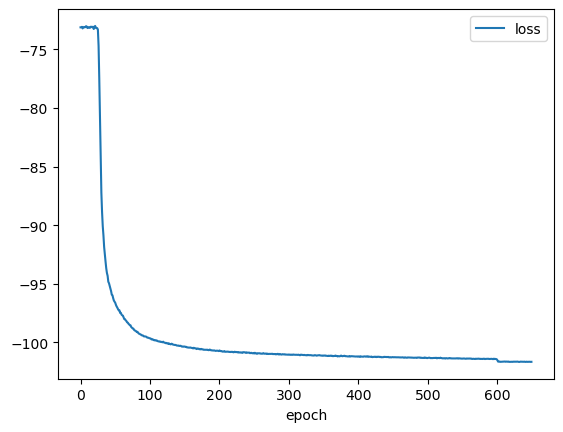

In [42]:
plt.plot(losses_G, label='loss')
plt.legend()
plt.xlabel('epoch')

In [ ]:
folder = "GP2GP_FNO_codomain_prior"
if not os.path.exists(f"paper_pdf/{folder}"):
    os.makedirs(f"paper_pdf/{folder}")

In [13]:

# load trained model
G = OpFlow(modes=modes, width=width, blocks=blocks, base_dist=base_dist).to(device)

model_path = f"paper_saved_models/{folder}/1D_codomain_649_prior.pt"
checkpoint = torch.load(model_path, map_location='cpu')
G.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

In [ ]:
model = G

### Plot the contribution of the log_det from each block and final log_log
forward process, account the contribution of each block and 

In [45]:
x_hist_true, bin_edges = x_train.histogram(range=[-5.5,5.5], density=True)
nlag_eva = int(ndim//2)

x_pos = np.linspace(0, 1, ndim)
x_pos_acovf = x_pos[:nlag_eva]

nsample_eva = 5000

x_acovf_true = torch.stack([torch.tensor(sm.tsa.acovf(x_train[i,:,0].numpy(), nlag=nlag_eva-1)) for i in range(ntrain)]).mean(dim=0)

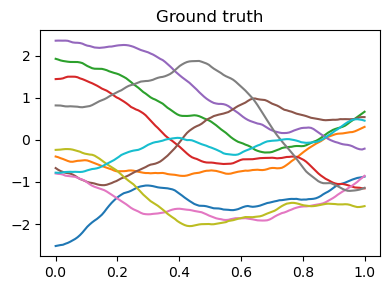

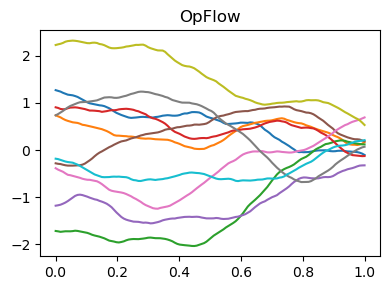

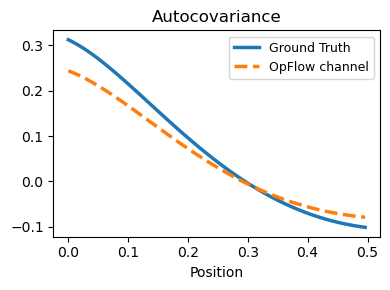

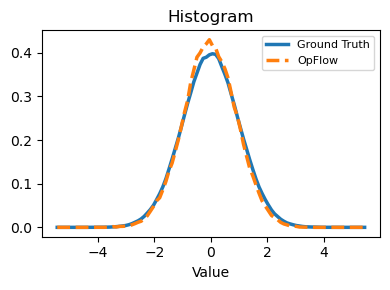

In [47]:
with torch.no_grad():
    #Z = base_dist.rsample(sample_shape=(10,))[:,:,None]
    Z = torch.cat([base_dist.rsample(sample_shape=(10,)).reshape(-1, ndim, 1),
                       base_dist.rsample(sample_shape=(10,)).reshape(-1, ndim, 1)], axis=-1)
    X_hat = model.inverse(Z).detach().cpu().numpy()
    X_ground_truth = x_train[:10]

    #Z_alt = base_dist.rsample(sample_shape=(1000,))[:,:,None]
    Z_alt = torch.cat([base_dist.rsample(sample_shape=(5000,)).reshape(-1, ndim, 1),
                       base_dist.rsample(sample_shape=(5000,)).reshape(-1, ndim, 1)], axis=-1)    

    z_train_iter = torch.split(Z_alt, 1000, dim=0)
    X_alt = []
    for i in range(len(z_train_iter)):
        z_train_temp = z_train_iter[i].to(device)
        x_alt = model.inverse(z_train_temp).detach().cpu()
        X_alt.append(x_alt)
        
    X_alt = torch.vstack(X_alt)  
    
    x_hist_channel1, bin_edges_alt = X_alt[:,:,0].histogram(range=[-5.5,5.5], density=True)
    x_hist_channel2, bin_edges_alt = X_alt[:,:,1].histogram(range=[-5.5,5.5], density=True)  
    
    # plot first ground truth
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    for i in range(10):
        x_ground_truth = X_ground_truth[i,:,0]
        ax.plot(x_pos, x_ground_truth)
    plt.title('Ground truth')
    plt.tight_layout()
    #plt.savefig(f"paper_pdf/{folder}/{folder}_ground_truth.pdf")
    
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    for i in range(10):
        x1 = X_hat[i,:,0]
        ax.plot(x_pos, x1)
    plt.title('OpFlow')
    plt.tight_layout()
    #plt.savefig(f"paper_pdf/{folder}/{folder}_opflow_samples_channel1.pdf")

    """
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    for i in range(10):
        x1 = X_hat[i,:,1]
        ax.plot(x_pos, x1)
    plt.tight_layout()
    plt.savefig(f"paper_pdf/{folder}/{folder}_opflow_samples_channel2.pdf")
        
    """

    #x_mean_channel1 = X_alt[:,:,0].mean(dim=0)
    #x_mean_channel2 = X_alt[:,:,1].mean(dim=0)
    x_acovf_channel1 = torch.stack([torch.tensor(sm.tsa.acovf(X_alt[i,:,0], nlag=nlag_eva-1)) for i in range(nsample_eva)]).mean(dim=0)
    x_acovf_channel2 = torch.stack([torch.tensor(sm.tsa.acovf(X_alt[i,:,1], nlag=nlag_eva-1)) for i in range(nsample_eva)]).mean(dim=0)

    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    ax.plot(x_pos_acovf, x_acovf_true, c='#1f77b4', lw=2.5, label='Ground Truth')
    ax.plot(x_pos_acovf, x_acovf_channel1, c='#ff7f0e', ls='--', lw=2.5, label='OpFlow channel')
    #ax.plot(x_pos_acovf, x_acovf_channel2, c='#7E1E9C', ls='--', lw=2.5, label='OpFlow channel')
    
    ax.set_xlabel('Position')
    ax.set_title('Autocovariance')
    ax.legend(loc='upper right', fontsize=9)
    plt.tight_layout()
    #plt.savefig(f"paper_pdf/{folder}/{folder}_autocov.pdf")
    
    
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    ax.plot((bin_edges[1:]+bin_edges[:-1])/2, x_hist_true, c='#1f77b4', lw=2.5, label='Ground Truth')
    ax.plot((bin_edges_alt[1:]+bin_edges_alt[:-1])/2, x_hist_channel1, c='#ff7f0e', lw=2.5, ls='--',  label='OpFlow')
    #ax.plot((bin_edges_alt[1:]+bin_edges_alt[:-1])/2, x_hist_channel2, c='#7E1E9C', lw=2.5, ls='--',  label='OpFlow channel2')
    ax.set_xlabel('Value')
    ax.set_title('Histogram')
    ax.legend(loc='upper right', fontsize=8)
    plt.tight_layout()
    #plt.savefig(f"paper_pdf/{folder}/{folder}_hist.pdf")